In [5]:
import numpy as np
import math
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Set data type
DTYPE=torch.float32

# Set constants
pi=torch.pi
#viscosity = .01/pi
viscosity=0.001

# Define initial condition
def fun_u_0(x):
    return -torch.sin(pi * x)

# Define boundary condition
def fun_u_b(t, x):
    n = x.shape[0]
    return torch.zeros((n,1), dtype=DTYPE)

# Define residual of the PDE
def fun_r(t, x, u, u_t, u_x, u_xx):
    return u_t + u * u_x - viscosity * u_xx

In [6]:
# Set number of data points
N_0 = 50
N_b = 50
N_r = 10000

# Set boundary
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.



# Lower bounds
lb = torch.tensor([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = torch.tensor([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
#torch.manual_seed(0)

In [7]:
# sample initial value
t_0=torch.ones((N_0,1),dtype=DTYPE)*lb[0]
x_0=torch.rand((N_0,1),dtype=DTYPE)

# scale x_0 to between x_min and x_max
x_0=x_0*(ub[1]-lb[1]) + lb[1]

# concatenate t_0 and x_0 into an N_0 x 2 matrix
X_0 = torch.cat([t_0, x_0], axis=1)


# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)

#u_0.shape is torch.Size([50, 1])

In [8]:
# Boundary data
t_b = torch.rand((N_b,1), dtype=DTYPE)
t_b = t_b*(ub[0] - lb[0])+lb[0]
x_b = lb[1] + (ub[1] - lb[1]) * torch.bernoulli(torch.ones((N_b,1))-1/2)
# or we can just create two N_b/2 by 1 tensors, one for each boundary


# concatenate to an N_b x 2 matrix
X_b = torch.cat([t_b, x_b], axis=1)


# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(t_b, x_b)



In [9]:
X_b.shape

torch.Size([50, 2])

In [10]:
# Initial and boundary data are only used to train
# the NN for initial and boundary condition

In [11]:
# Combining initial and boundary conditions
# X_ib is (N_0 + N_b) x 2
# u_ib is (N_0 + N_b) x 1

X_ib=torch.cat([X_0, X_b],axis=0)
u_ib=torch.cat([u_0, u_b],axis=0)

In [12]:
# Draw collocation points
t_r = torch.rand((N_r,1),dtype=DTYPE)
t_r = t_r*(ub[0]-lb[0])+lb[0]
x_r = torch.rand((N_r,1),dtype=DTYPE)
x_r = x_r*(ub[1]-lb[1])+lb[1]

X_r = torch.cat([t_r, x_r], axis=1)

# a small fraction of the collocation points are used to train the distance function
# the rest are for the PINN loss function

In [13]:
X_r.shape

torch.Size([10000, 2])

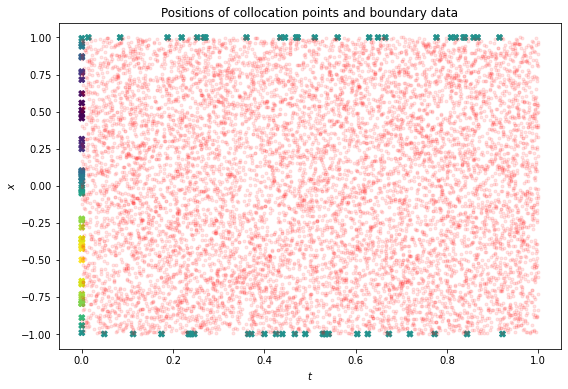

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
plt.scatter(t_b, x_b, c=u_b, marker='X', vmin=-1, vmax=1)
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');
#plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)

In [15]:
# Define the three NN

# D(x,t) distance function


def D_NN_constr(num_hidden_layers=2, num_neurons=5):
    layers = []
    layers.append(nn.Linear(2, num_neurons))
    layers.append(nn.Tanh())
    for _ in range(num_hidden_layers):
        layers.append(nn.Linear(num_neurons,num_neurons))
        layers.append(nn.Tanh())
    layers.append(nn.Linear(num_neurons, 1))

    model = nn.Sequential(*layers)
    return model

In [16]:
# a NN to learn the initial and boundary conditions

def IB_constr(num_hidden_layers=2, num_neurons=5):
    layers = []
    layers.append(nn.Linear(2, num_neurons))
    layers.append(nn.Tanh())
    for _ in range(num_hidden_layers):
        layers.append(nn.Linear(num_neurons,num_neurons))
        layers.append(nn.Tanh())
    layers.append(nn.Linear(num_neurons, 1))

    model = nn.Sequential(*layers)
    return model

In [17]:
# u_tilda(x,t) is the main NN

def u_tilda_constr(num_hidden_layers=8, num_neurons=20):
    layers = []
    layers.append(nn.Linear(2, num_neurons))
    layers.append(nn.Tanh())
    for _ in range(num_hidden_layers):
        layers.append(nn.Linear(num_neurons,num_neurons))
        layers.append(nn.Tanh())
    layers.append(nn.Linear(num_neurons, 1))

    model = nn.Sequential(*layers)
    return model

In [18]:
# compute residual in the bulk to train u_tilda
# X_r is a (N_r x 2) torch tensor
# we need to input the other two networks


def get_r(u_net,D_net,IB_net, X_r):
    
    t, x = X_r[:, 0:1], X_r[:,1:2]
    # this way of slicing makes t and x both (N_r x 1) tensor
    # and NOT a [N_r] vector
    
    t.requires_grad_(requires_grad=True)
    x.requires_grad_(requires_grad=True)
    X = torch.stack([t[:,0], x[:,0]], axis=1)
    
    u = IB_net(X) + D_net(X) * u_net(X)
    #u = IB_net(X)*torch.exp(-15.*D_net(X)) + D_net(X) * u_net(X)
    
    # torch.stack([t[:,0], x[:,0]], axis=1) has shape (N_r x 2)
    # u has shape (N_r x 1)
    
    u_t=torch.autograd.grad(u,t,torch.ones_like(u),create_graph=True)[0]
    u_x=torch.autograd.grad(u,x,torch.ones_like(u),create_graph=True)[0]
    u_xx=torch.autograd.grad(u_x,x,torch.ones_like(u_x),create_graph=True)[0]
    # all derivatives have shape (N_r x 1) because of torch.ones_like(u)
    
    return fun_r(t, x, u, u_t, u_x, u_xx)

In [19]:
# Define a dataset with label
# used to train distance AND initial and boundary condition

class Dataset_label(Dataset):
    
    def __init__(self,data,label):
        self.data = data  
        self.label = label 
        self.N = len(data)  
        
    def __getitem__(self,index):
        return self.data[index],self.label[index]
    
    def __len__(self):
        return self.N

    
# Define a dataset WITHOUT label
# Used to train u_tilta

class Dataset_nolabel(Dataset):
    
    def __init__(self,data):
        self.data = data 
        self.N = len(data)  
        
    def __getitem__(self,index):
        return self.data[index]
    
    def __len__(self):
        return self.N


In [20]:
# Training distance D(x,t)

# preparing data
# use 50 points from initial, 50 from boundary, and 50 from collocation as training data

X_D_tr=torch.cat([X_0[0:20, :], X_b[0:20, :], X_r[0:50,:]],axis=0)

# creating label
# for each (t,x), D(x,t)=min(t-tmin, x-xmin, xmax-x)

d_tr=torch.zeros((90,1),dtype=DTYPE)

for i in range(90):
    t=X_D_tr[i,0]
    x=X_D_tr[i,1]
    d_tr[i,:]=min([t-tmin, x-xmin, xmax-x])
    
    
# Create validation data
# 10 points from initial, 10 points from boundary, 10 from collocation

X_D_val=torch.cat([X_0[20:30, :], X_b[20:30, :], X_r[20:30,:]],axis=0)

d_val=torch.zeros((30,1),dtype=DTYPE)

for i in range(30):
    t=X_D_val[i,0]
    x=X_D_val[i,1]
    d_val[i,:]=min([t-tmin, x-xmin, xmax-x])
    

    

In [21]:
# Create data loader for training D(x,t)

d_ds_tr=Dataset_label(X_D_tr, d_tr)
d_ds_val=Dataset_label(X_D_val, d_val)

d_loader_tr=DataLoader(d_ds_tr,batch_size = len(d_ds_tr),shuffle=False)
d_loader_val=DataLoader(d_ds_val,batch_size = len(d_ds_val),shuffle=False)

In [41]:
# create model for D

D_NN=D_NN_constr()

In [42]:
# training function with label

def train_label(net, epochs, loader_tr, loader_val):
    loss_fcn=nn.MSELoss(reduction = 'mean')
    optimizer = optim.Adam(net.parameters(), lr=1e-2)
    for epoch in range(epochs):
        if epoch == 1000:
            optimizer = optim.Adam(net.parameters(), lr=1e-3)
        elif epoch == 3000:
            optim.Adam(net.parameters(), lr=5e-4)
        running_loss=0.
        optimizer.zero_grad()
        data_tr, label_tr = next(iter(loader_tr))
        label_predict=net(data_tr)
        loss=loss_fcn(label_predict, label_tr)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        print(running_loss)
        
        if epoch%50==49:
            val_loss=0.
            data_val, label_val=next(iter(loader_val))
            label_predict_val=net(data_val)
            val_loss+=loss_fcn(label_predict_val, label_val).item()
            print(f'validation loss: {val_loss}')
    print('Finished Training',running_loss)

        
        


In [43]:
train_label(D_NN, 5000, d_loader_tr, d_loader_val)

0.18731378018856049
0.15344133973121643
0.1228337213397026
0.0962284654378891
0.0743996724486351
0.05806094780564308
0.04775165393948555
0.0435931421816349
0.04485323280096054
0.04953378438949585
0.05474108085036278
0.05807700753211975
0.05859461426734924
0.05659637600183487
0.05301136523485184
0.04889519885182381
0.04514089599251747
0.042347703129053116
0.04078568145632744
0.04041318967938423
0.040927935391664505
0.04185769706964493
0.04270615428686142
0.04311231151223183
0.04292912036180496
0.04219972342252731
0.041087184101343155
0.03980297967791557
0.03855026513338089
0.03748456761240959
0.03669204190373421
0.03618377447128296
0.035904210060834885
0.03575091063976288
0.035602882504463196
0.03535214066505432
0.03493097051978111
0.03432677686214447
0.03358018025755882
0.03276806324720383
0.03197800740599632
0.03128203749656677
0.03071681596338749
0.03027505800127983
0.02991040050983429
0.02955486997961998
0.029143843799829483
0.02863963507115841
0.028044184669852257
0.027395341545343

0.0008148474153131247
0.0008103118743747473
0.0008052175980992615
0.0008027439471334219
0.0008016352658160031
0.0007989844307303429
0.0007945579127408564
0.0007905048551037908
0.0007880058838054538
0.0007860907353460789
0.0007833462441340089
0.0007795636192895472
0.0007756710983812809
0.0007724722381681204
0.0007699166890233755
0.0007673908257856965
0.0007643948192708194
0.0007609311724081635
0.0007573115872219205
0.0007538676145486534
0.0007507179398089647
0.0007477918989025056
0.0007449301774613559
0.0007419927278533578
0.0007389304810203612
0.000735748908482492
0.0007324977195821702
0.0007292108493857086
0.0007259381236508489
0.0007226957241073251
0.0007195164798758924
0.0007164193666540086
validation loss: 0.00021609646501019597
0.0007134754559956491
0.00071079091867432
0.000708634324837476
0.000707530474755913
0.0007087327539920807
0.0007148961303755641
0.0007324389298446476
0.000774179061409086
0.0008669150993227959
0.0010311998194083571
0.001235399628058076
0.0012321408139541745

0.00036274094600230455
0.00036238812026567757
0.0003621052601374686
0.000361891754437238
0.0003616972535382956
0.0003614718734752387
0.0003611986758187413
0.00036089925561100245
0.00036060623824596405
0.00036034200456924736
0.0003601039934437722
0.0003598752082325518
0.00035964028211310506
0.00035938844666816294
0.00035912348539568484
0.0003588577965274453
0.0003585953963920474
0.00035834230948239565
0.0003580975462682545
0.0003578556061256677
0.0003576122981030494
0.0003573664289433509
0.0003571168927010149
0.000356864562490955
0.00035661234869621694
0.00035636144457384944
0.0003561117628123611
0.00035586513695307076
validation loss: 0.0003933300613425672
0.00035561935510486364
0.0006035017431713641
0.0003566197119653225
0.0004819636233150959
0.0005128505290485919
0.0004133442125748843
0.00035568137536756694
0.0003927882353309542
0.00044073929893784225
0.00042762912926264107
0.00037993257865309715
0.00035505709820427
0.0003718578955158591
0.00039883513818494976
0.0003998369793407619
0

0.0003125203656964004
0.00031239885720424354
0.0003122777270618826
0.0003121559857390821
0.0003120341571047902
0.00031191279413178563
0.0003117913438472897
0.0003116688458248973
0.0003115468716714531
0.000311424519168213
0.0003113027196377516
0.0003111809492111206
0.0003110575198661536
0.00031093560392037034
0.00031081255292519927
0.00031069014221429825
0.00031056738225743175
0.00031044473871588707
0.00031032145489007235
0.0003101983747910708
0.0003100762260146439
0.0003099533205386251
0.000309829629259184
0.0003097055887337774
0.0003095834399573505
0.000309459341224283
0.0003093354171141982
0.00030921283178031445
0.00030908899498172104
0.0003089657402597368
0.0003088411467615515
0.0003087172517552972
validation loss: 0.0003194897435605526
0.0003085933276452124
0.0003084690251853317
0.0003083446354139596
0.00030822076951153576
0.0003080954193137586
0.0003079709713347256
0.00030784658156335354
0.00030772213358432055
0.0003075977729167789
0.0003074728883802891
0.00030734780011698604
0.00

0.0002438114897813648
0.00024358027440030128
0.0002433482150081545
0.0002431156171951443
0.00024288181157317013
0.00024264841340482235
0.00024241404025815427
0.00024217834288720042
0.00024194305296987295
0.00024170706456061453
0.00024146998475771397
0.00024123303592205048
0.00024099407892208546
0.0002407557039987296
0.00024051607761066407
0.00024027650943025947
0.00024003576254472136
0.0002397947246208787
0.000239553366554901
0.00023931104806251824
0.00023906785645522177
0.00023882447567302734
0.00023858077474869788
0.0002383356331847608
0.00023809050617273897
0.000237844797084108
0.00023759760370012373
0.00023734975547995418
0.00023710278037469834
0.0002368540153838694
0.00023660570150241256
0.00023635489924345165
0.0002361046790610999
0.00023585384769830853
0.00023560176487080753
0.00023534981301054358
0.00023509704624302685
0.0002348432462895289
0.0002345884859096259
0.00023433403111994267
0.0002340789942536503
0.0002338219783268869
0.00023356576275546104
0.00023330828116741031
0.00

0.00013130252773407847
0.0001311249507125467
0.0001309417129959911
0.00013075265451334417
0.00013056078751105815
0.00013037017197348177
validation loss: 0.00011255600111326203
0.00013018486788496375
0.00013000424951314926
0.00012982849148102105
0.00012965516361873597
0.00012948285439051688
0.00012930949742440134
0.0001291349617531523
0.00012895994586870074
0.0001287848426727578
0.00012861157301813364
0.00012843964213971049
0.0001282703160541132
0.00012810311454813927
0.00012793808127753437
0.00012777411029674113
0.00012761201651301235
0.00012745031563099474
0.00012728883302770555
0.00012712836905848235
0.00012696816702373326
0.0001268092601094395
0.00012665124086197466
0.00012649463315028697
0.00012633833102881908
0.000126183673273772
0.00012603029608726501
0.00012587811215780675
0.00012572605919558555
0.00012557554873637855
0.0001254270609933883
0.00012527874787338078
0.00012513206456787884
0.00012498580326791853
0.00012484152102842927
0.00012469731154851615
0.0001245545136043802
0.00

0.00010179014498135075
0.00010182644473388791
0.00010197526717092842
0.00010198280506301671
0.00010179229138884693
0.00010160584497498348
0.00010155584459425882
0.00010156528878724203
0.00010154474148293957
0.00010151758760912344
0.00010151106835110113
0.00010147313878405839
0.00010137059143744409
0.00010126795677933842
0.00010123209358425811
0.0001012414795695804
0.00010123079118784517
0.00010118611680809408
0.00010113840107806027
0.00010109636787092313
0.00010104396642418578
0.00010098417260451242
0.00010094272147398442
0.00010092473530676216
0.00010090685827890411
validation loss: 9.92583081824705e-05
0.00010087113332701847
0.0001008244653348811
0.00010078141349367797
0.0001007427490549162
0.00010070025018649176
0.00010065860988106579
0.00010062396177090704
0.00010059714259114116
0.00010056747123599052
0.00010053014557342976
0.00010049010597867891
0.00010045149247162044
0.00010041416680905968
0.00010037525498773903
0.00010033714352175593
0.00010030143312178552
0.00010026898235082626

8.890345634426922e-05
8.887000876711681e-05
8.883600094122812e-05
8.880218956619501e-05
8.876794890966266e-05
8.873437764123082e-05
8.870014426065609e-05
8.866604912327603e-05
8.863193943398073e-05
8.859785157255828e-05
8.856377826305106e-05
8.852990868035704e-05
8.849498408380896e-05
8.846137643558905e-05
8.842715033097193e-05
8.839299698593095e-05
8.835866901790723e-05
8.832445018924773e-05
8.829041325952858e-05
8.82559033925645e-05
8.822176459943876e-05
8.818732749205083e-05
8.815277396934107e-05
8.811875159153715e-05
8.808372513158247e-05
8.80497827893123e-05
8.80147927091457e-05
8.798031194601208e-05
8.794591121841222e-05
8.79114304552786e-05
8.78764913068153e-05
8.78425344126299e-05
8.780792995821685e-05
8.777285984251648e-05
8.773816807661206e-05
8.770319254836068e-05
8.766839164309204e-05
8.763394725974649e-05
8.759892807574943e-05
8.756410534260795e-05
8.752927533350885e-05
8.749410335440189e-05
8.74596880748868e-05
8.742459613131359e-05
8.738953329157084e-05
8.735465235076845

7.433108112309128e-05
7.42975898901932e-05
7.426423690048978e-05
7.423086208291352e-05
7.419729809043929e-05
7.416407606797293e-05
validation loss: 0.00010077733895741403
7.41306139389053e-05
7.409735553665087e-05
7.406363147310913e-05
7.403040945064276e-05
7.399712922051549e-05
7.396309229079634e-05
7.392955740215257e-05
7.389621896436438e-05
7.386285142274573e-05
7.382914918707684e-05
7.379564340226352e-05
7.376199209829792e-05
7.372794789262116e-05
7.369466766249388e-05
7.366122008534148e-05
7.362780888797715e-05
7.359405572060496e-05
7.356012793025002e-05
7.352708780672401e-05
7.349333463935181e-05
7.345950871240348e-05
7.342537719523534e-05
7.339204603340477e-05
7.335819100262597e-05
7.332445966312662e-05
7.329058280447498e-05
7.325671322178096e-05
7.322315650526434e-05
7.318906136788428e-05
7.315527182072401e-05
7.312188972719014e-05
7.308751082746312e-05
7.305368490051478e-05
7.301992445718497e-05
7.298607670236379e-05
7.295202522072941e-05
7.291820656973869e-05
7.28840022929944

6.071747338864952e-05
6.0842910897918046e-05
6.106581713538617e-05
6.14488308201544e-05
6.209009006852284e-05
6.313373160082847e-05
6.475870031863451e-05
6.712037429679185e-05
7.013940194156021e-05
7.318605639738962e-05
7.480223575839773e-05
7.33796478016302e-05
6.876779661979526e-05
6.339375977404416e-05
6.0517228121170774e-05
6.131667032605037e-05
6.411106733139604e-05
6.60410660202615e-05
6.533846317324787e-05
6.267244316404685e-05
6.043920438969508e-05
6.036135528120212e-05
6.190229760250077e-05
6.310558819677681e-05
6.264882540563121e-05
6.104997737566009e-05
5.9937447076663375e-05
6.019854481564835e-05
6.117529119364917e-05
6.160468910820782e-05
validation loss: 0.00010999249934684485
6.1018025007797405e-05
6.0095822846051306e-05
5.975058957119472e-05
6.0125745221739635e-05
6.060232044546865e-05
6.05925488343928e-05
6.0134076193207875e-05
5.9715286624850705e-05
5.968149343971163e-05
5.9919544582953677e-05
6.008065247442573e-05
5.997657717671245e-05
5.9719015553127974e-05
5.954082

5.0831476983148605e-05
5.0814855057979e-05
5.08003358845599e-05
5.0784969062078744e-05
5.07706354255788e-05
5.075536319054663e-05
5.073935244581662e-05
5.072388375992887e-05
5.0707472837530077e-05
5.069214239483699e-05
5.067699748906307e-05
5.066171434009448e-05
5.064686411060393e-05
5.063152275397442e-05
5.06162759847939e-05
5.060050534666516e-05
5.0584723794599995e-05
5.056970985606313e-05
5.055436849943362e-05
5.0538852519821376e-05
5.052354754297994e-05
5.050852632848546e-05
5.049294122727588e-05
validation loss: 0.00010947071859845892
5.047759987064637e-05
5.046231308369897e-05
5.0447099056327716e-05
5.0431277486495674e-05
5.04160561831668e-05
5.040104952058755e-05
5.0386119255563244e-05
5.037029040977359e-05
5.0354770792182535e-05
5.033965135226026e-05
5.032418994233012e-05
5.030892862123437e-05
5.029387102695182e-05
5.0278453272767365e-05
5.026311191613786e-05
5.024790152674541e-05
5.023227640776895e-05
5.021692777518183e-05
5.020187745685689e-05
5.018619049224071e-05
5.01708454

In [ ]:
##########################################################################################################

In [44]:
# Learning initial and boundary conditions

# preparing data
# use 10 points from initial, 10 points from boundary for validation

X_ib_tr=torch.cat([X_0[:20, :], X_b[:20, :]],axis=0)

# creating label

u_ib_tr=torch.cat([u_0[:20,:], u_b[:20,:]],axis=0)

    
    
# Create validation data
X_ib_val=torch.cat([X_0[20:30, :], X_b[20:30, :]],axis=0)

u_ib_val=torch.cat([u_0[20:30,:], u_b[20:30,:]],axis=0)

    

In [45]:
# Create data loader for training IB

ib_ds_tr=Dataset_label(X_ib_tr, u_ib_tr)
ib_ds_val=Dataset_label(X_ib_val, u_ib_val)

ib_loader_tr=DataLoader(ib_ds_tr,batch_size = len(ib_ds_tr),shuffle=False)
ib_loader_val=DataLoader(ib_ds_val,batch_size = len(ib_ds_val),shuffle=False)

In [46]:
# creating model for initial and boundary conditions

NN_IB=IB_constr()

In [47]:
# training with the training function with label

train_label(NN_IB, 5000, ib_loader_tr, ib_loader_val)

0.2914147973060608
0.26178014278411865
0.23756404221057892
0.21840128302574158
0.20370535552501678
0.19304382801055908
0.185944601893425
0.18178144097328186
0.17974959313869476
0.17888802289962769
0.17823699116706848
0.177106574177742
0.1752258837223053
0.17269150912761688
0.16981950402259827
0.1669972836971283
0.16457194089889526
0.1627783477306366
0.16170276701450348
0.16127857565879822
0.16131246089935303
0.1615360677242279
0.16167297959327698
0.16150310635566711
0.16090664267539978
0.1598750203847885
0.1584920585155487
0.1568969190120697
0.15524336695671082
0.15366515517234802
0.15225255489349365
0.1510419100522995
0.1500166356563568
0.14911825954914093
0.14826363325119019
0.14736485481262207
0.14634740352630615
0.14516326785087585
0.14379659295082092
0.142261803150177
0.14059510827064514
0.13884243369102478
0.1370464563369751
0.13523583114147186
0.1334187537431717
0.13158181309700012
0.12969452142715454
0.12771782279014587
0.12561450898647308
0.1233588457107544
validation loss: 0.

0.00025371721130795777
0.0002531635691411793
0.00025269403704442084
0.0002493303036317229
0.00024665286764502525
0.00024610181571915746
0.0002447780570946634
0.00024204232613556087
0.00023987796157598495
0.00023892385070212185
0.00023759299074299634
0.0002351792063564062
0.00023319276806432754
0.00023213503300212324
0.00023070983297657222
0.00022863701451569796
0.00022681208793073893
0.00022550714493263513
0.0002241700713057071
0.00022239454847294837
0.00022057976457290351
0.00021918809216003865
0.00021789351012557745
0.00021630078845191747
0.0002146193291991949
0.00021313426259439439
0.00021180503244977444
0.0002104066516039893
0.00020885036792606115
0.0002073245559586212
0.000205968419322744
0.00020464691624511033
0.0002032315533142537
0.00020177387341391295
0.0002003700501518324
0.0001990519231185317
0.0001977487263502553
0.00019639063975773752
0.00019501015776768327
0.00019368028733879328
0.00019239958783145994
0.00019112764857709408
0.00018983603513333946
0.00018853068468160927
0.

5.7730758271645755e-05
9.605203376850113e-05
6.804506847402081e-05
3.528824890963733e-05
5.755486199632287e-05
7.539791840827093e-05
4.989463559468277e-05
3.505530912661925e-05
5.419068111223169e-05
6.001151632517576e-05
4.0427497879136354e-05
3.552583439159207e-05
4.9471320380689576e-05
4.929348506266251e-05
3.5843782825395465e-05
3.5535274946596473e-05
4.4674005039269105e-05
4.238916881149635e-05
3.369338082848117e-05
3.490320887067355e-05
4.060191349708475e-05
validation loss: 0.0014999009435996413
3.8085145206423476e-05
3.254992770962417e-05
3.388919503777288e-05
3.742189073818736e-05
3.5372544516576454e-05
3.177408507326618e-05
3.278720396338031e-05
3.50297377735842e-05
3.356751403771341e-05
3.1150128052104264e-05
3.175605525029823e-05
3.321156691526994e-05
3.227512206649408e-05
3.060031667700969e-05
3.084100171690807e-05
3.17993872158695e-05
3.127877425868064e-05
3.0088351195445284e-05
3.0050607165321708e-05
3.0672570574097335e-05
3.0443043215200305e-05
2.9596292733913288e-05
2.9

1.4121462299954146e-05
1.4094915059104096e-05
1.4068298696656711e-05
1.4041786016605329e-05
1.4015036867931485e-05
1.3988766113470774e-05
1.3962060620542616e-05
1.3935770766693167e-05
1.3909075278206728e-05
1.3882160601497162e-05
1.3855815268470906e-05
1.3829189811076503e-05
1.3802836292597931e-05
1.3776423656963743e-05
1.3749903700954746e-05
1.3723581105296034e-05
1.3697163012693636e-05
1.3671005945070647e-05
1.3644344107888173e-05
1.361822069156915e-05
1.359166344627738e-05
1.3565394510806073e-05
1.3539129213313572e-05
1.3513234080164693e-05
1.3486681382346433e-05
1.3460472473525442e-05
1.3434502761811018e-05
1.3408348422672134e-05
1.3382462384470273e-05
1.33561088659917e-05
1.3330174624570645e-05
1.3303704690770246e-05
1.3278020560392179e-05
1.3251988093543332e-05
1.3225835573393852e-05
1.3199864952184726e-05
1.3174122614145745e-05
1.3148212929081637e-05
1.312200038228184e-05
1.309647450398188e-05
1.3070709428575356e-05
1.3044715160503983e-05
1.3019076504861005e-05
1.299356699746567

6.309762738965219e-06
validation loss: 0.0005674261483363807
6.297827439993853e-06
6.2858925957698375e-06
6.273819508351153e-06
6.262052011152264e-06
6.250214937608689e-06
6.238448804651853e-06
6.226714958756929e-06
6.214731001819018e-06
6.203043994901236e-06
6.191197371663293e-06
6.17954583503888e-06
6.16807528786012e-06
6.15655881119892e-06
6.145043244032422e-06
6.133440365374554e-06
6.121936166891828e-06
6.110390131652821e-06
6.098881385696586e-06
6.087521796871442e-06
6.0761221902794205e-06
6.064798071747646e-06
6.053457582311239e-06
6.04205433774041e-06
6.030794793332461e-06
6.019737156748306e-06
6.0084198594267946e-06
5.9973053794237785e-06
5.986307314742589e-06
5.975189651508117e-06
5.964112460787874e-06
5.952931587671628e-06
5.941961717326194e-06
5.930775841989089e-06
5.919952855037991e-06
5.909151695959736e-06
5.898255949432496e-06
5.887357474421151e-06
5.876496288692579e-06
5.865814273420256e-06
5.854893061041366e-06
5.844216957484605e-06
5.833534487464931e-06
5.8227315093972

3.434471636865055e-06
3.435024609643733e-06
3.4393913210806204e-06
3.4506108477216912e-06
3.473626975392108e-06
3.5186749300919473e-06
3.6034082313562976e-06
3.760420440812595e-06
4.048611117468681e-06
4.567740688798949e-06
5.481478638102999e-06
6.997822310950141e-06
9.275659067498054e-06
validation loss: 0.0003725689894054085
1.2018896086374298e-05
1.4036757420399226e-05
1.3320362086233217e-05
9.409397534909658e-06
4.968175744579639e-06
3.494918246360612e-06
5.362735919334227e-06
7.830872164049651e-06
8.019016604521312e-06
5.734353180741891e-06
3.6049600566911977e-06
3.774011474888539e-06
5.417744432634208e-06
6.132957878435263e-06
5.006086666980991e-06
3.5563141409511445e-06
3.4799843433575006e-06
4.469947270990815e-06
4.961927515978459e-06
4.31697617386817e-06
3.4539909847808303e-06
3.3988230825343635e-06
3.974427727371221e-06
4.263094069756335e-06
3.8880007195984945e-06
3.3769624678825494e-06
3.335544988658512e-06
3.6762023682967992e-06
3.8551006582565606e-06
3.631867684816825e-06


2.3596082883159397e-06
2.3573074940941297e-06
2.355083324800944e-06
2.3529732970928308e-06
2.3508462163590593e-06
2.3487409634981304e-06
2.3465504455089103e-06
2.344402901144349e-06
2.3423472157446668e-06
2.340259470656747e-06
2.3380898710456677e-06
2.335906856387737e-06
2.3337499897024827e-06
2.3317106752074324e-06
2.3294874154089484e-06
2.3273091755982023e-06
2.3252728169609327e-06
2.323129137948854e-06
2.3209809114632662e-06
2.318887254659785e-06
2.316812697245041e-06
2.3147590582084376e-06
2.3126208361645695e-06
2.310534227945027e-06
2.3083948690327816e-06
2.3062848413246684e-06
2.3042227894620737e-06
2.3021998458716553e-06
2.300141659361543e-06
2.298137360412511e-06
2.2961144168220926e-06
2.2943738713365747e-06
2.292462568220799e-06
2.2908443497726694e-06
2.2894346329849213e-06
2.2883461952005746e-06
2.287993538629962e-06
2.288316181875416e-06
2.2902190721652005e-06
2.2943131625652313e-06
2.3021568722469965e-06
2.316245854672161e-06
2.340419541724259e-06
2.381622380198678e-06
2.45

1.7267524299313664e-06
1.7256113551411545e-06
1.7247396044695051e-06
1.723752575344406e-06
1.7227637272299035e-06
1.7220379504578887e-06
validation loss: 0.0002057194069493562
1.7212538523381227e-06
1.7206318716489477e-06
1.720242153169238e-06
1.7201007267431123e-06
1.7202371509483783e-06
1.7209622455993667e-06
1.7223671875399305e-06
1.724778826428519e-06
1.7285987041759654e-06
1.734349325488438e-06
1.7430207890356542e-06
1.7558271565576433e-06
1.7748009213391924e-06
1.8029970760835567e-06
1.8447050251779729e-06
1.9068171468461514e-06
1.9992444322269876e-06
2.1369771729951026e-06
2.341591653021169e-06
2.6449101824255195e-06
3.0894370866008103e-06
3.7283546134858625e-06
4.616062142304145e-06
5.780043920822209e-06
7.165563147282228e-06
8.549597623641603e-06
9.48521847021766e-06
9.404245247424114e-06
7.971684681251645e-06
5.5405671446351334e-06
3.1332219805335626e-06
1.812431378311885e-06
1.941061327670468e-06
3.0443304694927065e-06
4.214972705085529e-06
4.661102593672695e-06
4.1251878428

1.348720843452611e-06
1.4701349755341653e-06
1.630543238206883e-06
1.6780111309344647e-06
1.5804444046807475e-06
1.4289838645709096e-06
1.3427725207293406e-06
1.3671439091922366e-06
1.4516019746224629e-06
1.5089005955815082e-06
1.4907968761690427e-06
1.4181525784806581e-06
1.3512882333088783e-06
1.3347556659937254e-06
1.3662123592439457e-06
1.4073600596020697e-06
1.4205409115675138e-06
1.3969827250548406e-06
1.3574448303188547e-06
1.3309668247529771e-06
1.3314984244061634e-06
1.3506466984836152e-06
1.3682533790415619e-06
1.3694877907255432e-06
1.3545511592383264e-06
1.3350025938052568e-06
1.3237872735771816e-06
validation loss: 0.00016488712572026998
1.3257346154205152e-06
1.3353295571505441e-06
1.343522967545141e-06
1.3440358088701032e-06
1.3371950444707181e-06
1.3286332887219032e-06
1.3243901548776194e-06
1.3270168892631773e-06
1.334894704996259e-06
1.3446572211250896e-06
1.3539948895413545e-06
1.3637890106110717e-06
1.3783222811980522e-06
1.4038387234904803e-06
1.4472198017756455e-0

1.0896353614953114e-06
1.0891446891037049e-06
1.0885987649089657e-06
1.0881045682253898e-06
1.0876561873374158e-06
1.087166424440511e-06
1.0868145636777626e-06
1.0865520607694634e-06
1.0864102932828246e-06
1.0863998340937542e-06
1.086767838387459e-06
1.0875091902562417e-06
1.0890211115111015e-06
1.0916544397332473e-06
1.0960443432850298e-06
1.103453541873023e-06
1.1154478443131666e-06
1.13459054773557e-06
1.1655614571282058e-06
1.215310021507321e-06
1.2952402812516084e-06
1.423159346813918e-06
1.62522974278545e-06
1.9380718185857404e-06
2.4042092263698578e-06
3.053096179428394e-06
3.854498118016636e-06
4.6389018280024175e-06
5.057686394138727e-06
4.712899226433365e-06
3.542431386449607e-06
2.0875654627161566e-06
1.1727927358151646e-06
1.2109343288102536e-06
1.9113272173854057e-06
2.5862404982035514e-06
2.669986542969127e-06
2.115064944518963e-06
1.3984514453113661e-06
1.0751030004030326e-06
1.2862268476965255e-06
1.7080113821066334e-06
1.9042952317249728e-06
validation loss: 0.00012720

9.4913758630355e-07
9.598149972589454e-07
9.567795586917782e-07
9.431286116523552e-07
9.270894452129141e-07
validation loss: 0.00012157710443716496
9.163430263470218e-07
9.148649269263842e-07
9.205738251694129e-07
9.282580322178546e-07
9.327396810476785e-07
9.316800060332753e-07
9.25985659705475e-07
9.188156582240481e-07
9.132469358519302e-07
9.111807344197587e-07
9.123521635956422e-07
9.152087159236544e-07
9.176839625979483e-07
9.183625593323086e-07
9.168308565676853e-07
9.139354801845911e-07
9.108644007937983e-07
9.086745080821856e-07
9.07798778371216e-07
9.080810627892788e-07
9.090113053389359e-07
9.098075679503381e-07
9.09927280190459e-07
9.093872677112813e-07
9.082056067200028e-07
9.067913993021648e-07
9.055357850229484e-07
9.046513582688931e-07
9.041546036314685e-07
9.040193731379986e-07
9.040466579790518e-07
9.041156658895488e-07
9.039911788022437e-07
9.036323831423942e-07
9.030653700392577e-07
9.023733582580462e-07
9.017387014864653e-07
9.010765893435746e-07
9.00514919521811e-0

9.661126796345343e-07
9.598868473403854e-07
9.056706176124862e-07
8.404232971770398e-07
8.00920474830491e-07
8.014955028556869e-07
8.307105190397124e-07
8.63068351009133e-07
8.767086683292291e-07
8.651439884488354e-07
8.37364837025234e-07
8.096739065877046e-07
7.952603482408449e-07
7.976271376719524e-07
8.107539315460599e-07
8.243488309744862e-07
8.299610385620326e-07
8.252906127381721e-07
8.137076292769052e-07
8.012623879949388e-07
validation loss: 0.00010769748769234866
7.935873327369336e-07
7.926132639113348e-07
7.970153887981724e-07
8.031058200685948e-07
8.070070407484309e-07
8.069241630437318e-07
8.030935418901208e-07
7.976702249834489e-07
7.92858202203206e-07
7.902857532826602e-07
7.902048082542024e-07
7.919081213003665e-07
7.939791544231412e-07
7.953236718094558e-07
7.952621672302485e-07
7.938874659885187e-07
7.91764136920392e-07
7.896595093370706e-07
7.881367309892084e-07
7.875084406805399e-07
7.875952974245592e-07
7.881412784627173e-07
7.887056199251674e-07
7.888412483225693e-

7.751171438030724e-07
7.174766096795793e-07
7.294405577340513e-07
7.79875335865654e-07
8.075510891103477e-07
7.855587682570331e-07
7.398174943773483e-07
7.139825584090431e-07
7.247823532452458e-07
7.516439950450149e-07
7.634349685758934e-07
7.493978273487301e-07
7.249296345435141e-07
7.120232794477488e-07
7.181674845924135e-07
7.323297381844895e-07
7.388597396129626e-07
7.316132837331679e-07
7.182754302448302e-07
7.104161454662972e-07
7.127396202122327e-07
7.202598908406799e-07
7.246900395330158e-07
7.2195092570837e-07
7.149883458623663e-07
7.096463718880841e-07
7.093665885804512e-07
7.127899834813434e-07
7.157679533520422e-07
7.15592875621951e-07
7.123477416826063e-07
7.089253699632536e-07
7.076861265886691e-07
7.087509175107698e-07
7.105418262653984e-07
7.111221407285484e-07
7.099556569301058e-07
validation loss: 9.743767441250384e-05
7.080053023855726e-07
7.066753937579051e-07
7.064951432766975e-07
7.072654852890992e-07
7.079046326907701e-07
7.077825330270571e-07
7.069276648508094e-

In [ ]:
##########################################################################################################

In [55]:
# Train u_tilda

# preparing data
# only use collocation points
# use 100 collocation points as validation samples

r_ds_tr=Dataset_nolabel(X_r[100:,:])
r_ds_val=Dataset_nolabel(X_r[:100,:])

#r_loader_tr=DataLoader(r_ds_tr,batch_size = len(r_ds_tr),shuffle=False)
r_loader_tr=DataLoader(r_ds_tr,batch_size = 1000,shuffle=True)
r_loader_val=DataLoader(r_ds_val,batch_size = len(r_ds_val),shuffle=False)

In [56]:
# creating model for u_tilda

u_tilda=u_tilda_constr()


In [57]:
# training function WITHOUT label
# need the extra function get_r as an input to find the residual in the bulk
# u_net is the NN for u_tilda


def train_u_tilda(u_net, D_net, IB_net, epochs, loader_tr, loader_val, get_r):
    loss_fcn=nn.MSELoss(reduction = 'mean')
    #optimizer = optim.Adam(u_net.parameters(), lr=1e-3)
    optimizer = optim.Adam(u_net.parameters(), lr=1e-3)
    for epoch in range(epochs):
        if epoch == 1000:
            #optimizer = optim.Adam(u_net.parameters(), lr=5e-4)
            optimizer = optim.Adam(u_net.parameters(), lr=1e-3)
        if epoch == 3000:
            #optimizer = optim.Adam(u_net.parameters(), lr=2e-4)
            optimizer = optim.Adam(u_net.parameters(), lr=5e-4)
        if epoch == 5000:
            #optimizer = optim.Adam(u_net.parameters(), lr=1e-4)
            optimizer = optim.Adam(u_net.parameters(), lr=2e-4)
        if epoch == 7000:
            optimizer = optim.Adam(u_net.parameters(), lr=1e-4)

        for i, X_tr in enumerate(loader_tr):
            
            running_loss=0.
        
        
            optimizer.zero_grad()
        
            r = get_r(u_net, D_net, IB_net, X_tr)
        
            loss = loss_fcn(r,torch.zeros(r.shape))
            loss.backward()
            optimizer.step()
        
            # print statistics
            running_loss += loss.item()
            print(f'epoch: {epoch}')
            print(running_loss)
        
        if epoch%50==49:
            val_loss=0.0
            X_val = next(iter(loader_val))
            r_val=get_r(u_net, D_net, IB_net, X_val)
            val_loss+= loss_fcn(r_val,torch.zeros(r_val.shape)).item()
            print(f'epoch: {epoch}')
            print(f'validation loss: {val_loss}')
    print('Finished Training',running_loss)
            
         

In [58]:
train_u_tilda(u_tilda, D_NN, NN_IB, 8000, r_loader_tr, r_loader_val, get_r)

epoch: 0
1.6830158233642578
epoch: 0
1.7012417316436768
epoch: 0
1.6491323709487915
epoch: 0
1.4792516231536865
epoch: 0
1.556848406791687
epoch: 0
1.5054514408111572
epoch: 0
1.483473539352417
epoch: 0
1.5188223123550415
epoch: 0
1.4017658233642578
epoch: 0
1.2774772644042969
epoch: 1
1.2861220836639404
epoch: 1
1.2636371850967407
epoch: 1
1.352981686592102
epoch: 1
1.356576681137085
epoch: 1
1.279029369354248
epoch: 1
1.1839741468429565
epoch: 1
1.1815296411514282
epoch: 1
1.1412575244903564
epoch: 1
1.0490739345550537
epoch: 1
1.088710069656372
epoch: 2
0.998853862285614
epoch: 2
1.0410219430923462
epoch: 2
0.9372643828392029
epoch: 2
0.9489713907241821
epoch: 2
0.9172253012657166
epoch: 2
0.9267553687095642
epoch: 2
0.8356018662452698
epoch: 2
0.8396032452583313
epoch: 2
0.8659278154373169
epoch: 2
0.8736135959625244
epoch: 3
0.7792271375656128
epoch: 3
0.8814067244529724
epoch: 3
0.7897013425827026
epoch: 3
0.7840017676353455
epoch: 3
0.7933608293533325
epoch: 3
0.8216241002082825

epoch: 29
0.530908465385437
epoch: 29
0.4751559793949127
epoch: 29
0.5122256875038147
epoch: 29
0.47953420877456665
epoch: 29
0.5139155387878418
epoch: 29
0.49903178215026855
epoch: 29
0.5526183843612671
epoch: 29
0.5023258328437805
epoch: 29
0.5176564455032349
epoch: 29
0.5459448099136353
epoch: 30
0.5222705006599426
epoch: 30
0.5047743320465088
epoch: 30
0.5319390296936035
epoch: 30
0.5391573309898376
epoch: 30
0.48059549927711487
epoch: 30
0.5306934714317322
epoch: 30
0.5106911659240723
epoch: 30
0.5105221271514893
epoch: 30
0.5112425684928894
epoch: 30
0.474041610956192
epoch: 31
0.5142732858657837
epoch: 31
0.5040848255157471
epoch: 31
0.4387280344963074
epoch: 31
0.504626989364624
epoch: 31
0.554416298866272
epoch: 31
0.5020254254341125
epoch: 31
0.494069904088974
epoch: 31
0.5284409523010254
epoch: 31
0.5606297254562378
epoch: 31
0.5067375302314758
epoch: 32
0.5067557096481323
epoch: 32
0.4892350733280182
epoch: 32
0.532340943813324
epoch: 32
0.498256117105484
epoch: 32
0.526775

epoch: 57
0.430846244096756
epoch: 57
0.47268062829971313
epoch: 58
0.45720916986465454
epoch: 58
0.4548722803592682
epoch: 58
0.4295291006565094
epoch: 58
0.457587867975235
epoch: 58
0.4243839383125305
epoch: 58
0.4524601101875305
epoch: 58
0.4296434819698334
epoch: 58
0.4541482627391815
epoch: 58
0.43599867820739746
epoch: 58
0.4052284359931946
epoch: 59
0.43922489881515503
epoch: 59
0.41230085492134094
epoch: 59
0.4232315123081207
epoch: 59
0.4704071879386902
epoch: 59
0.40950295329093933
epoch: 59
0.4162067174911499
epoch: 59
0.4605984091758728
epoch: 59
0.4248095154762268
epoch: 59
0.44893375039100647
epoch: 59
0.4270671010017395
epoch: 60
0.3968396484851837
epoch: 60
0.46638813614845276
epoch: 60
0.43110981583595276
epoch: 60
0.43177446722984314
epoch: 60
0.40562695264816284
epoch: 60
0.4140743613243103
epoch: 60
0.4147610664367676
epoch: 60
0.44214487075805664
epoch: 60
0.4315684735774994
epoch: 60
0.40294498205184937
epoch: 61
0.426880806684494
epoch: 61
0.3977070748806
epoch: 

epoch: 85
0.29537343978881836
epoch: 86
0.29556700587272644
epoch: 86
0.24835613369941711
epoch: 86
0.28485557436943054
epoch: 86
0.26457479596138
epoch: 86
0.2747405171394348
epoch: 86
0.26006394624710083
epoch: 86
0.2719288766384125
epoch: 86
0.2678678631782532
epoch: 86
0.2500569224357605
epoch: 86
0.3080211579799652
epoch: 87
0.25480857491493225
epoch: 87
0.30969852209091187
epoch: 87
0.2577193081378937
epoch: 87
0.30182981491088867
epoch: 87
0.26505929231643677
epoch: 87
0.24912939965724945
epoch: 87
0.3216805160045624
epoch: 87
0.27515390515327454
epoch: 87
0.27589648962020874
epoch: 87
0.2720748782157898
epoch: 88
0.2591838240623474
epoch: 88
0.2824366092681885
epoch: 88
0.2953626215457916
epoch: 88
0.25755777955055237
epoch: 88
0.259953111410141
epoch: 88
0.27056246995925903
epoch: 88
0.2700027823448181
epoch: 88
0.28165295720100403
epoch: 88
0.2597182095050812
epoch: 88
0.26308950781822205
epoch: 89
0.2921147346496582
epoch: 89
0.3019706904888153
epoch: 89
0.27397602796554565


epoch: 113
0.29869937896728516
epoch: 113
0.290036141872406
epoch: 113
0.27836188673973083
epoch: 113
0.25393128395080566
epoch: 113
0.2640913128852844
epoch: 113
0.25420698523521423
epoch: 114
0.25968655943870544
epoch: 114
0.2590450942516327
epoch: 114
0.26930782198905945
epoch: 114
0.25376006960868835
epoch: 114
0.2509741485118866
epoch: 114
0.2757352292537689
epoch: 114
0.2814822494983673
epoch: 114
0.2385459542274475
epoch: 114
0.2524128258228302
epoch: 114
0.24361273646354675
epoch: 115
0.2690262198448181
epoch: 115
0.25770455598831177
epoch: 115
0.252255380153656
epoch: 115
0.23352085053920746
epoch: 115
0.24790838360786438
epoch: 115
0.24910207092761993
epoch: 115
0.2720949649810791
epoch: 115
0.2508673369884491
epoch: 115
0.22503730654716492
epoch: 115
0.2507426142692566
epoch: 116
0.2581675946712494
epoch: 116
0.2562403082847595
epoch: 116
0.23751746118068695
epoch: 116
0.24114707112312317
epoch: 116
0.25106221437454224
epoch: 116
0.2330700010061264
epoch: 116
0.2601320743560

epoch: 141
0.8336712121963501
epoch: 141
0.9071503281593323
epoch: 141
0.9920327067375183
epoch: 141
0.8825100064277649
epoch: 141
0.7359849810600281
epoch: 141
0.8841226100921631
epoch: 141
0.7530824542045593
epoch: 141
0.8822530508041382
epoch: 141
0.8824713826179504
epoch: 142
0.810651957988739
epoch: 142
0.7348712086677551
epoch: 142
0.6647202372550964
epoch: 142
0.7338564395904541
epoch: 142
0.613669216632843
epoch: 142
0.6789629459381104
epoch: 142
0.574242353439331
epoch: 142
0.5767367482185364
epoch: 142
0.5891915559768677
epoch: 142
0.5560245513916016
epoch: 143
0.5555257797241211
epoch: 143
0.4788525402545929
epoch: 143
0.5709594488143921
epoch: 143
0.5426474213600159
epoch: 143
0.5376773476600647
epoch: 143
0.47169920802116394
epoch: 143
0.5147122144699097
epoch: 143
0.48639097809791565
epoch: 143
0.516333818435669
epoch: 143
0.4825161099433899
epoch: 144
0.4546932280063629
epoch: 144
0.46763843297958374
epoch: 144
0.4660167098045349
epoch: 144
0.5333281755447388
epoch: 144


epoch: 168
0.34698206186294556
epoch: 168
0.3500518202781677
epoch: 168
0.2819225490093231
epoch: 168
0.31356167793273926
epoch: 168
0.33953842520713806
epoch: 168
0.31324461102485657
epoch: 168
0.34634530544281006
epoch: 168
0.31054556369781494
epoch: 168
0.31250983476638794
epoch: 168
0.33732184767723083
epoch: 169
0.31629469990730286
epoch: 169
0.3304174542427063
epoch: 169
0.304136723279953
epoch: 169
0.3128257393836975
epoch: 169
0.2990448474884033
epoch: 169
0.34078559279441833
epoch: 169
0.3394344449043274
epoch: 169
0.32504498958587646
epoch: 169
0.3190464973449707
epoch: 169
0.33319130539894104
epoch: 170
0.3235158324241638
epoch: 170
0.30558496713638306
epoch: 170
0.31546470522880554
epoch: 170
0.3210850954055786
epoch: 170
0.31439709663391113
epoch: 170
0.3353661298751831
epoch: 170
0.3221835494041443
epoch: 170
0.3240848183631897
epoch: 170
0.31235170364379883
epoch: 170
0.3288134038448334
epoch: 171
0.32284894585609436
epoch: 171
0.33218926191329956
epoch: 171
0.3165949881

epoch: 195
0.26602867245674133
epoch: 195
0.27959778904914856
epoch: 195
0.28755396604537964
epoch: 195
0.2954886257648468
epoch: 195
0.2864187955856323
epoch: 195
0.318006694316864
epoch: 195
0.3034108877182007
epoch: 195
0.2876681387424469
epoch: 195
0.27808624505996704
epoch: 195
0.2630159258842468
epoch: 196
0.2740775942802429
epoch: 196
0.2838495075702667
epoch: 196
0.2580590546131134
epoch: 196
0.2941003143787384
epoch: 196
0.2893546223640442
epoch: 196
0.3167348802089691
epoch: 196
0.3121884763240814
epoch: 196
0.29614946246147156
epoch: 196
0.2818218469619751
epoch: 196
0.27075573801994324
epoch: 197
0.29049554467201233
epoch: 197
0.2814088761806488
epoch: 197
0.2808147668838501
epoch: 197
0.2956845164299011
epoch: 197
0.28209513425827026
epoch: 197
0.2993090748786926
epoch: 197
0.30320408940315247
epoch: 197
0.31130367517471313
epoch: 197
0.26275622844696045
epoch: 197
0.24649938941001892
epoch: 198
0.26597073674201965
epoch: 198
0.31668218970298767
epoch: 198
0.27150750160217

epoch: 222
0.2678733468055725
epoch: 222
0.28301864862442017
epoch: 222
0.29596129059791565
epoch: 223
0.2754572927951813
epoch: 223
0.2806694805622101
epoch: 223
0.2589213252067566
epoch: 223
0.26038965582847595
epoch: 223
0.253329336643219
epoch: 223
0.2816038727760315
epoch: 223
0.28197726607322693
epoch: 223
0.2728433907032013
epoch: 223
0.2955833077430725
epoch: 223
0.269417941570282
epoch: 224
0.27081459760665894
epoch: 224
0.2911403477191925
epoch: 224
0.2841232419013977
epoch: 224
0.2833895981311798
epoch: 224
0.30970776081085205
epoch: 224
0.2651981711387634
epoch: 224
0.27196192741394043
epoch: 224
0.2881428301334381
epoch: 224
0.27099090814590454
epoch: 224
0.26828905940055847
epoch: 225
0.31895989179611206
epoch: 225
0.2698153555393219
epoch: 225
0.27440616488456726
epoch: 225
0.3075282871723175
epoch: 225
0.2647133469581604
epoch: 225
0.2918795347213745
epoch: 225
0.27889806032180786
epoch: 225
0.25766462087631226
epoch: 225
0.23485495150089264
epoch: 225
0.286663025617599

epoch: 250
0.2763833999633789
epoch: 250
0.2669258117675781
epoch: 250
0.24468915164470673
epoch: 250
0.27816373109817505
epoch: 250
0.2613697946071625
epoch: 250
0.2713475227355957
epoch: 250
0.2557809352874756
epoch: 251
0.2835007607936859
epoch: 251
0.26001086831092834
epoch: 251
0.2625831961631775
epoch: 251
0.25233718752861023
epoch: 251
0.2805628478527069
epoch: 251
0.251124769449234
epoch: 251
0.2746836543083191
epoch: 251
0.28020185232162476
epoch: 251
0.24520283937454224
epoch: 251
0.2875964939594269
epoch: 252
0.2458409070968628
epoch: 252
0.2660900354385376
epoch: 252
0.2732297480106354
epoch: 252
0.2636812925338745
epoch: 252
0.2647712230682373
epoch: 252
0.28798022866249084
epoch: 252
0.28849634528160095
epoch: 252
0.27614739537239075
epoch: 252
0.27177369594573975
epoch: 252
0.2427281141281128
epoch: 253
0.2866750955581665
epoch: 253
0.2326456755399704
epoch: 253
0.2814914882183075
epoch: 253
0.25474581122398376
epoch: 253
0.27003365755081177
epoch: 253
0.2769805490970611

epoch: 277
0.2549568712711334
epoch: 277
0.265752911567688
epoch: 277
0.2701868712902069
epoch: 277
0.2606503367424011
epoch: 277
0.2706499397754669
epoch: 277
0.27337417006492615
epoch: 278
0.2894197404384613
epoch: 278
0.2603888213634491
epoch: 278
0.25408828258514404
epoch: 278
0.27461421489715576
epoch: 278
0.2614874839782715
epoch: 278
0.2645960748195648
epoch: 278
0.23880742490291595
epoch: 278
0.2776457667350769
epoch: 278
0.27008336782455444
epoch: 278
0.2408384531736374
epoch: 279
0.24774309992790222
epoch: 279
0.2571512460708618
epoch: 279
0.26195037364959717
epoch: 279
0.2783789336681366
epoch: 279
0.26641517877578735
epoch: 279
0.2522179186344147
epoch: 279
0.2710002660751343
epoch: 279
0.2672697901725769
epoch: 279
0.28316354751586914
epoch: 279
0.25241538882255554
epoch: 280
0.25710412859916687
epoch: 280
0.27708303928375244
epoch: 280
0.26250702142715454
epoch: 280
0.30154362320899963
epoch: 280
0.2688130736351013
epoch: 280
0.27063417434692383
epoch: 280
0.2712650895118

epoch: 304
0.2522340714931488
epoch: 304
0.2669803500175476
epoch: 304
0.24588772654533386
epoch: 304
0.2533714473247528
epoch: 304
0.29323557019233704
epoch: 304
0.27688759565353394
epoch: 305
0.26305532455444336
epoch: 305
0.2687793970108032
epoch: 305
0.26737135648727417
epoch: 305
0.2550746500492096
epoch: 305
0.2599211037158966
epoch: 305
0.282806396484375
epoch: 305
0.24696770310401917
epoch: 305
0.2550049126148224
epoch: 305
0.27136245369911194
epoch: 305
0.24238646030426025
epoch: 306
0.2638973593711853
epoch: 306
0.26534539461135864
epoch: 306
0.22772814333438873
epoch: 306
0.26501116156578064
epoch: 306
0.27859967947006226
epoch: 306
0.2545749545097351
epoch: 306
0.24882014095783234
epoch: 306
0.25166502594947815
epoch: 306
0.2644621729850769
epoch: 306
0.2659035623073578
epoch: 307
0.26327043771743774
epoch: 307
0.2547161281108856
epoch: 307
0.2924371659755707
epoch: 307
0.22740517556667328
epoch: 307
0.26937270164489746
epoch: 307
0.28099289536476135
epoch: 307
0.2540739476

epoch: 331
0.26699990034103394
epoch: 331
0.263967901468277
epoch: 331
0.23604081571102142
epoch: 331
0.2503814697265625
epoch: 331
0.2649029493331909
epoch: 332
0.2657603919506073
epoch: 332
0.24231666326522827
epoch: 332
0.2542695701122284
epoch: 332
0.24959884583950043
epoch: 332
0.2668796181678772
epoch: 332
0.24657687544822693
epoch: 332
0.24802465736865997
epoch: 332
0.25198423862457275
epoch: 332
0.25119778513908386
epoch: 332
0.25040680170059204
epoch: 333
0.26031216979026794
epoch: 333
0.2686595320701599
epoch: 333
0.2576295733451843
epoch: 333
0.2500448226928711
epoch: 333
0.2361876517534256
epoch: 333
0.23933881521224976
epoch: 333
0.2521478831768036
epoch: 333
0.2559049725532532
epoch: 333
0.26331666111946106
epoch: 333
0.25104451179504395
epoch: 334
0.22060635685920715
epoch: 334
0.2651073634624481
epoch: 334
0.23063382506370544
epoch: 334
0.27108338475227356
epoch: 334
0.2548912763595581
epoch: 334
0.2641660273075104
epoch: 334
0.2582276165485382
epoch: 334
0.252906531095

epoch: 358
0.26459816098213196
epoch: 358
0.2535938322544098
epoch: 358
0.2639814615249634
epoch: 358
0.246349036693573
epoch: 358
0.2387048602104187
epoch: 358
0.2494702786207199
epoch: 358
0.24630002677440643
epoch: 359
0.21568261086940765
epoch: 359
0.23771803081035614
epoch: 359
0.24465537071228027
epoch: 359
0.26986223459243774
epoch: 359
0.25272417068481445
epoch: 359
0.2567213177680969
epoch: 359
0.23864026367664337
epoch: 359
0.2308046519756317
epoch: 359
0.2594129145145416
epoch: 359
0.27644598484039307
epoch: 360
0.2872518301010132
epoch: 360
0.2711128890514374
epoch: 360
0.2328917533159256
epoch: 360
0.2545790374279022
epoch: 360
0.23921191692352295
epoch: 360
0.2561342716217041
epoch: 360
0.26660770177841187
epoch: 360
0.27337509393692017
epoch: 360
0.23664534091949463
epoch: 360
0.2572140693664551
epoch: 361
0.26133835315704346
epoch: 361
0.24039265513420105
epoch: 361
0.221211239695549
epoch: 361
0.24044236540794373
epoch: 361
0.24671557545661926
epoch: 361
0.241808116436

epoch: 385
0.2596985995769501
epoch: 385
0.2341829091310501
epoch: 385
0.24699722230434418
epoch: 385
0.2548350393772125
epoch: 385
0.25434255599975586
epoch: 385
0.22463980317115784
epoch: 385
0.23071974515914917
epoch: 385
0.2423974722623825
epoch: 386
0.2656693458557129
epoch: 386
0.24885506927967072
epoch: 386
0.24203190207481384
epoch: 386
0.23415951430797577
epoch: 386
0.22947153449058533
epoch: 386
0.23214475810527802
epoch: 386
0.24960096180438995
epoch: 386
0.22590118646621704
epoch: 386
0.2445753812789917
epoch: 386
0.2446267306804657
epoch: 387
0.2528834342956543
epoch: 387
0.26115280389785767
epoch: 387
0.2607147991657257
epoch: 387
0.2338736355304718
epoch: 387
0.2134471982717514
epoch: 387
0.26300835609436035
epoch: 387
0.24903683364391327
epoch: 387
0.23753832280635834
epoch: 387
0.24642346799373627
epoch: 387
0.231706902384758
epoch: 388
0.2399549037218094
epoch: 388
0.22972840070724487
epoch: 388
0.24335406720638275
epoch: 388
0.2281656414270401
epoch: 388
0.2572895288

epoch: 412
0.24452605843544006
epoch: 412
0.24658705294132233
epoch: 413
0.23756062984466553
epoch: 413
0.232124924659729
epoch: 413
0.24348857998847961
epoch: 413
0.2643015384674072
epoch: 413
0.2235845923423767
epoch: 413
0.26987019181251526
epoch: 413
0.2508387863636017
epoch: 413
0.257173627614975
epoch: 413
0.25066331028938293
epoch: 413
0.20801295340061188
epoch: 414
0.2649635672569275
epoch: 414
0.23680569231510162
epoch: 414
0.22700835764408112
epoch: 414
0.22740569710731506
epoch: 414
0.25925448536872864
epoch: 414
0.24034273624420166
epoch: 414
0.2286802977323532
epoch: 414
0.23630721867084503
epoch: 414
0.22716929018497467
epoch: 414
0.22132602334022522
epoch: 415
0.2806389629840851
epoch: 415
0.22412444651126862
epoch: 415
0.211746945977211
epoch: 415
0.2548181414604187
epoch: 415
0.24572032690048218
epoch: 415
0.2816721200942993
epoch: 415
0.2183525264263153
epoch: 415
0.2258974313735962
epoch: 415
0.2471701204776764
epoch: 415
0.2487679421901703
epoch: 416
0.2303044497966

epoch: 440
0.25157299637794495
epoch: 440
0.2374219000339508
epoch: 440
0.20477059483528137
epoch: 440
0.23204442858695984
epoch: 440
0.24880726635456085
epoch: 441
0.24992553889751434
epoch: 441
0.24738451838493347
epoch: 441
0.22435232996940613
epoch: 441
0.26603156328201294
epoch: 441
0.2388571947813034
epoch: 441
0.22744108736515045
epoch: 441
0.2298620343208313
epoch: 441
0.25937286019325256
epoch: 441
0.20785373449325562
epoch: 441
0.2279238998889923
epoch: 442
0.23027151823043823
epoch: 442
0.23031537234783173
epoch: 442
0.2271130234003067
epoch: 442
0.2533123791217804
epoch: 442
0.24753548204898834
epoch: 442
0.22230999171733856
epoch: 442
0.2385414093732834
epoch: 442
0.23994490504264832
epoch: 442
0.22858987748622894
epoch: 442
0.24970075488090515
epoch: 443
0.2738918662071228
epoch: 443
0.2404356449842453
epoch: 443
0.23748695850372314
epoch: 443
0.2278752475976944
epoch: 443
0.21935608983039856
epoch: 443
0.23854082822799683
epoch: 443
0.2290884554386139
epoch: 443
0.212945

epoch: 467
0.24821706116199493
epoch: 467
0.24345524609088898
epoch: 467
0.23698361217975616
epoch: 467
0.2439606934785843
epoch: 467
0.22430776059627533
epoch: 467
0.2690429985523224
epoch: 467
0.2282988429069519
epoch: 467
0.22917219996452332
epoch: 467
0.24434027075767517
epoch: 468
0.22884820401668549
epoch: 468
0.2662605941295624
epoch: 468
0.24000105261802673
epoch: 468
0.21722717583179474
epoch: 468
0.21599340438842773
epoch: 468
0.22680412232875824
epoch: 468
0.23790524899959564
epoch: 468
0.2486126720905304
epoch: 468
0.23599819839000702
epoch: 468
0.2536223828792572
epoch: 469
0.23516817390918732
epoch: 469
0.24842220544815063
epoch: 469
0.24001382291316986
epoch: 469
0.2427317202091217
epoch: 469
0.22504183650016785
epoch: 469
0.21637234091758728
epoch: 469
0.23486047983169556
epoch: 469
0.23260635137557983
epoch: 469
0.23410993814468384
epoch: 469
0.19741857051849365
epoch: 470
0.2268880158662796
epoch: 470
0.23495903611183167
epoch: 470
0.23341448605060577
epoch: 470
0.231

epoch: 494
0.19702968001365662
epoch: 494
0.21140854060649872
epoch: 494
0.18924306333065033
epoch: 494
0.23724767565727234
epoch: 494
0.22933277487754822
epoch: 494
0.20945248007774353
epoch: 494
0.20913399755954742
epoch: 494
0.18926727771759033
epoch: 494
0.2257080376148224
epoch: 494
0.19434358179569244
epoch: 495
0.19668641686439514
epoch: 495
0.21082907915115356
epoch: 495
0.2032812237739563
epoch: 495
0.20991790294647217
epoch: 495
0.22655461728572845
epoch: 495
0.20313237607479095
epoch: 495
0.31628185510635376
epoch: 495
0.22105324268341064
epoch: 495
0.24003295600414276
epoch: 495
0.29811397194862366
epoch: 496
0.237089142203331
epoch: 496
0.20725546777248383
epoch: 496
0.2667523920536041
epoch: 496
0.2681692838668823
epoch: 496
0.2308308184146881
epoch: 496
0.20985828340053558
epoch: 496
0.25729474425315857
epoch: 496
0.19969134032726288
epoch: 496
0.2454046756029129
epoch: 496
0.22639505565166473
epoch: 497
0.23093615472316742
epoch: 497
0.2404419183731079
epoch: 497
0.2156

epoch: 521
0.24468551576137543
epoch: 521
0.24268977344036102
epoch: 521
0.2916262447834015
epoch: 522
0.26691359281539917
epoch: 522
0.2574341595172882
epoch: 522
0.27312299609184265
epoch: 522
0.264180988073349
epoch: 522
0.25755223631858826
epoch: 522
0.24638596177101135
epoch: 522
0.24422034621238708
epoch: 522
0.21721801161766052
epoch: 522
0.26615747809410095
epoch: 522
0.22136907279491425
epoch: 523
0.23291994631290436
epoch: 523
0.23747947812080383
epoch: 523
0.28014305233955383
epoch: 523
0.26832494139671326
epoch: 523
0.25293484330177307
epoch: 523
0.2224172204732895
epoch: 523
0.24770194292068481
epoch: 523
0.23544389009475708
epoch: 523
0.27181312441825867
epoch: 523
0.22877493500709534
epoch: 524
0.26688024401664734
epoch: 524
0.23645290732383728
epoch: 524
0.2400989681482315
epoch: 524
0.2452804297208786
epoch: 524
0.25851568579673767
epoch: 524
0.24551889300346375
epoch: 524
0.24071921408176422
epoch: 524
0.2454928457736969
epoch: 524
0.2290792018175125
epoch: 524
0.2398

epoch: 548
0.2035343497991562
epoch: 548
0.18989670276641846
epoch: 548
0.20867617428302765
epoch: 548
0.2802150845527649
epoch: 549
0.19118741154670715
epoch: 549
0.19953976571559906
epoch: 549
0.23445004224777222
epoch: 549
0.19993411004543304
epoch: 549
0.22922375798225403
epoch: 549
0.2017773985862732
epoch: 549
0.19133110344409943
epoch: 549
0.19988656044006348
epoch: 549
0.21279117465019226
epoch: 549
0.20447304844856262
epoch: 549
validation loss: 0.2867693603038788
epoch: 550
0.20272597670555115
epoch: 550
0.2170397788286209
epoch: 550
0.18759717047214508
epoch: 550
0.17704081535339355
epoch: 550
0.19450493156909943
epoch: 550
0.18385231494903564
epoch: 550
0.18955184519290924
epoch: 550
0.22322486340999603
epoch: 550
0.2049771249294281
epoch: 550
0.18847759068012238
epoch: 551
0.18899346888065338
epoch: 551
0.17161649465560913
epoch: 551
0.20743751525878906
epoch: 551
0.1845995932817459
epoch: 551
0.18305060267448425
epoch: 551
0.19947077333927155
epoch: 551
0.1922272443771362

epoch: 575
0.23601576685905457
epoch: 575
0.2654162347316742
epoch: 575
0.22369101643562317
epoch: 575
0.21843582391738892
epoch: 576
0.20605990290641785
epoch: 576
0.20604367554187775
epoch: 576
0.24400068819522858
epoch: 576
0.25480058789253235
epoch: 576
0.2224658876657486
epoch: 576
0.24646231532096863
epoch: 576
0.23617810010910034
epoch: 576
0.23218968510627747
epoch: 576
0.23356319963932037
epoch: 576
0.21617697179317474
epoch: 577
0.2314484566450119
epoch: 577
0.22536678612232208
epoch: 577
0.22792622447013855
epoch: 577
0.26218390464782715
epoch: 577
0.2099219262599945
epoch: 577
0.22886717319488525
epoch: 577
0.2068798840045929
epoch: 577
0.19831483066082
epoch: 577
0.23912078142166138
epoch: 577
0.22710296511650085
epoch: 578
0.20799648761749268
epoch: 578
0.21493272483348846
epoch: 578
0.22953914105892181
epoch: 578
0.215570867061615
epoch: 578
0.23125840723514557
epoch: 578
0.20277659595012665
epoch: 578
0.1866990327835083
epoch: 578
0.1998208612203598
epoch: 578
0.2308428

epoch: 602
0.2044428586959839
epoch: 602
0.17118845880031586
epoch: 602
0.1883401721715927
epoch: 602
0.1780867576599121
epoch: 602
0.19432571530342102
epoch: 602
0.19783665239810944
epoch: 602
0.17139196395874023
epoch: 603
0.18392762541770935
epoch: 603
0.17930418252944946
epoch: 603
0.17573438584804535
epoch: 603
0.18808868527412415
epoch: 603
0.1885036677122116
epoch: 603
0.16986112296581268
epoch: 603
0.18783436715602875
epoch: 603
0.1922961175441742
epoch: 603
0.18788659572601318
epoch: 603
0.18421466648578644
epoch: 604
0.20211228728294373
epoch: 604
0.18257775902748108
epoch: 604
0.17909476161003113
epoch: 604
0.16604778170585632
epoch: 604
0.16250033676624298
epoch: 604
0.18606700003147125
epoch: 604
0.1786852478981018
epoch: 604
0.17792557179927826
epoch: 604
0.1724635511636734
epoch: 604
0.16838650405406952
epoch: 605
0.19278696179389954
epoch: 605
0.18033303320407867
epoch: 605
0.158199280500412
epoch: 605
0.20147795975208282
epoch: 605
0.16657671332359314
epoch: 605
0.1654

epoch: 629
0.16438385844230652
epoch: 629
0.19988353550434113
epoch: 629
0.1669483482837677
epoch: 629
0.20147854089736938
epoch: 629
0.14402280747890472
epoch: 629
0.17190617322921753
epoch: 629
0.14394301176071167
epoch: 630
0.16053304076194763
epoch: 630
0.18059656023979187
epoch: 630
0.15343423187732697
epoch: 630
0.14805373549461365
epoch: 630
0.15443333983421326
epoch: 630
0.1528668850660324
epoch: 630
0.16665424406528473
epoch: 630
0.1635807603597641
epoch: 630
0.15514114499092102
epoch: 630
0.18699757754802704
epoch: 631
0.1540643870830536
epoch: 631
0.1630714386701584
epoch: 631
0.1608511060476303
epoch: 631
0.12564921379089355
epoch: 631
0.15028224885463715
epoch: 631
0.18277108669281006
epoch: 631
0.14874248206615448
epoch: 631
0.1568438559770584
epoch: 631
0.18332581222057343
epoch: 631
0.1580747812986374
epoch: 632
0.16221295297145844
epoch: 632
0.15744291245937347
epoch: 632
0.15379275381565094
epoch: 632
0.15019801259040833
epoch: 632
0.14755813777446747
epoch: 632
0.169

epoch: 656
0.13762038946151733
epoch: 656
0.14423868060112
epoch: 656
0.1369851529598236
epoch: 656
0.13968005776405334
epoch: 656
0.1294528692960739
epoch: 656
0.1507490575313568
epoch: 656
0.1338757425546646
epoch: 656
0.14397597312927246
epoch: 657
0.13366848230361938
epoch: 657
0.13574552536010742
epoch: 657
0.13399638235569
epoch: 657
0.1438715159893036
epoch: 657
0.13780862092971802
epoch: 657
0.14477063715457916
epoch: 657
0.1419810950756073
epoch: 657
0.163040429353714
epoch: 657
0.15287281572818756
epoch: 657
0.14014481008052826
epoch: 658
0.16567039489746094
epoch: 658
0.12438412755727768
epoch: 658
0.11915833503007889
epoch: 658
0.14248932898044586
epoch: 658
0.1775861233472824
epoch: 658
0.14524593949317932
epoch: 658
0.15044574439525604
epoch: 658
0.13129986822605133
epoch: 658
0.1624264419078827
epoch: 658
0.15499556064605713
epoch: 659
0.13065147399902344
epoch: 659
0.15501785278320312
epoch: 659
0.15754999220371246
epoch: 659
0.17220549285411835
epoch: 659
0.14257040619

epoch: 683
0.11583621799945831
epoch: 683
0.1214994266629219
epoch: 683
0.13263876736164093
epoch: 683
0.11719056218862534
epoch: 683
0.1180431917309761
epoch: 683
0.1292160600423813
epoch: 683
0.14442352950572968
epoch: 683
0.14597663283348083
epoch: 684
0.11245275288820267
epoch: 684
0.14564459025859833
epoch: 684
0.12161854654550552
epoch: 684
0.1228976920247078
epoch: 684
0.10943025350570679
epoch: 684
0.1340518444776535
epoch: 684
0.14319001138210297
epoch: 684
0.13442493975162506
epoch: 684
0.1172163337469101
epoch: 684
0.12831272184848785
epoch: 685
0.13638490438461304
epoch: 685
0.12276607006788254
epoch: 685
0.13946613669395447
epoch: 685
0.12371662259101868
epoch: 685
0.1269574910402298
epoch: 685
0.1522829234600067
epoch: 685
0.1491205394268036
epoch: 685
0.13550958037376404
epoch: 685
0.12244033813476562
epoch: 685
0.13484853506088257
epoch: 686
0.12717097997665405
epoch: 686
0.17731338739395142
epoch: 686
0.12500135600566864
epoch: 686
0.11538451910018921
epoch: 686
0.1298

epoch: 710
0.14966346323490143
epoch: 710
0.1675320267677307
epoch: 710
0.17162413895130157
epoch: 710
0.1632162630558014
epoch: 710
0.17620642483234406
epoch: 710
0.19165566563606262
epoch: 710
0.14984560012817383
epoch: 710
0.17209236323833466
epoch: 711
0.18436956405639648
epoch: 711
0.14757145941257477
epoch: 711
0.15737979114055634
epoch: 711
0.14990852773189545
epoch: 711
0.14656899869441986
epoch: 711
0.1815299391746521
epoch: 711
0.18541474640369415
epoch: 711
0.168112650513649
epoch: 711
0.2202662080526352
epoch: 711
0.13236434757709503
epoch: 712
0.16096250712871552
epoch: 712
0.15871670842170715
epoch: 712
0.1729554682970047
epoch: 712
0.15431423485279083
epoch: 712
0.15994183719158173
epoch: 712
0.16130036115646362
epoch: 712
0.1373077630996704
epoch: 712
0.1523195505142212
epoch: 712
0.19118961691856384
epoch: 712
0.1708761304616928
epoch: 713
0.16247233748435974
epoch: 713
0.16041232645511627
epoch: 713
0.1716884970664978
epoch: 713
0.17567233741283417
epoch: 713
0.162131

epoch: 737
0.11670468002557755
epoch: 737
0.6294547915458679
epoch: 737
0.2488761842250824
epoch: 737
0.11505046486854553
epoch: 737
0.14478787779808044
epoch: 737
0.2816440165042877
epoch: 737
0.1554718315601349
epoch: 737
0.19309498369693756
epoch: 738
0.11791682988405228
epoch: 738
0.7259998917579651
epoch: 738
1.5026462078094482
epoch: 738
0.21586380898952484
epoch: 738
0.2795049250125885
epoch: 738
0.5671758055686951
epoch: 738
0.5152870416641235
epoch: 738
3.426792860031128
epoch: 738
1.7501308917999268
epoch: 738
0.3323158025741577
epoch: 739
0.27259039878845215
epoch: 739
2.1652565002441406
epoch: 739
0.4222797155380249
epoch: 739
0.3869001865386963
epoch: 739
0.26084277033805847
epoch: 739
0.731018602848053
epoch: 739
0.8155101537704468
epoch: 739
1.0063174962997437
epoch: 739
1.877086877822876
epoch: 739
0.9167457818984985
epoch: 740
1.6985679864883423
epoch: 740
0.5657605528831482
epoch: 740
0.3923185467720032
epoch: 740
0.3836977779865265
epoch: 740
0.36809706687927246
epoc

epoch: 764
0.17363718152046204
epoch: 764
0.15518943965435028
epoch: 764
0.17654328048229218
epoch: 764
0.16632702946662903
epoch: 764
0.1642015427350998
epoch: 764
0.17316138744354248
epoch: 764
0.13579051196575165
epoch: 764
0.16894932091236115
epoch: 765
0.15610601007938385
epoch: 765
0.15936754643917084
epoch: 765
0.1581028401851654
epoch: 765
0.16880549490451813
epoch: 765
0.16819867491722107
epoch: 765
0.1475498080253601
epoch: 765
0.15374886989593506
epoch: 765
0.1676153540611267
epoch: 765
0.1765279471874237
epoch: 765
0.1713358461856842
epoch: 766
0.15334148705005646
epoch: 766
0.14399084448814392
epoch: 766
0.16620904207229614
epoch: 766
0.16054709255695343
epoch: 766
0.1761499047279358
epoch: 766
0.16946440935134888
epoch: 766
0.1551254838705063
epoch: 766
0.16244305670261383
epoch: 766
0.13335581123828888
epoch: 766
0.16251738369464874
epoch: 767
0.14995954930782318
epoch: 767
0.15726105868816376
epoch: 767
0.15649189054965973
epoch: 767
0.14573706686496735
epoch: 767
0.168

epoch: 790
0.10578592866659164
epoch: 791
0.10074276477098465
epoch: 791
0.11521993577480316
epoch: 791
0.1006823256611824
epoch: 791
0.08748989552259445
epoch: 791
0.09589004516601562
epoch: 791
0.10244585573673248
epoch: 791
0.11556988209486008
epoch: 791
0.09496594965457916
epoch: 791
0.09661398082971573
epoch: 791
0.09956951439380646
epoch: 792
0.09864603728055954
epoch: 792
0.09563279151916504
epoch: 792
0.10317455977201462
epoch: 792
0.12608450651168823
epoch: 792
0.09720329195261002
epoch: 792
0.10661634802818298
epoch: 792
0.08731355518102646
epoch: 792
0.10755866020917892
epoch: 792
0.08887599408626556
epoch: 792
0.12419865280389786
epoch: 793
0.10338027030229568
epoch: 793
0.11747131496667862
epoch: 793
0.08849937468767166
epoch: 793
0.08666794002056122
epoch: 793
0.15790338814258575
epoch: 793
0.10617263615131378
epoch: 793
0.1148914024233818
epoch: 793
0.2590475380420685
epoch: 793
0.10844158381223679
epoch: 793
0.0932493582367897
epoch: 794
0.09681963920593262
epoch: 794
0

epoch: 817
0.1227295994758606
epoch: 817
0.11314905434846878
epoch: 818
0.11241407692432404
epoch: 818
0.10754267871379852
epoch: 818
0.1040877252817154
epoch: 818
0.11280209571123123
epoch: 818
0.10125891864299774
epoch: 818
0.11698231846094131
epoch: 818
0.13794630765914917
epoch: 818
0.11094198375940323
epoch: 818
0.10400047153234482
epoch: 818
0.1308469921350479
epoch: 819
0.10024509578943253
epoch: 819
0.11289472877979279
epoch: 819
0.12209974974393845
epoch: 819
0.10293443500995636
epoch: 819
0.11212676763534546
epoch: 819
0.12109973281621933
epoch: 819
0.11755814403295517
epoch: 819
0.09670782834291458
epoch: 819
0.11496841907501221
epoch: 819
0.10261379927396774
epoch: 820
0.09882283210754395
epoch: 820
0.1068546399474144
epoch: 820
0.1159876137971878
epoch: 820
0.10686349123716354
epoch: 820
0.103609099984169
epoch: 820
0.11468122154474258
epoch: 820
0.12059865891933441
epoch: 820
0.09995377063751221
epoch: 820
0.0949079841375351
epoch: 820
0.11462698876857758
epoch: 821
0.093

epoch: 844
0.09633548557758331
epoch: 844
0.08508621156215668
epoch: 845
0.15314136445522308
epoch: 845
0.09544717520475388
epoch: 845
0.15733900666236877
epoch: 845
0.09983557462692261
epoch: 845
0.10651680827140808
epoch: 845
0.09525564312934875
epoch: 845
0.10710086673498154
epoch: 845
0.11688581109046936
epoch: 845
0.09284673631191254
epoch: 845
0.16119782626628876
epoch: 846
0.09639662504196167
epoch: 846
0.09143887460231781
epoch: 846
0.10401570051908493
epoch: 846
0.13151991367340088
epoch: 846
0.10144956409931183
epoch: 846
0.10076373815536499
epoch: 846
0.1223771944642067
epoch: 846
0.10560757666826248
epoch: 846
0.1119278073310852
epoch: 846
0.1295929253101349
epoch: 847
0.10930032283067703
epoch: 847
0.097010038793087
epoch: 847
0.13074998557567596
epoch: 847
0.11615033447742462
epoch: 847
0.09082449227571487
epoch: 847
0.13136743009090424
epoch: 847
0.10639391094446182
epoch: 847
0.09075604379177094
epoch: 847
0.0993286743760109
epoch: 847
0.12925562262535095
epoch: 848
0.1

epoch: 871
0.15571384131908417
epoch: 871
0.13682404160499573
epoch: 871
0.12522409856319427
epoch: 871
0.18696872889995575
epoch: 871
0.1461593359708786
epoch: 872
0.1364346444606781
epoch: 872
0.17449815571308136
epoch: 872
0.1424582153558731
epoch: 872
0.1385452151298523
epoch: 872
0.11969195306301117
epoch: 872
0.13699603080749512
epoch: 872
0.14070701599121094
epoch: 872
0.13792598247528076
epoch: 872
0.13873280584812164
epoch: 872
0.1243133693933487
epoch: 873
0.12325809895992279
epoch: 873
0.12258915603160858
epoch: 873
0.12812268733978271
epoch: 873
0.11803498864173889
epoch: 873
0.11277631670236588
epoch: 873
0.15223567187786102
epoch: 873
0.12168695032596588
epoch: 873
0.1220739334821701
epoch: 873
0.11066228151321411
epoch: 873
0.13458077609539032
epoch: 874
0.1187758818268776
epoch: 874
0.123275987803936
epoch: 874
0.12999196350574493
epoch: 874
0.11361423134803772
epoch: 874
0.11186756938695908
epoch: 874
0.11779602617025375
epoch: 874
0.11027161777019501
epoch: 874
0.1209

epoch: 898
0.08349446207284927
epoch: 898
0.08415646106004715
epoch: 898
0.0847332552075386
epoch: 898
0.07517696917057037
epoch: 898
0.09227882325649261
epoch: 899
0.0907624363899231
epoch: 899
0.07487571239471436
epoch: 899
0.09474537521600723
epoch: 899
0.09666451811790466
epoch: 899
0.08657213300466537
epoch: 899
0.07752690464258194
epoch: 899
0.08261917531490326
epoch: 899
0.07925581187009811
epoch: 899
0.10251270979642868
epoch: 899
0.06891373544931412
epoch: 899
validation loss: 0.10331722348928452
epoch: 900
0.08177381753921509
epoch: 900
0.11905718594789505
epoch: 900
0.18755680322647095
epoch: 900
0.0881025418639183
epoch: 900
0.09341679513454437
epoch: 900
0.09119173139333725
epoch: 900
0.10471852123737335
epoch: 900
0.4492427110671997
epoch: 900
0.09213293343782425
epoch: 900
0.08477646857500076
epoch: 901
0.19914855062961578
epoch: 901
0.30044129490852356
epoch: 901
0.8064507246017456
epoch: 901
0.09930095076560974
epoch: 901
0.21222415566444397
epoch: 901
0.21517421305179

epoch: 925
0.12190090119838715
epoch: 925
0.07737844437360764
epoch: 925
0.09956628829240799
epoch: 925
0.08098452538251877
epoch: 925
0.12997272610664368
epoch: 926
0.12467009574174881
epoch: 926
0.08343318849802017
epoch: 926
0.07863206416368484
epoch: 926
0.0843280628323555
epoch: 926
0.09746354073286057
epoch: 926
0.11249738931655884
epoch: 926
0.08402671664953232
epoch: 926
0.2052827775478363
epoch: 926
0.07780574262142181
epoch: 926
0.0855947807431221
epoch: 927
0.0787394568324089
epoch: 927
0.12543167173862457
epoch: 927
0.3114350438117981
epoch: 927
0.08825668692588806
epoch: 927
0.08672060072422028
epoch: 927
0.10591568052768707
epoch: 927
0.09955468028783798
epoch: 927
0.10309335589408875
epoch: 927
0.4153197705745697
epoch: 927
0.16860313713550568
epoch: 928
0.46306610107421875
epoch: 928
0.09314724057912827
epoch: 928
0.10971296578645706
epoch: 928
0.38037750124931335
epoch: 928
3.2784018516540527
epoch: 928
3.1656997203826904
epoch: 928
1.2083483934402466
epoch: 928
1.4998

epoch: 952
0.36764928698539734
epoch: 952
0.384700745344162
epoch: 952
0.38853171467781067
epoch: 952
0.3827265799045563
epoch: 952
0.4159868359565735
epoch: 953
0.4038597345352173
epoch: 953
0.39667433500289917
epoch: 953
0.39594003558158875
epoch: 953
0.3556806147098541
epoch: 953
0.4323712885379791
epoch: 953
0.3551922142505646
epoch: 953
0.392902135848999
epoch: 953
0.358958899974823
epoch: 953
0.3578428626060486
epoch: 953
0.35859838128089905
epoch: 954
0.394497811794281
epoch: 954
0.3656114637851715
epoch: 954
0.3625843822956085
epoch: 954
0.3573181629180908
epoch: 954
0.37774431705474854
epoch: 954
0.3869767487049103
epoch: 954
0.40243470668792725
epoch: 954
0.3605182468891144
epoch: 954
0.3730775713920593
epoch: 954
0.3875475823879242
epoch: 955
0.3689824938774109
epoch: 955
0.3930347263813019
epoch: 955
0.365118145942688
epoch: 955
0.3652592897415161
epoch: 955
0.368861585855484
epoch: 955
0.3344676196575165
epoch: 955
0.3684462010860443
epoch: 955
0.3884987235069275
epoch: 95

epoch: 980
0.3051702380180359
epoch: 980
0.30202850699424744
epoch: 980
0.30977120995521545
epoch: 980
0.2983880639076233
epoch: 980
0.29794734716415405
epoch: 980
0.2943493723869324
epoch: 980
0.2790365219116211
epoch: 981
0.30325981974601746
epoch: 981
0.3021760880947113
epoch: 981
0.31153765320777893
epoch: 981
0.303588330745697
epoch: 981
0.3101489841938019
epoch: 981
0.3055466115474701
epoch: 981
0.28741490840911865
epoch: 981
0.3018338084220886
epoch: 981
0.28092706203460693
epoch: 981
0.30816203355789185
epoch: 982
0.30016350746154785
epoch: 982
0.2907086908817291
epoch: 982
0.3108818829059601
epoch: 982
0.31630632281303406
epoch: 982
0.32543474435806274
epoch: 982
0.28249382972717285
epoch: 982
0.3145692050457001
epoch: 982
0.2953588366508484
epoch: 982
0.2752249240875244
epoch: 982
0.29938778281211853
epoch: 983
0.29275259375572205
epoch: 983
0.3167658746242523
epoch: 983
0.31280767917633057
epoch: 983
0.2949691116809845
epoch: 983
0.280294805765152
epoch: 983
0.27438965439796

epoch: 1007
0.28163981437683105
epoch: 1007
0.23038224875926971
epoch: 1007
0.29581743478775024
epoch: 1007
0.2685609459877014
epoch: 1007
0.26408514380455017
epoch: 1008
0.2698753774166107
epoch: 1008
0.2793029844760895
epoch: 1008
0.2777785658836365
epoch: 1008
0.2604020833969116
epoch: 1008
0.25229859352111816
epoch: 1008
0.2619231343269348
epoch: 1008
0.24422883987426758
epoch: 1008
0.27798721194267273
epoch: 1008
0.2730432152748108
epoch: 1008
0.2724202275276184
epoch: 1009
0.25539037585258484
epoch: 1009
0.25742292404174805
epoch: 1009
0.2769721448421478
epoch: 1009
0.28682106733322144
epoch: 1009
0.25121766328811646
epoch: 1009
0.2533590793609619
epoch: 1009
0.26534631848335266
epoch: 1009
0.2760362923145294
epoch: 1009
0.2560218274593353
epoch: 1009
0.27681779861450195
epoch: 1010
0.28865447640419006
epoch: 1010
0.2594315707683563
epoch: 1010
0.2571888864040375
epoch: 1010
0.24196764826774597
epoch: 1010
0.2663172781467438
epoch: 1010
0.2541472613811493
epoch: 1010
0.2680045068

epoch: 1033
0.2624513804912567
epoch: 1033
0.24678702652454376
epoch: 1034
0.2528407573699951
epoch: 1034
0.23429089784622192
epoch: 1034
0.24199368059635162
epoch: 1034
0.254603773355484
epoch: 1034
0.2590746581554413
epoch: 1034
0.2755441665649414
epoch: 1034
0.25477391481399536
epoch: 1034
0.25964805483818054
epoch: 1034
0.2664678990840912
epoch: 1034
0.24626919627189636
epoch: 1035
0.22218413650989532
epoch: 1035
0.2536194622516632
epoch: 1035
0.25732657313346863
epoch: 1035
0.26132673025131226
epoch: 1035
0.2679644823074341
epoch: 1035
0.2654927968978882
epoch: 1035
0.24859057366847992
epoch: 1035
0.23318739235401154
epoch: 1035
0.2733791470527649
epoch: 1035
0.2597762942314148
epoch: 1036
0.25173598527908325
epoch: 1036
0.24579660594463348
epoch: 1036
0.28083986043930054
epoch: 1036
0.24341924488544464
epoch: 1036
0.27015307545661926
epoch: 1036
0.24440771341323853
epoch: 1036
0.24830137193202972
epoch: 1036
0.23859021067619324
epoch: 1036
0.24755123257637024
epoch: 1036
0.265214

epoch: 1060
0.24344627559185028
epoch: 1060
0.26484933495521545
epoch: 1060
0.25180500745773315
epoch: 1060
0.25553497672080994
epoch: 1060
0.23375052213668823
epoch: 1060
0.24670955538749695
epoch: 1061
0.23245202004909515
epoch: 1061
0.25638964772224426
epoch: 1061
0.24501264095306396
epoch: 1061
0.24964360892772675
epoch: 1061
0.2440466731786728
epoch: 1061
0.24700456857681274
epoch: 1061
0.2590733766555786
epoch: 1061
0.25604552030563354
epoch: 1061
0.25876277685165405
epoch: 1061
0.24651767313480377
epoch: 1062
0.24884116649627686
epoch: 1062
0.2599742114543915
epoch: 1062
0.23905526101589203
epoch: 1062
0.2372051328420639
epoch: 1062
0.2886252701282501
epoch: 1062
0.23402950167655945
epoch: 1062
0.2728188633918762
epoch: 1062
0.23353950679302216
epoch: 1062
0.2391158789396286
epoch: 1062
0.2512243092060089
epoch: 1063
0.23863959312438965
epoch: 1063
0.2514494061470032
epoch: 1063
0.2485523521900177
epoch: 1063
0.2649112343788147
epoch: 1063
0.25005388259887695
epoch: 1063
0.24366

epoch: 1086
0.24867571890354156
epoch: 1086
0.22191740572452545
epoch: 1086
0.2496289610862732
epoch: 1086
0.23048464953899384
epoch: 1086
0.2592378854751587
epoch: 1086
0.2431146204471588
epoch: 1087
0.24758030474185944
epoch: 1087
0.23519641160964966
epoch: 1087
0.23638266324996948
epoch: 1087
0.22149382531642914
epoch: 1087
0.25533950328826904
epoch: 1087
0.2410486489534378
epoch: 1087
0.2414630502462387
epoch: 1087
0.23916856944561005
epoch: 1087
0.2786419987678528
epoch: 1087
0.24857543408870697
epoch: 1088
0.2512574791908264
epoch: 1088
0.24510608613491058
epoch: 1088
0.2378302663564682
epoch: 1088
0.25719571113586426
epoch: 1088
0.2541378140449524
epoch: 1088
0.23842202126979828
epoch: 1088
0.2524976134300232
epoch: 1088
0.22999779880046844
epoch: 1088
0.2509545087814331
epoch: 1088
0.2464495152235031
epoch: 1089
0.2493421882390976
epoch: 1089
0.24508194625377655
epoch: 1089
0.24155865609645844
epoch: 1089
0.2300119698047638
epoch: 1089
0.2584614157676697
epoch: 1089
0.239233106

epoch: 1112
0.2383902668952942
epoch: 1112
0.2426084280014038
epoch: 1112
0.20713676512241364
epoch: 1112
0.25116363167762756
epoch: 1112
0.22509855031967163
epoch: 1112
0.2252350002527237
epoch: 1113
0.24745389819145203
epoch: 1113
0.22422870993614197
epoch: 1113
0.22823601961135864
epoch: 1113
0.23722827434539795
epoch: 1113
0.25449755787849426
epoch: 1113
0.2288801223039627
epoch: 1113
0.21953117847442627
epoch: 1113
0.24884118139743805
epoch: 1113
0.23846741020679474
epoch: 1113
0.23513896763324738
epoch: 1114
0.22270376980304718
epoch: 1114
0.2514285147190094
epoch: 1114
0.25337210297584534
epoch: 1114
0.2532058656215668
epoch: 1114
0.2528037130832672
epoch: 1114
0.2563197612762451
epoch: 1114
0.22273631393909454
epoch: 1114
0.23080675303936005
epoch: 1114
0.20430845022201538
epoch: 1114
0.24493065476417542
epoch: 1115
0.24281811714172363
epoch: 1115
0.2523548901081085
epoch: 1115
0.25274980068206787
epoch: 1115
0.2518565356731415
epoch: 1115
0.23337730765342712
epoch: 1115
0.2436

epoch: 1138
0.1602315604686737
epoch: 1138
0.15994955599308014
epoch: 1138
0.1622609794139862
epoch: 1138
0.14912159740924835
epoch: 1138
0.15339788794517517
epoch: 1138
0.15437710285186768
epoch: 1139
0.1457204520702362
epoch: 1139
0.146445170044899
epoch: 1139
0.15849189460277557
epoch: 1139
0.15357449650764465
epoch: 1139
0.179111048579216
epoch: 1139
0.1513751596212387
epoch: 1139
0.16732734441757202
epoch: 1139
0.15860074758529663
epoch: 1139
0.14130404591560364
epoch: 1139
0.15284471213817596
epoch: 1140
0.16224190592765808
epoch: 1140
0.17438580095767975
epoch: 1140
0.185849130153656
epoch: 1140
0.1510722041130066
epoch: 1140
0.14411891996860504
epoch: 1140
0.19738325476646423
epoch: 1140
0.18506373465061188
epoch: 1140
0.20413872599601746
epoch: 1140
0.1869143396615982
epoch: 1140
0.39698314666748047
epoch: 1141
0.19370713829994202
epoch: 1141
0.20849934220314026
epoch: 1141
0.3515368402004242
epoch: 1141
0.6012516617774963
epoch: 1141
0.21464993059635162
epoch: 1141
0.34354144

epoch: 1164
0.1398148536682129
epoch: 1164
0.14558619260787964
epoch: 1164
0.2634950578212738
epoch: 1164
0.1562182605266571
epoch: 1164
0.37036433815956116
epoch: 1164
0.11996670067310333
epoch: 1164
0.19527465105056763
epoch: 1164
0.19520755112171173
epoch: 1164
0.3854098916053772
epoch: 1165
0.32381555438041687
epoch: 1165
0.18146280944347382
epoch: 1165
0.2810659408569336
epoch: 1165
0.7522306442260742
epoch: 1165
0.2120189517736435
epoch: 1165
0.6184848546981812
epoch: 1165
0.2767393887042999
epoch: 1165
0.3085070848464966
epoch: 1165
0.23755216598510742
epoch: 1165
0.25823304057121277
epoch: 1166
0.4704148769378662
epoch: 1166
0.32054340839385986
epoch: 1166
0.23285870254039764
epoch: 1166
0.2872205972671509
epoch: 1166
0.2320031374692917
epoch: 1166
0.2946819067001343
epoch: 1166
0.20626695454120636
epoch: 1166
0.170538067817688
epoch: 1166
0.2128736525774002
epoch: 1166
0.19360192120075226
epoch: 1167
0.18818464875221252
epoch: 1167
0.16529077291488647
epoch: 1167
0.21410304307

epoch: 1190
0.16363632678985596
epoch: 1190
0.1373567134141922
epoch: 1190
0.15078334510326385
epoch: 1190
0.13671192526817322
epoch: 1190
0.17164082825183868
epoch: 1190
0.12624825537204742
epoch: 1190
0.12603530287742615
epoch: 1190
0.13108880817890167
epoch: 1190
0.17759135365486145
epoch: 1191
0.12999533116817474
epoch: 1191
0.16855484247207642
epoch: 1191
0.12152056396007538
epoch: 1191
0.12275965511798859
epoch: 1191
0.1440037190914154
epoch: 1191
0.22756458818912506
epoch: 1191
0.13674122095108032
epoch: 1191
0.1645367592573166
epoch: 1191
0.12587830424308777
epoch: 1191
0.12814703583717346
epoch: 1192
0.16748906672000885
epoch: 1192
0.12910661101341248
epoch: 1192
0.10897982865571976
epoch: 1192
0.19501948356628418
epoch: 1192
0.14990109205245972
epoch: 1192
0.12765957415103912
epoch: 1192
0.1298554539680481
epoch: 1192
0.12137384712696075
epoch: 1192
0.1074015200138092
epoch: 1192
0.1335592120885849
epoch: 1193
0.11535050719976425
epoch: 1193
0.14720281958580017
epoch: 1193
0.

epoch: 1216
0.17041033506393433
epoch: 1216
0.1849106252193451
epoch: 1216
0.16091839969158173
epoch: 1216
0.21733784675598145
epoch: 1216
0.23370391130447388
epoch: 1216
0.16628994047641754
epoch: 1216
0.18029047548770905
epoch: 1216
0.23844322562217712
epoch: 1216
0.14655701816082
epoch: 1217
0.1841927468776703
epoch: 1217
0.1564822942018509
epoch: 1217
0.21894025802612305
epoch: 1217
0.2218901664018631
epoch: 1217
0.22045432031154633
epoch: 1217
0.17615212500095367
epoch: 1217
0.16841042041778564
epoch: 1217
0.17361284792423248
epoch: 1217
0.1630268394947052
epoch: 1217
0.4276449978351593
epoch: 1218
0.14384371042251587
epoch: 1218
0.1702488362789154
epoch: 1218
0.1548309028148651
epoch: 1218
0.6016071438789368
epoch: 1218
1.46528160572052
epoch: 1218
0.1950351893901825
epoch: 1218
0.41442155838012695
epoch: 1218
0.2608065903186798
epoch: 1218
2.5665807723999023
epoch: 1218
0.7359001040458679
epoch: 1219
0.9357014298439026
epoch: 1219
0.5701212882995605
epoch: 1219
0.736230015754699

epoch: 1242
0.3399249017238617
epoch: 1242
0.3271065354347229
epoch: 1243
0.32885798811912537
epoch: 1243
0.35563212633132935
epoch: 1243
0.3023061156272888
epoch: 1243
0.3138410747051239
epoch: 1243
0.31347599625587463
epoch: 1243
0.3571028411388397
epoch: 1243
0.31435656547546387
epoch: 1243
0.3228111267089844
epoch: 1243
0.32938921451568604
epoch: 1243
0.3319621980190277
epoch: 1244
0.3299100697040558
epoch: 1244
0.30663177371025085
epoch: 1244
0.32263728976249695
epoch: 1244
0.3437086045742035
epoch: 1244
0.3250262141227722
epoch: 1244
0.35328197479248047
epoch: 1244
0.3327547609806061
epoch: 1244
0.31935355067253113
epoch: 1244
0.2931146025657654
epoch: 1244
0.33089956641197205
epoch: 1245
0.3269561231136322
epoch: 1245
0.34961530566215515
epoch: 1245
0.35029172897338867
epoch: 1245
0.3187134265899658
epoch: 1245
0.30671262741088867
epoch: 1245
0.3293193578720093
epoch: 1245
0.3244427442550659
epoch: 1245
0.3168565034866333
epoch: 1245
0.3255564570426941
epoch: 1245
0.291538804769

epoch: 1269
0.24274322390556335
epoch: 1269
0.25924813747406006
epoch: 1270
0.2430507242679596
epoch: 1270
0.24557346105575562
epoch: 1270
0.2529344856739044
epoch: 1270
0.2993689775466919
epoch: 1270
0.25036704540252686
epoch: 1270
0.26405712962150574
epoch: 1270
0.26009541749954224
epoch: 1270
0.2528836727142334
epoch: 1270
0.25285616517066956
epoch: 1270
0.224330872297287
epoch: 1271
0.25263455510139465
epoch: 1271
0.2529556155204773
epoch: 1271
0.2586579918861389
epoch: 1271
0.2550262212753296
epoch: 1271
0.2571837902069092
epoch: 1271
0.24521104991436005
epoch: 1271
0.24175602197647095
epoch: 1271
0.24581801891326904
epoch: 1271
0.25641366839408875
epoch: 1271
0.24620163440704346
epoch: 1272
0.24365878105163574
epoch: 1272
0.2575547993183136
epoch: 1272
0.25231853127479553
epoch: 1272
0.2236124873161316
epoch: 1272
0.24415908753871918
epoch: 1272
0.2532849907875061
epoch: 1272
0.24179446697235107
epoch: 1272
0.2336355745792389
epoch: 1272
0.27454662322998047
epoch: 1272
0.25542888

epoch: 1295
0.20634399354457855
epoch: 1295
0.16381900012493134
epoch: 1296
0.17323699593544006
epoch: 1296
0.1957755982875824
epoch: 1296
0.18231084942817688
epoch: 1296
0.18527522683143616
epoch: 1296
0.158552885055542
epoch: 1296
0.2233448177576065
epoch: 1296
0.18558016419410706
epoch: 1296
0.18158136308193207
epoch: 1296
0.173386350274086
epoch: 1296
0.19376693665981293
epoch: 1297
0.17238417267799377
epoch: 1297
0.22368013858795166
epoch: 1297
0.1922539621591568
epoch: 1297
0.18251308798789978
epoch: 1297
0.16026537120342255
epoch: 1297
0.17418542504310608
epoch: 1297
0.192637100815773
epoch: 1297
0.1768803745508194
epoch: 1297
0.16981814801692963
epoch: 1297
0.1698179990053177
epoch: 1298
0.19223174452781677
epoch: 1298
0.23920993506908417
epoch: 1298
0.1815454661846161
epoch: 1298
0.19826894998550415
epoch: 1298
0.21890206634998322
epoch: 1298
0.25268760323524475
epoch: 1298
0.16977174580097198
epoch: 1298
0.1849270612001419
epoch: 1298
0.2013614922761917
epoch: 1298
0.23587605

epoch: 1322
0.19528824090957642
epoch: 1322
0.195607990026474
epoch: 1322
0.21396206319332123
epoch: 1322
0.18265500664710999
epoch: 1322
0.2059868574142456
epoch: 1322
0.22321094572544098
epoch: 1322
0.19576482474803925
epoch: 1322
0.224169060587883
epoch: 1322
0.19872860610485077
epoch: 1322
0.18937408924102783
epoch: 1323
0.19831033051013947
epoch: 1323
0.21180322766304016
epoch: 1323
0.19186653196811676
epoch: 1323
0.20405839383602142
epoch: 1323
0.1998797357082367
epoch: 1323
0.21477782726287842
epoch: 1323
0.18202805519104004
epoch: 1323
0.18849854171276093
epoch: 1323
0.2132968157529831
epoch: 1323
0.20415890216827393
epoch: 1324
0.20528392493724823
epoch: 1324
0.19208036363124847
epoch: 1324
0.18738378584384918
epoch: 1324
0.20707647502422333
epoch: 1324
0.18060752749443054
epoch: 1324
0.16967004537582397
epoch: 1324
0.1694851815700531
epoch: 1324
0.20979991555213928
epoch: 1324
0.22170092165470123
epoch: 1324
0.2000730335712433
epoch: 1325
0.17509017884731293
epoch: 1325
0.207

epoch: 1348
0.13036127388477325
epoch: 1348
0.14841337502002716
epoch: 1348
0.12324892729520798
epoch: 1349
0.11312779039144516
epoch: 1349
0.14031510055065155
epoch: 1349
0.12064889818429947
epoch: 1349
0.12167268246412277
epoch: 1349
0.12337284535169601
epoch: 1349
0.11607079952955246
epoch: 1349
0.1405731439590454
epoch: 1349
0.13921014964580536
epoch: 1349
0.12718665599822998
epoch: 1349
0.1257188767194748
epoch: 1349
validation loss: 0.15440072119235992
epoch: 1350
0.11203306168317795
epoch: 1350
0.12229300290346146
epoch: 1350
0.1199653297662735
epoch: 1350
0.2515178322792053
epoch: 1350
0.11033355444669724
epoch: 1350
0.2978541851043701
epoch: 1350
0.16531039774417877
epoch: 1350
0.1326465606689453
epoch: 1350
0.12149672210216522
epoch: 1350
0.2447725236415863
epoch: 1351
0.527349591255188
epoch: 1351
0.12620387971401215
epoch: 1351
0.15799275040626526
epoch: 1351
0.3106195330619812
epoch: 1351
0.37422534823417664
epoch: 1351
0.23718486726284027
epoch: 1351
0.19090749323368073
e

epoch: 1374
0.39497819542884827
epoch: 1375
0.40409502387046814
epoch: 1375
0.33885568380355835
epoch: 1375
0.4048861563205719
epoch: 1375
0.4111451506614685
epoch: 1375
0.37402769923210144
epoch: 1375
0.3975007236003876
epoch: 1375
0.41008710861206055
epoch: 1375
0.44376975297927856
epoch: 1375
0.39725497364997864
epoch: 1375
0.38197311758995056
epoch: 1376
0.41961660981178284
epoch: 1376
0.3889766335487366
epoch: 1376
0.3876338303089142
epoch: 1376
0.4354345500469208
epoch: 1376
0.35580796003341675
epoch: 1376
0.3731044828891754
epoch: 1376
0.4308929443359375
epoch: 1376
0.3890489637851715
epoch: 1376
0.39148974418640137
epoch: 1376
0.35271960496902466
epoch: 1377
0.43371477723121643
epoch: 1377
0.3433034121990204
epoch: 1377
0.403158575296402
epoch: 1377
0.38640278577804565
epoch: 1377
0.40179288387298584
epoch: 1377
0.40568122267723083
epoch: 1377
0.3817020654678345
epoch: 1377
0.37067317962646484
epoch: 1377
0.39344659447669983
epoch: 1377
0.3731308877468109
epoch: 1378
0.35530403

epoch: 1401
0.28821906447410583
epoch: 1401
0.2804270088672638
epoch: 1401
0.2866412401199341
epoch: 1401
0.2807784676551819
epoch: 1401
0.2654534876346588
epoch: 1401
0.28969284892082214
epoch: 1402
0.2785416543483734
epoch: 1402
0.2955158054828644
epoch: 1402
0.2242318093776703
epoch: 1402
0.28987666964530945
epoch: 1402
0.2920757532119751
epoch: 1402
0.2564021348953247
epoch: 1402
0.2966514825820923
epoch: 1402
0.33604249358177185
epoch: 1402
0.3259263038635254
epoch: 1402
0.3321215808391571
epoch: 1403
0.24536345899105072
epoch: 1403
0.2825024724006653
epoch: 1403
0.31226420402526855
epoch: 1403
0.31957370042800903
epoch: 1403
0.31457629799842834
epoch: 1403
0.30858224630355835
epoch: 1403
0.24746505916118622
epoch: 1403
0.29184162616729736
epoch: 1403
0.28167828917503357
epoch: 1403
0.29462605714797974
epoch: 1404
0.24329568445682526
epoch: 1404
0.24619978666305542
epoch: 1404
0.3305879831314087
epoch: 1404
0.2549014985561371
epoch: 1404
0.3159891366958618
epoch: 1404
0.3192788660

epoch: 1428
0.28293150663375854
epoch: 1428
0.25726327300071716
epoch: 1428
0.23248273134231567
epoch: 1428
0.2151128351688385
epoch: 1428
0.21640081703662872
epoch: 1428
0.24348239600658417
epoch: 1428
0.2779419720172882
epoch: 1429
0.26919811964035034
epoch: 1429
0.21899203956127167
epoch: 1429
0.24062258005142212
epoch: 1429
0.24135646224021912
epoch: 1429
0.24410665035247803
epoch: 1429
0.2202666997909546
epoch: 1429
0.22523346543312073
epoch: 1429
0.2496429681777954
epoch: 1429
0.2241182178258896
epoch: 1429
0.24921728670597076
epoch: 1430
0.23590487241744995
epoch: 1430
0.22426097095012665
epoch: 1430
0.2589208483695984
epoch: 1430
0.22761234641075134
epoch: 1430
0.2121897041797638
epoch: 1430
0.23446393013000488
epoch: 1430
0.22874464094638824
epoch: 1430
0.21467211842536926
epoch: 1430
0.22588203847408295
epoch: 1430
0.24466724693775177
epoch: 1431
0.22847124934196472
epoch: 1431
0.2150256335735321
epoch: 1431
0.2178030163049698
epoch: 1431
0.2375725954771042
epoch: 1431
0.2548

epoch: 1454
0.22243613004684448
epoch: 1455
0.18796364963054657
epoch: 1455
0.19308188557624817
epoch: 1455
0.18754959106445312
epoch: 1455
0.22586171329021454
epoch: 1455
0.20164798200130463
epoch: 1455
0.23193307220935822
epoch: 1455
0.17447854578495026
epoch: 1455
0.20919862389564514
epoch: 1455
0.179097518324852
epoch: 1455
0.2067147195339203
epoch: 1456
0.2134992927312851
epoch: 1456
0.18440759181976318
epoch: 1456
0.2190961092710495
epoch: 1456
0.20598532259464264
epoch: 1456
0.16583648324012756
epoch: 1456
0.23010137677192688
epoch: 1456
0.17016756534576416
epoch: 1456
0.21071693301200867
epoch: 1456
0.18808889389038086
epoch: 1456
0.19504539668560028
epoch: 1457
0.1739766150712967
epoch: 1457
0.17908687889575958
epoch: 1457
0.1950203776359558
epoch: 1457
0.19046255946159363
epoch: 1457
0.17489761114120483
epoch: 1457
0.21482323110103607
epoch: 1457
0.19990913569927216
epoch: 1457
0.20423611998558044
epoch: 1457
0.19284310936927795
epoch: 1457
0.1953601986169815
epoch: 1458
0.18

epoch: 1480
0.21949346363544464
epoch: 1481
0.21785084903240204
epoch: 1481
0.23216800391674042
epoch: 1481
0.2138231247663498
epoch: 1481
0.4585793614387512
epoch: 1481
0.19177331030368805
epoch: 1481
0.2597898542881012
epoch: 1481
0.26072001457214355
epoch: 1481
0.2668352425098419
epoch: 1481
0.32743093371391296
epoch: 1481
0.20719680190086365
epoch: 1482
0.29263290762901306
epoch: 1482
0.22075478732585907
epoch: 1482
0.8056507706642151
epoch: 1482
0.2469998151063919
epoch: 1482
0.23263882100582123
epoch: 1482
0.2781316637992859
epoch: 1482
0.28367874026298523
epoch: 1482
0.3075388967990875
epoch: 1482
0.34482303261756897
epoch: 1482
0.23431484401226044
epoch: 1483
0.2801441550254822
epoch: 1483
0.2733191251754761
epoch: 1483
0.2242203652858734
epoch: 1483
0.20494547486305237
epoch: 1483
0.28951382637023926
epoch: 1483
0.2935277223587036
epoch: 1483
0.20937003195285797
epoch: 1483
0.46048352122306824
epoch: 1483
0.23643869161605835
epoch: 1483
0.24094928801059723
epoch: 1484
0.232082

epoch: 1507
0.16607338190078735
epoch: 1507
0.15264570713043213
epoch: 1507
0.143668532371521
epoch: 1507
0.14430873095989227
epoch: 1507
0.23485182225704193
epoch: 1507
0.14187148213386536
epoch: 1507
0.15684805810451508
epoch: 1507
0.18198171257972717
epoch: 1507
0.14897756278514862
epoch: 1507
0.17512147128582
epoch: 1508
0.15125414729118347
epoch: 1508
0.15191295742988586
epoch: 1508
0.15101327002048492
epoch: 1508
0.15287300944328308
epoch: 1508
0.13028264045715332
epoch: 1508
0.2248334288597107
epoch: 1508
0.13436481356620789
epoch: 1508
0.1268489509820938
epoch: 1508
0.17369994521141052
epoch: 1508
0.12674932181835175
epoch: 1509
0.15239126980304718
epoch: 1509
0.14979730546474457
epoch: 1509
0.18002444505691528
epoch: 1509
0.18098193407058716
epoch: 1509
0.1464124172925949
epoch: 1509
0.21371035277843475
epoch: 1509
0.14628809690475464
epoch: 1509
0.13988803327083588
epoch: 1509
0.3812924027442932
epoch: 1509
0.1283729523420334
epoch: 1510
0.2655750811100006
epoch: 1510
0.22498

epoch: 1533
0.41989871859550476
epoch: 1533
0.31626659631729126
epoch: 1533
0.3223787844181061
epoch: 1533
0.3831555247306824
epoch: 1533
0.3588120937347412
epoch: 1533
0.412773996591568
epoch: 1533
0.3926536738872528
epoch: 1534
0.37116238474845886
epoch: 1534
0.3635099232196808
epoch: 1534
0.42303386330604553
epoch: 1534
0.3515510857105255
epoch: 1534
0.3490281403064728
epoch: 1534
0.3736574053764343
epoch: 1534
0.39517369866371155
epoch: 1534
0.3864678144454956
epoch: 1534
0.37419095635414124
epoch: 1534
0.4051014184951782
epoch: 1535
0.3663499653339386
epoch: 1535
0.3496053218841553
epoch: 1535
0.39808890223503113
epoch: 1535
0.37886062264442444
epoch: 1535
0.4443226456642151
epoch: 1535
0.37107542157173157
epoch: 1535
0.406604528427124
epoch: 1535
0.35382094979286194
epoch: 1535
0.32778140902519226
epoch: 1535
0.3672104775905609
epoch: 1536
0.42900383472442627
epoch: 1536
0.3643925189971924
epoch: 1536
0.40807539224624634
epoch: 1536
0.34902656078338623
epoch: 1536
0.3536086976528

epoch: 1559
0.32377567887306213
epoch: 1559
0.34887537360191345
epoch: 1559
0.36518508195877075
epoch: 1560
0.3229635953903198
epoch: 1560
0.31354936957359314
epoch: 1560
0.2798325717449188
epoch: 1560
0.34740814566612244
epoch: 1560
0.26799553632736206
epoch: 1560
0.3648396134376526
epoch: 1560
0.3569627106189728
epoch: 1560
0.31123894453048706
epoch: 1560
0.28909704089164734
epoch: 1560
0.38296860456466675
epoch: 1561
0.3173324465751648
epoch: 1561
0.31361275911331177
epoch: 1561
0.29365459084510803
epoch: 1561
0.31616517901420593
epoch: 1561
0.42952024936676025
epoch: 1561
0.2931165099143982
epoch: 1561
0.3054189383983612
epoch: 1561
0.3289657235145569
epoch: 1561
0.3033542335033417
epoch: 1561
0.3105425238609314
epoch: 1562
0.32754427194595337
epoch: 1562
0.3398151099681854
epoch: 1562
0.2779330313205719
epoch: 1562
0.34411439299583435
epoch: 1562
0.2979254722595215
epoch: 1562
0.321980357170105
epoch: 1562
0.3364965319633484
epoch: 1562
0.2833094894886017
epoch: 1562
0.33351969718

epoch: 1586
0.2972913980484009
epoch: 1586
0.29093217849731445
epoch: 1586
0.3367937207221985
epoch: 1586
0.3170456290245056
epoch: 1586
0.28108763694763184
epoch: 1586
0.3008478879928589
epoch: 1586
0.2608674168586731
epoch: 1586
0.28403398394584656
epoch: 1586
0.2524035573005676
epoch: 1587
0.3052777647972107
epoch: 1587
0.27075082063674927
epoch: 1587
0.24507026374340057
epoch: 1587
0.25659045577049255
epoch: 1587
0.32757410407066345
epoch: 1587
0.29059135913848877
epoch: 1587
0.2990337610244751
epoch: 1587
0.27378708124160767
epoch: 1587
0.2627764046192169
epoch: 1587
0.2974125146865845
epoch: 1588
0.28211721777915955
epoch: 1588
0.2788047194480896
epoch: 1588
0.2492028921842575
epoch: 1588
0.292878657579422
epoch: 1588
0.31002604961395264
epoch: 1588
0.27315062284469604
epoch: 1588
0.2616834342479706
epoch: 1588
0.27990132570266724
epoch: 1588
0.27772143483161926
epoch: 1588
0.2835535407066345
epoch: 1589
0.2743869423866272
epoch: 1589
0.23946379125118256
epoch: 1589
0.27515476942

epoch: 1612
0.2578447759151459
epoch: 1612
0.2958182692527771
epoch: 1612
0.23631355166435242
epoch: 1612
0.256783127784729
epoch: 1612
0.2557967007160187
epoch: 1612
0.23783975839614868
epoch: 1612
0.22526250779628754
epoch: 1612
0.25331389904022217
epoch: 1612
0.23301179707050323
epoch: 1613
0.23616845905780792
epoch: 1613
0.25462600588798523
epoch: 1613
0.23228223621845245
epoch: 1613
0.2583102285861969
epoch: 1613
0.2295141965150833
epoch: 1613
0.2333291620016098
epoch: 1613
0.23932118713855743
epoch: 1613
0.2444247454404831
epoch: 1613
0.29068753123283386
epoch: 1613
0.20901760458946228
epoch: 1614
0.24147170782089233
epoch: 1614
0.21327245235443115
epoch: 1614
0.2541636824607849
epoch: 1614
0.2347939908504486
epoch: 1614
0.23240140080451965
epoch: 1614
0.2306322455406189
epoch: 1614
0.22934646904468536
epoch: 1614
0.26796841621398926
epoch: 1614
0.3323085904121399
epoch: 1614
0.23364806175231934
epoch: 1615
0.23169013857841492
epoch: 1615
0.25778359174728394
epoch: 1615
0.2107860

epoch: 1639
0.5241882801055908
epoch: 1639
0.42997440695762634
epoch: 1639
0.40421780943870544
epoch: 1639
0.44174429774284363
epoch: 1639
0.5111569166183472
epoch: 1639
0.4800299406051636
epoch: 1639
0.5325723886489868
epoch: 1639
0.4958532452583313
epoch: 1639
0.49751028418540955
epoch: 1640
0.4216634929180145
epoch: 1640
0.5167491436004639
epoch: 1640
0.4661479890346527
epoch: 1640
0.4190353453159332
epoch: 1640
0.5041779279708862
epoch: 1640
0.5134955048561096
epoch: 1640
0.47902634739875793
epoch: 1640
0.41015785932540894
epoch: 1640
0.6052229404449463
epoch: 1640
0.4341781735420227
epoch: 1641
0.44084271788597107
epoch: 1641
0.4265696108341217
epoch: 1641
0.4020797610282898
epoch: 1641
0.5435504913330078
epoch: 1641
0.511002242565155
epoch: 1641
0.44179967045783997
epoch: 1641
0.4523661136627197
epoch: 1641
0.48781928420066833
epoch: 1641
0.45656973123550415
epoch: 1641
0.5728316307067871
epoch: 1642
0.5650975108146667
epoch: 1642
0.516720712184906
epoch: 1642
0.40576985478401184

epoch: 1665
0.3914954960346222
epoch: 1666
0.4228964149951935
epoch: 1666
0.35980576276779175
epoch: 1666
0.4023689329624176
epoch: 1666
0.40350672602653503
epoch: 1666
0.47893592715263367
epoch: 1666
0.3812716603279114
epoch: 1666
0.4156220257282257
epoch: 1666
0.4188999533653259
epoch: 1666
0.4149620532989502
epoch: 1666
0.4012356698513031
epoch: 1667
0.3965989649295807
epoch: 1667
0.4043067693710327
epoch: 1667
0.4922209680080414
epoch: 1667
0.39012032747268677
epoch: 1667
0.3689267635345459
epoch: 1667
0.41436487436294556
epoch: 1667
0.3845589756965637
epoch: 1667
0.4041326940059662
epoch: 1667
0.3945988416671753
epoch: 1667
0.3890637755393982
epoch: 1668
0.35470399260520935
epoch: 1668
0.3861429989337921
epoch: 1668
0.33984139561653137
epoch: 1668
0.3561960756778717
epoch: 1668
0.48731082677841187
epoch: 1668
0.4000815451145172
epoch: 1668
0.44145792722702026
epoch: 1668
0.3359546363353729
epoch: 1668
0.37816619873046875
epoch: 1668
0.40664008259773254
epoch: 1669
0.42942091822624

epoch: 1692
0.19963239133358002
epoch: 1692
0.22871065139770508
epoch: 1692
0.2667539715766907
epoch: 1692
0.5178929567337036
epoch: 1692
0.309153288602829
epoch: 1692
0.22483102977275848
epoch: 1693
0.23518109321594238
epoch: 1693
0.3432850241661072
epoch: 1693
0.4943510890007019
epoch: 1693
0.225180521607399
epoch: 1693
0.2714054584503174
epoch: 1693
0.2302684783935547
epoch: 1693
0.27352362871170044
epoch: 1693
0.22248435020446777
epoch: 1693
0.21850402653217316
epoch: 1693
0.26343369483947754
epoch: 1694
0.25716260075569153
epoch: 1694
0.234902024269104
epoch: 1694
0.20199841260910034
epoch: 1694
0.23162701725959778
epoch: 1694
0.20843398571014404
epoch: 1694
0.3217916786670685
epoch: 1694
0.218986377120018
epoch: 1694
0.2821235954761505
epoch: 1694
0.21122388541698456
epoch: 1694
0.20457632839679718
epoch: 1695
0.2359503209590912
epoch: 1695
0.21536405384540558
epoch: 1695
0.32766053080558777
epoch: 1695
0.21135897934436798
epoch: 1695
0.2715134024620056
epoch: 1695
0.209690913558

epoch: 1718
0.14227664470672607
epoch: 1718
0.14076510071754456
epoch: 1718
0.13974949717521667
epoch: 1718
0.13631050288677216
epoch: 1718
0.14233151078224182
epoch: 1718
0.18356238305568695
epoch: 1719
0.13885709643363953
epoch: 1719
0.1501026451587677
epoch: 1719
0.14034180343151093
epoch: 1719
0.1293255239725113
epoch: 1719
0.14617334306240082
epoch: 1719
0.19290760159492493
epoch: 1719
0.13413259387016296
epoch: 1719
0.13254278898239136
epoch: 1719
0.21878808736801147
epoch: 1719
0.1340816468000412
epoch: 1720
0.16866403818130493
epoch: 1720
0.15314623713493347
epoch: 1720
0.18848921358585358
epoch: 1720
0.12963421642780304
epoch: 1720
0.17563650012016296
epoch: 1720
0.1483464390039444
epoch: 1720
0.15196096897125244
epoch: 1720
0.15357114374637604
epoch: 1720
0.13754989206790924
epoch: 1720
0.1404152661561966
epoch: 1721
0.18329888582229614
epoch: 1721
0.13947230577468872
epoch: 1721
0.1444912552833557
epoch: 1721
0.14688223600387573
epoch: 1721
0.24117295444011688
epoch: 1721
0.

epoch: 1745
0.27190515398979187
epoch: 1745
0.265430212020874
epoch: 1745
0.264005571603775
epoch: 1745
0.2599659860134125
epoch: 1745
0.2577970325946808
epoch: 1745
0.24435223639011383
epoch: 1745
0.24437859654426575
epoch: 1745
0.23958489298820496
epoch: 1746
0.2357172816991806
epoch: 1746
0.27834928035736084
epoch: 1746
0.2605675160884857
epoch: 1746
0.23486624658107758
epoch: 1746
0.22001409530639648
epoch: 1746
0.2651450037956238
epoch: 1746
0.26156845688819885
epoch: 1746
0.2632474899291992
epoch: 1746
0.29510554671287537
epoch: 1746
0.26543286442756653
epoch: 1747
0.25692203640937805
epoch: 1747
0.22868989408016205
epoch: 1747
0.2570982277393341
epoch: 1747
0.2185952365398407
epoch: 1747
0.23728689551353455
epoch: 1747
0.27060094475746155
epoch: 1747
0.25481587648391724
epoch: 1747
0.29574349522590637
epoch: 1747
0.24430616199970245
epoch: 1747
0.276669442653656
epoch: 1748
0.2378823161125183
epoch: 1748
0.2853738069534302
epoch: 1748
0.17804913222789764
epoch: 1748
0.2564241588

epoch: 1771
0.270275354385376
epoch: 1771
0.41553011536598206
epoch: 1771
1.3186848163604736
epoch: 1771
0.4795350432395935
epoch: 1771
0.8497598767280579
epoch: 1771
0.39832231402397156
epoch: 1771
0.266883909702301
epoch: 1771
0.25900477170944214
epoch: 1771
0.30178284645080566
epoch: 1772
0.29693061113357544
epoch: 1772
0.23449581861495972
epoch: 1772
0.5413153171539307
epoch: 1772
0.23770751059055328
epoch: 1772
0.7499679923057556
epoch: 1772
0.5163896083831787
epoch: 1772
0.23419436812400818
epoch: 1772
0.25174739956855774
epoch: 1772
0.42365923523902893
epoch: 1772
0.8850993514060974
epoch: 1773
0.24253256618976593
epoch: 1773
0.24646557867527008
epoch: 1773
0.29005059599876404
epoch: 1773
0.2967771887779236
epoch: 1773
0.3450704514980316
epoch: 1773
0.3482601046562195
epoch: 1773
0.3137754499912262
epoch: 1773
0.4318288266658783
epoch: 1773
0.44734567403793335
epoch: 1773
0.26832088828086853
epoch: 1774
0.32753250002861023
epoch: 1774
0.32842695713043213
epoch: 1774
0.3722680211

epoch: 1797
0.1105019599199295
epoch: 1797
0.12717391550540924
epoch: 1797
0.10812672227621078
epoch: 1797
0.12094853818416595
epoch: 1797
0.1406305879354477
epoch: 1797
0.13749822974205017
epoch: 1798
0.10659000277519226
epoch: 1798
0.1166258379817009
epoch: 1798
0.11456900089979172
epoch: 1798
0.12248561531305313
epoch: 1798
0.13159745931625366
epoch: 1798
0.13601751625537872
epoch: 1798
0.11853497475385666
epoch: 1798
0.15681561827659607
epoch: 1798
0.11178919672966003
epoch: 1798
0.11061488091945648
epoch: 1799
0.11242123693227768
epoch: 1799
0.14142939448356628
epoch: 1799
0.0970766469836235
epoch: 1799
0.11115363985300064
epoch: 1799
0.13934457302093506
epoch: 1799
0.12217501550912857
epoch: 1799
0.1315820962190628
epoch: 1799
0.14071588218212128
epoch: 1799
0.11735233664512634
epoch: 1799
0.1322583705186844
epoch: 1799
validation loss: 0.12101289629936218
epoch: 1800
0.12131286412477493
epoch: 1800
0.12312056869268417
epoch: 1800
0.1085437685251236
epoch: 1800
0.1579305380582809

epoch: 1823
0.12239360809326172
epoch: 1823
0.12422417849302292
epoch: 1823
0.12408354133367538
epoch: 1823
0.12749308347702026
epoch: 1823
0.13508257269859314
epoch: 1824
0.10973774641752243
epoch: 1824
0.13828444480895996
epoch: 1824
0.11223490536212921
epoch: 1824
0.11693424731492996
epoch: 1824
0.11066768318414688
epoch: 1824
0.14248648285865784
epoch: 1824
0.10559102147817612
epoch: 1824
0.14108675718307495
epoch: 1824
0.09920207411050797
epoch: 1824
0.14538292586803436
epoch: 1825
0.13224102556705475
epoch: 1825
0.10982102900743484
epoch: 1825
0.11125873029232025
epoch: 1825
0.11161712557077408
epoch: 1825
0.13354942202568054
epoch: 1825
0.1277727335691452
epoch: 1825
0.11156956851482391
epoch: 1825
0.11906424909830093
epoch: 1825
0.11355458199977875
epoch: 1825
0.11102382838726044
epoch: 1826
0.1090862900018692
epoch: 1826
0.125489741563797
epoch: 1826
0.11554661393165588
epoch: 1826
0.12408231198787689
epoch: 1826
0.115298330783844
epoch: 1826
0.12140658497810364
epoch: 1826
0.

epoch: 1849
0.08835303038358688
epoch: 1849
0.07855039089918137
epoch: 1849
0.09203428030014038
epoch: 1849
0.10112404823303223
epoch: 1849
validation loss: 0.0977644994854927
epoch: 1850
0.0947428047657013
epoch: 1850
0.09814915060997009
epoch: 1850
0.08130872994661331
epoch: 1850
0.10570023953914642
epoch: 1850
0.0999504029750824
epoch: 1850
0.09187453985214233
epoch: 1850
0.09248952567577362
epoch: 1850
0.09743698686361313
epoch: 1850
0.09885764867067337
epoch: 1850
0.0838865265250206
epoch: 1851
0.09400808811187744
epoch: 1851
0.10679901391267776
epoch: 1851
0.08270411193370819
epoch: 1851
0.0885830894112587
epoch: 1851
0.09035981446504593
epoch: 1851
0.10720633715391159
epoch: 1851
0.10112597048282623
epoch: 1851
0.102898970246315
epoch: 1851
0.11126264184713364
epoch: 1851
0.07911765575408936
epoch: 1852
0.1013433039188385
epoch: 1852
0.09966960549354553
epoch: 1852
0.114476777613163
epoch: 1852
0.10758722573518753
epoch: 1852
0.12419997900724411
epoch: 1852
0.08840729296207428
e

epoch: 1876
0.18485677242279053
epoch: 1876
0.11049085110425949
epoch: 1876
0.1001848578453064
epoch: 1876
0.11553030461072922
epoch: 1876
0.11811311542987823
epoch: 1876
0.20998519659042358
epoch: 1876
0.1188841313123703
epoch: 1876
0.10878527909517288
epoch: 1876
0.13549621403217316
epoch: 1876
0.10772829502820969
epoch: 1877
0.16858632862567902
epoch: 1877
0.17423780262470245
epoch: 1877
0.10771486908197403
epoch: 1877
0.11745844036340714
epoch: 1877
0.1183108240365982
epoch: 1877
0.382779061794281
epoch: 1877
0.10226067900657654
epoch: 1877
0.11672601848840714
epoch: 1877
0.1070556715130806
epoch: 1877
0.11595428735017776
epoch: 1878
0.23552942276000977
epoch: 1878
0.2804161608219147
epoch: 1878
0.13385705649852753
epoch: 1878
0.11181610077619553
epoch: 1878
0.16174614429473877
epoch: 1878
0.1025877594947815
epoch: 1878
0.3724464178085327
epoch: 1878
0.2232068032026291
epoch: 1878
0.2971673905849457
epoch: 1878
0.16558408737182617
epoch: 1879
0.13310369849205017
epoch: 1879
0.14136

epoch: 1902
0.17744076251983643
epoch: 1902
0.15089662373065948
epoch: 1902
0.14423289895057678
epoch: 1902
0.16522742807865143
epoch: 1902
0.14045026898384094
epoch: 1903
0.15174856781959534
epoch: 1903
0.15475457906723022
epoch: 1903
0.14674654603004456
epoch: 1903
0.13430102169513702
epoch: 1903
0.15969622135162354
epoch: 1903
0.1378817856311798
epoch: 1903
0.14035722613334656
epoch: 1903
0.13413220643997192
epoch: 1903
0.1291625201702118
epoch: 1903
0.13463307917118073
epoch: 1904
0.14138425886631012
epoch: 1904
0.13218308985233307
epoch: 1904
0.15366846323013306
epoch: 1904
0.13927601277828217
epoch: 1904
0.13966098427772522
epoch: 1904
0.13132278621196747
epoch: 1904
0.13157758116722107
epoch: 1904
0.11949712783098221
epoch: 1904
0.1136271059513092
epoch: 1904
0.11524166166782379
epoch: 1905
0.13137750327587128
epoch: 1905
0.12184887379407883
epoch: 1905
0.15140743553638458
epoch: 1905
0.1179770827293396
epoch: 1905
0.11235922574996948
epoch: 1905
0.13165171444416046
epoch: 1905


epoch: 1928
0.172796830534935
epoch: 1928
0.1575615555047989
epoch: 1928
0.19677391648292542
epoch: 1928
0.1578202247619629
epoch: 1929
0.16205358505249023
epoch: 1929
0.1292496621608734
epoch: 1929
0.14095883071422577
epoch: 1929
0.14212551712989807
epoch: 1929
0.1307142972946167
epoch: 1929
0.15977421402931213
epoch: 1929
0.1709999293088913
epoch: 1929
0.14271152019500732
epoch: 1929
0.16973447799682617
epoch: 1929
0.14453759789466858
epoch: 1930
0.1403995305299759
epoch: 1930
0.15543578565120697
epoch: 1930
0.13761666417121887
epoch: 1930
0.1536235213279724
epoch: 1930
0.13021527230739594
epoch: 1930
0.16268986463546753
epoch: 1930
0.15476305782794952
epoch: 1930
0.1412844955921173
epoch: 1930
0.12687906622886658
epoch: 1930
0.17784492671489716
epoch: 1931
0.13413774967193604
epoch: 1931
0.12936240434646606
epoch: 1931
0.14603491127490997
epoch: 1931
0.14117607474327087
epoch: 1931
0.12547515332698822
epoch: 1931
0.14759624004364014
epoch: 1931
0.16118180751800537
epoch: 1931
0.1442

epoch: 1955
0.14949868619441986
epoch: 1955
0.09635966271162033
epoch: 1955
0.12814730405807495
epoch: 1955
0.11815034598112106
epoch: 1955
0.136274054646492
epoch: 1955
0.12250086665153503
epoch: 1955
0.11812866479158401
epoch: 1955
0.0917116329073906
epoch: 1956
0.16195113956928253
epoch: 1956
0.10011725127696991
epoch: 1956
0.1215391606092453
epoch: 1956
0.1024981215596199
epoch: 1956
0.13642317056655884
epoch: 1956
0.09627151489257812
epoch: 1956
0.09687881171703339
epoch: 1956
0.09883647412061691
epoch: 1956
0.11938417702913284
epoch: 1956
0.09326615929603577
epoch: 1957
0.1252071112394333
epoch: 1957
0.08607128262519836
epoch: 1957
0.09198508411645889
epoch: 1957
0.092203289270401
epoch: 1957
0.10082507878541946
epoch: 1957
0.09062941372394562
epoch: 1957
0.11760770529508591
epoch: 1957
0.0825854018330574
epoch: 1957
0.07217144221067429
epoch: 1957
0.09220939874649048
epoch: 1958
0.07246555387973785
epoch: 1958
0.09034669399261475
epoch: 1958
0.18992753326892853
epoch: 1958
0.088

epoch: 1981
0.16063661873340607
epoch: 1981
0.07641524076461792
epoch: 1981
0.07955912500619888
epoch: 1981
0.08574359118938446
epoch: 1981
0.08310234546661377
epoch: 1981
0.0828278437256813
epoch: 1981
0.10322843492031097
epoch: 1981
0.11625442653894424
epoch: 1982
0.07482236623764038
epoch: 1982
0.09462077170610428
epoch: 1982
0.08454560488462448
epoch: 1982
0.07219058275222778
epoch: 1982
0.08189448714256287
epoch: 1982
0.08916947990655899
epoch: 1982
0.07535327970981598
epoch: 1982
0.07604403048753738
epoch: 1982
0.07180467993021011
epoch: 1982
0.0759236067533493
epoch: 1983
0.07883341610431671
epoch: 1983
0.0747145265340805
epoch: 1983
0.06557772308588028
epoch: 1983
0.06393788009881973
epoch: 1983
0.06781378388404846
epoch: 1983
0.07553178071975708
epoch: 1983
0.06950107216835022
epoch: 1983
0.07516676187515259
epoch: 1983
0.07725999504327774
epoch: 1983
0.09026847779750824
epoch: 1984
0.0703384280204773
epoch: 1984
0.06308585405349731
epoch: 1984
0.06951854377985
epoch: 1984
0.0

epoch: 2006
0.07068117707967758
epoch: 2006
0.1073535606265068
epoch: 2006
0.20655937492847443
epoch: 2007
0.09907044470310211
epoch: 2007
0.12836004793643951
epoch: 2007
0.1442750096321106
epoch: 2007
0.06801564246416092
epoch: 2007
0.09185578674077988
epoch: 2007
0.10410137474536896
epoch: 2007
0.5225595235824585
epoch: 2007
0.48032146692276
epoch: 2007
0.07641333341598511
epoch: 2007
0.11655258387327194
epoch: 2008
0.17323037981987
epoch: 2008
0.1418379694223404
epoch: 2008
0.08744687587022781
epoch: 2008
0.18109361827373505
epoch: 2008
0.07717059552669525
epoch: 2008
0.08119039982557297
epoch: 2008
0.07639089971780777
epoch: 2008
0.0822196677327156
epoch: 2008
0.07332240790128708
epoch: 2008
0.08937828987836838
epoch: 2009
0.07316115498542786
epoch: 2009
0.3162524700164795
epoch: 2009
0.07260451465845108
epoch: 2009
0.08678761124610901
epoch: 2009
0.13183024525642395
epoch: 2009
0.07494524121284485
epoch: 2009
0.08423621952533722
epoch: 2009
0.0686509758234024
epoch: 2009
0.1069773

epoch: 2032
0.06290289759635925
epoch: 2033
0.0500660203397274
epoch: 2033
0.05681583657860756
epoch: 2033
0.05830671265721321
epoch: 2033
0.05051218345761299
epoch: 2033
0.05527723580598831
epoch: 2033
0.06738011538982391
epoch: 2033
0.046935103833675385
epoch: 2033
0.04704996570944786
epoch: 2033
0.0516807958483696
epoch: 2033
0.07761412113904953
epoch: 2034
0.045144714415073395
epoch: 2034
0.07715337723493576
epoch: 2034
0.04870342090725899
epoch: 2034
0.054187193512916565
epoch: 2034
0.04552341252565384
epoch: 2034
0.06460148841142654
epoch: 2034
0.06944410502910614
epoch: 2034
0.04440738633275032
epoch: 2034
0.0605577789247036
epoch: 2034
0.058539945632219315
epoch: 2035
0.08084475994110107
epoch: 2035
0.05068183317780495
epoch: 2035
0.07146891951560974
epoch: 2035
0.05151048302650452
epoch: 2035
0.04555271938443184
epoch: 2035
0.04578625410795212
epoch: 2035
0.056547198444604874
epoch: 2035
0.08222874253988266
epoch: 2035
0.0499102845788002
epoch: 2035
0.046638064086437225
epoch:

epoch: 2059
0.0459471195936203
epoch: 2059
0.043258100748062134
epoch: 2059
0.04375419393181801
epoch: 2059
0.04752716049551964
epoch: 2059
0.05039052665233612
epoch: 2059
0.04264593869447708
epoch: 2059
0.04403558000922203
epoch: 2059
0.04458026960492134
epoch: 2059
0.047995425760746
epoch: 2060
0.047370072454214096
epoch: 2060
0.042843177914619446
epoch: 2060
0.04799832031130791
epoch: 2060
0.04016957804560661
epoch: 2060
0.04158390685915947
epoch: 2060
0.04296837002038956
epoch: 2060
0.044666022062301636
epoch: 2060
0.040637459605932236
epoch: 2060
0.04322611540555954
epoch: 2060
0.04456304758787155
epoch: 2061
0.04210986942052841
epoch: 2061
0.04427514597773552
epoch: 2061
0.04918007180094719
epoch: 2061
0.04168146476149559
epoch: 2061
0.03842726722359657
epoch: 2061
0.04691936820745468
epoch: 2061
0.04990924894809723
epoch: 2061
0.03724176064133644
epoch: 2061
0.04059886932373047
epoch: 2061
0.046739328652620316
epoch: 2062
0.040353380143642426
epoch: 2062
0.04222676903009415
epoc

epoch: 2084
0.08075638115406036
epoch: 2084
0.046496644616127014
epoch: 2084
0.04256591200828552
epoch: 2085
0.04213270545005798
epoch: 2085
0.039270881563425064
epoch: 2085
0.06803658604621887
epoch: 2085
0.047386087477207184
epoch: 2085
0.04369740188121796
epoch: 2085
0.046333398669958115
epoch: 2085
0.04808768257498741
epoch: 2085
0.038939088582992554
epoch: 2085
0.04402882605791092
epoch: 2085
0.03926663473248482
epoch: 2086
0.03879116475582123
epoch: 2086
0.036909621208906174
epoch: 2086
0.04136350750923157
epoch: 2086
0.05194813385605812
epoch: 2086
0.04144490137696266
epoch: 2086
0.04632924124598503
epoch: 2086
0.039511580020189285
epoch: 2086
0.03449106216430664
epoch: 2086
0.04415327310562134
epoch: 2086
0.04308345913887024
epoch: 2087
0.04164242371916771
epoch: 2087
0.03610610589385033
epoch: 2087
0.04686610773205757
epoch: 2087
0.04146621748805046
epoch: 2087
0.041250064969062805
epoch: 2087
0.03883157670497894
epoch: 2087
0.03956186771392822
epoch: 2087
0.04160108417272568


epoch: 2110
0.0359906330704689
epoch: 2111
0.03910159319639206
epoch: 2111
0.05729911848902702
epoch: 2111
0.033188942819833755
epoch: 2111
0.054865315556526184
epoch: 2111
0.044732362031936646
epoch: 2111
0.0314730666577816
epoch: 2111
0.04397112876176834
epoch: 2111
0.07441626489162445
epoch: 2111
0.04231175407767296
epoch: 2111
0.057842519134283066
epoch: 2112
0.04748382791876793
epoch: 2112
0.03414037078619003
epoch: 2112
0.07809077948331833
epoch: 2112
0.03575945645570755
epoch: 2112
0.057186227291822433
epoch: 2112
0.039639465510845184
epoch: 2112
0.03484395146369934
epoch: 2112
0.0796906054019928
epoch: 2112
0.038495954126119614
epoch: 2112
0.10846273601055145
epoch: 2113
0.06451984494924545
epoch: 2113
0.03755500167608261
epoch: 2113
0.049743231385946274
epoch: 2113
0.03273006156086922
epoch: 2113
0.046501997858285904
epoch: 2113
0.04278114438056946
epoch: 2113
0.03380880504846573
epoch: 2113
0.03590375557541847
epoch: 2113
0.03433326259255409
epoch: 2113
0.050568677484989166
e

epoch: 2136
0.04986771568655968
epoch: 2136
0.05063195899128914
epoch: 2137
0.04162668436765671
epoch: 2137
0.03951524570584297
epoch: 2137
0.04263292998075485
epoch: 2137
0.04346242547035217
epoch: 2137
0.04000131040811539
epoch: 2137
0.040619559586048126
epoch: 2137
0.04454217478632927
epoch: 2137
0.047613710165023804
epoch: 2137
0.040523163974285126
epoch: 2137
0.046395979821681976
epoch: 2138
0.0379912443459034
epoch: 2138
0.04685518145561218
epoch: 2138
0.042020078748464584
epoch: 2138
0.041744351387023926
epoch: 2138
0.04263826459646225
epoch: 2138
0.041898615658283234
epoch: 2138
0.03702781721949577
epoch: 2138
0.0353737473487854
epoch: 2138
0.05504125729203224
epoch: 2138
0.037482038140296936
epoch: 2139
0.040902279317379
epoch: 2139
0.04485813528299332
epoch: 2139
0.040373481810092926
epoch: 2139
0.04250447079539299
epoch: 2139
0.03881927207112312
epoch: 2139
0.03904407471418381
epoch: 2139
0.03920754790306091
epoch: 2139
0.04967540502548218
epoch: 2139
0.03506641834974289
epo

epoch: 2162
0.22105297446250916
epoch: 2162
0.14997364580631256
epoch: 2162
0.11451676487922668
epoch: 2162
0.1091914251446724
epoch: 2162
0.103814497590065
epoch: 2162
0.10165663063526154
epoch: 2162
0.11223229020833969
epoch: 2163
0.09648707509040833
epoch: 2163
0.10545323044061661
epoch: 2163
0.10162787139415741
epoch: 2163
0.11830313503742218
epoch: 2163
0.11590292304754257
epoch: 2163
0.09919444471597672
epoch: 2163
0.10342779755592346
epoch: 2163
0.10818928480148315
epoch: 2163
0.09527762234210968
epoch: 2163
0.10456767678260803
epoch: 2164
0.09427458792924881
epoch: 2164
0.0870196521282196
epoch: 2164
0.08424917608499527
epoch: 2164
0.08856167644262314
epoch: 2164
0.10971340537071228
epoch: 2164
0.10279111564159393
epoch: 2164
0.09258903563022614
epoch: 2164
0.08897050470113754
epoch: 2164
0.09498815983533859
epoch: 2164
0.09268540889024734
epoch: 2165
0.08783163130283356
epoch: 2165
0.08638368546962738
epoch: 2165
0.08852450549602509
epoch: 2165
0.08145540207624435
epoch: 2165


epoch: 2188
0.05142659321427345
epoch: 2188
0.043307624757289886
epoch: 2188
0.049848102033138275
epoch: 2188
0.035667069256305695
epoch: 2188
0.04011694714426994
epoch: 2188
0.049515288323163986
epoch: 2188
0.0461936853826046
epoch: 2189
0.044532500207424164
epoch: 2189
0.0353102944791317
epoch: 2189
0.05262096971273422
epoch: 2189
0.03780466318130493
epoch: 2189
0.04347996041178703
epoch: 2189
0.051926903426647186
epoch: 2189
0.03703736886382103
epoch: 2189
0.048131536692380905
epoch: 2189
0.04552009701728821
epoch: 2189
0.038429588079452515
epoch: 2190
0.04507363960146904
epoch: 2190
0.043335966765880585
epoch: 2190
0.05349032208323479
epoch: 2190
0.048180531710386276
epoch: 2190
0.04725096374750137
epoch: 2190
0.042248569428920746
epoch: 2190
0.039614830166101456
epoch: 2190
0.04298214986920357
epoch: 2190
0.047805994749069214
epoch: 2190
0.04037700220942497
epoch: 2191
0.03784072399139404
epoch: 2191
0.04868742451071739
epoch: 2191
0.04123421385884285
epoch: 2191
0.037016399204730

epoch: 2213
0.11293064057826996
epoch: 2213
0.06302131712436676
epoch: 2213
0.05785662308335304
epoch: 2214
0.05825746804475784
epoch: 2214
0.07451348751783371
epoch: 2214
0.08215121179819107
epoch: 2214
0.055144455283880234
epoch: 2214
0.08918781578540802
epoch: 2214
0.05907191336154938
epoch: 2214
0.0849357545375824
epoch: 2214
0.048850007355213165
epoch: 2214
0.08439961820840836
epoch: 2214
0.07787732779979706
epoch: 2215
0.05401434004306793
epoch: 2215
0.059268802404403687
epoch: 2215
0.05110349506139755
epoch: 2215
0.10276506096124649
epoch: 2215
0.053629789501428604
epoch: 2215
0.07627487927675247
epoch: 2215
0.05907437205314636
epoch: 2215
0.0606875866651535
epoch: 2215
0.04790375381708145
epoch: 2215
0.05123409256339073
epoch: 2216
0.08912885934114456
epoch: 2216
0.04838714376091957
epoch: 2216
0.053946204483509064
epoch: 2216
0.08646845072507858
epoch: 2216
0.06945516914129257
epoch: 2216
0.05228335037827492
epoch: 2216
0.061752479523420334
epoch: 2216
0.07105255126953125
epoc

epoch: 2239
0.05207901448011398
epoch: 2239
0.09118165075778961
epoch: 2239
0.07479878515005112
epoch: 2239
0.06693026423454285
epoch: 2239
0.04635153338313103
epoch: 2239
0.0430343933403492
epoch: 2240
0.04261991009116173
epoch: 2240
0.042296428233385086
epoch: 2240
0.044614918529987335
epoch: 2240
0.04955832287669182
epoch: 2240
0.0675148218870163
epoch: 2240
0.045825012028217316
epoch: 2240
0.03959396108984947
epoch: 2240
0.15416990220546722
epoch: 2240
0.07929637283086777
epoch: 2240
0.08647151291370392
epoch: 2241
0.0739627406001091
epoch: 2241
0.04444039613008499
epoch: 2241
0.05837743729352951
epoch: 2241
0.041759081184864044
epoch: 2241
0.040746916085481644
epoch: 2241
0.04553544148802757
epoch: 2241
0.036649107933044434
epoch: 2241
0.038619786500930786
epoch: 2241
0.04499656334519386
epoch: 2241
0.0517374686896801
epoch: 2242
0.06176413968205452
epoch: 2242
0.038346316665410995
epoch: 2242
0.042711041867733
epoch: 2242
0.03745347261428833
epoch: 2242
0.05292535573244095
epoch:

epoch: 2265
0.07765228301286697
epoch: 2265
0.14017075300216675
epoch: 2265
0.10349230468273163
epoch: 2265
0.12689147889614105
epoch: 2265
0.06038869172334671
epoch: 2265
0.06348245590925217
epoch: 2265
0.06513363867998123
epoch: 2266
0.059330008924007416
epoch: 2266
0.07205704599618912
epoch: 2266
0.09336063265800476
epoch: 2266
0.06692087650299072
epoch: 2266
0.07855450361967087
epoch: 2266
0.06418802589178085
epoch: 2266
0.057756658643484116
epoch: 2266
0.06812569499015808
epoch: 2266
0.07375878095626831
epoch: 2266
0.06191572546958923
epoch: 2267
0.050072118639945984
epoch: 2267
0.06590564548969269
epoch: 2267
0.05761270225048065
epoch: 2267
0.050537109375
epoch: 2267
0.05310922861099243
epoch: 2267
0.07362550497055054
epoch: 2267
0.06934186071157455
epoch: 2267
0.055733196437358856
epoch: 2267
0.058254655450582504
epoch: 2267
0.06787019968032837
epoch: 2268
0.06189902126789093
epoch: 2268
0.061370931565761566
epoch: 2268
0.04761252924799919
epoch: 2268
0.05582631006836891
epoch: 

epoch: 2291
0.12099876254796982
epoch: 2291
0.20180954039096832
epoch: 2291
0.2938353419303894
epoch: 2291
0.2796503007411957
epoch: 2291
0.2006778120994568
epoch: 2291
0.24113544821739197
epoch: 2291
0.2214040607213974
epoch: 2291
0.29430118203163147
epoch: 2292
0.21318192780017853
epoch: 2292
0.16453112661838531
epoch: 2292
0.38893309235572815
epoch: 2292
0.6651968955993652
epoch: 2292
0.5094079375267029
epoch: 2292
0.26450115442276
epoch: 2292
0.17993061244487762
epoch: 2292
0.41713887453079224
epoch: 2292
0.15838231146335602
epoch: 2292
0.20858584344387054
epoch: 2293
0.15217719972133636
epoch: 2293
0.18011239171028137
epoch: 2293
0.16811779141426086
epoch: 2293
0.13929927349090576
epoch: 2293
0.231414332985878
epoch: 2293
0.1571599841117859
epoch: 2293
0.18070517480373383
epoch: 2293
0.15499508380889893
epoch: 2293
0.14677530527114868
epoch: 2293
0.17945481836795807
epoch: 2294
0.1268969029188156
epoch: 2294
0.16655083000659943
epoch: 2294
0.13053692877292633
epoch: 2294
0.1591256

epoch: 2316
0.03704705461859703
epoch: 2316
0.028308294713497162
epoch: 2316
0.049834661185741425
epoch: 2317
0.04315056651830673
epoch: 2317
0.038129400461912155
epoch: 2317
0.0367431566119194
epoch: 2317
0.04516584798693657
epoch: 2317
0.03637872263789177
epoch: 2317
0.038108184933662415
epoch: 2317
0.040674369782209396
epoch: 2317
0.03487766906619072
epoch: 2317
0.036881666630506516
epoch: 2317
0.035016823559999466
epoch: 2318
0.042626239359378815
epoch: 2318
0.04969111829996109
epoch: 2318
0.03388185054063797
epoch: 2318
0.03335015848278999
epoch: 2318
0.03123171627521515
epoch: 2318
0.05569323152303696
epoch: 2318
0.028412578627467155
epoch: 2318
0.06137702614068985
epoch: 2318
0.07337438315153122
epoch: 2318
0.03464454784989357
epoch: 2319
0.034663841128349304
epoch: 2319
0.03522762656211853
epoch: 2319
0.04631463438272476
epoch: 2319
0.08333761990070343
epoch: 2319
0.11856326460838318
epoch: 2319
0.034518953412771225
epoch: 2319
0.03521982580423355
epoch: 2319
0.0352010801434516

epoch: 2342
0.14314036071300507
epoch: 2342
0.0879635214805603
epoch: 2342
0.28702494502067566
epoch: 2342
0.07853631675243378
epoch: 2342
0.16801710426807404
epoch: 2342
0.20063801109790802
epoch: 2342
0.11383337527513504
epoch: 2343
0.07432153075933456
epoch: 2343
0.09875596314668655
epoch: 2343
0.0722985491156578
epoch: 2343
0.08115767687559128
epoch: 2343
0.10181230306625366
epoch: 2343
0.0943811684846878
epoch: 2343
0.08606443554162979
epoch: 2343
0.0688970535993576
epoch: 2343
0.18709813058376312
epoch: 2343
0.07229848206043243
epoch: 2344
0.10429966449737549
epoch: 2344
0.09384973347187042
epoch: 2344
0.08636290580034256
epoch: 2344
0.06402722001075745
epoch: 2344
0.07095840573310852
epoch: 2344
0.08134811371564865
epoch: 2344
0.06973610073328018
epoch: 2344
0.1015232503414154
epoch: 2344
0.07878759503364563
epoch: 2344
0.08208277076482773
epoch: 2345
0.08068907260894775
epoch: 2345
0.078935407102108
epoch: 2345
0.06534387916326523
epoch: 2345
0.07169140130281448
epoch: 2345
0.0

epoch: 2367
0.03404261916875839
epoch: 2367
0.07439932972192764
epoch: 2367
0.05435090512037277
epoch: 2368
0.04867289215326309
epoch: 2368
0.04637892171740532
epoch: 2368
0.05454011261463165
epoch: 2368
0.031017951667308807
epoch: 2368
0.0507594533264637
epoch: 2368
0.050499167293310165
epoch: 2368
0.08818944543600082
epoch: 2368
0.03954268619418144
epoch: 2368
0.05169814079999924
epoch: 2368
0.038247350603342056
epoch: 2369
0.03250809386372566
epoch: 2369
0.05302872136235237
epoch: 2369
0.03712034225463867
epoch: 2369
0.035105496644973755
epoch: 2369
0.043436892330646515
epoch: 2369
0.05401201546192169
epoch: 2369
0.05311749130487442
epoch: 2369
0.04048270359635353
epoch: 2369
0.04739970713853836
epoch: 2369
0.04912803694605827
epoch: 2370
0.04201531037688255
epoch: 2370
0.035336099565029144
epoch: 2370
0.040054481476545334
epoch: 2370
0.09860154241323471
epoch: 2370
0.030988454818725586
epoch: 2370
0.0720164105296135
epoch: 2370
0.036599647253751755
epoch: 2370
0.079508475959301
epo

epoch: 2394
0.03944772109389305
epoch: 2394
0.06322470307350159
epoch: 2394
0.06115228310227394
epoch: 2394
0.040823835879564285
epoch: 2394
0.10296780616044998
epoch: 2394
0.0580393522977829
epoch: 2394
0.053290318697690964
epoch: 2394
0.057435426861047745
epoch: 2394
0.04993603378534317
epoch: 2394
0.04889732226729393
epoch: 2395
0.07039275765419006
epoch: 2395
0.04654742404818535
epoch: 2395
0.06400832533836365
epoch: 2395
0.041449420154094696
epoch: 2395
0.047207821160554886
epoch: 2395
0.05837172269821167
epoch: 2395
0.08234132826328278
epoch: 2395
0.04958600178360939
epoch: 2395
0.0526270866394043
epoch: 2395
0.05232127755880356
epoch: 2396
0.050012700259685516
epoch: 2396
0.037907227873802185
epoch: 2396
0.04859764873981476
epoch: 2396
0.03656032681465149
epoch: 2396
0.04914243146777153
epoch: 2396
0.04234692454338074
epoch: 2396
0.04865650832653046
epoch: 2396
0.037390608340501785
epoch: 2396
0.031095581129193306
epoch: 2396
0.040804460644721985
epoch: 2397
0.043478257954120636

epoch: 2419
0.06251202523708344
epoch: 2419
0.05360973998904228
epoch: 2419
0.054681625217199326
epoch: 2419
0.047564420849084854
epoch: 2419
0.05676008760929108
epoch: 2420
0.04439530149102211
epoch: 2420
0.054540812969207764
epoch: 2420
0.05063316598534584
epoch: 2420
0.04790765419602394
epoch: 2420
0.07156980782747269
epoch: 2420
0.04609775170683861
epoch: 2420
0.05021469667553902
epoch: 2420
0.053670529276132584
epoch: 2420
0.04773654788732529
epoch: 2420
0.05518431216478348
epoch: 2421
0.0495738722383976
epoch: 2421
0.05348699167370796
epoch: 2421
0.046763647347688675
epoch: 2421
0.04400647431612015
epoch: 2421
0.041818782687187195
epoch: 2421
0.054621849209070206
epoch: 2421
0.04099228233098984
epoch: 2421
0.04450688138604164
epoch: 2421
0.04925099015235901
epoch: 2421
0.0639902874827385
epoch: 2422
0.048693373799324036
epoch: 2422
0.04575357586145401
epoch: 2422
0.0471256785094738
epoch: 2422
0.0413852222263813
epoch: 2422
0.04581547901034355
epoch: 2422
0.04021856188774109
epoc

epoch: 2445
0.04314772039651871
epoch: 2445
0.05477071925997734
epoch: 2445
0.054194267839193344
epoch: 2445
0.08221954107284546
epoch: 2445
0.05770428106188774
epoch: 2446
0.05668031424283981
epoch: 2446
0.03822411969304085
epoch: 2446
0.04480529949069023
epoch: 2446
0.12145601958036423
epoch: 2446
0.07177116721868515
epoch: 2446
0.03756476566195488
epoch: 2446
0.038526978343725204
epoch: 2446
0.05171246826648712
epoch: 2446
0.06110704690217972
epoch: 2446
0.056233808398246765
epoch: 2447
0.04293639585375786
epoch: 2447
0.04680447280406952
epoch: 2447
0.06309881061315536
epoch: 2447
0.05798240751028061
epoch: 2447
0.06140097230672836
epoch: 2447
0.032750453799963
epoch: 2447
0.08087031543254852
epoch: 2447
0.07338884472846985
epoch: 2447
0.03679812699556351
epoch: 2447
0.0435253381729126
epoch: 2448
0.037374336272478104
epoch: 2448
0.047008588910102844
epoch: 2448
0.051887474954128265
epoch: 2448
0.27878129482269287
epoch: 2448
0.04988337680697441
epoch: 2448
0.11273656040430069
epoch

epoch: 2471
0.14168988168239594
epoch: 2471
0.14588138461112976
epoch: 2471
0.16378523409366608
epoch: 2471
0.20546498894691467
epoch: 2471
0.1507091224193573
epoch: 2471
0.15089550614356995
epoch: 2471
0.1325148344039917
epoch: 2471
0.13072708249092102
epoch: 2471
0.14087975025177002
epoch: 2472
0.12355703860521317
epoch: 2472
0.12478048354387283
epoch: 2472
0.11861833184957504
epoch: 2472
0.19268293678760529
epoch: 2472
0.1390136182308197
epoch: 2472
0.1367623507976532
epoch: 2472
0.13987815380096436
epoch: 2472
0.1366759091615677
epoch: 2472
0.13695639371871948
epoch: 2472
0.12476319819688797
epoch: 2473
0.10136517137289047
epoch: 2473
0.11566014587879181
epoch: 2473
0.12525217235088348
epoch: 2473
0.11472530663013458
epoch: 2473
0.13748718798160553
epoch: 2473
0.10476242005825043
epoch: 2473
0.11395171284675598
epoch: 2473
0.12922415137290955
epoch: 2473
0.11560358852148056
epoch: 2473
0.11633262038230896
epoch: 2474
0.10519438236951828
epoch: 2474
0.10692247003316879
epoch: 2474
0

epoch: 2497
0.10052087903022766
epoch: 2497
0.08584583550691605
epoch: 2497
0.10289327800273895
epoch: 2497
0.09663687646389008
epoch: 2497
0.0874054953455925
epoch: 2497
0.10646598786115646
epoch: 2498
0.10392694920301437
epoch: 2498
0.08621580898761749
epoch: 2498
0.09031715989112854
epoch: 2498
0.07890299707651138
epoch: 2498
0.083818219602108
epoch: 2498
0.09522135555744171
epoch: 2498
0.08743806183338165
epoch: 2498
0.12379167228937149
epoch: 2498
0.09130745381116867
epoch: 2498
0.10238847881555557
epoch: 2499
0.09803459048271179
epoch: 2499
0.07324308156967163
epoch: 2499
0.1005549281835556
epoch: 2499
0.09002254158258438
epoch: 2499
0.08094660937786102
epoch: 2499
0.08286836743354797
epoch: 2499
0.10035442560911179
epoch: 2499
0.09499924629926682
epoch: 2499
0.07712136209011078
epoch: 2499
0.09360424429178238
epoch: 2499
validation loss: 0.10232219845056534
epoch: 2500
0.10462737083435059
epoch: 2500
0.10149930417537689
epoch: 2500
0.08490976691246033
epoch: 2500
0.0794006586074

epoch: 2523
0.07806748896837234
epoch: 2523
0.06156638637185097
epoch: 2523
0.07807983458042145
epoch: 2523
0.09060318768024445
epoch: 2523
0.08351961523294449
epoch: 2523
0.0706343948841095
epoch: 2524
0.06785532832145691
epoch: 2524
0.07338690757751465
epoch: 2524
0.0952836126089096
epoch: 2524
0.08555737137794495
epoch: 2524
0.07188306748867035
epoch: 2524
0.07135722041130066
epoch: 2524
0.0965820848941803
epoch: 2524
0.08103848993778229
epoch: 2524
0.07748541980981827
epoch: 2524
0.07358007878065109
epoch: 2525
0.08534400910139084
epoch: 2525
0.07916172593832016
epoch: 2525
0.06494886428117752
epoch: 2525
0.09782993048429489
epoch: 2525
0.10553453117609024
epoch: 2525
0.09887918084859848
epoch: 2525
0.05791498348116875
epoch: 2525
0.06894339621067047
epoch: 2525
0.0692514032125473
epoch: 2525
0.07915207743644714
epoch: 2526
0.10152944922447205
epoch: 2526
0.09229685366153717
epoch: 2526
0.0663139745593071
epoch: 2526
0.06951605528593063
epoch: 2526
0.06834041327238083
epoch: 2526
0

epoch: 2549
0.15169578790664673
epoch: 2549
0.12223008275032043
epoch: 2549
0.13472796976566315
epoch: 2549
0.15242646634578705
epoch: 2549
0.12745845317840576
epoch: 2549
0.12434539943933487
epoch: 2549
validation loss: 0.126985102891922
epoch: 2550
0.12263638526201248
epoch: 2550
0.10605336725711823
epoch: 2550
0.09411998838186264
epoch: 2550
0.12222965806722641
epoch: 2550
0.1257072240114212
epoch: 2550
0.1037493497133255
epoch: 2550
0.10010167956352234
epoch: 2550
0.13460350036621094
epoch: 2550
0.10125624388456345
epoch: 2550
0.08833081275224686
epoch: 2551
0.09700793027877808
epoch: 2551
0.10370547324419022
epoch: 2551
0.0900110974907875
epoch: 2551
0.1063152477145195
epoch: 2551
0.08989505469799042
epoch: 2551
0.09144771099090576
epoch: 2551
0.10714460164308548
epoch: 2551
0.10837242752313614
epoch: 2551
0.08395501226186752
epoch: 2551
0.09412035346031189
epoch: 2552
0.08537731319665909
epoch: 2552
0.07760931551456451
epoch: 2552
0.07975559681653976
epoch: 2552
0.097170472145080

epoch: 2575
0.046810757368803024
epoch: 2575
0.04409003630280495
epoch: 2575
0.057640060782432556
epoch: 2575
0.06207644194364548
epoch: 2575
0.053959280252456665
epoch: 2575
0.06606969237327576
epoch: 2575
0.041617803275585175
epoch: 2575
0.06183367222547531
epoch: 2575
0.063758485019207
epoch: 2575
0.06387930363416672
epoch: 2576
0.06525122374296188
epoch: 2576
0.04473226144909859
epoch: 2576
0.047121524810791016
epoch: 2576
0.0522034652531147
epoch: 2576
0.05392434820532799
epoch: 2576
0.060831304639577866
epoch: 2576
0.06466545164585114
epoch: 2576
0.05534360185265541
epoch: 2576
0.04867985472083092
epoch: 2576
0.06400897353887558
epoch: 2577
0.08025944977998734
epoch: 2577
0.05867668613791466
epoch: 2577
0.049743227660655975
epoch: 2577
0.05834517627954483
epoch: 2577
0.05115467682480812
epoch: 2577
0.0441046766936779
epoch: 2577
0.05948036164045334
epoch: 2577
0.05170469731092453
epoch: 2577
0.047453515231609344
epoch: 2577
0.05091819912195206
epoch: 2578
0.05154559016227722
epoc

epoch: 2600
0.04283163696527481
epoch: 2600
0.04492532089352608
epoch: 2600
0.04670238867402077
epoch: 2601
0.04536999389529228
epoch: 2601
0.04167696088552475
epoch: 2601
0.037983786314725876
epoch: 2601
0.03251328319311142
epoch: 2601
0.034372478723526
epoch: 2601
0.04509538784623146
epoch: 2601
0.04370591789484024
epoch: 2601
0.05041608214378357
epoch: 2601
0.06674354523420334
epoch: 2601
0.04952313378453255
epoch: 2602
0.04452161490917206
epoch: 2602
0.038668952882289886
epoch: 2602
0.06428311765193939
epoch: 2602
0.04399997740983963
epoch: 2602
0.042084950953722
epoch: 2602
0.03525876998901367
epoch: 2602
0.06240147724747658
epoch: 2602
0.03553354740142822
epoch: 2602
0.061460185796022415
epoch: 2602
0.045092299580574036
epoch: 2603
0.1638602763414383
epoch: 2603
0.044280800968408585
epoch: 2603
0.12424512207508087
epoch: 2603
0.05321817472577095
epoch: 2603
0.03509443998336792
epoch: 2603
0.037870027124881744
epoch: 2603
0.24758906662464142
epoch: 2603
0.06510742008686066
epoch: 

epoch: 2626
0.0361393578350544
epoch: 2626
0.04473076015710831
epoch: 2627
0.03879348933696747
epoch: 2627
0.03000967763364315
epoch: 2627
0.03930556774139404
epoch: 2627
0.057012081146240234
epoch: 2627
0.038129981607198715
epoch: 2627
0.045788008719682693
epoch: 2627
0.03672995790839195
epoch: 2627
0.05368978902697563
epoch: 2627
0.03296145796775818
epoch: 2627
0.06554985046386719
epoch: 2628
0.038203123956918716
epoch: 2628
0.032507821917533875
epoch: 2628
0.03979433327913284
epoch: 2628
0.03949237987399101
epoch: 2628
0.035510286688804626
epoch: 2628
0.033703744411468506
epoch: 2628
0.04128897190093994
epoch: 2628
0.05381656810641289
epoch: 2628
0.03339528292417526
epoch: 2628
0.031879182904958725
epoch: 2629
0.035175807774066925
epoch: 2629
0.03752731531858444
epoch: 2629
0.04293833300471306
epoch: 2629
0.043611910194158554
epoch: 2629
0.04749137535691261
epoch: 2629
0.03470467031002045
epoch: 2629
0.04272459074854851
epoch: 2629
0.03298739716410637
epoch: 2629
0.03408684208989143

epoch: 2652
0.031658273190259933
epoch: 2652
0.029045891016721725
epoch: 2652
0.03169308602809906
epoch: 2653
0.030141228809952736
epoch: 2653
0.029890654608607292
epoch: 2653
0.03325461223721504
epoch: 2653
0.03122783452272415
epoch: 2653
0.02269219607114792
epoch: 2653
0.026525398716330528
epoch: 2653
0.03099188767373562
epoch: 2653
0.026568954810500145
epoch: 2653
0.0286761112511158
epoch: 2653
0.028413131833076477
epoch: 2654
0.02994735725224018
epoch: 2654
0.02780226059257984
epoch: 2654
0.028711719438433647
epoch: 2654
0.028497684746980667
epoch: 2654
0.02855605259537697
epoch: 2654
0.028621617704629898
epoch: 2654
0.02786738984286785
epoch: 2654
0.02737143263220787
epoch: 2654
0.035910919308662415
epoch: 2654
0.02606341242790222
epoch: 2655
0.02699151821434498
epoch: 2655
0.033303193747997284
epoch: 2655
0.039066657423973083
epoch: 2655
0.02728973887860775
epoch: 2655
0.02911624126136303
epoch: 2655
0.026752011850476265
epoch: 2655
0.03414203226566315
epoch: 2655
0.0299960914999

epoch: 2678
0.2736716866493225
epoch: 2678
0.27866536378860474
epoch: 2678
0.2760201394557953
epoch: 2678
0.27828603982925415
epoch: 2679
0.25760790705680847
epoch: 2679
0.25546935200691223
epoch: 2679
0.2291531264781952
epoch: 2679
0.2999086380004883
epoch: 2679
0.32752951979637146
epoch: 2679
0.2611684799194336
epoch: 2679
0.28050437569618225
epoch: 2679
0.26964282989501953
epoch: 2679
0.2962327301502228
epoch: 2679
0.26406729221343994
epoch: 2680
0.25125107169151306
epoch: 2680
0.27639201283454895
epoch: 2680
0.25251731276512146
epoch: 2680
0.24396051466464996
epoch: 2680
0.2795391380786896
epoch: 2680
0.27041083574295044
epoch: 2680
0.27383556962013245
epoch: 2680
0.2505403161048889
epoch: 2680
0.2963256239891052
epoch: 2680
0.2850261628627777
epoch: 2681
0.2766421437263489
epoch: 2681
0.2605971395969391
epoch: 2681
0.27807992696762085
epoch: 2681
0.2938024401664734
epoch: 2681
0.27070340514183044
epoch: 2681
0.2183065563440323
epoch: 2681
0.23738877475261688
epoch: 2681
0.24023588

epoch: 2705
0.1878369152545929
epoch: 2705
0.1660565733909607
epoch: 2705
0.19538694620132446
epoch: 2705
0.19563378393650055
epoch: 2705
0.17468206584453583
epoch: 2705
0.20173689723014832
epoch: 2705
0.21785691380500793
epoch: 2705
0.16544809937477112
epoch: 2705
0.16797205805778503
epoch: 2705
0.18109840154647827
epoch: 2706
0.19663791358470917
epoch: 2706
0.19576691091060638
epoch: 2706
0.2082517147064209
epoch: 2706
0.14643052220344543
epoch: 2706
0.17594695091247559
epoch: 2706
0.16337069869041443
epoch: 2706
0.19014523923397064
epoch: 2706
0.1843709647655487
epoch: 2706
0.18690460920333862
epoch: 2706
0.1869828850030899
epoch: 2707
0.17280182242393494
epoch: 2707
0.1755862981081009
epoch: 2707
0.17505960166454315
epoch: 2707
0.17586590349674225
epoch: 2707
0.1981135755777359
epoch: 2707
0.18904343247413635
epoch: 2707
0.19056899845600128
epoch: 2707
0.178928405046463
epoch: 2707
0.1942315399646759
epoch: 2707
0.1773959845304489
epoch: 2708
0.19245962798595428
epoch: 2708
0.16488

epoch: 2731
0.16119258105754852
epoch: 2731
0.18370021879673004
epoch: 2731
0.1347113400697708
epoch: 2731
0.1442159116268158
epoch: 2732
0.17436961829662323
epoch: 2732
0.17732273042201996
epoch: 2732
0.17515483498573303
epoch: 2732
0.13189324736595154
epoch: 2732
0.11116431653499603
epoch: 2732
0.18473608791828156
epoch: 2732
0.11520139873027802
epoch: 2732
0.14529365301132202
epoch: 2732
0.17326202988624573
epoch: 2732
0.17018717527389526
epoch: 2733
0.10834985971450806
epoch: 2733
0.1715591698884964
epoch: 2733
0.13860927522182465
epoch: 2733
0.15859457850456238
epoch: 2733
0.15425530076026917
epoch: 2733
0.15239745378494263
epoch: 2733
0.1607651710510254
epoch: 2733
0.17958395183086395
epoch: 2733
0.16043955087661743
epoch: 2733
0.14304675161838531
epoch: 2734
0.17870593070983887
epoch: 2734
0.14235128462314606
epoch: 2734
0.16031509637832642
epoch: 2734
0.13012827932834625
epoch: 2734
0.1629529893398285
epoch: 2734
0.12488572299480438
epoch: 2734
0.17340287566184998
epoch: 2734
0

epoch: 2757
0.1127580776810646
epoch: 2757
0.1302158236503601
epoch: 2758
0.1213316023349762
epoch: 2758
0.11697190999984741
epoch: 2758
0.11482006311416626
epoch: 2758
0.09019714593887329
epoch: 2758
0.12346438318490982
epoch: 2758
0.10456544905900955
epoch: 2758
0.1507275253534317
epoch: 2758
0.12357703596353531
epoch: 2758
0.0976855456829071
epoch: 2758
0.12093468010425568
epoch: 2759
0.10287129878997803
epoch: 2759
0.08226919919252396
epoch: 2759
0.128022700548172
epoch: 2759
0.13937921822071075
epoch: 2759
0.10029562562704086
epoch: 2759
0.11780281364917755
epoch: 2759
0.14001761376857758
epoch: 2759
0.13640981912612915
epoch: 2759
0.11617791652679443
epoch: 2759
0.11694211512804031
epoch: 2760
0.10776111483573914
epoch: 2760
0.13368362188339233
epoch: 2760
0.1318509429693222
epoch: 2760
0.15338881313800812
epoch: 2760
0.1457405537366867
epoch: 2760
0.08735574781894684
epoch: 2760
0.11749311536550522
epoch: 2760
0.14955641329288483
epoch: 2760
0.17627762258052826
epoch: 2760
0.130

epoch: 2783
0.22967995703220367
epoch: 2783
0.23748347163200378
epoch: 2783
0.27878037095069885
epoch: 2784
0.25224554538726807
epoch: 2784
0.19852592051029205
epoch: 2784
0.21031533181667328
epoch: 2784
0.19957134127616882
epoch: 2784
0.1828029602766037
epoch: 2784
0.21273690462112427
epoch: 2784
0.1975761204957962
epoch: 2784
0.15577509999275208
epoch: 2784
0.2019122689962387
epoch: 2784
0.20718738436698914
epoch: 2785
0.15917469561100006
epoch: 2785
0.21282093226909637
epoch: 2785
0.19120223820209503
epoch: 2785
0.17656084895133972
epoch: 2785
0.2133151888847351
epoch: 2785
0.14143972098827362
epoch: 2785
0.18691891431808472
epoch: 2785
0.19085080921649933
epoch: 2785
0.18461498618125916
epoch: 2785
0.16536787152290344
epoch: 2786
0.15963348746299744
epoch: 2786
0.2033781260251999
epoch: 2786
0.17894138395786285
epoch: 2786
0.17932915687561035
epoch: 2786
0.16724932193756104
epoch: 2786
0.20215143263339996
epoch: 2786
0.1786017268896103
epoch: 2786
0.1645563244819641
epoch: 2786
0.1

epoch: 2809
0.12509474158287048
epoch: 2809
0.12383484840393066
epoch: 2809
0.1480371356010437
epoch: 2809
0.12117323279380798
epoch: 2810
0.1422782689332962
epoch: 2810
0.1119052916765213
epoch: 2810
0.20116464793682098
epoch: 2810
0.1329549103975296
epoch: 2810
0.12855218350887299
epoch: 2810
0.11328937113285065
epoch: 2810
0.11615429818630219
epoch: 2810
0.11458082497119904
epoch: 2810
0.11715594679117203
epoch: 2810
0.10839972645044327
epoch: 2811
0.1892404854297638
epoch: 2811
0.09174176305532455
epoch: 2811
0.13471198081970215
epoch: 2811
0.11589879542589188
epoch: 2811
0.12169718742370605
epoch: 2811
0.11580115556716919
epoch: 2811
0.10653822124004364
epoch: 2811
0.11943227052688599
epoch: 2811
0.10701379925012589
epoch: 2811
0.1176690012216568
epoch: 2812
0.11232778429985046
epoch: 2812
0.09374160319566727
epoch: 2812
0.106909841299057
epoch: 2812
0.10950364172458649
epoch: 2812
0.08886408060789108
epoch: 2812
0.11023960262537003
epoch: 2812
0.1172560304403305
epoch: 2812
0.108

epoch: 2836
0.09695640206336975
epoch: 2836
0.10363570600748062
epoch: 2836
0.1053042858839035
epoch: 2836
0.10253554582595825
epoch: 2836
0.10067504644393921
epoch: 2836
0.10754852741956711
epoch: 2836
0.08769416064023972
epoch: 2837
0.09677623212337494
epoch: 2837
0.08741229772567749
epoch: 2837
0.10777946561574936
epoch: 2837
0.08654140681028366
epoch: 2837
0.10105974972248077
epoch: 2837
0.09701228141784668
epoch: 2837
0.08376961946487427
epoch: 2837
0.08589829504489899
epoch: 2837
0.09785804152488708
epoch: 2837
0.09504947066307068
epoch: 2838
0.0883369892835617
epoch: 2838
0.08631967008113861
epoch: 2838
0.08964437246322632
epoch: 2838
0.07793504744768143
epoch: 2838
0.09152285009622574
epoch: 2838
0.07910864800214767
epoch: 2838
0.09148872643709183
epoch: 2838
0.08510133624076843
epoch: 2838
0.07444152981042862
epoch: 2838
0.07688777148723602
epoch: 2839
0.08018174767494202
epoch: 2839
0.07930632680654526
epoch: 2839
0.07545074820518494
epoch: 2839
0.0663764551281929
epoch: 2839

epoch: 2862
0.10192011296749115
epoch: 2862
0.04665195569396019
epoch: 2862
0.033580806106328964
epoch: 2862
0.03789443522691727
epoch: 2862
0.09593512117862701
epoch: 2862
0.06484655290842056
epoch: 2862
0.03414660692214966
epoch: 2862
0.03820306435227394
epoch: 2863
0.04210285842418671
epoch: 2863
0.11134248971939087
epoch: 2863
0.11029212176799774
epoch: 2863
0.039124663919210434
epoch: 2863
0.04584521800279617
epoch: 2863
0.13819746673107147
epoch: 2863
0.1554321050643921
epoch: 2863
0.13236746191978455
epoch: 2863
0.135299950838089
epoch: 2863
0.03447825461626053
epoch: 2864
0.048003461211919785
epoch: 2864
0.05474665388464928
epoch: 2864
0.21321114897727966
epoch: 2864
0.09037096053361893
epoch: 2864
0.04028845205903053
epoch: 2864
0.0410904586315155
epoch: 2864
0.07126525789499283
epoch: 2864
0.04944813624024391
epoch: 2864
0.05270061269402504
epoch: 2864
0.04540169611573219
epoch: 2865
0.19819405674934387
epoch: 2865
0.3341231346130371
epoch: 2865
0.1821153163909912
epoch: 2865

epoch: 2888
0.05799110233783722
epoch: 2888
0.0529763326048851
epoch: 2888
0.09607935696840286
epoch: 2888
0.10225283354520798
epoch: 2888
0.09278604388237
epoch: 2888
0.15160609781742096
epoch: 2888
0.0814928337931633
epoch: 2888
0.07945790141820908
epoch: 2888
0.10980219393968582
epoch: 2889
0.09513591974973679
epoch: 2889
0.08716103434562683
epoch: 2889
0.07881660759449005
epoch: 2889
0.05474099516868591
epoch: 2889
0.07545189559459686
epoch: 2889
0.05675417184829712
epoch: 2889
0.054162077605724335
epoch: 2889
0.06501257419586182
epoch: 2889
0.06900232285261154
epoch: 2889
0.06698126345872879
epoch: 2890
0.049366287887096405
epoch: 2890
0.06548228114843369
epoch: 2890
0.05556381121277809
epoch: 2890
0.05123987793922424
epoch: 2890
0.057516083121299744
epoch: 2890
0.06570844352245331
epoch: 2890
0.05761724337935448
epoch: 2890
0.06425918638706207
epoch: 2890
0.048687562346458435
epoch: 2890
0.05085895583033562
epoch: 2891
0.04820280522108078
epoch: 2891
0.056504979729652405
epoch: 2

epoch: 2914
0.0285123810172081
epoch: 2914
0.03161218389868736
epoch: 2914
0.02862120233476162
epoch: 2914
0.030212726444005966
epoch: 2914
0.030418409034609795
epoch: 2914
0.04767720401287079
epoch: 2915
0.03053722344338894
epoch: 2915
0.02543550916016102
epoch: 2915
0.029154451563954353
epoch: 2915
0.040199801325798035
epoch: 2915
0.029536867514252663
epoch: 2915
0.028012936934828758
epoch: 2915
0.029585205018520355
epoch: 2915
0.033928610384464264
epoch: 2915
0.03605614975094795
epoch: 2915
0.02558756433427334
epoch: 2916
0.025375543162226677
epoch: 2916
0.028349673375487328
epoch: 2916
0.05150257796049118
epoch: 2916
0.025557683780789375
epoch: 2916
0.028088344261050224
epoch: 2916
0.029288657009601593
epoch: 2916
0.03471774980425835
epoch: 2916
0.09305009990930557
epoch: 2916
0.031481947749853134
epoch: 2916
0.030182642862200737
epoch: 2917
0.040440164506435394
epoch: 2917
0.03910792991518974
epoch: 2917
0.04997079446911812
epoch: 2917
0.03729136288166046
epoch: 2917
0.02734564803

epoch: 2940
0.09415595978498459
epoch: 2940
0.08423147350549698
epoch: 2940
0.09253226965665817
epoch: 2940
0.11164472252130508
epoch: 2940
0.10482893884181976
epoch: 2940
0.10820745676755905
epoch: 2940
0.09607409685850143
epoch: 2941
0.10758142173290253
epoch: 2941
0.1009107381105423
epoch: 2941
0.10361569374799728
epoch: 2941
0.09644181281328201
epoch: 2941
0.10934744030237198
epoch: 2941
0.09645919501781464
epoch: 2941
0.09333962947130203
epoch: 2941
0.09664233028888702
epoch: 2941
0.09801123291254044
epoch: 2941
0.09827186912298203
epoch: 2942
0.09300705790519714
epoch: 2942
0.08240385353565216
epoch: 2942
0.10790439695119858
epoch: 2942
0.09993573278188705
epoch: 2942
0.08812513947486877
epoch: 2942
0.09517209976911545
epoch: 2942
0.10414724051952362
epoch: 2942
0.10953164845705032
epoch: 2942
0.1070789024233818
epoch: 2942
0.0912773460149765
epoch: 2943
0.09120345860719681
epoch: 2943
0.09528616070747375
epoch: 2943
0.10213886201381683
epoch: 2943
0.09969430416822433
epoch: 2943

epoch: 2966
0.07922735065221786
epoch: 2966
0.08652796596288681
epoch: 2966
0.08894647657871246
epoch: 2966
0.06870405375957489
epoch: 2966
0.0643138736486435
epoch: 2966
0.0744389221072197
epoch: 2966
0.07049664855003357
epoch: 2966
0.07629482448101044
epoch: 2966
0.07573515176773071
epoch: 2967
0.07480404525995255
epoch: 2967
0.0801827535033226
epoch: 2967
0.07263141125440598
epoch: 2967
0.0747460350394249
epoch: 2967
0.07367277890443802
epoch: 2967
0.09174516052007675
epoch: 2967
0.07436475157737732
epoch: 2967
0.08176456391811371
epoch: 2967
0.07050944864749908
epoch: 2967
0.08649469166994095
epoch: 2968
0.07504017651081085
epoch: 2968
0.08033492416143417
epoch: 2968
0.08898710459470749
epoch: 2968
0.10216937214136124
epoch: 2968
0.06745252758264542
epoch: 2968
0.07234666496515274
epoch: 2968
0.08040619641542435
epoch: 2968
0.07201839983463287
epoch: 2968
0.06509750336408615
epoch: 2968
0.08302044123411179
epoch: 2969
0.0703069418668747
epoch: 2969
0.077701136469841
epoch: 2969
0.0

epoch: 2992
0.4589172899723053
epoch: 2992
0.06664622575044632
epoch: 2992
0.22662986814975739
epoch: 2992
0.08111396431922913
epoch: 2993
0.06278439611196518
epoch: 2993
0.36073413491249084
epoch: 2993
0.11618348956108093
epoch: 2993
0.13855363428592682
epoch: 2993
0.19323638081550598
epoch: 2993
0.06815647333860397
epoch: 2993
0.0802462175488472
epoch: 2993
0.1252894103527069
epoch: 2993
0.4960593283176422
epoch: 2993
0.08402611315250397
epoch: 2994
0.08561544865369797
epoch: 2994
0.06929004192352295
epoch: 2994
0.09068992733955383
epoch: 2994
0.0796036645770073
epoch: 2994
0.0736953616142273
epoch: 2994
0.055203210562467575
epoch: 2994
0.2976909279823303
epoch: 2994
0.12301260977983475
epoch: 2994
0.09223856776952744
epoch: 2994
0.10566549003124237
epoch: 2995
0.07152723520994186
epoch: 2995
0.06938815116882324
epoch: 2995
0.05863313376903534
epoch: 2995
0.06013642996549606
epoch: 2995
0.08743841201066971
epoch: 2995
0.050694871693849564
epoch: 2995
0.17157036066055298
epoch: 2995
0

epoch: 3018
0.02972467988729477
epoch: 3018
0.019798893481492996
epoch: 3018
0.023192256689071655
epoch: 3018
0.032499950379133224
epoch: 3018
0.01988198608160019
epoch: 3018
0.023314185440540314
epoch: 3019
0.02076266147196293
epoch: 3019
0.02850419282913208
epoch: 3019
0.027690881863236427
epoch: 3019
0.02224571816623211
epoch: 3019
0.027889680117368698
epoch: 3019
0.028818069025874138
epoch: 3019
0.023638488724827766
epoch: 3019
0.022515395656228065
epoch: 3019
0.02117742970585823
epoch: 3019
0.023287128657102585
epoch: 3020
0.02140851318836212
epoch: 3020
0.021090587601065636
epoch: 3020
0.03464798629283905
epoch: 3020
0.02173065021634102
epoch: 3020
0.026549581438302994
epoch: 3020
0.030967099592089653
epoch: 3020
0.02211461029946804
epoch: 3020
0.01999998278915882
epoch: 3020
0.02228197082877159
epoch: 3020
0.03564776852726936
epoch: 3021
0.02575058303773403
epoch: 3021
0.020191872492432594
epoch: 3021
0.02670084312558174
epoch: 3021
0.022429533302783966
epoch: 3021
0.02899782359

epoch: 3044
0.030013538897037506
epoch: 3044
0.0246137622743845
epoch: 3044
0.04260693117976189
epoch: 3044
0.03701825812458992
epoch: 3044
0.03456725925207138
epoch: 3045
0.03100082464516163
epoch: 3045
0.022890035063028336
epoch: 3045
0.031903162598609924
epoch: 3045
0.02371925674378872
epoch: 3045
0.04208957776427269
epoch: 3045
0.052280958741903305
epoch: 3045
0.09588757157325745
epoch: 3045
0.020903432741761208
epoch: 3045
0.02466934360563755
epoch: 3045
0.051432617008686066
epoch: 3046
0.0710107609629631
epoch: 3046
0.06440062820911407
epoch: 3046
0.031579285860061646
epoch: 3046
0.032715968787670135
epoch: 3046
0.03426250070333481
epoch: 3046
0.021131038665771484
epoch: 3046
0.023038122802972794
epoch: 3046
0.03735107555985451
epoch: 3046
0.03249664604663849
epoch: 3046
0.04839620366692543
epoch: 3047
0.04244920238852501
epoch: 3047
0.02958868071436882
epoch: 3047
0.027170944958925247
epoch: 3047
0.02208704873919487
epoch: 3047
0.029564594849944115
epoch: 3047
0.0463178008794784

epoch: 3070
0.016149474307894707
epoch: 3070
0.01811978407204151
epoch: 3070
0.02353973500430584
epoch: 3070
0.020623119547963142
epoch: 3070
0.019474655389785767
epoch: 3070
0.018727527931332588
epoch: 3071
0.01995365507900715
epoch: 3071
0.020973121747374535
epoch: 3071
0.022543970495462418
epoch: 3071
0.01781807839870453
epoch: 3071
0.020111335441470146
epoch: 3071
0.016727672889828682
epoch: 3071
0.019078759476542473
epoch: 3071
0.020516885444521904
epoch: 3071
0.020776722580194473
epoch: 3071
0.01980462484061718
epoch: 3072
0.030297260731458664
epoch: 3072
0.01923144981265068
epoch: 3072
0.020999491214752197
epoch: 3072
0.01819424144923687
epoch: 3072
0.02368820086121559
epoch: 3072
0.01714874804019928
epoch: 3072
0.0255566593259573
epoch: 3072
0.01744263991713524
epoch: 3072
0.0314469188451767
epoch: 3072
0.020517785102128983
epoch: 3073
0.019413787871599197
epoch: 3073
0.017372632399201393
epoch: 3073
0.01655483804643154
epoch: 3073
0.03348896652460098
epoch: 3073
0.016579559072

epoch: 3096
0.025394706055521965
epoch: 3096
0.01685987040400505
epoch: 3096
0.019866688176989555
epoch: 3096
0.016912415623664856
epoch: 3096
0.018832528963685036
epoch: 3096
0.01881411299109459
epoch: 3096
0.0190768800675869
epoch: 3097
0.01833946257829666
epoch: 3097
0.02043822780251503
epoch: 3097
0.017184067517518997
epoch: 3097
0.02751397341489792
epoch: 3097
0.02462952584028244
epoch: 3097
0.016315368935465813
epoch: 3097
0.026628527790308
epoch: 3097
0.017893442884087563
epoch: 3097
0.016248458996415138
epoch: 3097
0.02352825365960598
epoch: 3098
0.039327364414930344
epoch: 3098
0.026814166456460953
epoch: 3098
0.016832958906888962
epoch: 3098
0.015255997888743877
epoch: 3098
0.02604273334145546
epoch: 3098
0.03000020980834961
epoch: 3098
0.023900052532553673
epoch: 3098
0.07384566962718964
epoch: 3098
0.016564471647143364
epoch: 3098
0.036350056529045105
epoch: 3099
0.024207651615142822
epoch: 3099
0.04513925686478615
epoch: 3099
0.06653501093387604
epoch: 3099
0.0394635386765

epoch: 3122
0.017886625602841377
epoch: 3122
0.021093009039759636
epoch: 3122
0.019742291420698166
epoch: 3122
0.017033053562045097
epoch: 3122
0.021592849865555763
epoch: 3122
0.018275512382388115
epoch: 3122
0.01874309591948986
epoch: 3123
0.021769389510154724
epoch: 3123
0.019694460555911064
epoch: 3123
0.035500556230545044
epoch: 3123
0.018204405903816223
epoch: 3123
0.016055505722761154
epoch: 3123
0.019282981753349304
epoch: 3123
0.021074289456009865
epoch: 3123
0.025786688551306725
epoch: 3123
0.016596617177128792
epoch: 3123
0.02358650043606758
epoch: 3124
0.02133920229971409
epoch: 3124
0.022248700261116028
epoch: 3124
0.017684055492281914
epoch: 3124
0.01834338903427124
epoch: 3124
0.024321308359503746
epoch: 3124
0.020525489002466202
epoch: 3124
0.017140571027994156
epoch: 3124
0.020643526688218117
epoch: 3124
0.01865418255329132
epoch: 3124
0.0169437974691391
epoch: 3125
0.022802181541919708
epoch: 3125
0.028829634189605713
epoch: 3125
0.01833178661763668
epoch: 3125
0.0217

epoch: 3148
0.06599227339029312
epoch: 3148
0.03302580490708351
epoch: 3148
0.03417832404375076
epoch: 3148
0.035464514046907425
epoch: 3148
0.04030054062604904
epoch: 3148
0.03662583604454994
epoch: 3148
0.09471698850393295
epoch: 3148
0.19259227812290192
epoch: 3149
0.06241247057914734
epoch: 3149
0.06791338324546814
epoch: 3149
0.032819464802742004
epoch: 3149
0.027820143848657608
epoch: 3149
0.04532906040549278
epoch: 3149
0.05148443952202797
epoch: 3149
0.1729600429534912
epoch: 3149
0.11063981801271439
epoch: 3149
0.026425739750266075
epoch: 3149
0.033826954662799835
epoch: 3149
validation loss: 0.02921636402606964
epoch: 3150
0.062458038330078125
epoch: 3150
0.031136147677898407
epoch: 3150
0.1126328557729721
epoch: 3150
0.06355078518390656
epoch: 3150
0.03226585313677788
epoch: 3150
0.02381039783358574
epoch: 3150
0.08419626951217651
epoch: 3150
0.08736882358789444
epoch: 3150
0.02740444801747799
epoch: 3150
0.03813422843813896
epoch: 3151
0.026775173842906952
epoch: 3151
0.163

epoch: 3173
0.0413835383951664
epoch: 3173
0.022126588970422745
epoch: 3173
0.030701423063874245
epoch: 3173
0.02386374957859516
epoch: 3174
0.019677354022860527
epoch: 3174
0.025941284373402596
epoch: 3174
0.03739680349826813
epoch: 3174
0.029842903837561607
epoch: 3174
0.025180093944072723
epoch: 3174
0.01932165026664734
epoch: 3174
0.021452412009239197
epoch: 3174
0.023903828114271164
epoch: 3174
0.019802208989858627
epoch: 3174
0.01873919740319252
epoch: 3175
0.024065809324383736
epoch: 3175
0.019442304968833923
epoch: 3175
0.022130228579044342
epoch: 3175
0.01883266493678093
epoch: 3175
0.026908252388238907
epoch: 3175
0.03156329318881035
epoch: 3175
0.016173653304576874
epoch: 3175
0.022371239960193634
epoch: 3175
0.020477665588259697
epoch: 3175
0.02310062386095524
epoch: 3176
0.020951392129063606
epoch: 3176
0.025861922651529312
epoch: 3176
0.0234364066272974
epoch: 3176
0.026570500805974007
epoch: 3176
0.01948476769030094
epoch: 3176
0.019550317898392677
epoch: 3176
0.01637664

epoch: 3199
0.03466981276869774
epoch: 3199
0.04800165444612503
epoch: 3199
0.024683654308319092
epoch: 3199
0.024927539750933647
epoch: 3199
validation loss: 0.02317820116877556
epoch: 3200
0.02445593662559986
epoch: 3200
0.027719074860215187
epoch: 3200
0.031118467450141907
epoch: 3200
0.028857538476586342
epoch: 3200
0.03119971975684166
epoch: 3200
0.03100663609802723
epoch: 3200
0.05030052736401558
epoch: 3200
0.025704173371195793
epoch: 3200
0.02100738137960434
epoch: 3200
0.022547803819179535
epoch: 3201
0.038607724010944366
epoch: 3201
0.02607543207705021
epoch: 3201
0.029471855610609055
epoch: 3201
0.02505636215209961
epoch: 3201
0.023505719378590584
epoch: 3201
0.030451206490397453
epoch: 3201
0.03450308367609978
epoch: 3201
0.03403005376458168
epoch: 3201
0.02648996375501156
epoch: 3201
0.019522961229085922
epoch: 3202
0.030851123854517937
epoch: 3202
0.025121182203292847
epoch: 3202
0.027678316459059715
epoch: 3202
0.030796367675065994
epoch: 3202
0.021566692739725113
epoch:

epoch: 3224
0.03133547678589821
epoch: 3224
0.06732192635536194
epoch: 3224
0.020352743566036224
epoch: 3225
0.025974217802286148
epoch: 3225
0.04776987433433533
epoch: 3225
0.07167602330446243
epoch: 3225
0.022852089256048203
epoch: 3225
0.02210293337702751
epoch: 3225
0.02298329584300518
epoch: 3225
0.029017796739935875
epoch: 3225
0.01997801661491394
epoch: 3225
0.025385716930031776
epoch: 3225
0.02786415070295334
epoch: 3226
0.02186664007604122
epoch: 3226
0.021812042221426964
epoch: 3226
0.02011878974735737
epoch: 3226
0.05881791189312935
epoch: 3226
0.023883523419499397
epoch: 3226
0.037640538066625595
epoch: 3226
0.023445185273885727
epoch: 3226
0.033159658312797546
epoch: 3226
0.019586652517318726
epoch: 3226
0.018586164340376854
epoch: 3227
0.025392472743988037
epoch: 3227
0.02387394942343235
epoch: 3227
0.03986644372344017
epoch: 3227
0.021234063431620598
epoch: 3227
0.02095843479037285
epoch: 3227
0.0363166369497776
epoch: 3227
0.026484398171305656
epoch: 3227
0.017684131860

epoch: 3250
0.027424633502960205
epoch: 3250
0.031528256833553314
epoch: 3250
0.02888932265341282
epoch: 3250
0.029590856283903122
epoch: 3250
0.026223452761769295
epoch: 3250
0.039325907826423645
epoch: 3251
0.03793829306960106
epoch: 3251
0.027116846293210983
epoch: 3251
0.02881872095167637
epoch: 3251
0.044622886925935745
epoch: 3251
0.0675576776266098
epoch: 3251
0.04556799679994583
epoch: 3251
0.02241845428943634
epoch: 3251
0.02954942360520363
epoch: 3251
0.037000108510255814
epoch: 3251
0.07583461701869965
epoch: 3252
0.027446281164884567
epoch: 3252
0.03426118195056915
epoch: 3252
0.03718679025769234
epoch: 3252
0.06935902684926987
epoch: 3252
0.04068237543106079
epoch: 3252
0.04147197678685188
epoch: 3252
0.025853179395198822
epoch: 3252
0.03384876623749733
epoch: 3252
0.046991340816020966
epoch: 3252
0.04371073469519615
epoch: 3253
0.0333997905254364
epoch: 3253
0.026174424216151237
epoch: 3253
0.03343735635280609
epoch: 3253
0.03609646484255791
epoch: 3253
0.0340287424623966

epoch: 3276
0.04317816346883774
epoch: 3276
0.029359236359596252
epoch: 3276
0.03583528473973274
epoch: 3276
0.03433728963136673
epoch: 3276
0.040333524346351624
epoch: 3276
0.04074357450008392
epoch: 3276
0.03620322793722153
epoch: 3277
0.04242539778351784
epoch: 3277
0.036886267364025116
epoch: 3277
0.04155965521931648
epoch: 3277
0.03271430730819702
epoch: 3277
0.038099002093076706
epoch: 3277
0.028477540239691734
epoch: 3277
0.03583436459302902
epoch: 3277
0.04339523985981941
epoch: 3277
0.037465453147888184
epoch: 3277
0.04448270425200462
epoch: 3278
0.0384238064289093
epoch: 3278
0.033513493835926056
epoch: 3278
0.03744910657405853
epoch: 3278
0.03658955171704292
epoch: 3278
0.03524770960211754
epoch: 3278
0.03432993218302727
epoch: 3278
0.03392433002591133
epoch: 3278
0.03383832424879074
epoch: 3278
0.044252388179302216
epoch: 3278
0.053302329033613205
epoch: 3279
0.029582643881440163
epoch: 3279
0.04330119863152504
epoch: 3279
0.039091773331165314
epoch: 3279
0.0386704392731189

epoch: 3302
0.03377285599708557
epoch: 3302
0.038477156311273575
epoch: 3302
0.03775247931480408
epoch: 3302
0.03209945932030678
epoch: 3302
0.029866954311728477
epoch: 3302
0.03257366269826889
epoch: 3302
0.050677888095378876
epoch: 3302
0.04614639654755592
epoch: 3302
0.03608289361000061
epoch: 3302
0.0530489943921566
epoch: 3303
0.03679989278316498
epoch: 3303
0.03846507519483566
epoch: 3303
0.05846145376563072
epoch: 3303
0.06200401857495308
epoch: 3303
0.03349621221423149
epoch: 3303
0.06189796328544617
epoch: 3303
0.054286230355501175
epoch: 3303
0.029582686722278595
epoch: 3303
0.04758618399500847
epoch: 3303
0.05325264483690262
epoch: 3304
0.04836094751954079
epoch: 3304
0.066202811896801
epoch: 3304
0.08546293526887894
epoch: 3304
0.04842408746480942
epoch: 3304
0.045705463737249374
epoch: 3304
0.10523606091737747
epoch: 3304
0.031147969886660576
epoch: 3304
0.035040270537137985
epoch: 3304
0.0690227597951889
epoch: 3304
0.07974065840244293
epoch: 3305
0.0592883825302124
epoch

epoch: 3327
0.040461085736751556
epoch: 3327
0.03495262935757637
epoch: 3327
0.03620195761322975
epoch: 3327
0.024894798174500465
epoch: 3327
0.03490915521979332
epoch: 3328
0.037773143500089645
epoch: 3328
0.03519001603126526
epoch: 3328
0.0364423468708992
epoch: 3328
0.037112317979335785
epoch: 3328
0.026422986760735512
epoch: 3328
0.04361753910779953
epoch: 3328
0.04041171446442604
epoch: 3328
0.03361564874649048
epoch: 3328
0.033757325261831284
epoch: 3328
0.03261784836649895
epoch: 3329
0.03474849835038185
epoch: 3329
0.031172817572951317
epoch: 3329
0.03864243999123573
epoch: 3329
0.05180693790316582
epoch: 3329
0.04039058834314346
epoch: 3329
0.036707110702991486
epoch: 3329
0.03412758186459541
epoch: 3329
0.03694925084710121
epoch: 3329
0.03958677500486374
epoch: 3329
0.058150824159383774
epoch: 3330
0.03323432430624962
epoch: 3330
0.03326541185379028
epoch: 3330
0.030918803066015244
epoch: 3330
0.03830699250102043
epoch: 3330
0.036131516098976135
epoch: 3330
0.0541685074567794

epoch: 3353
0.03472582623362541
epoch: 3353
0.03074144944548607
epoch: 3353
0.025969810783863068
epoch: 3353
0.03371014818549156
epoch: 3353
0.029485976323485374
epoch: 3353
0.03436718136072159
epoch: 3353
0.03253050521016121
epoch: 3353
0.03052464872598648
epoch: 3353
0.039403971284627914
epoch: 3354
0.03253614902496338
epoch: 3354
0.03468563035130501
epoch: 3354
0.025874542072415352
epoch: 3354
0.033180397003889084
epoch: 3354
0.04047643020749092
epoch: 3354
0.03065980225801468
epoch: 3354
0.04210623726248741
epoch: 3354
0.028836695477366447
epoch: 3354
0.03018605150282383
epoch: 3354
0.02922263741493225
epoch: 3355
0.027700334787368774
epoch: 3355
0.03788919001817703
epoch: 3355
0.02975812554359436
epoch: 3355
0.029798734933137894
epoch: 3355
0.027056820690631866
epoch: 3355
0.030191875994205475
epoch: 3355
0.027691764757037163
epoch: 3355
0.03922301530838013
epoch: 3355
0.035373441874980927
epoch: 3355
0.04127331078052521
epoch: 3356
0.03252226859331131
epoch: 3356
0.03238065168261

epoch: 3378
0.03058675304055214
epoch: 3378
0.034872833639383316
epoch: 3379
0.026309214532375336
epoch: 3379
0.034319303929805756
epoch: 3379
0.03467417135834694
epoch: 3379
0.03676757588982582
epoch: 3379
0.042599134147167206
epoch: 3379
0.03926025331020355
epoch: 3379
0.03208337724208832
epoch: 3379
0.03279363363981247
epoch: 3379
0.04024956375360489
epoch: 3379
0.034007009118795395
epoch: 3380
0.032874733209609985
epoch: 3380
0.027599036693572998
epoch: 3380
0.02726731449365616
epoch: 3380
0.038160860538482666
epoch: 3380
0.03818565979599953
epoch: 3380
0.030508805066347122
epoch: 3380
0.03309132531285286
epoch: 3380
0.03703903406858444
epoch: 3380
0.03724207356572151
epoch: 3380
0.03380659595131874
epoch: 3381
0.036030422896146774
epoch: 3381
0.025329941883683205
epoch: 3381
0.02452128939330578
epoch: 3381
0.035794418305158615
epoch: 3381
0.029599014669656754
epoch: 3381
0.03790869936347008
epoch: 3381
0.030317913740873337
epoch: 3381
0.033040933310985565
epoch: 3381
0.03406403958

epoch: 3404
0.3227022588253021
epoch: 3404
1.2309353351593018
epoch: 3404
1.9941221475601196
epoch: 3404
0.6703273057937622
epoch: 3404
0.07234974205493927
epoch: 3404
0.2935786843299866
epoch: 3404
0.09154191613197327
epoch: 3405
0.09084957093000412
epoch: 3405
0.10966114699840546
epoch: 3405
0.9946585297584534
epoch: 3405
0.19374223053455353
epoch: 3405
1.6883094310760498
epoch: 3405
0.2342607080936432
epoch: 3405
0.10023573040962219
epoch: 3405
0.14811821281909943
epoch: 3405
0.5165378451347351
epoch: 3405
0.9330779314041138
epoch: 3406
0.29170316457748413
epoch: 3406
0.44214320182800293
epoch: 3406
0.34911835193634033
epoch: 3406
0.32901322841644287
epoch: 3406
0.6074007153511047
epoch: 3406
0.18585342168807983
epoch: 3406
0.190548837184906
epoch: 3406
2.313190460205078
epoch: 3406
0.5431660413742065
epoch: 3406
0.10841216146945953
epoch: 3407
0.1469389796257019
epoch: 3407
0.31969255208969116
epoch: 3407
0.13718844950199127
epoch: 3407
0.18047519028186798
epoch: 3407
0.12824949622

epoch: 3430
0.04444513097405434
epoch: 3430
0.05501852557063103
epoch: 3430
0.05321688950061798
epoch: 3430
0.051525745540857315
epoch: 3430
0.04554992914199829
epoch: 3430
0.052777986973524094
epoch: 3431
0.04260009899735451
epoch: 3431
0.0405854657292366
epoch: 3431
0.05651608482003212
epoch: 3431
0.040069159120321274
epoch: 3431
0.04768342897295952
epoch: 3431
0.055937182158231735
epoch: 3431
0.037433430552482605
epoch: 3431
0.05089200288057327
epoch: 3431
0.04655203968286514
epoch: 3431
0.047718316316604614
epoch: 3432
0.0534084290266037
epoch: 3432
0.05552301183342934
epoch: 3432
0.03790946677327156
epoch: 3432
0.04561556503176689
epoch: 3432
0.0379083976149559
epoch: 3432
0.05081092566251755
epoch: 3432
0.04068882390856743
epoch: 3432
0.04507207125425339
epoch: 3432
0.049247413873672485
epoch: 3432
0.04232201352715492
epoch: 3433
0.04291176050901413
epoch: 3433
0.04112822934985161
epoch: 3433
0.04310609772801399
epoch: 3433
0.04229740798473358
epoch: 3433
0.04378749057650566
epoc

epoch: 3456
0.05207257717847824
epoch: 3456
0.056137438863515854
epoch: 3456
0.0485607348382473
epoch: 3456
0.05176395922899246
epoch: 3456
0.04718991369009018
epoch: 3456
0.046850766986608505
epoch: 3457
0.03804018348455429
epoch: 3457
0.04752929136157036
epoch: 3457
0.03855734318494797
epoch: 3457
0.04976624250411987
epoch: 3457
0.046989403665065765
epoch: 3457
0.05219656974077225
epoch: 3457
0.06118478998541832
epoch: 3457
0.047503761947155
epoch: 3457
0.052348144352436066
epoch: 3457
0.04996788129210472
epoch: 3458
0.06582411378622055
epoch: 3458
0.04265696555376053
epoch: 3458
0.04474233090877533
epoch: 3458
0.03842664510011673
epoch: 3458
0.044942017644643784
epoch: 3458
0.05074281990528107
epoch: 3458
0.14887137711048126
epoch: 3458
0.06225128099322319
epoch: 3458
0.05110376700758934
epoch: 3458
0.040239978581666946
epoch: 3459
0.04083523526787758
epoch: 3459
0.041358646005392075
epoch: 3459
0.04952457919716835
epoch: 3459
0.05158495157957077
epoch: 3459
0.045327432453632355
epo

epoch: 3482
0.034981150180101395
epoch: 3482
0.033012278378009796
epoch: 3482
0.028091702610254288
epoch: 3482
0.033237021416425705
epoch: 3482
0.03782707825303078
epoch: 3482
0.038763172924518585
epoch: 3482
0.035923440009355545
epoch: 3482
0.036764077842235565
epoch: 3482
0.04473042115569115
epoch: 3482
0.0330839641392231
epoch: 3483
0.038180913776159286
epoch: 3483
0.03441491723060608
epoch: 3483
0.029901202768087387
epoch: 3483
0.027437284588813782
epoch: 3483
0.042905185371637344
epoch: 3483
0.040514975786209106
epoch: 3483
0.031079880893230438
epoch: 3483
0.02865876443684101
epoch: 3483
0.03990154340863228
epoch: 3483
0.0458182618021965
epoch: 3484
0.040311962366104126
epoch: 3484
0.04650348797440529
epoch: 3484
0.03113594837486744
epoch: 3484
0.03955326974391937
epoch: 3484
0.033080004155635834
epoch: 3484
0.038472436368465424
epoch: 3484
0.029722310602664948
epoch: 3484
0.03596579283475876
epoch: 3484
0.027878232300281525
epoch: 3484
0.03404486924409866
epoch: 3485
0.0338785052

epoch: 3507
0.03630341961979866
epoch: 3507
0.030668029561638832
epoch: 3507
0.044587645679712296
epoch: 3507
0.038024742156267166
epoch: 3507
0.031624890863895416
epoch: 3508
0.03617458790540695
epoch: 3508
0.035331614315509796
epoch: 3508
0.040689364075660706
epoch: 3508
0.03195881471037865
epoch: 3508
0.027151033282279968
epoch: 3508
0.03836849331855774
epoch: 3508
0.0411042720079422
epoch: 3508
0.03653119504451752
epoch: 3508
0.028828568756580353
epoch: 3508
0.02854079380631447
epoch: 3509
0.029862621799111366
epoch: 3509
0.029497604817152023
epoch: 3509
0.03255767375230789
epoch: 3509
0.03378654271364212
epoch: 3509
0.02674032561480999
epoch: 3509
0.03697005286812782
epoch: 3509
0.036715999245643616
epoch: 3509
0.02627800777554512
epoch: 3509
0.04039759188890457
epoch: 3509
0.04415994882583618
epoch: 3510
0.031085090711712837
epoch: 3510
0.03702858090400696
epoch: 3510
0.03832842409610748
epoch: 3510
0.0361342690885067
epoch: 3510
0.026654019951820374
epoch: 3510
0.034755188971757

epoch: 3533
0.039627909660339355
epoch: 3533
0.035159122198820114
epoch: 3534
0.046358730643987656
epoch: 3534
0.048337243497371674
epoch: 3534
0.026131512597203255
epoch: 3534
0.07527684420347214
epoch: 3534
0.037373531609773636
epoch: 3534
0.03210066258907318
epoch: 3534
0.03364459052681923
epoch: 3534
0.03876299411058426
epoch: 3534
0.030521836131811142
epoch: 3534
0.04707026481628418
epoch: 3535
0.04613832011818886
epoch: 3535
0.09516523033380508
epoch: 3535
0.04120318591594696
epoch: 3535
0.037061963230371475
epoch: 3535
0.03647477924823761
epoch: 3535
0.046951841562986374
epoch: 3535
0.032947640866041183
epoch: 3535
0.02850678749382496
epoch: 3535
0.031216958537697792
epoch: 3535
0.03287314996123314
epoch: 3536
0.03542779013514519
epoch: 3536
0.0431269071996212
epoch: 3536
0.04869018867611885
epoch: 3536
0.05581071600317955
epoch: 3536
0.04146597161889076
epoch: 3536
0.025347081944346428
epoch: 3536
0.03470086678862572
epoch: 3536
0.037087101489305496
epoch: 3536
0.03300198540091

epoch: 3559
0.06548576056957245
epoch: 3560
0.07045792043209076
epoch: 3560
0.06364021450281143
epoch: 3560
0.05569274723529816
epoch: 3560
0.06910323351621628
epoch: 3560
0.06497366726398468
epoch: 3560
0.07034233957529068
epoch: 3560
0.05569088086485863
epoch: 3560
0.0712844654917717
epoch: 3560
0.06455948948860168
epoch: 3560
0.054336726665496826
epoch: 3561
0.07998299598693848
epoch: 3561
0.06615478545427322
epoch: 3561
0.059658557176589966
epoch: 3561
0.0542856827378273
epoch: 3561
0.05846688151359558
epoch: 3561
0.06054430082440376
epoch: 3561
0.06468821316957474
epoch: 3561
0.06144346296787262
epoch: 3561
0.056496988981962204
epoch: 3561
0.062141578644514084
epoch: 3562
0.05993940681219101
epoch: 3562
0.06034279614686966
epoch: 3562
0.07054031640291214
epoch: 3562
0.06678401678800583
epoch: 3562
0.06789209693670273
epoch: 3562
0.05528627336025238
epoch: 3562
0.05260538309812546
epoch: 3562
0.05320749804377556
epoch: 3562
0.05573410540819168
epoch: 3562
0.06770487129688263
epoch:

epoch: 3586
0.04836050793528557
epoch: 3586
0.05908863991498947
epoch: 3586
0.04176878556609154
epoch: 3586
0.04112688824534416
epoch: 3586
0.05182357132434845
epoch: 3586
0.04573037475347519
epoch: 3586
0.06237032637000084
epoch: 3586
0.05997248366475105
epoch: 3586
0.04928996041417122
epoch: 3586
0.0657038763165474
epoch: 3587
0.05635753273963928
epoch: 3587
0.0474863201379776
epoch: 3587
0.047345761209726334
epoch: 3587
0.04550481215119362
epoch: 3587
0.059196677058935165
epoch: 3587
0.052011482417583466
epoch: 3587
0.062433890998363495
epoch: 3587
0.05902596935629845
epoch: 3587
0.039504166692495346
epoch: 3587
0.051990214735269547
epoch: 3588
0.055058494210243225
epoch: 3588
0.0364675410091877
epoch: 3588
0.05463046953082085
epoch: 3588
0.05657506734132767
epoch: 3588
0.04850335046648979
epoch: 3588
0.060831695795059204
epoch: 3588
0.06215689331293106
epoch: 3588
0.046966101974248886
epoch: 3588
0.04277520999312401
epoch: 3588
0.06143557280302048
epoch: 3589
0.0536767840385437
epo

epoch: 3612
0.032613687217235565
epoch: 3612
0.057143256068229675
epoch: 3612
0.04349613934755325
epoch: 3612
0.057620108127593994
epoch: 3612
0.04673866182565689
epoch: 3612
0.034118518233299255
epoch: 3612
0.04575575888156891
epoch: 3612
0.07741843909025192
epoch: 3612
0.09185836464166641
epoch: 3612
0.044203486293554306
epoch: 3613
0.10271581262350082
epoch: 3613
0.0495690181851387
epoch: 3613
0.04126082733273506
epoch: 3613
0.04882321134209633
epoch: 3613
0.04239719361066818
epoch: 3613
0.11632040143013
epoch: 3613
0.05158819630742073
epoch: 3613
0.13851384818553925
epoch: 3613
0.050996098667383194
epoch: 3613
0.03679581359028816
epoch: 3614
0.05031876266002655
epoch: 3614
0.04650743305683136
epoch: 3614
0.0886920765042305
epoch: 3614
0.06853865087032318
epoch: 3614
0.07253583520650864
epoch: 3614
0.06886804103851318
epoch: 3614
0.035856883972883224
epoch: 3614
0.14694331586360931
epoch: 3614
0.04368370771408081
epoch: 3614
0.0641476958990097
epoch: 3615
0.05667269229888916
epoch: 

epoch: 3638
0.0431852713227272
epoch: 3638
0.04880385473370552
epoch: 3638
0.05614086985588074
epoch: 3638
0.05644789710640907
epoch: 3638
0.04671936109662056
epoch: 3639
0.047932371497154236
epoch: 3639
0.04516104981303215
epoch: 3639
0.04930263012647629
epoch: 3639
0.06952192634344101
epoch: 3639
0.05402204394340515
epoch: 3639
0.04513880982995033
epoch: 3639
0.04595842957496643
epoch: 3639
0.04803738370537758
epoch: 3639
0.04364863038063049
epoch: 3639
0.04011128842830658
epoch: 3640
0.06376868486404419
epoch: 3640
0.05329426750540733
epoch: 3640
0.04500848054885864
epoch: 3640
0.046597450971603394
epoch: 3640
0.04145459085702896
epoch: 3640
0.0419919528067112
epoch: 3640
0.04130971059203148
epoch: 3640
0.054329339414834976
epoch: 3640
0.04597790166735649
epoch: 3640
0.057393740862607956
epoch: 3641
0.05739274248480797
epoch: 3641
0.04607045650482178
epoch: 3641
0.04530591145157814
epoch: 3641
0.052217766642570496
epoch: 3641
0.04034602269530296
epoch: 3641
0.05152737721800804
epoch

epoch: 3664
0.05734967440366745
epoch: 3664
0.05217989534139633
epoch: 3664
0.050096239894628525
epoch: 3665
0.08653813600540161
epoch: 3665
0.13712330162525177
epoch: 3665
0.05047955736517906
epoch: 3665
0.23347580432891846
epoch: 3665
0.16686566174030304
epoch: 3665
0.11637669056653976
epoch: 3665
0.2627871036529541
epoch: 3665
0.10090497136116028
epoch: 3665
0.3056987226009369
epoch: 3665
0.17473848164081573
epoch: 3666
0.07993259280920029
epoch: 3666
0.2559542953968048
epoch: 3666
0.09438392519950867
epoch: 3666
2.1295008659362793
epoch: 3666
0.7287638783454895
epoch: 3666
0.10188647359609604
epoch: 3666
0.12188558280467987
epoch: 3666
0.30658668279647827
epoch: 3666
0.12726187705993652
epoch: 3666
0.8103115558624268
epoch: 3667
2.253754138946533
epoch: 3667
0.6193457245826721
epoch: 3667
0.29234379529953003
epoch: 3667
0.08853492140769958
epoch: 3667
0.4503733813762665
epoch: 3667
0.6358853578567505
epoch: 3667
0.2130797952413559
epoch: 3667
0.6933290362358093
epoch: 3667
0.223924

epoch: 3690
0.03615661337971687
epoch: 3690
0.036204177886247635
epoch: 3690
0.03487598896026611
epoch: 3690
0.027404475957155228
epoch: 3691
0.03701958805322647
epoch: 3691
0.0365082211792469
epoch: 3691
0.03652207553386688
epoch: 3691
0.027321072295308113
epoch: 3691
0.0368049293756485
epoch: 3691
0.03577934205532074
epoch: 3691
0.03651813045144081
epoch: 3691
0.03137124329805374
epoch: 3691
0.03252487629652023
epoch: 3691
0.03727978840470314
epoch: 3692
0.04161097854375839
epoch: 3692
0.040427349507808685
epoch: 3692
0.03390930965542793
epoch: 3692
0.04025987163186073
epoch: 3692
0.030959032475948334
epoch: 3692
0.030778896063566208
epoch: 3692
0.028459457680583
epoch: 3692
0.030414268374443054
epoch: 3692
0.03168601170182228
epoch: 3692
0.038540370762348175
epoch: 3693
0.030260542407631874
epoch: 3693
0.03478475287556648
epoch: 3693
0.03474848344922066
epoch: 3693
0.0334993340075016
epoch: 3693
0.046278856694698334
epoch: 3693
0.03089374117553234
epoch: 3693
0.0369260199368
epoch: 

epoch: 3716
0.03839375078678131
epoch: 3716
0.03464671969413757
epoch: 3716
0.04432965815067291
epoch: 3716
0.03040946274995804
epoch: 3716
0.029663793742656708
epoch: 3716
0.028804389759898186
epoch: 3716
0.026597464457154274
epoch: 3716
0.043151095509529114
epoch: 3716
0.04026073217391968
epoch: 3717
0.03313169255852699
epoch: 3717
0.03490810841321945
epoch: 3717
0.031938523054122925
epoch: 3717
0.03058699332177639
epoch: 3717
0.038691382855176926
epoch: 3717
0.03595707565546036
epoch: 3717
0.054413869976997375
epoch: 3717
0.031014330685138702
epoch: 3717
0.02316809818148613
epoch: 3717
0.03245583921670914
epoch: 3718
0.02950994297862053
epoch: 3718
0.0426974818110466
epoch: 3718
0.029647797346115112
epoch: 3718
0.031751517206430435
epoch: 3718
0.03620278090238571
epoch: 3718
0.07635956257581711
epoch: 3718
0.03163890168070793
epoch: 3718
0.03415043279528618
epoch: 3718
0.029118213802576065
epoch: 3718
0.04382244125008583
epoch: 3719
0.0262506902217865
epoch: 3719
0.06501156836748123

epoch: 3742
0.02521086297929287
epoch: 3742
0.0346737764775753
epoch: 3742
0.028376169502735138
epoch: 3742
0.03151506558060646
epoch: 3742
0.03263837471604347
epoch: 3742
0.026144083589315414
epoch: 3742
0.03058316931128502
epoch: 3743
0.028208492323756218
epoch: 3743
0.02684384398162365
epoch: 3743
0.03344498574733734
epoch: 3743
0.03195890039205551
epoch: 3743
0.029122428968548775
epoch: 3743
0.02845744974911213
epoch: 3743
0.028873758390545845
epoch: 3743
0.02825925499200821
epoch: 3743
0.03361287713050842
epoch: 3743
0.04171820729970932
epoch: 3744
0.03444434329867363
epoch: 3744
0.02643996849656105
epoch: 3744
0.027289045974612236
epoch: 3744
0.02742648497223854
epoch: 3744
0.03143031522631645
epoch: 3744
0.035235580056905746
epoch: 3744
0.02983297035098076
epoch: 3744
0.03588027134537697
epoch: 3744
0.02704867720603943
epoch: 3744
0.0315832681953907
epoch: 3745
0.029498279094696045
epoch: 3745
0.027349667623639107
epoch: 3745
0.034220434725284576
epoch: 3745
0.029266927391290665

epoch: 3768
0.057731591165065765
epoch: 3768
0.033144764602184296
epoch: 3768
0.02784120850265026
epoch: 3768
0.03998519480228424
epoch: 3768
0.03121708519756794
epoch: 3768
0.03301117569208145
epoch: 3768
0.03497925028204918
epoch: 3768
0.03412342816591263
epoch: 3768
0.03081628866493702
epoch: 3769
0.04395484924316406
epoch: 3769
0.029131121933460236
epoch: 3769
0.029415355995297432
epoch: 3769
0.0326220840215683
epoch: 3769
0.03775569796562195
epoch: 3769
0.029669711366295815
epoch: 3769
0.03676021844148636
epoch: 3769
0.026641977950930595
epoch: 3769
0.0432031974196434
epoch: 3769
0.03455401957035065
epoch: 3770
0.03787976875901222
epoch: 3770
0.02225782535970211
epoch: 3770
0.06812028586864471
epoch: 3770
0.03822818771004677
epoch: 3770
0.03114108368754387
epoch: 3770
0.025426996871829033
epoch: 3770
0.0339181125164032
epoch: 3770
0.031784530729055405
epoch: 3770
0.03235691413283348
epoch: 3770
0.03099057637155056
epoch: 3771
0.1287601888179779
epoch: 3771
0.03161944821476936
epoc

epoch: 3794
0.018805479630827904
epoch: 3794
0.04509258270263672
epoch: 3794
0.019959602504968643
epoch: 3794
0.01682264357805252
epoch: 3794
0.016837436705827713
epoch: 3794
0.01623537763953209
epoch: 3794
0.03708144649863243
epoch: 3794
0.029851222410798073
epoch: 3794
0.03504720330238342
epoch: 3794
0.019262665882706642
epoch: 3795
0.023326843976974487
epoch: 3795
0.016820844262838364
epoch: 3795
0.020211236551404
epoch: 3795
0.01836215890944004
epoch: 3795
0.015524358488619328
epoch: 3795
0.02518301270902157
epoch: 3795
0.025806866586208344
epoch: 3795
0.04977116361260414
epoch: 3795
0.04346171393990517
epoch: 3795
0.028666576370596886
epoch: 3796
0.015450757928192616
epoch: 3796
0.016971740871667862
epoch: 3796
0.05063449963927269
epoch: 3796
0.053744543343782425
epoch: 3796
0.021446432918310165
epoch: 3796
0.034608155488967896
epoch: 3796
0.0191622544080019
epoch: 3796
0.02050103060901165
epoch: 3796
0.020143046975135803
epoch: 3796
0.015128635801374912
epoch: 3797
0.018212618306

epoch: 3819
0.011199799366295338
epoch: 3819
0.010568921454250813
epoch: 3819
0.010972090065479279
epoch: 3820
0.01331111416220665
epoch: 3820
0.016167370602488518
epoch: 3820
0.01154585462063551
epoch: 3820
0.009016569703817368
epoch: 3820
0.012321094051003456
epoch: 3820
0.012122160755097866
epoch: 3820
0.011139428243041039
epoch: 3820
0.014288988895714283
epoch: 3820
0.012026896700263023
epoch: 3820
0.0072260270826518536
epoch: 3821
0.009640242904424667
epoch: 3821
0.01183527335524559
epoch: 3821
0.014634968712925911
epoch: 3821
0.01759026013314724
epoch: 3821
0.009672782383859158
epoch: 3821
0.011452269740402699
epoch: 3821
0.01248871348798275
epoch: 3821
0.02503873035311699
epoch: 3821
0.009507795795798302
epoch: 3821
0.00987466424703598
epoch: 3822
0.018436431884765625
epoch: 3822
0.01322411559522152
epoch: 3822
0.012648815289139748
epoch: 3822
0.01366631779819727
epoch: 3822
0.011404736898839474
epoch: 3822
0.030374953523278236
epoch: 3822
0.011324708350002766
epoch: 3822
0.0318

epoch: 3845
0.008919524028897285
epoch: 3845
0.013902547769248486
epoch: 3845
0.010134250856935978
epoch: 3845
0.011927512474358082
epoch: 3845
0.010600646957755089
epoch: 3845
0.011185082606971264
epoch: 3845
0.012569703161716461
epoch: 3846
0.01061707828193903
epoch: 3846
0.011500651016831398
epoch: 3846
0.00800797063857317
epoch: 3846
0.011821284890174866
epoch: 3846
0.010936201550066471
epoch: 3846
0.010177651420235634
epoch: 3846
0.011448298580944538
epoch: 3846
0.012199785560369492
epoch: 3846
0.010701494291424751
epoch: 3846
0.009242609143257141
epoch: 3847
0.009856882505118847
epoch: 3847
0.008481273427605629
epoch: 3847
0.011850055307149887
epoch: 3847
0.015025242231786251
epoch: 3847
0.011020345613360405
epoch: 3847
0.008954738266766071
epoch: 3847
0.010143893770873547
epoch: 3847
0.014353848993778229
epoch: 3847
0.011186167597770691
epoch: 3847
0.027128569781780243
epoch: 3848
0.010918197222054005
epoch: 3848
0.012097095139324665
epoch: 3848
0.011837013065814972
epoch: 3848


epoch: 3870
0.03123137727379799
epoch: 3871
0.027210889384150505
epoch: 3871
0.029963048174977303
epoch: 3871
0.023589232936501503
epoch: 3871
0.03354044258594513
epoch: 3871
0.029662592336535454
epoch: 3871
0.028438204899430275
epoch: 3871
0.025990188121795654
epoch: 3871
0.027471626177430153
epoch: 3871
0.024082068353891373
epoch: 3871
0.031153123825788498
epoch: 3872
0.03029472939670086
epoch: 3872
0.033733442425727844
epoch: 3872
0.026273950934410095
epoch: 3872
0.028014808893203735
epoch: 3872
0.02397717349231243
epoch: 3872
0.02893509529531002
epoch: 3872
0.02323894202709198
epoch: 3872
0.022640515118837357
epoch: 3872
0.021436763927340508
epoch: 3872
0.02550545707345009
epoch: 3873
0.027054810896515846
epoch: 3873
0.025264117866754532
epoch: 3873
0.025350296869874
epoch: 3873
0.018774259835481644
epoch: 3873
0.027747144922614098
epoch: 3873
0.027639495208859444
epoch: 3873
0.025037037208676338
epoch: 3873
0.024274010211229324
epoch: 3873
0.025179831311106682
epoch: 3873
0.028749

epoch: 3896
0.02045249193906784
epoch: 3896
0.03921826183795929
epoch: 3897
0.027498487383127213
epoch: 3897
0.029091984033584595
epoch: 3897
0.0319511704146862
epoch: 3897
0.034619852900505066
epoch: 3897
0.016477148979902267
epoch: 3897
0.018348505720496178
epoch: 3897
0.02288755215704441
epoch: 3897
0.035949867218732834
epoch: 3897
0.024285027757287025
epoch: 3897
0.02380373142659664
epoch: 3898
0.01569635421037674
epoch: 3898
0.01685488037765026
epoch: 3898
0.02046940103173256
epoch: 3898
0.023143822327256203
epoch: 3898
0.01956174708902836
epoch: 3898
0.020221304148435593
epoch: 3898
0.018797272816300392
epoch: 3898
0.03467446565628052
epoch: 3898
0.027122827246785164
epoch: 3898
0.018889399245381355
epoch: 3899
0.014995542354881763
epoch: 3899
0.017609626054763794
epoch: 3899
0.021755538880825043
epoch: 3899
0.01846136525273323
epoch: 3899
0.016231536865234375
epoch: 3899
0.03795250877737999
epoch: 3899
0.019469255581498146
epoch: 3899
0.018149472773075104
epoch: 3899
0.026071481

epoch: 3922
0.04405482858419418
epoch: 3922
0.021673262119293213
epoch: 3922
0.03060106746852398
epoch: 3922
0.02172446809709072
epoch: 3922
0.02013976126909256
epoch: 3923
0.019811702892184258
epoch: 3923
0.03391958773136139
epoch: 3923
0.025485113263130188
epoch: 3923
0.02304920367896557
epoch: 3923
0.042113687843084335
epoch: 3923
0.02959442138671875
epoch: 3923
0.019737953320145607
epoch: 3923
0.018933290615677834
epoch: 3923
0.029595116153359413
epoch: 3923
0.021544689312577248
epoch: 3924
0.03802528604865074
epoch: 3924
0.02031291276216507
epoch: 3924
0.021066876128315926
epoch: 3924
0.01634114608168602
epoch: 3924
0.020552292466163635
epoch: 3924
0.031635452061891556
epoch: 3924
0.02132377214729786
epoch: 3924
0.027151908725500107
epoch: 3924
0.02402057684957981
epoch: 3924
0.016105785965919495
epoch: 3925
0.01865185610949993
epoch: 3925
0.017810959368944168
epoch: 3925
0.02012147568166256
epoch: 3925
0.015397259965538979
epoch: 3925
0.021146699786186218
epoch: 3925
0.0159965287

epoch: 3948
0.017190540209412575
epoch: 3948
0.015980077907443047
epoch: 3948
0.019278664141893387
epoch: 3948
0.014153809286653996
epoch: 3948
0.013781193643808365
epoch: 3948
0.016246363520622253
epoch: 3949
0.012170028872787952
epoch: 3949
0.01811344549059868
epoch: 3949
0.015407470054924488
epoch: 3949
0.013889933004975319
epoch: 3949
0.017392514273524284
epoch: 3949
0.013534316793084145
epoch: 3949
0.01725597307085991
epoch: 3949
0.014121077954769135
epoch: 3949
0.016197169199585915
epoch: 3949
0.020728373900055885
epoch: 3949
validation loss: 0.012632076628506184
epoch: 3950
0.014951596967875957
epoch: 3950
0.014281436800956726
epoch: 3950
0.01177258975803852
epoch: 3950
0.01625611074268818
epoch: 3950
0.013768777251243591
epoch: 3950
0.02661789394915104
epoch: 3950
0.014669009484350681
epoch: 3950
0.014403978362679482
epoch: 3950
0.015398673713207245
epoch: 3950
0.014892795123159885
epoch: 3951
0.01190428901463747
epoch: 3951
0.014927433803677559
epoch: 3951
0.016712384298443794

epoch: 3974
0.020073149353265762
epoch: 3974
0.018625052645802498
epoch: 3974
0.02011663094162941
epoch: 3974
0.021620258688926697
epoch: 3974
0.01722065359354019
epoch: 3974
0.021440325304865837
epoch: 3974
0.03952648118138313
epoch: 3974
0.027717920020222664
epoch: 3974
0.020646825432777405
epoch: 3974
0.020707685500383377
epoch: 3975
0.02107124775648117
epoch: 3975
0.02016882412135601
epoch: 3975
0.03427664935588837
epoch: 3975
0.02070186473429203
epoch: 3975
0.01940620318055153
epoch: 3975
0.01902421936392784
epoch: 3975
0.020360281690955162
epoch: 3975
0.014085069298744202
epoch: 3975
0.01630658097565174
epoch: 3975
0.020134612917900085
epoch: 3976
0.06120538339018822
epoch: 3976
0.025530189275741577
epoch: 3976
0.01774381846189499
epoch: 3976
0.017035000026226044
epoch: 3976
0.017420895397663116
epoch: 3976
0.017914339900016785
epoch: 3976
0.02905101887881756
epoch: 3976
0.020054036751389503
epoch: 3976
0.017885595560073853
epoch: 3976
0.02263142541050911
epoch: 3977
0.0187873579

epoch: 3999
0.11104093492031097
epoch: 3999
validation loss: 0.02843892015516758
epoch: 4000
0.028990598395466805
epoch: 4000
0.18887630105018616
epoch: 4000
0.031433865427970886
epoch: 4000
0.2538639008998871
epoch: 4000
0.27910247445106506
epoch: 4000
0.08179176598787308
epoch: 4000
0.03181511536240578
epoch: 4000
0.02767041325569153
epoch: 4000
0.038717854768037796
epoch: 4000
0.12086617201566696
epoch: 4001
0.02919651009142399
epoch: 4001
0.28814852237701416
epoch: 4001
0.04968249052762985
epoch: 4001
0.3192760646343231
epoch: 4001
0.03679165616631508
epoch: 4001
0.05298532545566559
epoch: 4001
0.078632652759552
epoch: 4001
0.03586434945464134
epoch: 4001
0.03358260542154312
epoch: 4001
0.03293955326080322
epoch: 4002
0.0268800538033247
epoch: 4002
0.3404223918914795
epoch: 4002
0.07892926037311554
epoch: 4002
0.024843279272317886
epoch: 4002
0.04513837769627571
epoch: 4002
0.02695097029209137
epoch: 4002
0.06552963703870773
epoch: 4002
0.09069669246673584
epoch: 4002
0.02919576317

epoch: 4025
0.015694433823227882
epoch: 4025
0.014946196228265762
epoch: 4025
0.016482830047607422
epoch: 4025
0.013637709431350231
epoch: 4025
0.017968839034438133
epoch: 4026
0.012971880845725536
epoch: 4026
0.015388199128210545
epoch: 4026
0.014519564807415009
epoch: 4026
0.015028558671474457
epoch: 4026
0.013276920653879642
epoch: 4026
0.017994843423366547
epoch: 4026
0.018376633524894714
epoch: 4026
0.01704562082886696
epoch: 4026
0.016212759539484978
epoch: 4026
0.017443830147385597
epoch: 4027
0.014540674164891243
epoch: 4027
0.01853339374065399
epoch: 4027
0.014454646967351437
epoch: 4027
0.023440072312951088
epoch: 4027
0.012625877745449543
epoch: 4027
0.01619516685605049
epoch: 4027
0.012792699038982391
epoch: 4027
0.019283924251794815
epoch: 4027
0.015400193631649017
epoch: 4027
0.01706143654882908
epoch: 4028
0.01488323975354433
epoch: 4028
0.015711722895503044
epoch: 4028
0.015939420089125633
epoch: 4028
0.012324336916208267
epoch: 4028
0.01590084657073021
epoch: 4028
0.01

epoch: 4050
0.014344803988933563
epoch: 4050
0.013462836854159832
epoch: 4050
0.01300080493092537
epoch: 4050
0.012088509276509285
epoch: 4050
0.014228887856006622
epoch: 4051
0.013991845771670341
epoch: 4051
0.01081848330795765
epoch: 4051
0.012492923066020012
epoch: 4051
0.01314725074917078
epoch: 4051
0.04142056405544281
epoch: 4051
0.01332112681120634
epoch: 4051
0.014795258641242981
epoch: 4051
0.03159184008836746
epoch: 4051
0.015691369771957397
epoch: 4051
0.013288574293255806
epoch: 4052
0.014332695864140987
epoch: 4052
0.0599416084587574
epoch: 4052
0.01984955184161663
epoch: 4052
0.013229253701865673
epoch: 4052
0.016507606953382492
epoch: 4052
0.014454318210482597
epoch: 4052
0.023119006305933
epoch: 4052
0.01757720112800598
epoch: 4052
0.10571779310703278
epoch: 4052
0.018576402217149734
epoch: 4053
0.019625529646873474
epoch: 4053
0.04685220122337341
epoch: 4053
0.02100028656423092
epoch: 4053
0.03647821769118309
epoch: 4053
0.018664903938770294
epoch: 4053
0.1732960492372

epoch: 4076
0.017487702891230583
epoch: 4076
0.01975945755839348
epoch: 4076
0.014683972112834454
epoch: 4076
0.017382727935910225
epoch: 4076
0.016894470900297165
epoch: 4076
0.014526821672916412
epoch: 4077
0.01735740713775158
epoch: 4077
0.018174491822719574
epoch: 4077
0.018709050491452217
epoch: 4077
0.015030957758426666
epoch: 4077
0.01476580835878849
epoch: 4077
0.01510551106184721
epoch: 4077
0.017172249034047127
epoch: 4077
0.018818659707903862
epoch: 4077
0.0171579048037529
epoch: 4077
0.01730264723300934
epoch: 4078
0.0181624423712492
epoch: 4078
0.014654893428087234
epoch: 4078
0.015253037214279175
epoch: 4078
0.017577333375811577
epoch: 4078
0.014026044867932796
epoch: 4078
0.016746539622545242
epoch: 4078
0.014124882407486439
epoch: 4078
0.016733981668949127
epoch: 4078
0.014717737212777138
epoch: 4078
0.013159639202058315
epoch: 4079
0.012217246927320957
epoch: 4079
0.014971574768424034
epoch: 4079
0.013668098486959934
epoch: 4079
0.017354538664221764
epoch: 4079
0.01653

epoch: 4101
0.01371134351938963
epoch: 4101
0.011921604163944721
epoch: 4101
0.011088501662015915
epoch: 4101
0.011291911825537682
epoch: 4101
0.01263036672025919
epoch: 4101
0.013010820373892784
epoch: 4101
0.010312903672456741
epoch: 4102
0.010766315273940563
epoch: 4102
0.010513311251997948
epoch: 4102
0.011257222853600979
epoch: 4102
0.012396485544741154
epoch: 4102
0.014826031401753426
epoch: 4102
0.010308809578418732
epoch: 4102
0.011712812818586826
epoch: 4102
0.012671601958572865
epoch: 4102
0.012789820320904255
epoch: 4102
0.014895749278366566
epoch: 4103
0.010748147033154964
epoch: 4103
0.013889317400753498
epoch: 4103
0.012454058974981308
epoch: 4103
0.009999532252550125
epoch: 4103
0.0119832968339324
epoch: 4103
0.011951872147619724
epoch: 4103
0.014436943456530571
epoch: 4103
0.011540491133928299
epoch: 4103
0.012176116928458214
epoch: 4103
0.01298170629888773
epoch: 4104
0.013850467279553413
epoch: 4104
0.010248790495097637
epoch: 4104
0.012412548065185547
epoch: 4104
0.0

epoch: 4127
0.04006337746977806
epoch: 4127
0.03194731846451759
epoch: 4127
0.027691688388586044
epoch: 4127
0.03090818226337433
epoch: 4127
0.030179698020219803
epoch: 4127
0.027676956728100777
epoch: 4127
0.024584457278251648
epoch: 4127
0.027733856812119484
epoch: 4127
0.02555702067911625
epoch: 4127
0.028869209811091423
epoch: 4128
0.02590610273182392
epoch: 4128
0.02487616427242756
epoch: 4128
0.026566794142127037
epoch: 4128
0.02487984299659729
epoch: 4128
0.025006014853715897
epoch: 4128
0.024825429543852806
epoch: 4128
0.03386964276432991
epoch: 4128
0.027702899649739265
epoch: 4128
0.025412650778889656
epoch: 4128
0.027118513360619545
epoch: 4129
0.02594931051135063
epoch: 4129
0.024909688159823418
epoch: 4129
0.024861125275492668
epoch: 4129
0.029926784336566925
epoch: 4129
0.023477060720324516
epoch: 4129
0.021436545997858047
epoch: 4129
0.023097386583685875
epoch: 4129
0.024045979604125023
epoch: 4129
0.018791785463690758
epoch: 4129
0.022341061383485794
epoch: 4130
0.02351

epoch: 4152
0.011482920497655869
epoch: 4152
0.009073451161384583
epoch: 4152
0.00872900988906622
epoch: 4152
0.00782307144254446
epoch: 4152
0.008193526417016983
epoch: 4152
0.010126931592822075
epoch: 4152
0.00830114632844925
epoch: 4152
0.009674720466136932
epoch: 4152
0.008578823879361153
epoch: 4152
0.009535645134747028
epoch: 4153
0.009413604624569416
epoch: 4153
0.009449906647205353
epoch: 4153
0.008045444265007973
epoch: 4153
0.009727302007377148
epoch: 4153
0.007870865054428577
epoch: 4153
0.009091515094041824
epoch: 4153
0.010625301860272884
epoch: 4153
0.008831983432173729
epoch: 4153
0.008724143728613853
epoch: 4153
0.00782853178679943
epoch: 4154
0.009563553147017956
epoch: 4154
0.010700393468141556
epoch: 4154
0.010334246791899204
epoch: 4154
0.00895274430513382
epoch: 4154
0.007213361095637083
epoch: 4154
0.010327096097171307
epoch: 4154
0.007872242480516434
epoch: 4154
0.010369117371737957
epoch: 4154
0.007681052200496197
epoch: 4154
0.008337128907442093
epoch: 4155
0.0

epoch: 4177
0.018275536596775055
epoch: 4177
0.04416278377175331
epoch: 4177
0.019773386418819427
epoch: 4177
0.01546645537018776
epoch: 4177
0.010173551738262177
epoch: 4177
0.013617785647511482
epoch: 4177
0.01897147111594677
epoch: 4178
0.018700556829571724
epoch: 4178
0.010944693349301815
epoch: 4178
0.011524032801389694
epoch: 4178
0.019082238897681236
epoch: 4178
0.019329944625496864
epoch: 4178
0.015780825167894363
epoch: 4178
0.012678737752139568
epoch: 4178
0.031253550201654434
epoch: 4178
0.008459492586553097
epoch: 4178
0.04738930985331535
epoch: 4179
0.010588208213448524
epoch: 4179
0.015395869500935078
epoch: 4179
0.00830986350774765
epoch: 4179
0.012751796282827854
epoch: 4179
0.01843389868736267
epoch: 4179
0.010153285227715969
epoch: 4179
0.010661697015166283
epoch: 4179
0.009347395971417427
epoch: 4179
0.009445786476135254
epoch: 4179
0.03526487946510315
epoch: 4180
0.012092255055904388
epoch: 4180
0.011220036074519157
epoch: 4180
0.023941081017255783
epoch: 4180
0.011

epoch: 4203
0.02685922011733055
epoch: 4203
0.028493402525782585
epoch: 4203
0.03056102618575096
epoch: 4203
0.025506049394607544
epoch: 4203
0.027455825358629227
epoch: 4203
0.025609973818063736
epoch: 4203
0.02707221359014511
epoch: 4203
0.026125049218535423
epoch: 4203
0.025340555235743523
epoch: 4203
0.02292025461792946
epoch: 4204
0.025794539600610733
epoch: 4204
0.028290577232837677
epoch: 4204
0.028156815096735954
epoch: 4204
0.023961562663316727
epoch: 4204
0.023038266226649284
epoch: 4204
0.021898454055190086
epoch: 4204
0.022855248302221298
epoch: 4204
0.01969263143837452
epoch: 4204
0.026650112122297287
epoch: 4204
0.02751029096543789
epoch: 4205
0.023026827722787857
epoch: 4205
0.02171223796904087
epoch: 4205
0.022343376651406288
epoch: 4205
0.020145758986473083
epoch: 4205
0.023944037035107613
epoch: 4205
0.025220463052392006
epoch: 4205
0.020585184916853905
epoch: 4205
0.024845818057656288
epoch: 4205
0.01988994888961315
epoch: 4205
0.02737189456820488
epoch: 4206
0.02561

epoch: 4228
0.009962002746760845
epoch: 4229
0.009195320308208466
epoch: 4229
0.009375905618071556
epoch: 4229
0.010676831938326359
epoch: 4229
0.009616706520318985
epoch: 4229
0.008894645608961582
epoch: 4229
0.009504878893494606
epoch: 4229
0.011085555888712406
epoch: 4229
0.00863939244300127
epoch: 4229
0.011312352493405342
epoch: 4229
0.00817792396992445
epoch: 4230
0.009783905930817127
epoch: 4230
0.010072498582303524
epoch: 4230
0.008692885749042034
epoch: 4230
0.009671447798609734
epoch: 4230
0.009499545209109783
epoch: 4230
0.010631099343299866
epoch: 4230
0.01102372631430626
epoch: 4230
0.009316297248005867
epoch: 4230
0.009665021672844887
epoch: 4230
0.0075187766924500465
epoch: 4231
0.009656614623963833
epoch: 4231
0.008853590115904808
epoch: 4231
0.009932057000696659
epoch: 4231
0.01186783891171217
epoch: 4231
0.009847955778241158
epoch: 4231
0.010118112899363041
epoch: 4231
0.008006862364709377
epoch: 4231
0.008591923862695694
epoch: 4231
0.009073763154447079
epoch: 4231
0

epoch: 4254
0.0075547099113464355
epoch: 4254
0.007492858450859785
epoch: 4254
0.007025838363915682
epoch: 4254
0.007927030324935913
epoch: 4255
0.00813279952853918
epoch: 4255
0.007799407001584768
epoch: 4255
0.008179067634046078
epoch: 4255
0.008279905654489994
epoch: 4255
0.007877035066485405
epoch: 4255
0.00813458114862442
epoch: 4255
0.00805469136685133
epoch: 4255
0.0066694398410618305
epoch: 4255
0.00802809838205576
epoch: 4255
0.007558187935501337
epoch: 4256
0.007466347888112068
epoch: 4256
0.007385967765003443
epoch: 4256
0.00788938533514738
epoch: 4256
0.008257867768406868
epoch: 4256
0.008421099744737148
epoch: 4256
0.008607374504208565
epoch: 4256
0.00939958542585373
epoch: 4256
0.007891878485679626
epoch: 4256
0.007250157650560141
epoch: 4256
0.006419369485229254
epoch: 4257
0.008217588998377323
epoch: 4257
0.00802381057292223
epoch: 4257
0.008149391040205956
epoch: 4257
0.009336530230939388
epoch: 4257
0.008653677068650723
epoch: 4257
0.0068846759386360645
epoch: 4257
0.

epoch: 4279
0.01987183280289173
epoch: 4279
0.010972061194479465
epoch: 4279
0.011055892333388329
epoch: 4279
0.007024404592812061
epoch: 4280
0.010439042933285236
epoch: 4280
0.0076638502068817616
epoch: 4280
0.008159277960658073
epoch: 4280
0.01016438752412796
epoch: 4280
0.020086146891117096
epoch: 4280
0.010564043186604977
epoch: 4280
0.008762515150010586
epoch: 4280
0.008551049046218395
epoch: 4280
0.00920103769749403
epoch: 4280
0.011663096025586128
epoch: 4281
0.007448490243405104
epoch: 4281
0.007570080924779177
epoch: 4281
0.018583549186587334
epoch: 4281
0.008005442097783089
epoch: 4281
0.02006007730960846
epoch: 4281
0.010395495221018791
epoch: 4281
0.007385826203972101
epoch: 4281
0.008500353433191776
epoch: 4281
0.009772810153663158
epoch: 4281
0.007742509711533785
epoch: 4282
0.007362484931945801
epoch: 4282
0.015227047726511955
epoch: 4282
0.008239641785621643
epoch: 4282
0.007806853856891394
epoch: 4282
0.008616352453827858
epoch: 4282
0.00842450000345707
epoch: 4282
0.

epoch: 4305
0.00692813191562891
epoch: 4305
0.006049629300832748
epoch: 4305
0.0072329300455749035
epoch: 4305
0.006799798458814621
epoch: 4305
0.005883983802050352
epoch: 4305
0.006245194468647242
epoch: 4305
0.006611377466470003
epoch: 4305
0.006132664158940315
epoch: 4306
0.00749832671135664
epoch: 4306
0.007903206162154675
epoch: 4306
0.006125018931925297
epoch: 4306
0.006940854247659445
epoch: 4306
0.007147371303290129
epoch: 4306
0.006973348092287779
epoch: 4306
0.006331457290798426
epoch: 4306
0.006215322762727737
epoch: 4306
0.005478316452354193
epoch: 4306
0.0072167119942605495
epoch: 4307
0.0057523841969668865
epoch: 4307
0.007190752308815718
epoch: 4307
0.005651984829455614
epoch: 4307
0.006614400073885918
epoch: 4307
0.007552404887974262
epoch: 4307
0.008314092643558979
epoch: 4307
0.007713235914707184
epoch: 4307
0.005602005869150162
epoch: 4307
0.006465745158493519
epoch: 4307
0.0063689099624753
epoch: 4308
0.0069385310634970665
epoch: 4308
0.006145713850855827
epoch: 430

epoch: 4331
0.10358637571334839
epoch: 4331
1.0932788848876953
epoch: 4331
0.13924065232276917
epoch: 4331
0.2593451738357544
epoch: 4331
0.44044479727745056
epoch: 4331
0.05801914259791374
epoch: 4331
0.25643426179885864
epoch: 4331
0.9370657205581665
epoch: 4331
0.05643009766936302
epoch: 4332
0.05641459673643112
epoch: 4332
0.6912550926208496
epoch: 4332
0.4015573263168335
epoch: 4332
0.22742420434951782
epoch: 4332
0.2645507752895355
epoch: 4332
0.09024856984615326
epoch: 4332
0.0909612849354744
epoch: 4332
0.16563951969146729
epoch: 4332
0.29418766498565674
epoch: 4332
0.5837058424949646
epoch: 4333
0.5325611233711243
epoch: 4333
0.1084548830986023
epoch: 4333
0.22921332716941833
epoch: 4333
0.11727448552846909
epoch: 4333
0.18329571187496185
epoch: 4333
0.08395857363939285
epoch: 4333
0.09120931476354599
epoch: 4333
0.06648073345422745
epoch: 4333
0.3098735213279724
epoch: 4333
0.05663195252418518
epoch: 4334
0.0882532149553299
epoch: 4334
0.07526198029518127
epoch: 4334
0.323850

epoch: 4357
0.014541790820658207
epoch: 4357
0.014591159299015999
epoch: 4357
0.013226737268269062
epoch: 4357
0.03176272660493851
epoch: 4357
0.05604797974228859
epoch: 4357
0.11408837139606476
epoch: 4357
0.015180557034909725
epoch: 4357
0.03684511408209801
epoch: 4357
0.02215471677482128
epoch: 4358
0.0327875018119812
epoch: 4358
0.012895542196929455
epoch: 4358
0.011643876321613789
epoch: 4358
0.017304332926869392
epoch: 4358
0.06855682283639908
epoch: 4358
0.01572069153189659
epoch: 4358
0.026955831795930862
epoch: 4358
0.019948266446590424
epoch: 4358
0.029993761330842972
epoch: 4358
0.023259159177541733
epoch: 4359
0.01878701150417328
epoch: 4359
0.1570325344800949
epoch: 4359
0.01662519946694374
epoch: 4359
0.010913041420280933
epoch: 4359
0.04280589148402214
epoch: 4359
0.016050051897764206
epoch: 4359
0.016494059935212135
epoch: 4359
0.025771616026759148
epoch: 4359
0.034382954239845276
epoch: 4359
0.019329998642206192
epoch: 4360
0.026300569996237755
epoch: 4360
0.0281346663

epoch: 4383
0.011847840622067451
epoch: 4383
0.010563686490058899
epoch: 4383
0.010741066187620163
epoch: 4383
0.01203350443392992
epoch: 4383
0.0111420638859272
epoch: 4383
0.009738919325172901
epoch: 4383
0.010439553298056126
epoch: 4383
0.011964870616793633
epoch: 4383
0.011158338747918606
epoch: 4384
0.009996317327022552
epoch: 4384
0.013011367991566658
epoch: 4384
0.011307787150144577
epoch: 4384
0.011324640363454819
epoch: 4384
0.009935276582837105
epoch: 4384
0.009910590946674347
epoch: 4384
0.010949846357107162
epoch: 4384
0.011978420428931713
epoch: 4384
0.0098109794780612
epoch: 4384
0.009680001065135002
epoch: 4385
0.00922632310539484
epoch: 4385
0.009171373210847378
epoch: 4385
0.010519384406507015
epoch: 4385
0.011161312460899353
epoch: 4385
0.014120977371931076
epoch: 4385
0.01171226054430008
epoch: 4385
0.012340057641267776
epoch: 4385
0.010580374859273434
epoch: 4385
0.009308523498475552
epoch: 4385
0.01002025417983532
epoch: 4386
0.014308922924101353
epoch: 4386
0.0148

epoch: 4408
0.014151601120829582
epoch: 4408
0.010026749223470688
epoch: 4408
0.008150345645844936
epoch: 4409
0.011032767593860626
epoch: 4409
0.008139521814882755
epoch: 4409
0.009968147613108158
epoch: 4409
0.009343704208731651
epoch: 4409
0.010102522559463978
epoch: 4409
0.007237832993268967
epoch: 4409
0.009606273844838142
epoch: 4409
0.008741309866309166
epoch: 4409
0.008810892701148987
epoch: 4409
0.00938614085316658
epoch: 4410
0.007568970788270235
epoch: 4410
0.009379188530147076
epoch: 4410
0.008766001090407372
epoch: 4410
0.01497627142816782
epoch: 4410
0.008310367353260517
epoch: 4410
0.009193198755383492
epoch: 4410
0.00975635927170515
epoch: 4410
0.007377733010798693
epoch: 4410
0.0096835782751441
epoch: 4410
0.009163369424641132
epoch: 4411
0.008836855180561543
epoch: 4411
0.010115736164152622
epoch: 4411
0.010477784089744091
epoch: 4411
0.013467853888869286
epoch: 4411
0.011176950298249722
epoch: 4411
0.011066464707255363
epoch: 4411
0.00805737730115652
epoch: 4411
0.01

epoch: 4434
0.06786405295133591
epoch: 4434
0.02358691208064556
epoch: 4434
0.04643306881189346
epoch: 4434
0.050138913094997406
epoch: 4435
0.11080902069807053
epoch: 4435
0.2618218958377838
epoch: 4435
0.14394281804561615
epoch: 4435
0.021281013265252113
epoch: 4435
0.040721453726291656
epoch: 4435
0.026134701445698738
epoch: 4435
0.05716057866811752
epoch: 4435
0.022901086136698723
epoch: 4435
0.017087073996663094
epoch: 4435
0.2532580494880676
epoch: 4436
0.1258416473865509
epoch: 4436
0.04075212404131889
epoch: 4436
0.100560761988163
epoch: 4436
0.013776948675513268
epoch: 4436
0.022871000692248344
epoch: 4436
0.051897212862968445
epoch: 4436
0.09341421723365784
epoch: 4436
0.06468097120523453
epoch: 4436
0.07060611993074417
epoch: 4436
0.016461947932839394
epoch: 4437
0.04069417342543602
epoch: 4437
0.24398386478424072
epoch: 4437
0.15932413935661316
epoch: 4437
0.08037450164556503
epoch: 4437
0.03645290434360504
epoch: 4437
0.02186090499162674
epoch: 4437
0.028710104525089264
ep

epoch: 4460
0.04206700995564461
epoch: 4460
0.02884705550968647
epoch: 4460
0.06385017931461334
epoch: 4460
0.008863918483257294
epoch: 4460
0.05793503671884537
epoch: 4461
0.009630338288843632
epoch: 4461
0.008845805190503597
epoch: 4461
0.011104690842330456
epoch: 4461
0.026196978986263275
epoch: 4461
0.009596051648259163
epoch: 4461
0.01616594009101391
epoch: 4461
0.01708674058318138
epoch: 4461
0.016540180891752243
epoch: 4461
0.15376126766204834
epoch: 4461
0.015427096746861935
epoch: 4462
0.03392287343740463
epoch: 4462
0.020607734099030495
epoch: 4462
0.018040288239717484
epoch: 4462
0.013460081070661545
epoch: 4462
0.016671370714902878
epoch: 4462
0.008200575597584248
epoch: 4462
0.011332374066114426
epoch: 4462
0.04855422303080559
epoch: 4462
0.009571599774062634
epoch: 4462
0.012621001340448856
epoch: 4463
0.010021018795669079
epoch: 4463
0.037940237671136856
epoch: 4463
0.011740083806216717
epoch: 4463
0.015629766508936882
epoch: 4463
0.01078773196786642
epoch: 4463
0.010528

epoch: 4486
0.006963673513382673
epoch: 4486
0.007205879781395197
epoch: 4486
0.005756743252277374
epoch: 4486
0.0063279191963374615
epoch: 4486
0.006536352913826704
epoch: 4486
0.007176369894295931
epoch: 4486
0.006050172261893749
epoch: 4486
0.00529527198523283
epoch: 4486
0.006436028517782688
epoch: 4487
0.007138303946703672
epoch: 4487
0.007216891273856163
epoch: 4487
0.005929538980126381
epoch: 4487
0.00663754204288125
epoch: 4487
0.005850753281265497
epoch: 4487
0.006212498992681503
epoch: 4487
0.006475728005170822
epoch: 4487
0.00690125348046422
epoch: 4487
0.007248724345117807
epoch: 4487
0.006174132693558931
epoch: 4488
0.0064029390923678875
epoch: 4488
0.006479189265519381
epoch: 4488
0.006878072861582041
epoch: 4488
0.006708859000355005
epoch: 4488
0.0063341339118778706
epoch: 4488
0.00741815660148859
epoch: 4488
0.006418566685169935
epoch: 4488
0.008801540359854698
epoch: 4488
0.006641714368015528
epoch: 4488
0.005867387633770704
epoch: 4489
0.006897089537233114
epoch: 4489

epoch: 4511
0.014825624413788319
epoch: 4511
0.012069194577634335
epoch: 4511
0.011566909030079842
epoch: 4511
0.012090588919818401
epoch: 4511
0.013049665838479996
epoch: 4511
0.008128486573696136
epoch: 4511
0.008257494308054447
epoch: 4511
0.006945235189050436
epoch: 4511
0.006118821445852518
epoch: 4512
0.006026717368513346
epoch: 4512
0.006895613856613636
epoch: 4512
0.008571651764214039
epoch: 4512
0.008927158080041409
epoch: 4512
0.009480941109359264
epoch: 4512
0.00864441692829132
epoch: 4512
0.006504180375486612
epoch: 4512
0.00703989015892148
epoch: 4512
0.00873512588441372
epoch: 4512
0.006634878925979137
epoch: 4513
0.005773123353719711
epoch: 4513
0.0099728312343359
epoch: 4513
0.00626614922657609
epoch: 4513
0.008518621325492859
epoch: 4513
0.00922397617250681
epoch: 4513
0.006054073106497526
epoch: 4513
0.006500676274299622
epoch: 4513
0.009279726073145866
epoch: 4513
0.007107947487384081
epoch: 4513
0.0071579101495444775
epoch: 4514
0.007064432837069035
epoch: 4514
0.02

epoch: 4536
0.00522149633616209
epoch: 4536
0.0064572663977742195
epoch: 4536
0.005523795261979103
epoch: 4536
0.00525857787579298
epoch: 4536
0.006054944358766079
epoch: 4536
0.006747324485331774
epoch: 4536
0.006767270155251026
epoch: 4536
0.005500500090420246
epoch: 4536
0.00630341237410903
epoch: 4536
0.005377250723540783
epoch: 4537
0.0055501870810985565
epoch: 4537
0.0048306663520634174
epoch: 4537
0.0058470661751925945
epoch: 4537
0.00579491164535284
epoch: 4537
0.005507347173988819
epoch: 4537
0.005707075819373131
epoch: 4537
0.006402720231562853
epoch: 4537
0.00709439255297184
epoch: 4537
0.006110821850597858
epoch: 4537
0.005960979964584112
epoch: 4538
0.005971326492726803
epoch: 4538
0.007598273456096649
epoch: 4538
0.005629552062600851
epoch: 4538
0.006484774872660637
epoch: 4538
0.006101288832724094
epoch: 4538
0.0050496007315814495
epoch: 4538
0.005460738204419613
epoch: 4538
0.0058677527122199535
epoch: 4538
0.005465588066726923
epoch: 4538
0.0058701601810753345
epoch: 4

epoch: 4560
0.005004666745662689
epoch: 4561
0.005831703543663025
epoch: 4561
0.006586838513612747
epoch: 4561
0.004890670999884605
epoch: 4561
0.005815444514155388
epoch: 4561
0.005559276789426804
epoch: 4561
0.004872927442193031
epoch: 4561
0.005862555466592312
epoch: 4561
0.007850004360079765
epoch: 4561
0.005786827299743891
epoch: 4561
0.005620632320642471
epoch: 4562
0.0062576774507761
epoch: 4562
0.005441037937998772
epoch: 4562
0.006039160769432783
epoch: 4562
0.007272291928529739
epoch: 4562
0.006739587057381868
epoch: 4562
0.005259423982352018
epoch: 4562
0.005982615053653717
epoch: 4562
0.005548572167754173
epoch: 4562
0.005477926228195429
epoch: 4562
0.006716130767017603
epoch: 4563
0.0047733667306602
epoch: 4563
0.006153988651931286
epoch: 4563
0.01273746695369482
epoch: 4563
0.009967816062271595
epoch: 4563
0.006255290005356073
epoch: 4563
0.005977194290608168
epoch: 4563
0.007272777147591114
epoch: 4563
0.005867918953299522
epoch: 4563
0.006479919422417879
epoch: 4563
0.0

epoch: 4586
0.012385329231619835
epoch: 4586
0.0438581258058548
epoch: 4586
0.006691955029964447
epoch: 4586
0.027879873290657997
epoch: 4586
0.008924364112317562
epoch: 4587
0.014357450418174267
epoch: 4587
0.005514122080057859
epoch: 4587
0.007321116514503956
epoch: 4587
0.008020115084946156
epoch: 4587
0.007561302278190851
epoch: 4587
0.012109220959246159
epoch: 4587
0.009692086838185787
epoch: 4587
0.04490788280963898
epoch: 4587
0.007717256899923086
epoch: 4587
0.009377127513289452
epoch: 4588
0.014796563424170017
epoch: 4588
0.010750903747975826
epoch: 4588
0.010033409111201763
epoch: 4588
0.014131473377346992
epoch: 4588
0.02540469355881214
epoch: 4588
0.007946199737489223
epoch: 4588
0.00924166850745678
epoch: 4588
0.010004802606999874
epoch: 4588
0.006345180328935385
epoch: 4588
0.014217277988791466
epoch: 4589
0.007549002300947905
epoch: 4589
0.02377038076519966
epoch: 4589
0.006972781848162413
epoch: 4589
0.030737947672605515
epoch: 4589
0.015555801801383495
epoch: 4589
0.01

epoch: 4612
0.032298315316438675
epoch: 4612
0.04020243138074875
epoch: 4612
0.025498131290078163
epoch: 4612
0.030520252883434296
epoch: 4612
0.021615175530314445
epoch: 4612
0.028671083971858025
epoch: 4613
0.02553597465157509
epoch: 4613
0.031790751963853836
epoch: 4613
0.06280700117349625
epoch: 4613
0.02459900639951229
epoch: 4613
0.045307457447052
epoch: 4613
0.02847619168460369
epoch: 4613
0.03810426592826843
epoch: 4613
0.020905204117298126
epoch: 4613
0.037611983716487885
epoch: 4613
0.024439223110675812
epoch: 4614
0.029643582180142403
epoch: 4614
0.021604692563414574
epoch: 4614
0.15827485918998718
epoch: 4614
0.022363217547535896
epoch: 4614
0.058858830481767654
epoch: 4614
0.131424680352211
epoch: 4614
0.03072701208293438
epoch: 4614
0.0762440413236618
epoch: 4614
0.14901088178157806
epoch: 4614
0.024063432589173317
epoch: 4615
0.02738368697464466
epoch: 4615
0.26820117235183716
epoch: 4615
0.03685828670859337
epoch: 4615
0.023441318422555923
epoch: 4615
0.0231748428195714

epoch: 4638
0.013480033725500107
epoch: 4638
0.02109495922923088
epoch: 4638
0.014954842627048492
epoch: 4638
0.016216496005654335
epoch: 4638
0.015159162692725658
epoch: 4638
0.013849047012627125
epoch: 4638
0.012416686862707138
epoch: 4639
0.012821299023926258
epoch: 4639
0.023855041712522507
epoch: 4639
0.02621583826839924
epoch: 4639
0.016788098961114883
epoch: 4639
0.015510255470871925
epoch: 4639
0.016774052754044533
epoch: 4639
0.01335043553262949
epoch: 4639
0.01615135930478573
epoch: 4639
0.014674652367830276
epoch: 4639
0.016422882676124573
epoch: 4640
0.014810602180659771
epoch: 4640
0.018971187993884087
epoch: 4640
0.03535057231783867
epoch: 4640
0.01797480322420597
epoch: 4640
0.016751455143094063
epoch: 4640
0.014146460220217705
epoch: 4640
0.016824865713715553
epoch: 4640
0.013482637703418732
epoch: 4640
0.01753663644194603
epoch: 4640
0.028249545022845268
epoch: 4641
0.03135370835661888
epoch: 4641
0.012842869386076927
epoch: 4641
0.04456428438425064
epoch: 4641
0.01785

epoch: 4664
0.012791666202247143
epoch: 4664
0.015206331387162209
epoch: 4664
0.013785360381007195
epoch: 4664
0.010171734727919102
epoch: 4664
0.009728239849209785
epoch: 4664
0.016039984300732613
epoch: 4664
0.017829932272434235
epoch: 4664
0.014231561683118343
epoch: 4664
0.012797703966498375
epoch: 4665
0.014398874714970589
epoch: 4665
0.01191824208945036
epoch: 4665
0.014714347198605537
epoch: 4665
0.015084699727594852
epoch: 4665
0.011299490928649902
epoch: 4665
0.012476729229092598
epoch: 4665
0.012431888841092587
epoch: 4665
0.012010017409920692
epoch: 4665
0.012851333245635033
epoch: 4665
0.012451873160898685
epoch: 4666
0.014194166287779808
epoch: 4666
0.015983276069164276
epoch: 4666
0.015384076163172722
epoch: 4666
0.009084300138056278
epoch: 4666
0.011188379488885403
epoch: 4666
0.010546581819653511
epoch: 4666
0.012103963643312454
epoch: 4666
0.01203780248761177
epoch: 4666
0.010923697613179684
epoch: 4666
0.010746725834906101
epoch: 4667
0.011906076222658157
epoch: 4667


epoch: 4690
0.010824127122759819
epoch: 4690
0.00987712386995554
epoch: 4690
0.015044601634144783
epoch: 4690
0.01400289498269558
epoch: 4690
0.011607842519879341
epoch: 4690
0.0228342916816473
epoch: 4690
0.018082519993185997
epoch: 4690
0.01564548723399639
epoch: 4690
0.06220462918281555
epoch: 4690
0.022369787096977234
epoch: 4691
0.016430702060461044
epoch: 4691
0.011351683177053928
epoch: 4691
0.021558169275522232
epoch: 4691
0.013549739494919777
epoch: 4691
0.01706032268702984
epoch: 4691
0.014944015070796013
epoch: 4691
0.012331127189099789
epoch: 4691
0.04094446823000908
epoch: 4691
0.02038266323506832
epoch: 4691
0.01339355856180191
epoch: 4692
0.012150945141911507
epoch: 4692
0.04505243897438049
epoch: 4692
0.011367926374077797
epoch: 4692
0.011948184110224247
epoch: 4692
0.08747071772813797
epoch: 4692
0.013004926964640617
epoch: 4692
0.011581117287278175
epoch: 4692
0.02581857703626156
epoch: 4692
0.04190712794661522
epoch: 4692
0.03423808515071869
epoch: 4693
0.01589370146

epoch: 4715
0.01416767854243517
epoch: 4715
0.01181874517351389
epoch: 4715
0.014737372286617756
epoch: 4716
0.016160903498530388
epoch: 4716
0.014406310394406319
epoch: 4716
0.013925916515290737
epoch: 4716
0.012559812515974045
epoch: 4716
0.012270518578588963
epoch: 4716
0.018276281654834747
epoch: 4716
0.013921158388257027
epoch: 4716
0.011051486246287823
epoch: 4716
0.014393961057066917
epoch: 4716
0.013470202684402466
epoch: 4717
0.011548344045877457
epoch: 4717
0.011705913580954075
epoch: 4717
0.013559512794017792
epoch: 4717
0.012884136289358139
epoch: 4717
0.012595207430422306
epoch: 4717
0.013865313492715359
epoch: 4717
0.018293093889951706
epoch: 4717
0.011270828545093536
epoch: 4717
0.014227748848497868
epoch: 4717
0.013497859239578247
epoch: 4718
0.01375311054289341
epoch: 4718
0.011677226051688194
epoch: 4718
0.010754902847111225
epoch: 4718
0.011578850448131561
epoch: 4718
0.012650350108742714
epoch: 4718
0.010137085802853107
epoch: 4718
0.011731131933629513
epoch: 4718
0

epoch: 4740
0.00820737611502409
epoch: 4740
0.006623306777328253
epoch: 4740
0.008262292481958866
epoch: 4741
0.007081548683345318
epoch: 4741
0.008032404817640781
epoch: 4741
0.010609676130115986
epoch: 4741
0.007168866228312254
epoch: 4741
0.0075559550896286964
epoch: 4741
0.007111098617315292
epoch: 4741
0.008375256322324276
epoch: 4741
0.0062721483409404755
epoch: 4741
0.007471125572919846
epoch: 4741
0.009230668656527996
epoch: 4742
0.007409360725432634
epoch: 4742
0.006783266086131334
epoch: 4742
0.007415258791297674
epoch: 4742
0.00987695250660181
epoch: 4742
0.00718248076736927
epoch: 4742
0.007069695275276899
epoch: 4742
0.007072558626532555
epoch: 4742
0.006900867447257042
epoch: 4742
0.00972417276352644
epoch: 4742
0.006475006230175495
epoch: 4743
0.007473059464246035
epoch: 4743
0.010088389739394188
epoch: 4743
0.00692778592929244
epoch: 4743
0.006128953769803047
epoch: 4743
0.00803325418382883
epoch: 4743
0.00598871847614646
epoch: 4743
0.008220984600484371
epoch: 4743
0.0

epoch: 4766
0.008979764766991138
epoch: 4766
0.007711007725447416
epoch: 4766
0.009182391688227654
epoch: 4766
0.008528943173587322
epoch: 4767
0.008986113592982292
epoch: 4767
0.011587267741560936
epoch: 4767
0.008860088884830475
epoch: 4767
0.012648663483560085
epoch: 4767
0.00843313429504633
epoch: 4767
0.007231714203953743
epoch: 4767
0.012774682603776455
epoch: 4767
0.009660223498940468
epoch: 4767
0.011779711581766605
epoch: 4767
0.007524678949266672
epoch: 4768
0.010810094885528088
epoch: 4768
0.008375133387744427
epoch: 4768
0.008019992150366306
epoch: 4768
0.009388894774019718
epoch: 4768
0.026114799082279205
epoch: 4768
0.010907530784606934
epoch: 4768
0.007787543348968029
epoch: 4768
0.01264469139277935
epoch: 4768
0.021504929289221764
epoch: 4768
0.008941644802689552
epoch: 4769
0.007500598207116127
epoch: 4769
0.008007936179637909
epoch: 4769
0.007351921871304512
epoch: 4769
0.009573680348694324
epoch: 4769
0.011259922757744789
epoch: 4769
0.008230464532971382
epoch: 4769


epoch: 4791
0.007541723549365997
epoch: 4791
0.007318937685340643
epoch: 4791
0.008685841225087643
epoch: 4791
0.007557451259344816
epoch: 4792
0.0066405124962329865
epoch: 4792
0.00803804025053978
epoch: 4792
0.008844956755638123
epoch: 4792
0.008063779212534428
epoch: 4792
0.007167740724980831
epoch: 4792
0.007710693869739771
epoch: 4792
0.006275904830545187
epoch: 4792
0.0074891624972224236
epoch: 4792
0.010429286397993565
epoch: 4792
0.014940360561013222
epoch: 4793
0.00957014225423336
epoch: 4793
0.006375827360898256
epoch: 4793
0.007019245531409979
epoch: 4793
0.013201986439526081
epoch: 4793
0.018520373851060867
epoch: 4793
0.0123922573402524
epoch: 4793
0.007045930251479149
epoch: 4793
0.0074272435158491135
epoch: 4793
0.008298208005726337
epoch: 4793
0.009186016395688057
epoch: 4794
0.01850924827158451
epoch: 4794
0.007304740138351917
epoch: 4794
0.006508973892778158
epoch: 4794
0.007202836684882641
epoch: 4794
0.008537779562175274
epoch: 4794
0.008502421900629997
epoch: 4794


epoch: 4817
0.032797086983919144
epoch: 4817
0.03263280913233757
epoch: 4817
0.035341065376996994
epoch: 4817
0.044777434319257736
epoch: 4818
0.03402213379740715
epoch: 4818
0.03130379691720009
epoch: 4818
0.04675343260169029
epoch: 4818
0.032214757055044174
epoch: 4818
0.03461061045527458
epoch: 4818
0.02901221625506878
epoch: 4818
0.03581225126981735
epoch: 4818
0.03621673583984375
epoch: 4818
0.04089510440826416
epoch: 4818
0.03758208453655243
epoch: 4819
0.03462504968047142
epoch: 4819
0.03632163256406784
epoch: 4819
0.0336034931242466
epoch: 4819
0.034591153264045715
epoch: 4819
0.03440472483634949
epoch: 4819
0.07947499305009842
epoch: 4819
0.04066336527466774
epoch: 4819
0.036040112376213074
epoch: 4819
0.034632787108421326
epoch: 4819
0.033659569919109344
epoch: 4820
0.0374227836728096
epoch: 4820
0.041140515357255936
epoch: 4820
0.04335362836718559
epoch: 4820
0.03928644210100174
epoch: 4820
0.03266061469912529
epoch: 4820
0.053226906806230545
epoch: 4820
0.02946118824183941


epoch: 4843
0.05177643150091171
epoch: 4843
0.05893940106034279
epoch: 4843
0.04873122274875641
epoch: 4843
0.044535934925079346
epoch: 4843
0.10730573534965515
epoch: 4844
0.07530466467142105
epoch: 4844
0.09172488003969193
epoch: 4844
0.049936238676309586
epoch: 4844
0.06300389766693115
epoch: 4844
0.16575469076633453
epoch: 4844
0.054141927510499954
epoch: 4844
0.04881143569946289
epoch: 4844
0.0610305480659008
epoch: 4844
0.05800246074795723
epoch: 4844
0.04955936595797539
epoch: 4845
0.0573909617960453
epoch: 4845
0.07721102982759476
epoch: 4845
0.09545790404081345
epoch: 4845
0.03650977835059166
epoch: 4845
0.061566922813653946
epoch: 4845
0.04313972219824791
epoch: 4845
0.04294604808092117
epoch: 4845
0.05578824505209923
epoch: 4845
0.1592252552509308
epoch: 4845
0.11548127979040146
epoch: 4846
0.05019605904817581
epoch: 4846
0.05461059883236885
epoch: 4846
0.03427836298942566
epoch: 4846
0.17231877148151398
epoch: 4846
0.046422079205513
epoch: 4846
0.042368676513433456
epoch: 4

epoch: 4869
0.050292011350393295
epoch: 4869
0.047868527472019196
epoch: 4869
0.060158487409353256
epoch: 4869
0.05870969593524933
epoch: 4869
0.06074777990579605
epoch: 4869
0.05127323791384697
epoch: 4869
0.0554748959839344
epoch: 4869
0.05795430392026901
epoch: 4870
0.06310168653726578
epoch: 4870
0.05520294979214668
epoch: 4870
0.055478598922491074
epoch: 4870
0.053737834095954895
epoch: 4870
0.05002111196517944
epoch: 4870
0.06504340469837189
epoch: 4870
0.05690772086381912
epoch: 4870
0.03842873498797417
epoch: 4870
0.04686889052391052
epoch: 4870
0.04940070956945419
epoch: 4871
0.06249510496854782
epoch: 4871
0.05775615572929382
epoch: 4871
0.05435403808951378
epoch: 4871
0.03858937323093414
epoch: 4871
0.05705077201128006
epoch: 4871
0.05152946710586548
epoch: 4871
0.045613840222358704
epoch: 4871
0.04456835240125656
epoch: 4871
0.04942965880036354
epoch: 4871
0.053935930132865906
epoch: 4872
0.05091385170817375
epoch: 4872
0.052520617842674255
epoch: 4872
0.04588529095053673
e

epoch: 4895
0.036999884992837906
epoch: 4895
0.029631417244672775
epoch: 4895
0.03798702731728554
epoch: 4895
0.04048493877053261
epoch: 4895
0.04877030849456787
epoch: 4895
0.046075042337179184
epoch: 4895
0.04363306611776352
epoch: 4895
0.03237124904990196
epoch: 4895
0.04514481499791145
epoch: 4896
0.04050770401954651
epoch: 4896
0.03942486643791199
epoch: 4896
0.04872271046042442
epoch: 4896
0.03248719125986099
epoch: 4896
0.0385296493768692
epoch: 4896
0.043839167803525925
epoch: 4896
0.03874243423342705
epoch: 4896
0.03655930981040001
epoch: 4896
0.03678717091679573
epoch: 4896
0.04460586607456207
epoch: 4897
0.03801931440830231
epoch: 4897
0.047049690037965775
epoch: 4897
0.03773334622383118
epoch: 4897
0.039133474230766296
epoch: 4897
0.039224475622177124
epoch: 4897
0.04015586897730827
epoch: 4897
0.037491802126169205
epoch: 4897
0.046737365424633026
epoch: 4897
0.039359789341688156
epoch: 4897
0.032886914908885956
epoch: 4898
0.044898878782987595
epoch: 4898
0.034152615815401

epoch: 4921
0.039057064801454544
epoch: 4921
0.034998781979084015
epoch: 4921
0.03327153995633125
epoch: 4921
0.03587646409869194
epoch: 4921
0.04008946195244789
epoch: 4921
0.04089485481381416
epoch: 4921
0.039785198867321014
epoch: 4921
0.03639638423919678
epoch: 4921
0.048200804740190506
epoch: 4921
0.03131471574306488
epoch: 4922
0.027615541592240334
epoch: 4922
0.042841535061597824
epoch: 4922
0.04253094270825386
epoch: 4922
0.038390785455703735
epoch: 4922
0.039759986102581024
epoch: 4922
0.04479598253965378
epoch: 4922
0.029451344162225723
epoch: 4922
0.04261734336614609
epoch: 4922
0.03171402961015701
epoch: 4922
0.03897717967629433
epoch: 4923
0.0350864976644516
epoch: 4923
0.036607373505830765
epoch: 4923
0.04309764876961708
epoch: 4923
0.03623024746775627
epoch: 4923
0.042937010526657104
epoch: 4923
0.035101063549518585
epoch: 4923
0.042032577097415924
epoch: 4923
0.03554053604602814
epoch: 4923
0.04024965688586235
epoch: 4923
0.02959478087723255
epoch: 4924
0.03591518476605

epoch: 4946
0.034470755606889725
epoch: 4946
0.04011783003807068
epoch: 4946
0.03913373127579689
epoch: 4947
0.04788834974169731
epoch: 4947
0.03611049801111221
epoch: 4947
0.04009786993265152
epoch: 4947
0.03217517212033272
epoch: 4947
0.031500790268182755
epoch: 4947
0.032131846994161606
epoch: 4947
0.04349057003855705
epoch: 4947
0.03888619318604469
epoch: 4947
0.02819284424185753
epoch: 4947
0.03770524635910988
epoch: 4948
0.031436122953891754
epoch: 4948
0.0338861308991909
epoch: 4948
0.03365825489163399
epoch: 4948
0.03444742411375046
epoch: 4948
0.043035708367824554
epoch: 4948
0.04037489742040634
epoch: 4948
0.036179088056087494
epoch: 4948
0.03708654269576073
epoch: 4948
0.0372738353908062
epoch: 4948
0.038559503853321075
epoch: 4949
0.045537419617176056
epoch: 4949
0.03673187270760536
epoch: 4949
0.03345032036304474
epoch: 4949
0.041779350489377975
epoch: 4949
0.0378732867538929
epoch: 4949
0.039349813014268875
epoch: 4949
0.02747020311653614
epoch: 4949
0.0382612943649292
ep

epoch: 4972
0.03634020313620567
epoch: 4972
0.04186376929283142
epoch: 4972
0.042862195521593094
epoch: 4973
0.031995225697755814
epoch: 4973
0.028900638222694397
epoch: 4973
0.03720307722687721
epoch: 4973
0.03769368678331375
epoch: 4973
0.04768753424286842
epoch: 4973
0.04038390517234802
epoch: 4973
0.03724854439496994
epoch: 4973
0.03854527324438095
epoch: 4973
0.03131047263741493
epoch: 4973
0.03927793726325035
epoch: 4974
0.030744370073080063
epoch: 4974
0.03365205228328705
epoch: 4974
0.04900540038943291
epoch: 4974
0.03793426975607872
epoch: 4974
0.03835896775126457
epoch: 4974
0.05285101756453514
epoch: 4974
0.035627689212560654
epoch: 4974
0.038507211953401566
epoch: 4974
0.03784679248929024
epoch: 4974
0.03274853900074959
epoch: 4975
0.02941782772541046
epoch: 4975
0.04307694733142853
epoch: 4975
0.04168199375271797
epoch: 4975
0.04271929711103439
epoch: 4975
0.04294407367706299
epoch: 4975
0.0499732680618763
epoch: 4975
0.04112449660897255
epoch: 4975
0.04938954859972
epoch:

epoch: 4998
0.038302041590213776
epoch: 4998
0.04814286157488823
epoch: 4998
0.03765011578798294
epoch: 4999
0.040067579597234726
epoch: 4999
0.06260234862565994
epoch: 4999
0.03533162921667099
epoch: 4999
0.06166461482644081
epoch: 4999
0.03916892036795616
epoch: 4999
0.030789412558078766
epoch: 4999
0.04302464425563812
epoch: 4999
0.042254138737916946
epoch: 4999
0.03314691409468651
epoch: 4999
0.07000795751810074
epoch: 4999
validation loss: 0.21344056725502014
epoch: 5000
0.03874923661351204
epoch: 5000
0.04014236107468605
epoch: 5000
0.035063501447439194
epoch: 5000
0.049495648592710495
epoch: 5000
0.033008214086294174
epoch: 5000
0.0356328971683979
epoch: 5000
0.07146206498146057
epoch: 5000
0.032993197441101074
epoch: 5000
0.04324060678482056
epoch: 5000
0.042585425078868866
epoch: 5001
0.037598978728055954
epoch: 5001
0.0500764474272728
epoch: 5001
0.07243295758962631
epoch: 5001
0.04114644229412079
epoch: 5001
0.0750608965754509
epoch: 5001
0.04203326627612114
epoch: 5001
0.05

epoch: 5024
0.0429437980055809
epoch: 5024
0.027496129274368286
epoch: 5024
0.028275907039642334
epoch: 5024
0.03657371923327446
epoch: 5025
0.026896458119153976
epoch: 5025
0.047660477459430695
epoch: 5025
0.035497475415468216
epoch: 5025
0.02915220335125923
epoch: 5025
0.029758533462882042
epoch: 5025
0.029566919431090355
epoch: 5025
0.030033862218260765
epoch: 5025
0.024741703644394875
epoch: 5025
0.04574193060398102
epoch: 5025
0.02465183660387993
epoch: 5026
0.028674522414803505
epoch: 5026
0.02514493837952614
epoch: 5026
0.03089839033782482
epoch: 5026
0.026461821049451828
epoch: 5026
0.028209436684846878
epoch: 5026
0.030839858576655388
epoch: 5026
0.04143437743186951
epoch: 5026
0.04335096478462219
epoch: 5026
0.07614122331142426
epoch: 5026
0.03921521455049515
epoch: 5027
0.02822420932352543
epoch: 5027
0.024770192801952362
epoch: 5027
0.038835328072309494
epoch: 5027
0.05864841118454933
epoch: 5027
0.033014725893735886
epoch: 5027
0.06490051001310349
epoch: 5027
0.04768420383

epoch: 5050
0.021229557693004608
epoch: 5050
0.027895070612430573
epoch: 5050
0.024679608643054962
epoch: 5050
0.03254692256450653
epoch: 5050
0.02789216674864292
epoch: 5050
0.02983175218105316
epoch: 5050
0.026224054396152496
epoch: 5050
0.031173888593912125
epoch: 5051
0.03275904059410095
epoch: 5051
0.02578870579600334
epoch: 5051
0.02534368820488453
epoch: 5051
0.026728404685854912
epoch: 5051
0.030567781999707222
epoch: 5051
0.038269080221652985
epoch: 5051
0.024801408872008324
epoch: 5051
0.031342726200819016
epoch: 5051
0.022057505324482918
epoch: 5051
0.026033509522676468
epoch: 5052
0.024319041520357132
epoch: 5052
0.026273543015122414
epoch: 5052
0.025832805782556534
epoch: 5052
0.025564933195710182
epoch: 5052
0.0268809013068676
epoch: 5052
0.033381640911102295
epoch: 5052
0.024243785068392754
epoch: 5052
0.026966487988829613
epoch: 5052
0.029655084013938904
epoch: 5052
0.028135063126683235
epoch: 5053
0.020468100905418396
epoch: 5053
0.028302928432822227
epoch: 5053
0.0280

epoch: 5076
0.08829735964536667
epoch: 5076
0.02732173725962639
epoch: 5076
0.02903222292661667
epoch: 5076
0.02746734954416752
epoch: 5076
0.035029757767915726
epoch: 5076
0.027465300634503365
epoch: 5076
0.025061296299099922
epoch: 5076
0.08646395802497864
epoch: 5076
0.03445209562778473
epoch: 5076
0.021327298134565353
epoch: 5077
0.04967315495014191
epoch: 5077
0.02555542066693306
epoch: 5077
0.025344107300043106
epoch: 5077
0.0403423085808754
epoch: 5077
0.02938552387058735
epoch: 5077
0.025897430256009102
epoch: 5077
0.030051587149500847
epoch: 5077
0.030176576226949692
epoch: 5077
0.042116232216358185
epoch: 5077
0.14283296465873718
epoch: 5078
0.031313348561525345
epoch: 5078
0.032291267067193985
epoch: 5078
0.03351106122136116
epoch: 5078
0.035946980118751526
epoch: 5078
0.09349431097507477
epoch: 5078
0.04383176565170288
epoch: 5078
0.03023872710764408
epoch: 5078
0.041070032864809036
epoch: 5078
0.04024776443839073
epoch: 5078
0.03081447258591652
epoch: 5079
0.03306575492024

epoch: 5102
0.030184399336576462
epoch: 5102
0.025301430374383926
epoch: 5102
0.024368440732359886
epoch: 5102
0.025158243253827095
epoch: 5102
0.02260950207710266
epoch: 5102
0.022211303934454918
epoch: 5102
0.02530103735625744
epoch: 5102
0.024588393047451973
epoch: 5102
0.025108400732278824
epoch: 5102
0.031511422246694565
epoch: 5103
0.029181119054555893
epoch: 5103
0.024412384256720543
epoch: 5103
0.02538093738257885
epoch: 5103
0.02026587538421154
epoch: 5103
0.027783917263150215
epoch: 5103
0.02336052618920803
epoch: 5103
0.029304690659046173
epoch: 5103
0.023667512461543083
epoch: 5103
0.02739115059375763
epoch: 5103
0.024346569553017616
epoch: 5104
0.023730449378490448
epoch: 5104
0.02261940762400627
epoch: 5104
0.02411116287112236
epoch: 5104
0.029808346182107925
epoch: 5104
0.02696346864104271
epoch: 5104
0.02602478861808777
epoch: 5104
0.023180479183793068
epoch: 5104
0.029060589149594307
epoch: 5104
0.021732043474912643
epoch: 5104
0.028607839718461037
epoch: 5105
0.030246

epoch: 5127
0.03228634595870972
epoch: 5127
0.027280213311314583
epoch: 5127
0.023129215463995934
epoch: 5127
0.030240202322602272
epoch: 5128
0.0364287830889225
epoch: 5128
0.023581169545650482
epoch: 5128
0.022980790585279465
epoch: 5128
0.026753734797239304
epoch: 5128
0.02598811872303486
epoch: 5128
0.026988040655851364
epoch: 5128
0.027184927836060524
epoch: 5128
0.023050036281347275
epoch: 5128
0.025829685851931572
epoch: 5128
0.026010792702436447
epoch: 5129
0.02159058302640915
epoch: 5129
0.026071108877658844
epoch: 5129
0.029051322489976883
epoch: 5129
0.022313160821795464
epoch: 5129
0.024460213258862495
epoch: 5129
0.025760268792510033
epoch: 5129
0.023929478600621223
epoch: 5129
0.02421412244439125
epoch: 5129
0.02360481210052967
epoch: 5129
0.03148898482322693
epoch: 5130
0.022051891312003136
epoch: 5130
0.027121514081954956
epoch: 5130
0.025048110634088516
epoch: 5130
0.02559031918644905
epoch: 5130
0.022324223071336746
epoch: 5130
0.03074265830218792
epoch: 5130
0.023386

epoch: 5153
0.023863056674599648
epoch: 5153
0.02887074649333954
epoch: 5153
0.021593406796455383
epoch: 5153
0.02423187531530857
epoch: 5153
0.03805254027247429
epoch: 5154
0.030575625598430634
epoch: 5154
0.025036532431840897
epoch: 5154
0.02313029207289219
epoch: 5154
0.020708877593278885
epoch: 5154
0.02230244129896164
epoch: 5154
0.027957942336797714
epoch: 5154
0.02090710774064064
epoch: 5154
0.026396922767162323
epoch: 5154
0.0341537706553936
epoch: 5154
0.02818315476179123
epoch: 5155
0.031284283846616745
epoch: 5155
0.018512355163693428
epoch: 5155
0.031356897205114365
epoch: 5155
0.030642863363027573
epoch: 5155
0.021839313209056854
epoch: 5155
0.0352240651845932
epoch: 5155
0.022529182955622673
epoch: 5155
0.022778354585170746
epoch: 5155
0.02196666970849037
epoch: 5155
0.022375645115971565
epoch: 5156
0.02979215607047081
epoch: 5156
0.022656584158539772
epoch: 5156
0.019594643265008926
epoch: 5156
0.03641622141003609
epoch: 5156
0.024579504504799843
epoch: 5156
0.0417972803

epoch: 5179
0.025929832831025124
epoch: 5179
0.02524612471461296
epoch: 5179
0.02384817786514759
epoch: 5179
0.025298655033111572
epoch: 5179
0.020406141877174377
epoch: 5179
0.022853245958685875
epoch: 5180
0.02633758820593357
epoch: 5180
0.02310696616768837
epoch: 5180
0.02259795181453228
epoch: 5180
0.02384151704609394
epoch: 5180
0.024289384484291077
epoch: 5180
0.02189607359468937
epoch: 5180
0.023658035323023796
epoch: 5180
0.023567449301481247
epoch: 5180
0.025854267179965973
epoch: 5180
0.02853141911327839
epoch: 5181
0.02536614052951336
epoch: 5181
0.025737609714269638
epoch: 5181
0.021945610642433167
epoch: 5181
0.024176176637411118
epoch: 5181
0.022625988349318504
epoch: 5181
0.027186863124370575
epoch: 5181
0.02256874367594719
epoch: 5181
0.018426988273859024
epoch: 5181
0.02849576063454151
epoch: 5181
0.02314440906047821
epoch: 5182
0.02570977434515953
epoch: 5182
0.024597695097327232
epoch: 5182
0.023516079410910606
epoch: 5182
0.023527072742581367
epoch: 5182
0.028728382

epoch: 5205
0.020220603793859482
epoch: 5205
0.02008289471268654
epoch: 5205
0.02908245474100113
epoch: 5205
0.02618824690580368
epoch: 5205
0.02265278995037079
epoch: 5205
0.02762092463672161
epoch: 5205
0.02640322782099247
epoch: 5206
0.027525769546628
epoch: 5206
0.021011242642998695
epoch: 5206
0.02187356725335121
epoch: 5206
0.02817261591553688
epoch: 5206
0.02005774900317192
epoch: 5206
0.022385554388165474
epoch: 5206
0.019287314265966415
epoch: 5206
0.019909268245100975
epoch: 5206
0.02685696817934513
epoch: 5206
0.026461465284228325
epoch: 5207
0.020966848358511925
epoch: 5207
0.031393300741910934
epoch: 5207
0.023276805877685547
epoch: 5207
0.023935789242386818
epoch: 5207
0.02191886119544506
epoch: 5207
0.021811677142977715
epoch: 5207
0.02273503877222538
epoch: 5207
0.02231956645846367
epoch: 5207
0.02303941361606121
epoch: 5207
0.03656446188688278
epoch: 5208
0.02326713688671589
epoch: 5208
0.02172694355249405
epoch: 5208
0.018791135400533676
epoch: 5208
0.0235983673483133

epoch: 5231
0.02158396691083908
epoch: 5231
0.020366329699754715
epoch: 5231
0.021504675969481468
epoch: 5231
0.02926286682486534
epoch: 5231
0.0225521307438612
epoch: 5231
0.021233167499303818
epoch: 5231
0.021761467680335045
epoch: 5231
0.0229122843593359
epoch: 5231
0.023433206602931023
epoch: 5232
0.020491020753979683
epoch: 5232
0.016086619347333908
epoch: 5232
0.02340691164135933
epoch: 5232
0.03010435588657856
epoch: 5232
0.02166983112692833
epoch: 5232
0.0242739487439394
epoch: 5232
0.022557202726602554
epoch: 5232
0.022665195167064667
epoch: 5232
0.02830106019973755
epoch: 5232
0.02044750563800335
epoch: 5233
0.027711689472198486
epoch: 5233
0.0233323834836483
epoch: 5233
0.023822935298085213
epoch: 5233
0.02621316909790039
epoch: 5233
0.02144395373761654
epoch: 5233
0.01815934292972088
epoch: 5233
0.022170206531882286
epoch: 5233
0.018673118203878403
epoch: 5233
0.022441383451223373
epoch: 5233
0.02631201595067978
epoch: 5234
0.021046940237283707
epoch: 5234
0.025514280423521

epoch: 5257
0.0220247320830822
epoch: 5257
0.014506444334983826
epoch: 5257
0.02039821445941925
epoch: 5257
0.019547617062926292
epoch: 5257
0.022455275058746338
epoch: 5257
0.023771783336997032
epoch: 5257
0.02323690801858902
epoch: 5257
0.023378964513540268
epoch: 5257
0.020375937223434448
epoch: 5257
0.023661453276872635
epoch: 5258
0.019886938855051994
epoch: 5258
0.02190232463181019
epoch: 5258
0.021829864010214806
epoch: 5258
0.021122673526406288
epoch: 5258
0.02104070968925953
epoch: 5258
0.02418973110616207
epoch: 5258
0.024832313880324364
epoch: 5258
0.020772861316800117
epoch: 5258
0.018137773498892784
epoch: 5258
0.01858426257967949
epoch: 5259
0.019809970632195473
epoch: 5259
0.018300076946616173
epoch: 5259
0.01935793273150921
epoch: 5259
0.018134918063879013
epoch: 5259
0.026376858353614807
epoch: 5259
0.02586454153060913
epoch: 5259
0.02247980423271656
epoch: 5259
0.015045887790620327
epoch: 5259
0.02415153570473194
epoch: 5259
0.02209184132516384
epoch: 5260
0.017018981

epoch: 5282
0.017282674089074135
epoch: 5283
0.01945512369275093
epoch: 5283
0.013814073987305164
epoch: 5283
0.015071729198098183
epoch: 5283
0.01409892924129963
epoch: 5283
0.013988224789500237
epoch: 5283
0.016912175342440605
epoch: 5283
0.013785195536911488
epoch: 5283
0.014660095795989037
epoch: 5283
0.015345198102295399
epoch: 5283
0.015419709496200085
epoch: 5284
0.011857547797262669
epoch: 5284
0.016208743676543236
epoch: 5284
0.014809291809797287
epoch: 5284
0.015485490672290325
epoch: 5284
0.012620467692613602
epoch: 5284
0.015079923905432224
epoch: 5284
0.01481672003865242
epoch: 5284
0.021083006635308266
epoch: 5284
0.014647147618234158
epoch: 5284
0.011859000660479069
epoch: 5285
0.015880994498729706
epoch: 5285
0.013927794992923737
epoch: 5285
0.019373074173927307
epoch: 5285
0.013808890245854855
epoch: 5285
0.01345394179224968
epoch: 5285
0.014244165271520615
epoch: 5285
0.013718940317630768
epoch: 5285
0.01602768898010254
epoch: 5285
0.011039216071367264
epoch: 5285
0.0

epoch: 5307
0.011898803524672985
epoch: 5307
0.010843692347407341
epoch: 5308
0.011884529143571854
epoch: 5308
0.015253200195729733
epoch: 5308
0.011436223983764648
epoch: 5308
0.012251325882971287
epoch: 5308
0.009741182439029217
epoch: 5308
0.012084566988050938
epoch: 5308
0.01309993676841259
epoch: 5308
0.012631537392735481
epoch: 5308
0.010029302909970284
epoch: 5308
0.009927378967404366
epoch: 5309
0.011600181460380554
epoch: 5309
0.011472431011497974
epoch: 5309
0.008971401490271091
epoch: 5309
0.012363584712147713
epoch: 5309
0.012385346926748753
epoch: 5309
0.011583488434553146
epoch: 5309
0.011351126246154308
epoch: 5309
0.015290526673197746
epoch: 5309
0.012523617595434189
epoch: 5309
0.01078347023576498
epoch: 5310
0.010379582643508911
epoch: 5310
0.012726891785860062
epoch: 5310
0.012420312501490116
epoch: 5310
0.014791803434491158
epoch: 5310
0.011226863600313663
epoch: 5310
0.012407812289893627
epoch: 5310
0.011375072412192822
epoch: 5310
0.010984588414430618
epoch: 5310


epoch: 5333
0.009942523203790188
epoch: 5333
0.011113165877759457
epoch: 5333
0.00999370962381363
epoch: 5333
0.011619540862739086
epoch: 5333
0.011513172648847103
epoch: 5334
0.011429418809711933
epoch: 5334
0.010406916961073875
epoch: 5334
0.01065137516707182
epoch: 5334
0.011868203058838844
epoch: 5334
0.013011635281145573
epoch: 5334
0.01062239333987236
epoch: 5334
0.011357977986335754
epoch: 5334
0.01131338719278574
epoch: 5334
0.008821598254144192
epoch: 5334
0.01013254839926958
epoch: 5335
0.012267310172319412
epoch: 5335
0.010179577395319939
epoch: 5335
0.008843309246003628
epoch: 5335
0.011519079096615314
epoch: 5335
0.012054207734763622
epoch: 5335
0.010427662171423435
epoch: 5335
0.009952221065759659
epoch: 5335
0.009433644823729992
epoch: 5335
0.012680180370807648
epoch: 5335
0.011714299209415913
epoch: 5336
0.011002306826412678
epoch: 5336
0.010509036481380463
epoch: 5336
0.010802836157381535
epoch: 5336
0.011864041909575462
epoch: 5336
0.011245292611420155
epoch: 5336
0.0

epoch: 5358
0.010942185297608376
epoch: 5358
0.009691061452031136
epoch: 5358
0.01056376937776804
epoch: 5358
0.009853729046881199
epoch: 5358
0.010342029854655266
epoch: 5359
0.010225724428892136
epoch: 5359
0.010440404526889324
epoch: 5359
0.010244030505418777
epoch: 5359
0.010156017728149891
epoch: 5359
0.011323818005621433
epoch: 5359
0.00929468683898449
epoch: 5359
0.01136331632733345
epoch: 5359
0.012323752976953983
epoch: 5359
0.010455803014338017
epoch: 5359
0.00896032340824604
epoch: 5360
0.011044485494494438
epoch: 5360
0.010585326701402664
epoch: 5360
0.009440591558814049
epoch: 5360
0.011158193461596966
epoch: 5360
0.010408848524093628
epoch: 5360
0.009356101974844933
epoch: 5360
0.01323943305760622
epoch: 5360
0.01024363748729229
epoch: 5360
0.01045860256999731
epoch: 5360
0.011375238187611103
epoch: 5361
0.009563062340021133
epoch: 5361
0.01004462968558073
epoch: 5361
0.010123632848262787
epoch: 5361
0.011745725758373737
epoch: 5361
0.011728843674063683
epoch: 5361
0.0109

epoch: 5384
0.009395561181008816
epoch: 5384
0.011935208924114704
epoch: 5384
0.01660284772515297
epoch: 5384
0.011297539807856083
epoch: 5384
0.01086097676306963
epoch: 5384
0.011924627237021923
epoch: 5385
0.012045368552207947
epoch: 5385
0.011485693044960499
epoch: 5385
0.01036593597382307
epoch: 5385
0.0121364900842309
epoch: 5385
0.01148311235010624
epoch: 5385
0.008523698896169662
epoch: 5385
0.012600724585354328
epoch: 5385
0.00983777828514576
epoch: 5385
0.012298628687858582
epoch: 5385
0.012783336453139782
epoch: 5386
0.012884201481938362
epoch: 5386
0.011404336430132389
epoch: 5386
0.010438096709549427
epoch: 5386
0.011406931094825268
epoch: 5386
0.011233861558139324
epoch: 5386
0.01356381643563509
epoch: 5386
0.008815296925604343
epoch: 5386
0.010254916734993458
epoch: 5386
0.011093594133853912
epoch: 5386
0.009820699691772461
epoch: 5387
0.0110847819596529
epoch: 5387
0.013041466474533081
epoch: 5387
0.01367940567433834
epoch: 5387
0.009300765581429005
epoch: 5387
0.0096748

epoch: 5410
0.009929337538778782
epoch: 5410
0.01146960910409689
epoch: 5410
0.010812261141836643
epoch: 5410
0.008919747546315193
epoch: 5410
0.011713852174580097
epoch: 5410
0.012445221655070782
epoch: 5410
0.01034375187009573
epoch: 5410
0.011681793257594109
epoch: 5410
0.012960531748831272
epoch: 5411
0.009783588349819183
epoch: 5411
0.010062512010335922
epoch: 5411
0.00979639869183302
epoch: 5411
0.013460815884172916
epoch: 5411
0.010322791524231434
epoch: 5411
0.009472277015447617
epoch: 5411
0.01031002588570118
epoch: 5411
0.010116064921021461
epoch: 5411
0.010118089616298676
epoch: 5411
0.009257394820451736
epoch: 5412
0.012454178184270859
epoch: 5412
0.009481619112193584
epoch: 5412
0.011966993100941181
epoch: 5412
0.010151124559342861
epoch: 5412
0.008505459874868393
epoch: 5412
0.008947317488491535
epoch: 5412
0.01074577122926712
epoch: 5412
0.00958806462585926
epoch: 5412
0.008935973048210144
epoch: 5412
0.011488102376461029
epoch: 5413
0.012778270058333874
epoch: 5413
0.00

epoch: 5435
0.012155295349657536
epoch: 5436
0.010390379466116428
epoch: 5436
0.009535330347716808
epoch: 5436
0.010197543539106846
epoch: 5436
0.01082597952336073
epoch: 5436
0.009648480452597141
epoch: 5436
0.010750703513622284
epoch: 5436
0.010329076088964939
epoch: 5436
0.007655593100935221
epoch: 5436
0.011394113302230835
epoch: 5436
0.011265629902482033
epoch: 5437
0.010209507308900356
epoch: 5437
0.010407261550426483
epoch: 5437
0.009592996910214424
epoch: 5437
0.009858720935881138
epoch: 5437
0.008705235086381435
epoch: 5437
0.01148300152271986
epoch: 5437
0.009448680095374584
epoch: 5437
0.009837526828050613
epoch: 5437
0.00945348758250475
epoch: 5437
0.011018932797014713
epoch: 5438
0.012309855781495571
epoch: 5438
0.009258163161575794
epoch: 5438
0.010618015192449093
epoch: 5438
0.010400488041341305
epoch: 5438
0.010266188532114029
epoch: 5438
0.009370486252009869
epoch: 5438
0.00872102938592434
epoch: 5438
0.0114357965067029
epoch: 5438
0.009320736862719059
epoch: 5438
0.00

epoch: 5460
0.009515381418168545
epoch: 5460
0.009963583201169968
epoch: 5461
0.009227721951901913
epoch: 5461
0.008884740993380547
epoch: 5461
0.009495959617197514
epoch: 5461
0.010584075003862381
epoch: 5461
0.011514265090227127
epoch: 5461
0.009435559622943401
epoch: 5461
0.008514905348420143
epoch: 5461
0.008162210695445538
epoch: 5461
0.011537144891917706
epoch: 5461
0.011401206254959106
epoch: 5462
0.010128110647201538
epoch: 5462
0.01113051362335682
epoch: 5462
0.010136732831597328
epoch: 5462
0.012530025094747543
epoch: 5462
0.007804526016116142
epoch: 5462
0.008690030314028263
epoch: 5462
0.011737596243619919
epoch: 5462
0.00998624786734581
epoch: 5462
0.00926205050200224
epoch: 5462
0.010483339428901672
epoch: 5463
0.011017176322638988
epoch: 5463
0.00950203463435173
epoch: 5463
0.009997578337788582
epoch: 5463
0.008882840164005756
epoch: 5463
0.010309658944606781
epoch: 5463
0.011825745925307274
epoch: 5463
0.012382718734443188
epoch: 5463
0.011115352623164654
epoch: 5463
0.

epoch: 5486
0.07128025591373444
epoch: 5486
0.011633802205324173
epoch: 5487
0.012299032881855965
epoch: 5487
0.02904186211526394
epoch: 5487
0.012813081033527851
epoch: 5487
0.09760939329862595
epoch: 5487
0.030713658779859543
epoch: 5487
0.052244845777750015
epoch: 5487
0.02711859531700611
epoch: 5487
0.0693422257900238
epoch: 5487
0.012707097455859184
epoch: 5487
0.02944904938340187
epoch: 5488
0.05667989328503609
epoch: 5488
0.07068846374750137
epoch: 5488
0.06221796199679375
epoch: 5488
0.05228934809565544
epoch: 5488
0.02940477803349495
epoch: 5488
0.03783967345952988
epoch: 5488
0.016349609941244125
epoch: 5488
0.01107925083488226
epoch: 5488
0.029968036338686943
epoch: 5488
0.11742255091667175
epoch: 5489
0.12501691281795502
epoch: 5489
0.06659600138664246
epoch: 5489
0.05704730004072189
epoch: 5489
0.013646154664456844
epoch: 5489
0.01315251924097538
epoch: 5489
0.016633156687021255
epoch: 5489
0.017020350322127342
epoch: 5489
0.1394159495830536
epoch: 5489
0.06169150024652481

epoch: 5512
0.008535400964319706
epoch: 5512
0.008434945717453957
epoch: 5512
0.00844776351004839
epoch: 5512
0.008845988661050797
epoch: 5513
0.009046903811395168
epoch: 5513
0.008107968606054783
epoch: 5513
0.010849686339497566
epoch: 5513
0.01023742277175188
epoch: 5513
0.008046622388064861
epoch: 5513
0.008104127831757069
epoch: 5513
0.006942173466086388
epoch: 5513
0.00864524208009243
epoch: 5513
0.0075172120705246925
epoch: 5513
0.008004209026694298
epoch: 5514
0.007566551212221384
epoch: 5514
0.009414507076144218
epoch: 5514
0.007908005267381668
epoch: 5514
0.008339517749845982
epoch: 5514
0.008141187950968742
epoch: 5514
0.008619150146842003
epoch: 5514
0.007892021909356117
epoch: 5514
0.009174426086246967
epoch: 5514
0.00885758176445961
epoch: 5514
0.007066558115184307
epoch: 5515
0.007947482168674469
epoch: 5515
0.00791518110781908
epoch: 5515
0.008460991084575653
epoch: 5515
0.009324445389211178
epoch: 5515
0.009255480952560902
epoch: 5515
0.00868175271898508
epoch: 5515
0.0

epoch: 5537
0.009442901238799095
epoch: 5537
0.009021766483783722
epoch: 5537
0.006811233703047037
epoch: 5537
0.008266433142125607
epoch: 5538
0.0064141592010855675
epoch: 5538
0.008758977055549622
epoch: 5538
0.007538311183452606
epoch: 5538
0.009848656132817268
epoch: 5538
0.008735550567507744
epoch: 5538
0.007383639924228191
epoch: 5538
0.010944033972918987
epoch: 5538
0.00955098308622837
epoch: 5538
0.008548332378268242
epoch: 5538
0.0072781178168952465
epoch: 5539
0.006837211083620787
epoch: 5539
0.010534726083278656
epoch: 5539
0.008677362464368343
epoch: 5539
0.007996813394129276
epoch: 5539
0.008265894837677479
epoch: 5539
0.007899613119661808
epoch: 5539
0.007712206337600946
epoch: 5539
0.010526280850172043
epoch: 5539
0.009078050963580608
epoch: 5539
0.008814401924610138
epoch: 5540
0.008190578781068325
epoch: 5540
0.007991150952875614
epoch: 5540
0.009048144333064556
epoch: 5540
0.007199365645647049
epoch: 5540
0.007126952987164259
epoch: 5540
0.008613310754299164
epoch: 55

epoch: 5562
0.006987534463405609
epoch: 5562
0.007314570248126984
epoch: 5562
0.007938602939248085
epoch: 5562
0.007459552027285099
epoch: 5562
0.008049095049500465
epoch: 5563
0.006349609699100256
epoch: 5563
0.007332982961088419
epoch: 5563
0.008710112422704697
epoch: 5563
0.008898595348000526
epoch: 5563
0.007035359274595976
epoch: 5563
0.007072064559906721
epoch: 5563
0.006853298284113407
epoch: 5563
0.008480715565383434
epoch: 5563
0.00811629556119442
epoch: 5563
0.007628243416547775
epoch: 5564
0.006938903126865625
epoch: 5564
0.007867052219808102
epoch: 5564
0.009762859903275967
epoch: 5564
0.007423460017889738
epoch: 5564
0.007956298999488354
epoch: 5564
0.007689797319471836
epoch: 5564
0.007875614799559116
epoch: 5564
0.007210297975689173
epoch: 5564
0.007160155102610588
epoch: 5564
0.007942316122353077
epoch: 5565
0.007452427875250578
epoch: 5565
0.009724569506943226
epoch: 5565
0.008659934625029564
epoch: 5565
0.006310249213129282
epoch: 5565
0.008794055320322514
epoch: 5565

epoch: 5588
0.007352612446993589
epoch: 5588
0.0074966964311897755
epoch: 5588
0.009455287829041481
epoch: 5588
0.00797032006084919
epoch: 5588
0.007475194521248341
epoch: 5588
0.007948555052280426
epoch: 5588
0.007200711406767368
epoch: 5588
0.00893876887857914
epoch: 5589
0.006703499238938093
epoch: 5589
0.006346400827169418
epoch: 5589
0.00762502895668149
epoch: 5589
0.006756631191819906
epoch: 5589
0.008125489577651024
epoch: 5589
0.007891274988651276
epoch: 5589
0.007385012693703175
epoch: 5589
0.007398252375423908
epoch: 5589
0.0077897668816149235
epoch: 5589
0.006891104392707348
epoch: 5590
0.00700828293338418
epoch: 5590
0.007574142422527075
epoch: 5590
0.0070238239131867886
epoch: 5590
0.007893390953540802
epoch: 5590
0.007214902434498072
epoch: 5590
0.007135122083127499
epoch: 5590
0.008582005277276039
epoch: 5590
0.006683895364403725
epoch: 5590
0.00875327829271555
epoch: 5590
0.006380430422723293
epoch: 5591
0.0078260637819767
epoch: 5591
0.0073707494884729385
epoch: 5591
0

epoch: 5613
0.010468325577676296
epoch: 5613
0.14653609693050385
epoch: 5613
0.027567671611905098
epoch: 5613
0.022115500643849373
epoch: 5613
0.01173821184784174
epoch: 5613
0.08430734276771545
epoch: 5613
0.015734564512968063
epoch: 5613
0.022034144029021263
epoch: 5613
0.024328676983714104
epoch: 5614
0.012081529945135117
epoch: 5614
0.015342682600021362
epoch: 5614
0.013337913900613785
epoch: 5614
0.011902924627065659
epoch: 5614
0.011232579126954079
epoch: 5614
0.013508731499314308
epoch: 5614
0.04090167582035065
epoch: 5614
0.03311252221465111
epoch: 5614
0.1313362419605255
epoch: 5614
0.049831539392471313
epoch: 5615
0.02219993807375431
epoch: 5615
0.009319157339632511
epoch: 5615
0.03769444301724434
epoch: 5615
0.016807567328214645
epoch: 5615
0.013675178401172161
epoch: 5615
0.13507066667079926
epoch: 5615
0.07979680597782135
epoch: 5615
0.03501060605049133
epoch: 5615
0.010344268754124641
epoch: 5615
0.009684690274298191
epoch: 5616
0.00826358888298273
epoch: 5616
0.021440459

epoch: 5638
0.0065465765073895454
epoch: 5638
0.007455066312104464
epoch: 5638
0.006964018568396568
epoch: 5638
0.0067052701488137245
epoch: 5638
0.0069330246187746525
epoch: 5638
0.007927353493869305
epoch: 5638
0.006142379716038704
epoch: 5638
0.006378679536283016
epoch: 5638
0.005838510114699602
epoch: 5639
0.007993553765118122
epoch: 5639
0.00671259593218565
epoch: 5639
0.006736220326274633
epoch: 5639
0.007321298588067293
epoch: 5639
0.00690463138744235
epoch: 5639
0.006333088036626577
epoch: 5639
0.005601947195827961
epoch: 5639
0.006681173574179411
epoch: 5639
0.006446239072829485
epoch: 5639
0.007097902707755566
epoch: 5640
0.006714777089655399
epoch: 5640
0.005897643975913525
epoch: 5640
0.006005728617310524
epoch: 5640
0.007102220319211483
epoch: 5640
0.00713468249887228
epoch: 5640
0.007496356964111328
epoch: 5640
0.006280929781496525
epoch: 5640
0.005761799402534962
epoch: 5640
0.007743307389318943
epoch: 5640
0.006864138878881931
epoch: 5641
0.006664893124252558
epoch: 564

epoch: 5663
0.008525888435542583
epoch: 5663
0.01394432969391346
epoch: 5663
0.007285425439476967
epoch: 5663
0.021008754149079323
epoch: 5663
0.006473172921687365
epoch: 5663
0.006247300188988447
epoch: 5663
0.007221561390906572
epoch: 5663
0.005826129112392664
epoch: 5663
0.00706399604678154
epoch: 5663
0.00888465903699398
epoch: 5664
0.006578619591891766
epoch: 5664
0.013610521331429482
epoch: 5664
0.00980349536985159
epoch: 5664
0.011867204681038857
epoch: 5664
0.00566011993214488
epoch: 5664
0.004663526080548763
epoch: 5664
0.007805108558386564
epoch: 5664
0.008274476043879986
epoch: 5664
0.007211804389953613
epoch: 5664
0.009850437752902508
epoch: 5665
0.011843007057905197
epoch: 5665
0.006436270195990801
epoch: 5665
0.006701998878270388
epoch: 5665
0.008607794530689716
epoch: 5665
0.006157704629004002
epoch: 5665
0.006217366550117731
epoch: 5665
0.006267209071666002
epoch: 5665
0.014484746381640434
epoch: 5665
0.007227346301078796
epoch: 5665
0.005750336684286594
epoch: 5666
0.0

epoch: 5688
0.0055114650167524815
epoch: 5688
0.005399283487349749
epoch: 5688
0.005415734834969044
epoch: 5689
0.006163099315017462
epoch: 5689
0.0052015939727425575
epoch: 5689
0.005081660579890013
epoch: 5689
0.00586274778470397
epoch: 5689
0.00569527642801404
epoch: 5689
0.006892879493534565
epoch: 5689
0.005155251827090979
epoch: 5689
0.006141148507595062
epoch: 5689
0.006731451954692602
epoch: 5689
0.005022032652050257
epoch: 5690
0.0056251478381454945
epoch: 5690
0.005433478392660618
epoch: 5690
0.005332055035978556
epoch: 5690
0.007819457910954952
epoch: 5690
0.00713003147393465
epoch: 5690
0.004603630397468805
epoch: 5690
0.0048698121681809425
epoch: 5690
0.0055625285021960735
epoch: 5690
0.005560827441513538
epoch: 5690
0.0056541780941188335
epoch: 5691
0.004560818895697594
epoch: 5691
0.005614558234810829
epoch: 5691
0.00577461626380682
epoch: 5691
0.006011894438415766
epoch: 5691
0.0074755605310201645
epoch: 5691
0.005805619526654482
epoch: 5691
0.005677165929228067
epoch: 

epoch: 5713
0.005813539959490299
epoch: 5713
0.005638843402266502
epoch: 5713
0.005208156071603298
epoch: 5713
0.0052178287878632545
epoch: 5714
0.006251412909477949
epoch: 5714
0.006590954959392548
epoch: 5714
0.004783619660884142
epoch: 5714
0.005353765096515417
epoch: 5714
0.0047554862685501575
epoch: 5714
0.005309303291141987
epoch: 5714
0.005784480832517147
epoch: 5714
0.0062767015770077705
epoch: 5714
0.005576772149652243
epoch: 5714
0.0059332456439733505
epoch: 5715
0.005828093737363815
epoch: 5715
0.005453179590404034
epoch: 5715
0.005639662034809589
epoch: 5715
0.006355364341288805
epoch: 5715
0.005811713170260191
epoch: 5715
0.004670057911425829
epoch: 5715
0.005714864004403353
epoch: 5715
0.006096879951655865
epoch: 5715
0.006327510811388493
epoch: 5715
0.005050869192928076
epoch: 5716
0.005307411774992943
epoch: 5716
0.005195132456719875
epoch: 5716
0.0059028384275734425
epoch: 5716
0.005386227276176214
epoch: 5716
0.006977955345064402
epoch: 5716
0.0051553756929934025
epoc

epoch: 5738
0.010889815166592598
epoch: 5738
0.009309744462370872
epoch: 5738
0.019633306190371513
epoch: 5738
0.014205504208803177
epoch: 5738
0.005716491956263781
epoch: 5739
0.00543289165943861
epoch: 5739
0.06151365116238594
epoch: 5739
0.006115717347711325
epoch: 5739
0.005401862319558859
epoch: 5739
0.005004132632166147
epoch: 5739
0.007870790548622608
epoch: 5739
0.020575297996401787
epoch: 5739
0.009991245344281197
epoch: 5739
0.005931094288825989
epoch: 5739
0.006533656269311905
epoch: 5740
0.005470099858939648
epoch: 5740
0.009166044183075428
epoch: 5740
0.023733193054795265
epoch: 5740
0.00742571335285902
epoch: 5740
0.008907724171876907
epoch: 5740
0.006943447981029749
epoch: 5740
0.005912009626626968
epoch: 5740
0.00523863360285759
epoch: 5740
0.005224775522947311
epoch: 5740
0.025101667270064354
epoch: 5741
0.004520435817539692
epoch: 5741
0.014106678776443005
epoch: 5741
0.006664218381047249
epoch: 5741
0.016802240163087845
epoch: 5741
0.00626794807612896
epoch: 5741
0.0

epoch: 5763
0.005025683436542749
epoch: 5763
0.006240857299417257
epoch: 5763
0.004382586106657982
epoch: 5763
0.005891384556889534
epoch: 5763
0.004433030262589455
epoch: 5763
0.00583910197019577
epoch: 5764
0.004902778193354607
epoch: 5764
0.004712521098554134
epoch: 5764
0.006317380350083113
epoch: 5764
0.004817466251552105
epoch: 5764
0.005359668750315905
epoch: 5764
0.005775368772447109
epoch: 5764
0.006148580927401781
epoch: 5764
0.004974039271473885
epoch: 5764
0.004331241827458143
epoch: 5764
0.005152149125933647
epoch: 5765
0.0048474823124706745
epoch: 5765
0.005502377171069384
epoch: 5765
0.005663616582751274
epoch: 5765
0.006376659497618675
epoch: 5765
0.0054382449015975
epoch: 5765
0.004397732205688953
epoch: 5765
0.005132715683430433
epoch: 5765
0.005161910317838192
epoch: 5765
0.005904410034418106
epoch: 5765
0.004795630928128958
epoch: 5766
0.005799802020192146
epoch: 5766
0.0052915094420313835
epoch: 5766
0.005130737088620663
epoch: 5766
0.00530876312404871
epoch: 5766


epoch: 5789
0.02200760319828987
epoch: 5789
0.0212673619389534
epoch: 5789
0.03864463418722153
epoch: 5789
0.2222241312265396
epoch: 5789
0.09615335613489151
epoch: 5789
0.19476765394210815
epoch: 5789
0.11756914108991623
epoch: 5789
0.02088557928800583
epoch: 5789
0.02359524741768837
epoch: 5790
0.054658882319927216
epoch: 5790
0.046550896018743515
epoch: 5790
0.2585737407207489
epoch: 5790
0.016287773847579956
epoch: 5790
0.013789638876914978
epoch: 5790
0.13256892561912537
epoch: 5790
0.08993512392044067
epoch: 5790
0.01718864031136036
epoch: 5790
0.01014232449233532
epoch: 5790
0.07564770430326462
epoch: 5791
0.011862969025969505
epoch: 5791
0.0117323137819767
epoch: 5791
0.10814487934112549
epoch: 5791
0.14940442144870758
epoch: 5791
0.0974656492471695
epoch: 5791
0.18344828486442566
epoch: 5791
0.010039758868515491
epoch: 5791
0.020830819383263588
epoch: 5791
0.07220405340194702
epoch: 5791
0.028550582006573677
epoch: 5792
0.052179645746946335
epoch: 5792
0.017229342833161354
epo

epoch: 5814
0.006577350199222565
epoch: 5814
0.0056082382798194885
epoch: 5814
0.00608689384534955
epoch: 5814
0.006197127979248762
epoch: 5814
0.005609976593405008
epoch: 5814
0.005892282351851463
epoch: 5814
0.0052675893530249596
epoch: 5814
0.0056180525571107864
epoch: 5814
0.005605180747807026
epoch: 5814
0.006656851153820753
epoch: 5815
0.005505044478923082
epoch: 5815
0.004962182138115168
epoch: 5815
0.007719631772488356
epoch: 5815
0.006329507566988468
epoch: 5815
0.0056831566616892815
epoch: 5815
0.007430033292621374
epoch: 5815
0.005566519685089588
epoch: 5815
0.005643052514642477
epoch: 5815
0.006734409369528294
epoch: 5815
0.004557059612125158
epoch: 5816
0.0060838195495307446
epoch: 5816
0.006414605304598808
epoch: 5816
0.011586027219891548
epoch: 5816
0.006025954615324736
epoch: 5816
0.006434944923967123
epoch: 5816
0.010133577510714531
epoch: 5816
0.005811439827084541
epoch: 5816
0.005773600656539202
epoch: 5816
0.0062454757280647755
epoch: 5816
0.0048781647346913815
epoc

epoch: 5839
0.005215332377701998
epoch: 5839
0.005051679443567991
epoch: 5840
0.005180841311812401
epoch: 5840
0.005384586285799742
epoch: 5840
0.004684834741055965
epoch: 5840
0.006929313763976097
epoch: 5840
0.004561191890388727
epoch: 5840
0.004669543821364641
epoch: 5840
0.005324123427271843
epoch: 5840
0.005642617121338844
epoch: 5840
0.00534412544220686
epoch: 5840
0.005452747456729412
epoch: 5841
0.005256650969386101
epoch: 5841
0.0053319744765758514
epoch: 5841
0.0051959785632789135
epoch: 5841
0.005098070949316025
epoch: 5841
0.005183088127523661
epoch: 5841
0.004664200823754072
epoch: 5841
0.0060020796954631805
epoch: 5841
0.005040769465267658
epoch: 5841
0.005509626120328903
epoch: 5841
0.006064062472432852
epoch: 5842
0.004808124620467424
epoch: 5842
0.005585613660514355
epoch: 5842
0.00585411349311471
epoch: 5842
0.0048674605786800385
epoch: 5842
0.00444853026419878
epoch: 5842
0.005454251077026129
epoch: 5842
0.004942823201417923
epoch: 5842
0.005327917635440826
epoch: 58

epoch: 5864
0.004972449969500303
epoch: 5864
0.005302907899022102
epoch: 5864
0.004077076446264982
epoch: 5864
0.005085920915007591
epoch: 5865
0.005311135668307543
epoch: 5865
0.005391834303736687
epoch: 5865
0.005026726983487606
epoch: 5865
0.003997443709522486
epoch: 5865
0.005334547720849514
epoch: 5865
0.006135360337793827
epoch: 5865
0.005109686404466629
epoch: 5865
0.004552298225462437
epoch: 5865
0.0044656600803136826
epoch: 5865
0.004531556274741888
epoch: 5866
0.004412901122123003
epoch: 5866
0.0051023345440626144
epoch: 5866
0.005072878673672676
epoch: 5866
0.0050885844975709915
epoch: 5866
0.00486863823607564
epoch: 5866
0.00526609318330884
epoch: 5866
0.004941701423376799
epoch: 5866
0.005114060826599598
epoch: 5866
0.005802900064736605
epoch: 5866
0.004421538673341274
epoch: 5867
0.004947502166032791
epoch: 5867
0.005209212191402912
epoch: 5867
0.004973982460796833
epoch: 5867
0.004952819086611271
epoch: 5867
0.005648062564432621
epoch: 5867
0.00525316409766674
epoch: 586

epoch: 5889
0.04446568712592125
epoch: 5889
0.03639433905482292
epoch: 5889
0.04575712978839874
epoch: 5889
0.008594821207225323
epoch: 5889
0.009377093985676765
epoch: 5890
0.006446680054068565
epoch: 5890
0.053160637617111206
epoch: 5890
0.008866135030984879
epoch: 5890
0.007998296059668064
epoch: 5890
0.13035781681537628
epoch: 5890
0.0827653780579567
epoch: 5890
0.07478500157594681
epoch: 5890
0.007135144434869289
epoch: 5890
0.026333952322602272
epoch: 5890
0.009446123614907265
epoch: 5891
0.026471540331840515
epoch: 5891
0.053343068808317184
epoch: 5891
0.012202417477965355
epoch: 5891
0.006708160974085331
epoch: 5891
0.018782343715429306
epoch: 5891
0.053468190133571625
epoch: 5891
0.02705344744026661
epoch: 5891
0.021703138947486877
epoch: 5891
0.023170484229922295
epoch: 5891
0.009565169923007488
epoch: 5892
0.011878636665642262
epoch: 5892
0.4058292806148529
epoch: 5892
0.12562067806720734
epoch: 5892
0.007846370339393616
epoch: 5892
0.010742578655481339
epoch: 5892
0.1380615

epoch: 5914
0.005316291935741901
epoch: 5914
0.004732212983071804
epoch: 5914
0.005856374278664589
epoch: 5914
0.005774405784904957
epoch: 5914
0.0049967411905527115
epoch: 5914
0.0055087716318666935
epoch: 5915
0.006146114319562912
epoch: 5915
0.004734457936137915
epoch: 5915
0.005978991277515888
epoch: 5915
0.004353891592472792
epoch: 5915
0.0053351810202002525
epoch: 5915
0.005326949059963226
epoch: 5915
0.003978357650339603
epoch: 5915
0.006450063083320856
epoch: 5915
0.005320750642567873
epoch: 5915
0.0051665049977600574
epoch: 5916
0.004865754395723343
epoch: 5916
0.005628637503832579
epoch: 5916
0.004980328492820263
epoch: 5916
0.005440762732177973
epoch: 5916
0.005939092021435499
epoch: 5916
0.004810761660337448
epoch: 5916
0.005776476114988327
epoch: 5916
0.005328151397407055
epoch: 5916
0.005155641119927168
epoch: 5916
0.004760905168950558
epoch: 5917
0.004587509203702211
epoch: 5917
0.005976230371743441
epoch: 5917
0.005433423910290003
epoch: 5917
0.004887785762548447
epoch:

epoch: 5939
0.005654519889503717
epoch: 5939
0.004526451230049133
epoch: 5939
0.00425451947376132
epoch: 5939
0.005395174957811832
epoch: 5939
0.005020426120609045
epoch: 5939
0.004545825533568859
epoch: 5939
0.004877470899373293
epoch: 5940
0.005299932323396206
epoch: 5940
0.00494104390963912
epoch: 5940
0.005222625564783812
epoch: 5940
0.004547773860394955
epoch: 5940
0.004238225053995848
epoch: 5940
0.005072625353932381
epoch: 5940
0.005109424702823162
epoch: 5940
0.005210811272263527
epoch: 5940
0.0047059436328709126
epoch: 5940
0.004517177119851112
epoch: 5941
0.004585813730955124
epoch: 5941
0.005033537279814482
epoch: 5941
0.004428919404745102
epoch: 5941
0.004438301548361778
epoch: 5941
0.004647088702768087
epoch: 5941
0.005517658311873674
epoch: 5941
0.005494956858456135
epoch: 5941
0.0050069307908415794
epoch: 5941
0.0049859811551868916
epoch: 5941
0.004279282409697771
epoch: 5942
0.0045602163299918175
epoch: 5942
0.004253786522895098
epoch: 5942
0.005277687218040228
epoch: 5

epoch: 5964
0.0051460955291986465
epoch: 5964
0.004433155059814453
epoch: 5964
0.0052436040714383125
epoch: 5964
0.0041880845092237
epoch: 5964
0.004648683127015829
epoch: 5964
0.005451912526041269
epoch: 5964
0.004503525327891111
epoch: 5964
0.004790234379470348
epoch: 5964
0.005082625430077314
epoch: 5965
0.004857164807617664
epoch: 5965
0.004093603231012821
epoch: 5965
0.004150871187448502
epoch: 5965
0.004417966119945049
epoch: 5965
0.004856852348893881
epoch: 5965
0.004994640126824379
epoch: 5965
0.0052922386676073074
epoch: 5965
0.004710956010967493
epoch: 5965
0.00500282971188426
epoch: 5965
0.005150047596544027
epoch: 5966
0.004649193957448006
epoch: 5966
0.005252181552350521
epoch: 5966
0.003810405731201172
epoch: 5966
0.004320569336414337
epoch: 5966
0.0048555913381278515
epoch: 5966
0.004917864687740803
epoch: 5966
0.004427655134350061
epoch: 5966
0.0045714955776929855
epoch: 5966
0.005667589604854584
epoch: 5966
0.004830620251595974
epoch: 5967
0.0053597548976540565
epoch: 

epoch: 5989
0.09193147718906403
epoch: 5989
0.008658851496875286
epoch: 5989
0.019270287826657295
epoch: 5989
0.016110394150018692
epoch: 5989
0.012253552675247192
epoch: 5989
0.014224108308553696
epoch: 5989
0.025791838765144348
epoch: 5989
0.16220319271087646
epoch: 5989
0.011372816748917103
epoch: 5989
0.011627406813204288
epoch: 5990
0.043511781841516495
epoch: 5990
0.016625141724944115
epoch: 5990
0.008360347710549831
epoch: 5990
0.009497839026153088
epoch: 5990
0.019083209335803986
epoch: 5990
0.007743349764496088
epoch: 5990
0.023606156930327415
epoch: 5990
0.007490509655326605
epoch: 5990
0.07604203373193741
epoch: 5990
0.009214123710989952
epoch: 5991
0.01026474591344595
epoch: 5991
0.018122317269444466
epoch: 5991
0.013481075875461102
epoch: 5991
0.030340012162923813
epoch: 5991
0.016216155141592026
epoch: 5991
0.008107710629701614
epoch: 5991
0.015889346599578857
epoch: 5991
0.030438272282481194
epoch: 5991
0.021729329600930214
epoch: 5991
0.012431438080966473
epoch: 5992
0.

epoch: 6014
0.004537769593298435
epoch: 6014
0.005062507465481758
epoch: 6014
0.005224533844739199
epoch: 6014
0.005781175103038549
epoch: 6014
0.006823812145739794
epoch: 6014
0.005255030933767557
epoch: 6014
0.0047975629568099976
epoch: 6014
0.004485545214265585
epoch: 6014
0.006732589099556208
epoch: 6014
0.005931101739406586
epoch: 6015
0.005274330265820026
epoch: 6015
0.005297309719026089
epoch: 6015
0.006994917057454586
epoch: 6015
0.0047111473977565765
epoch: 6015
0.0048404415138065815
epoch: 6015
0.005889494903385639
epoch: 6015
0.005366309080272913
epoch: 6015
0.004635008983314037
epoch: 6015
0.00541667640209198
epoch: 6015
0.005857666954398155
epoch: 6016
0.0049566905945539474
epoch: 6016
0.0051846615970134735
epoch: 6016
0.005614928901195526
epoch: 6016
0.0055808718316257
epoch: 6016
0.005599022377282381
epoch: 6016
0.0050186882726848125
epoch: 6016
0.00486655393615365
epoch: 6016
0.0070693292655050755
epoch: 6016
0.004890382289886475
epoch: 6016
0.005198953207582235
epoch: 

epoch: 6038
0.004798915237188339
epoch: 6039
0.004603479523211718
epoch: 6039
0.004795115441083908
epoch: 6039
0.004601861350238323
epoch: 6039
0.005498792976140976
epoch: 6039
0.004080730956047773
epoch: 6039
0.004427100997418165
epoch: 6039
0.004615696147084236
epoch: 6039
0.004863370209932327
epoch: 6039
0.004179906565696001
epoch: 6039
0.0062591987662017345
epoch: 6040
0.004940158687531948
epoch: 6040
0.0042471447959542274
epoch: 6040
0.0047754328697919846
epoch: 6040
0.004753430373966694
epoch: 6040
0.005416430067270994
epoch: 6040
0.004868317861109972
epoch: 6040
0.004787810146808624
epoch: 6040
0.004804109688848257
epoch: 6040
0.0043141501955688
epoch: 6040
0.004906435962766409
epoch: 6041
0.005363418720662594
epoch: 6041
0.004844296257942915
epoch: 6041
0.004461628384888172
epoch: 6041
0.004305575974285603
epoch: 6041
0.004769579507410526
epoch: 6041
0.0046304985880851746
epoch: 6041
0.004474162124097347
epoch: 6041
0.004751087166368961
epoch: 6041
0.005551500245928764
epoch: 6

epoch: 6064
0.005064394790679216
epoch: 6064
0.012656479142606258
epoch: 6064
0.005522424820810556
epoch: 6064
0.00684331776574254
epoch: 6064
0.005302951205521822
epoch: 6065
0.005306626670062542
epoch: 6065
0.004156895913183689
epoch: 6065
0.00843197014182806
epoch: 6065
0.022087404504418373
epoch: 6065
0.0053580584935843945
epoch: 6065
0.008951688185334206
epoch: 6065
0.006090417969971895
epoch: 6065
0.004937119781970978
epoch: 6065
0.005800200626254082
epoch: 6065
0.02369658090174198
epoch: 6066
0.03506068140268326
epoch: 6066
0.01002437248826027
epoch: 6066
0.005530059803277254
epoch: 6066
0.004697543103247881
epoch: 6066
0.010948177427053452
epoch: 6066
0.053473636507987976
epoch: 6066
0.03393334150314331
epoch: 6066
0.005602967459708452
epoch: 6066
0.006275057792663574
epoch: 6066
0.004728504456579685
epoch: 6067
0.07909198850393295
epoch: 6067
0.009467867203056812
epoch: 6067
0.006942734122276306
epoch: 6067
0.025043325498700142
epoch: 6067
0.014078670181334019
epoch: 6067
0.01

epoch: 6090
0.017762957140803337
epoch: 6090
0.005863445345312357
epoch: 6090
0.007009138353168964
epoch: 6090
0.022360926494002342
epoch: 6090
0.00585328321903944
epoch: 6090
0.005302681587636471
epoch: 6091
0.007485185284167528
epoch: 6091
0.006408945191651583
epoch: 6091
0.005528402514755726
epoch: 6091
0.005616196896880865
epoch: 6091
0.005562993232160807
epoch: 6091
0.00566318491473794
epoch: 6091
0.011227822862565517
epoch: 6091
0.009536010213196278
epoch: 6091
0.005038429517298937
epoch: 6091
0.006429178640246391
epoch: 6092
0.006906427443027496
epoch: 6092
0.0063942959532141685
epoch: 6092
0.008036118932068348
epoch: 6092
0.008115693926811218
epoch: 6092
0.005554430652409792
epoch: 6092
0.004904377274215221
epoch: 6092
0.005434648599475622
epoch: 6092
0.005220216698944569
epoch: 6092
0.006093354430049658
epoch: 6092
0.005557672586292028
epoch: 6093
0.006567232310771942
epoch: 6093
0.004856741987168789
epoch: 6093
0.004770620726048946
epoch: 6093
0.007082335185259581
epoch: 6093

epoch: 6115
0.003921345807611942
epoch: 6115
0.010353919118642807
epoch: 6115
0.006469270214438438
epoch: 6115
0.005170285236090422
epoch: 6115
0.0052087330259382725
epoch: 6115
0.005688645411282778
epoch: 6116
0.010500742122530937
epoch: 6116
0.0075112381018698215
epoch: 6116
0.005930991843342781
epoch: 6116
0.004165101796388626
epoch: 6116
0.004141671117395163
epoch: 6116
0.004341853316873312
epoch: 6116
0.005574949085712433
epoch: 6116
0.006439168471843004
epoch: 6116
0.0060584950260818005
epoch: 6116
0.008008960634469986
epoch: 6117
0.004649234935641289
epoch: 6117
0.006750034634023905
epoch: 6117
0.008122410625219345
epoch: 6117
0.004463301971554756
epoch: 6117
0.009615561924874783
epoch: 6117
0.006924313493072987
epoch: 6117
0.004340848885476589
epoch: 6117
0.0044904956594109535
epoch: 6117
0.004843857139348984
epoch: 6117
0.006159537006169558
epoch: 6118
0.006868008989840746
epoch: 6118
0.012968076393008232
epoch: 6118
0.007479615975171328
epoch: 6118
0.00456293486058712
epoch: 

epoch: 6141
0.006708137691020966
epoch: 6141
0.006097421515733004
epoch: 6141
0.006552381906658411
epoch: 6141
0.004662440158426762
epoch: 6141
0.003924709279090166
epoch: 6141
0.0053764875046908855
epoch: 6141
0.004547246731817722
epoch: 6141
0.0037050945684313774
epoch: 6142
0.005187297705560923
epoch: 6142
0.004596790298819542
epoch: 6142
0.006078345235437155
epoch: 6142
0.005302878562361002
epoch: 6142
0.007320285774767399
epoch: 6142
0.0039729829877614975
epoch: 6142
0.004404465202242136
epoch: 6142
0.004888128023594618
epoch: 6142
0.004324382171034813
epoch: 6142
0.004816465079784393
epoch: 6143
0.004469661973416805
epoch: 6143
0.004725794307887554
epoch: 6143
0.004327104426920414
epoch: 6143
0.00515469117090106
epoch: 6143
0.004676888696849346
epoch: 6143
0.004276242107152939
epoch: 6143
0.006358894053846598
epoch: 6143
0.005009346641600132
epoch: 6143
0.004120183177292347
epoch: 6143
0.004396962001919746
epoch: 6144
0.0055370270274579525
epoch: 6144
0.004939009435474873
epoch: 

epoch: 6166
0.006189134903252125
epoch: 6167
0.006034325808286667
epoch: 6167
0.005468723364174366
epoch: 6167
0.006140047684311867
epoch: 6167
0.004880524706095457
epoch: 6167
0.008953464217483997
epoch: 6167
0.011217908933758736
epoch: 6167
0.0077872429974377155
epoch: 6167
0.00572556396946311
epoch: 6167
0.009272024035453796
epoch: 6167
0.0067791929468512535
epoch: 6168
0.00490646343678236
epoch: 6168
0.015439898706972599
epoch: 6168
0.004731126595288515
epoch: 6168
0.006255742162466049
epoch: 6168
0.008460271172225475
epoch: 6168
0.005267959088087082
epoch: 6168
0.005664286203682423
epoch: 6168
0.005242377985268831
epoch: 6168
0.012810544110834599
epoch: 6168
0.009438099339604378
epoch: 6169
0.005167997442185879
epoch: 6169
0.007293298840522766
epoch: 6169
0.004370237234979868
epoch: 6169
0.0057528638280928135
epoch: 6169
0.0055710007436573505
epoch: 6169
0.007816427387297153
epoch: 6169
0.0038779531605541706
epoch: 6169
0.0073502748273313046
epoch: 6169
0.004837875720113516
epoch:

epoch: 6191
0.0054437872022390366
epoch: 6191
0.025128914043307304
epoch: 6191
0.0060957083478569984
epoch: 6192
0.004960962105542421
epoch: 6192
0.007290374953299761
epoch: 6192
0.010321635752916336
epoch: 6192
0.005532002542167902
epoch: 6192
0.004812770057469606
epoch: 6192
0.005950928665697575
epoch: 6192
0.006288039498031139
epoch: 6192
0.010674872435629368
epoch: 6192
0.004363520070910454
epoch: 6192
0.004531722515821457
epoch: 6193
0.004331323783844709
epoch: 6193
0.007663519587367773
epoch: 6193
0.009539173915982246
epoch: 6193
0.007154819089919329
epoch: 6193
0.005169537849724293
epoch: 6193
0.00392116280272603
epoch: 6193
0.005745057016611099
epoch: 6193
0.004976746626198292
epoch: 6193
0.008624493144452572
epoch: 6193
0.005449310410767794
epoch: 6194
0.005136973690241575
epoch: 6194
0.0051791248843073845
epoch: 6194
0.004026234615594149
epoch: 6194
0.00402930798009038
epoch: 6194
0.0036800892557948828
epoch: 6194
0.008846561424434185
epoch: 6194
0.004286038689315319
epoch: 6

epoch: 6216
0.011545021086931229
epoch: 6216
0.006835197098553181
epoch: 6216
0.007854902185499668
epoch: 6217
0.006930830888450146
epoch: 6217
0.007357392460107803
epoch: 6217
0.0056168329901993275
epoch: 6217
0.010692776180803776
epoch: 6217
0.009829374961555004
epoch: 6217
0.012242474593222141
epoch: 6217
0.0053375703282654285
epoch: 6217
0.00520760752260685
epoch: 6217
0.004999963100999594
epoch: 6217
0.005427617579698563
epoch: 6218
0.0050524380058050156
epoch: 6218
0.006188726983964443
epoch: 6218
0.005008877720683813
epoch: 6218
0.008346788585186005
epoch: 6218
0.007950308732688427
epoch: 6218
0.006100472528487444
epoch: 6218
0.005982017144560814
epoch: 6218
0.007032072637230158
epoch: 6218
0.006111549213528633
epoch: 6218
0.00857598427683115
epoch: 6219
0.00614552665501833
epoch: 6219
0.00500665046274662
epoch: 6219
0.007095094304531813
epoch: 6219
0.007179188542068005
epoch: 6219
0.005901735741645098
epoch: 6219
0.006029014941304922
epoch: 6219
0.00416919868439436
epoch: 6219


epoch: 6241
0.005134535022079945
epoch: 6241
0.00505845109000802
epoch: 6241
0.003867768682539463
epoch: 6241
0.004786169622093439
epoch: 6242
0.004133358132094145
epoch: 6242
0.004764759447425604
epoch: 6242
0.003945568576455116
epoch: 6242
0.004273837432265282
epoch: 6242
0.004825168754905462
epoch: 6242
0.003945631440728903
epoch: 6242
0.004986507352441549
epoch: 6242
0.004734483547508717
epoch: 6242
0.004445310682058334
epoch: 6242
0.00504137109965086
epoch: 6243
0.004572610836476088
epoch: 6243
0.004150123801082373
epoch: 6243
0.00412554107606411
epoch: 6243
0.003798903664574027
epoch: 6243
0.004811383318156004
epoch: 6243
0.004515135195106268
epoch: 6243
0.004767195321619511
epoch: 6243
0.004810427315533161
epoch: 6243
0.0047989459708333015
epoch: 6243
0.004283605143427849
epoch: 6244
0.005247211083769798
epoch: 6244
0.005047637969255447
epoch: 6244
0.005168627947568893
epoch: 6244
0.0043963040225207806
epoch: 6244
0.0040894681587815285
epoch: 6244
0.004716443829238415
epoch: 624

epoch: 6266
0.0040692477487027645
epoch: 6266
0.01229051873087883
epoch: 6266
0.00567562784999609
epoch: 6266
0.007563063874840736
epoch: 6266
0.004994939547032118
epoch: 6267
0.004396506585180759
epoch: 6267
0.00485346419736743
epoch: 6267
0.008948919363319874
epoch: 6267
0.004920962732285261
epoch: 6267
0.005441358778625727
epoch: 6267
0.009385674260556698
epoch: 6267
0.008552324958145618
epoch: 6267
0.00441462267190218
epoch: 6267
0.004305127076804638
epoch: 6267
0.005669808015227318
epoch: 6268
0.005014889407902956
epoch: 6268
0.00867842510342598
epoch: 6268
0.005491551477462053
epoch: 6268
0.00747358612716198
epoch: 6268
0.0077084447257220745
epoch: 6268
0.0076637277379632
epoch: 6268
0.005300519522279501
epoch: 6268
0.004253072198480368
epoch: 6268
0.007811744697391987
epoch: 6268
0.00434480095282197
epoch: 6269
0.0072957249358296394
epoch: 6269
0.0070646340027451515
epoch: 6269
0.005268841050565243
epoch: 6269
0.0072870198637247086
epoch: 6269
0.0055299424566328526
epoch: 6269
0

epoch: 6291
0.004280691966414452
epoch: 6291
0.004937141668051481
epoch: 6291
0.005225405562669039
epoch: 6291
0.003959017805755138
epoch: 6291
0.004452324938029051
epoch: 6291
0.004524229094386101
epoch: 6291
0.006016050465404987
epoch: 6292
0.0037230318412184715
epoch: 6292
0.004465313162654638
epoch: 6292
0.005118585657328367
epoch: 6292
0.004197294358164072
epoch: 6292
0.00441123778000474
epoch: 6292
0.004399639088660479
epoch: 6292
0.0043158638291060925
epoch: 6292
0.004296126775443554
epoch: 6292
0.004674366209656
epoch: 6292
0.005789709743112326
epoch: 6293
0.004826369229704142
epoch: 6293
0.004537079017609358
epoch: 6293
0.0036500233691185713
epoch: 6293
0.004044753964990377
epoch: 6293
0.004239944741129875
epoch: 6293
0.004640145227313042
epoch: 6293
0.00507351104170084
epoch: 6293
0.0036473446525633335
epoch: 6293
0.0035990180913358927
epoch: 6293
0.004275045823305845
epoch: 6294
0.00376021396368742
epoch: 6294
0.004515177570283413
epoch: 6294
0.004753353539854288
epoch: 6294

epoch: 6316
0.00374611746519804
epoch: 6316
0.0036730156280100346
epoch: 6316
0.004504426848143339
epoch: 6316
0.004506330471485853
epoch: 6316
0.004318573512136936
epoch: 6316
0.004683777689933777
epoch: 6316
0.004063498228788376
epoch: 6316
0.005462903529405594
epoch: 6317
0.004891714546829462
epoch: 6317
0.0044090175069868565
epoch: 6317
0.003806128166615963
epoch: 6317
0.004080423153936863
epoch: 6317
0.004105531144887209
epoch: 6317
0.005382823292165995
epoch: 6317
0.004284479655325413
epoch: 6317
0.003208165755495429
epoch: 6317
0.005255340598523617
epoch: 6317
0.004706349689513445
epoch: 6318
0.004065151326358318
epoch: 6318
0.004248147830367088
epoch: 6318
0.003916756249964237
epoch: 6318
0.005474129691720009
epoch: 6318
0.004298113286495209
epoch: 6318
0.004580704029649496
epoch: 6318
0.0038760637398809195
epoch: 6318
0.0040013594552874565
epoch: 6318
0.004917153622955084
epoch: 6318
0.004350519739091396
epoch: 6319
0.0037357478868216276
epoch: 6319
0.003823650535196066
epoch:

epoch: 6341
0.003427329007536173
epoch: 6341
0.005138217005878687
epoch: 6341
0.004088004119694233
epoch: 6341
0.0040642195381224155
epoch: 6341
0.004078649450093508
epoch: 6341
0.004666032735258341
epoch: 6341
0.003871099790558219
epoch: 6341
0.004512282554060221
epoch: 6341
0.004566837102174759
epoch: 6342
0.0035775608848780394
epoch: 6342
0.0041415817104279995
epoch: 6342
0.004132252652198076
epoch: 6342
0.00436178594827652
epoch: 6342
0.004509321413934231
epoch: 6342
0.005436953157186508
epoch: 6342
0.004066642373800278
epoch: 6342
0.0041843135841190815
epoch: 6342
0.004363068845123053
epoch: 6342
0.0038177776150405407
epoch: 6343
0.0047573368065059185
epoch: 6343
0.0046354131773114204
epoch: 6343
0.0039023132994771004
epoch: 6343
0.0037806096952408552
epoch: 6343
0.005374733824282885
epoch: 6343
0.004487995989620686
epoch: 6343
0.0038677132688462734
epoch: 6343
0.003908208105713129
epoch: 6343
0.004378831945359707
epoch: 6343
0.005654830951243639
epoch: 6344
0.003953394014388323
e

epoch: 6367
0.017279306426644325
epoch: 6367
0.008621938526630402
epoch: 6367
0.009432208724319935
epoch: 6367
0.009617943316698074
epoch: 6367
0.008365805260837078
epoch: 6367
0.008086333982646465
epoch: 6367
0.00970589928328991
epoch: 6367
0.010620410554111004
epoch: 6367
0.011647963896393776
epoch: 6367
0.01373447384685278
epoch: 6368
0.008638459257781506
epoch: 6368
0.010703430511057377
epoch: 6368
0.010734567418694496
epoch: 6368
0.009558874182403088
epoch: 6368
0.011187822557985783
epoch: 6368
0.00849032774567604
epoch: 6368
0.011352027766406536
epoch: 6368
0.007090689614415169
epoch: 6368
0.00795692764222622
epoch: 6368
0.009560487233102322
epoch: 6369
0.008979418314993382
epoch: 6369
0.007853096351027489
epoch: 6369
0.010698797181248665
epoch: 6369
0.012125003151595592
epoch: 6369
0.007849595509469509
epoch: 6369
0.009537838399410248
epoch: 6369
0.008043991401791573
epoch: 6369
0.011155175976455212
epoch: 6369
0.007336505688726902
epoch: 6369
0.011099237017333508
epoch: 6370
0.

epoch: 6392
0.006718489807099104
epoch: 6392
0.007062400225549936
epoch: 6393
0.005669695790857077
epoch: 6393
0.005609938409179449
epoch: 6393
0.005316757597029209
epoch: 6393
0.006369597278535366
epoch: 6393
0.008417024277150631
epoch: 6393
0.0075934636406600475
epoch: 6393
0.005969411227852106
epoch: 6393
0.00933970045298338
epoch: 6393
0.006220440845936537
epoch: 6393
0.004899004474282265
epoch: 6394
0.006018507294356823
epoch: 6394
0.0063552879728376865
epoch: 6394
0.006519426126033068
epoch: 6394
0.006262920331209898
epoch: 6394
0.0062883105129003525
epoch: 6394
0.006336316466331482
epoch: 6394
0.005613148212432861
epoch: 6394
0.006233833264559507
epoch: 6394
0.008807736448943615
epoch: 6394
0.007686202879995108
epoch: 6395
0.008253970183432102
epoch: 6395
0.004973731469362974
epoch: 6395
0.006162108387798071
epoch: 6395
0.0058290609158575535
epoch: 6395
0.0068204691633582115
epoch: 6395
0.006177042610943317
epoch: 6395
0.006293192971497774
epoch: 6395
0.007154155522584915
epoch:

epoch: 6417
0.007289795204997063
epoch: 6417
0.005614462308585644
epoch: 6417
0.005112157668918371
epoch: 6417
0.005322108045220375
epoch: 6418
0.006399320904165506
epoch: 6418
0.006083738058805466
epoch: 6418
0.0061838966794312
epoch: 6418
0.0059021166525781155
epoch: 6418
0.0050530219450592995
epoch: 6418
0.006121538113802671
epoch: 6418
0.006075676996260881
epoch: 6418
0.0049327583983540535
epoch: 6418
0.007943905889987946
epoch: 6418
0.006686326116323471
epoch: 6419
0.005955229513347149
epoch: 6419
0.00794246606528759
epoch: 6419
0.004627944901585579
epoch: 6419
0.007746764458715916
epoch: 6419
0.006331588141620159
epoch: 6419
0.005476348102092743
epoch: 6419
0.005842826794832945
epoch: 6419
0.005235056392848492
epoch: 6419
0.0058027952909469604
epoch: 6419
0.006240495014935732
epoch: 6420
0.005499094258993864
epoch: 6420
0.005786094814538956
epoch: 6420
0.006095821503549814
epoch: 6420
0.005881668999791145
epoch: 6420
0.006448867730796337
epoch: 6420
0.006447556894272566
epoch: 64

epoch: 6442
0.005484276916831732
epoch: 6442
0.0061446307227015495
epoch: 6442
0.006477955263108015
epoch: 6442
0.005732878111302853
epoch: 6443
0.005697349552065134
epoch: 6443
0.007825133390724659
epoch: 6443
0.0045063975267112255
epoch: 6443
0.005788737442344427
epoch: 6443
0.005590091925114393
epoch: 6443
0.0055741178803145885
epoch: 6443
0.010529319755733013
epoch: 6443
0.007430039346218109
epoch: 6443
0.005487808957695961
epoch: 6443
0.007930178195238113
epoch: 6444
0.004972214810550213
epoch: 6444
0.0073768096044659615
epoch: 6444
0.006001567468047142
epoch: 6444
0.007137272972613573
epoch: 6444
0.005300408229231834
epoch: 6444
0.006297892890870571
epoch: 6444
0.007990679703652859
epoch: 6444
0.0051859538070857525
epoch: 6444
0.0071953837759792805
epoch: 6444
0.005176061298698187
epoch: 6445
0.006941740866750479
epoch: 6445
0.008771909400820732
epoch: 6445
0.007718948181718588
epoch: 6445
0.005665354430675507
epoch: 6445
0.0083610275760293
epoch: 6445
0.0064580379985272884
epoch

epoch: 6468
0.005367078818380833
epoch: 6468
0.0062354193069040775
epoch: 6468
0.006292085163295269
epoch: 6468
0.005712940823286772
epoch: 6468
0.006562216207385063
epoch: 6469
0.00496855191886425
epoch: 6469
0.0075139496475458145
epoch: 6469
0.00631035678088665
epoch: 6469
0.006084776017814875
epoch: 6469
0.0058307284489274025
epoch: 6469
0.005337873473763466
epoch: 6469
0.0056502195075154305
epoch: 6469
0.006824062205851078
epoch: 6469
0.006346495356410742
epoch: 6469
0.00664491718634963
epoch: 6470
0.005970440339297056
epoch: 6470
0.00513609079644084
epoch: 6470
0.005839199759066105
epoch: 6470
0.005839714780449867
epoch: 6470
0.0058114128187298775
epoch: 6470
0.006508257705718279
epoch: 6470
0.007311027962714434
epoch: 6470
0.005493687465786934
epoch: 6470
0.006071778479963541
epoch: 6470
0.00688509363681078
epoch: 6471
0.005449987016618252
epoch: 6471
0.005951317958533764
epoch: 6471
0.005797911435365677
epoch: 6471
0.006116468459367752
epoch: 6471
0.006109307520091534
epoch: 647

epoch: 6493
0.005419004708528519
epoch: 6493
0.005726791452616453
epoch: 6493
0.005990699864923954
epoch: 6493
0.004670219495892525
epoch: 6493
0.004514521453529596
epoch: 6493
0.005048192571848631
epoch: 6494
0.004567149560898542
epoch: 6494
0.005069097504019737
epoch: 6494
0.004107928369194269
epoch: 6494
0.006393576972186565
epoch: 6494
0.006459449417889118
epoch: 6494
0.005687120370566845
epoch: 6494
0.004125176928937435
epoch: 6494
0.004801053553819656
epoch: 6494
0.006153972819447517
epoch: 6494
0.004870367236435413
epoch: 6495
0.004830062855035067
epoch: 6495
0.005490342620760202
epoch: 6495
0.004892534576356411
epoch: 6495
0.004424965474754572
epoch: 6495
0.004764327313750982
epoch: 6495
0.005705943796783686
epoch: 6495
0.005490956362336874
epoch: 6495
0.005333558190613985
epoch: 6495
0.0050084698013961315
epoch: 6495
0.005908573977649212
epoch: 6496
0.004889038857072592
epoch: 6496
0.0053575183264911175
epoch: 6496
0.005430749151855707
epoch: 6496
0.005270982161164284
epoch: 6

epoch: 6518
0.005352373700588942
epoch: 6518
0.004845371935516596
epoch: 6518
0.004439124371856451
epoch: 6518
0.005077893380075693
epoch: 6518
0.007087303325533867
epoch: 6518
0.00500650005415082
epoch: 6518
0.005644000601023436
epoch: 6518
0.004128811880946159
epoch: 6518
0.004878845065832138
epoch: 6519
0.0052773416973650455
epoch: 6519
0.004895353689789772
epoch: 6519
0.004819987341761589
epoch: 6519
0.004933132790029049
epoch: 6519
0.004916337784379721
epoch: 6519
0.005569813773036003
epoch: 6519
0.005318089388310909
epoch: 6519
0.004749242682009935
epoch: 6519
0.005598192103207111
epoch: 6519
0.005546893924474716
epoch: 6520
0.005646595731377602
epoch: 6520
0.005319781135767698
epoch: 6520
0.006061095278710127
epoch: 6520
0.004665825981646776
epoch: 6520
0.004555085673928261
epoch: 6520
0.004316804930567741
epoch: 6520
0.004861775320023298
epoch: 6520
0.004755173344165087
epoch: 6520
0.006146954372525215
epoch: 6520
0.005356397479772568
epoch: 6521
0.0060934945940971375
epoch: 65

epoch: 6543
0.004883553367108107
epoch: 6543
0.004713954869657755
epoch: 6543
0.006150741595774889
epoch: 6543
0.004682999569922686
epoch: 6544
0.0047577181831002235
epoch: 6544
0.005987652111798525
epoch: 6544
0.005870644934475422
epoch: 6544
0.005032490473240614
epoch: 6544
0.004736849572509527
epoch: 6544
0.004733738023787737
epoch: 6544
0.005157346837222576
epoch: 6544
0.004404372535645962
epoch: 6544
0.005449315998703241
epoch: 6544
0.004304735921323299
epoch: 6545
0.004736925940960646
epoch: 6545
0.0045562307350337505
epoch: 6545
0.004748189356178045
epoch: 6545
0.004327103495597839
epoch: 6545
0.00553939351812005
epoch: 6545
0.005764499306678772
epoch: 6545
0.004848170559853315
epoch: 6545
0.005447593051940203
epoch: 6545
0.004693103022873402
epoch: 6545
0.005066456273198128
epoch: 6546
0.006048824172466993
epoch: 6546
0.0050354464910924435
epoch: 6546
0.004630475305020809
epoch: 6546
0.0038009060081094503
epoch: 6546
0.005711868871003389
epoch: 6546
0.0057782321237027645
epoch:

epoch: 6569
0.005778315477073193
epoch: 6569
0.0055380030535161495
epoch: 6569
0.004548590164631605
epoch: 6569
0.005875975824892521
epoch: 6569
0.004896001890301704
epoch: 6569
0.004750284366309643
epoch: 6569
0.004377053119242191
epoch: 6569
0.005522544030100107
epoch: 6569
0.005085200071334839
epoch: 6570
0.005329574458301067
epoch: 6570
0.0054723285138607025
epoch: 6570
0.0058336867950856686
epoch: 6570
0.004923445172607899
epoch: 6570
0.0052393702790141106
epoch: 6570
0.004927800502628088
epoch: 6570
0.004812401253730059
epoch: 6570
0.003514710580930114
epoch: 6570
0.005732360761612654
epoch: 6570
0.004684437531977892
epoch: 6571
0.005835427902638912
epoch: 6571
0.005010535009205341
epoch: 6571
0.006459605414420366
epoch: 6571
0.00405618641525507
epoch: 6571
0.004885482136160135
epoch: 6571
0.004324592649936676
epoch: 6571
0.00473323417827487
epoch: 6571
0.004871281795203686
epoch: 6571
0.0054977755062282085
epoch: 6571
0.0054754409939050674
epoch: 6572
0.004947468172758818
epoch:

epoch: 6594
0.004511327017098665
epoch: 6594
0.0145597904920578
epoch: 6594
0.006391506176441908
epoch: 6594
0.016137033700942993
epoch: 6594
0.014430427923798561
epoch: 6594
0.005304794292896986
epoch: 6594
0.021384472027420998
epoch: 6594
0.01004853192716837
epoch: 6594
0.015138865448534489
epoch: 6594
0.0075631337240338326
epoch: 6595
0.004607370123267174
epoch: 6595
0.017697345465421677
epoch: 6595
0.006960144266486168
epoch: 6595
0.016422858461737633
epoch: 6595
0.007848908193409443
epoch: 6595
0.005406462121754885
epoch: 6595
0.00625434098765254
epoch: 6595
0.004258716944605112
epoch: 6595
0.009751996025443077
epoch: 6595
0.01241850946098566
epoch: 6596
0.012906791642308235
epoch: 6596
0.006929785944521427
epoch: 6596
0.00579718267545104
epoch: 6596
0.007758999243378639
epoch: 6596
0.005681110080331564
epoch: 6596
0.0067013828083872795
epoch: 6596
0.00476823840290308
epoch: 6596
0.01686403900384903
epoch: 6596
0.006032289005815983
epoch: 6596
0.0055230711586773396
epoch: 6597
0.0

epoch: 6619
0.005325062666088343
epoch: 6619
0.0071368468925356865
epoch: 6619
0.005281416699290276
epoch: 6619
0.0038812903221696615
epoch: 6619
0.004891819786280394
epoch: 6620
0.0042653135024011135
epoch: 6620
0.0058240569196641445
epoch: 6620
0.007153316866606474
epoch: 6620
0.005191057454794645
epoch: 6620
0.005541025660932064
epoch: 6620
0.00447873817756772
epoch: 6620
0.004612662363797426
epoch: 6620
0.005118688568472862
epoch: 6620
0.005817108787596226
epoch: 6620
0.004772820044308901
epoch: 6621
0.00532597815617919
epoch: 6621
0.004896588157862425
epoch: 6621
0.004268651828169823
epoch: 6621
0.004628109745681286
epoch: 6621
0.004533141385763884
epoch: 6621
0.005442905705422163
epoch: 6621
0.005103380419313908
epoch: 6621
0.005646935664117336
epoch: 6621
0.004762401804327965
epoch: 6621
0.005951108410954475
epoch: 6622
0.00479507353156805
epoch: 6622
0.006011474411934614
epoch: 6622
0.004383825231343508
epoch: 6622
0.004411224275827408
epoch: 6622
0.00494572427123785
epoch: 662

epoch: 6644
0.19444823265075684
epoch: 6644
0.009104221127927303
epoch: 6644
0.00782023835927248
epoch: 6644
0.015040615573525429
epoch: 6644
0.005740582011640072
epoch: 6644
0.012101266533136368
epoch: 6645
0.008731958456337452
epoch: 6645
0.011037175543606281
epoch: 6645
0.01677292212843895
epoch: 6645
0.021418271586298943
epoch: 6645
0.035117313265800476
epoch: 6645
0.012952233664691448
epoch: 6645
0.05725988745689392
epoch: 6645
0.0072491406463086605
epoch: 6645
0.007896359078586102
epoch: 6645
0.2650071680545807
epoch: 6646
0.018713559955358505
epoch: 6646
0.05671871080994606
epoch: 6646
0.09111346304416656
epoch: 6646
0.027742665261030197
epoch: 6646
0.010812121443450451
epoch: 6646
0.013158689253032207
epoch: 6646
0.018485406413674355
epoch: 6646
0.06850633025169373
epoch: 6646
0.04610789939761162
epoch: 6646
0.010337306186556816
epoch: 6647
0.04188317060470581
epoch: 6647
0.016646472737193108
epoch: 6647
0.05912192910909653
epoch: 6647
0.019117223098874092
epoch: 6647
0.0557470

epoch: 6669
0.02808608114719391
epoch: 6669
0.00915764644742012
epoch: 6669
0.09185077250003815
epoch: 6669
0.0603913776576519
epoch: 6669
0.03299247473478317
epoch: 6669
0.009136893786489964
epoch: 6670
0.00838056392967701
epoch: 6670
0.08560854941606522
epoch: 6670
0.012311670929193497
epoch: 6670
0.04803256317973137
epoch: 6670
0.010809025727212429
epoch: 6670
0.06538266688585281
epoch: 6670
0.008989857509732246
epoch: 6670
0.008004752919077873
epoch: 6670
0.012810499407351017
epoch: 6670
0.02069997414946556
epoch: 6671
0.03516604006290436
epoch: 6671
0.01954856887459755
epoch: 6671
0.016599299386143684
epoch: 6671
0.020435702055692673
epoch: 6671
0.009115273132920265
epoch: 6671
0.030256958678364754
epoch: 6671
0.02527894265949726
epoch: 6671
0.00734790088608861
epoch: 6671
0.0110058868303895
epoch: 6671
0.009619890712201595
epoch: 6672
0.024922387674450874
epoch: 6672
0.008743437938392162
epoch: 6672
0.08148101717233658
epoch: 6672
0.059551917016506195
epoch: 6672
0.06513829529285

epoch: 6694
0.00996555108577013
epoch: 6694
0.007963730953633785
epoch: 6694
0.006384678650647402
epoch: 6694
0.006473875604569912
epoch: 6694
0.006896813400089741
epoch: 6694
0.007750912103801966
epoch: 6695
0.00822966918349266
epoch: 6695
0.0065938327461481094
epoch: 6695
0.007814912125468254
epoch: 6695
0.007664176635444164
epoch: 6695
0.00810147076845169
epoch: 6695
0.006132832728326321
epoch: 6695
0.006533853709697723
epoch: 6695
0.006282498128712177
epoch: 6695
0.009015618823468685
epoch: 6695
0.007189613301306963
epoch: 6696
0.007585116662085056
epoch: 6696
0.006981578655540943
epoch: 6696
0.007482577580958605
epoch: 6696
0.008797133341431618
epoch: 6696
0.006544158328324556
epoch: 6696
0.007587776985019445
epoch: 6696
0.007706372067332268
epoch: 6696
0.006778654642403126
epoch: 6696
0.0070671928115189075
epoch: 6696
0.007972982712090015
epoch: 6697
0.007559744641184807
epoch: 6697
0.007826807908713818
epoch: 6697
0.006152240093797445
epoch: 6697
0.006557956803590059
epoch: 6697

epoch: 6720
0.007586948107928038
epoch: 6720
0.007693339139223099
epoch: 6720
0.007498923223465681
epoch: 6720
0.007498557213693857
epoch: 6720
0.005634088534861803
epoch: 6720
0.007052943110466003
epoch: 6720
0.0064501455053687096
epoch: 6720
0.00691935745999217
epoch: 6720
0.007167917676270008
epoch: 6720
0.006552657578140497
epoch: 6721
0.006158512085676193
epoch: 6721
0.005414145532995462
epoch: 6721
0.0062720803543925285
epoch: 6721
0.006994933821260929
epoch: 6721
0.0067356345243752
epoch: 6721
0.007394870743155479
epoch: 6721
0.00799973588436842
epoch: 6721
0.0064478712156414986
epoch: 6721
0.008402646519243717
epoch: 6721
0.007563380524516106
epoch: 6722
0.006778818089514971
epoch: 6722
0.007734484039247036
epoch: 6722
0.006131262518465519
epoch: 6722
0.0061893826350569725
epoch: 6722
0.006400460377335548
epoch: 6722
0.008216139860451221
epoch: 6722
0.00757862301543355
epoch: 6722
0.00780580285936594
epoch: 6722
0.005826709792017937
epoch: 6722
0.007155376486480236
epoch: 6723


epoch: 6744
0.007581762969493866
epoch: 6745
0.009244592860341072
epoch: 6745
0.006986216176301241
epoch: 6745
0.005010477267205715
epoch: 6745
0.006568854674696922
epoch: 6745
0.007438621483743191
epoch: 6745
0.008700716309249401
epoch: 6745
0.007184996269643307
epoch: 6745
0.00635838508605957
epoch: 6745
0.0077095627784729
epoch: 6745
0.0073901591822505
epoch: 6746
0.005650090519338846
epoch: 6746
0.006963444408029318
epoch: 6746
0.008061256259679794
epoch: 6746
0.006770643405616283
epoch: 6746
0.006031717639416456
epoch: 6746
0.005809549242258072
epoch: 6746
0.00786022562533617
epoch: 6746
0.005638968665152788
epoch: 6746
0.007342215161770582
epoch: 6746
0.008629855699837208
epoch: 6747
0.006952587049454451
epoch: 6747
0.007342129480093718
epoch: 6747
0.005891329143196344
epoch: 6747
0.0071930536068975925
epoch: 6747
0.008505397476255894
epoch: 6747
0.007253470830619335
epoch: 6747
0.006414015777409077
epoch: 6747
0.007245874963700771
epoch: 6747
0.006993183866143227
epoch: 6747
0.0

epoch: 6769
0.007390975020825863
epoch: 6769
0.006460489705204964
epoch: 6770
0.015114479698240757
epoch: 6770
0.009666445665061474
epoch: 6770
0.006397618446499109
epoch: 6770
0.007767484989017248
epoch: 6770
0.006352557335048914
epoch: 6770
0.005907976068556309
epoch: 6770
0.02639874257147312
epoch: 6770
0.007819171994924545
epoch: 6770
0.0123528391122818
epoch: 6770
0.007503429893404245
epoch: 6771
0.006055651698261499
epoch: 6771
0.00532368291169405
epoch: 6771
0.008950561285018921
epoch: 6771
0.006259653251618147
epoch: 6771
0.014559720642864704
epoch: 6771
0.009093579836189747
epoch: 6771
0.0071427891962230206
epoch: 6771
0.009179518558084965
epoch: 6771
0.009381646290421486
epoch: 6771
0.009332063607871532
epoch: 6772
0.006869215983897448
epoch: 6772
0.006664391607046127
epoch: 6772
0.006443957798182964
epoch: 6772
0.00613377382978797
epoch: 6772
0.007471255958080292
epoch: 6772
0.008737003430724144
epoch: 6772
0.006916439160704613
epoch: 6772
0.008883883245289326
epoch: 6772
0.

epoch: 6795
0.007415875792503357
epoch: 6795
0.007305556442588568
epoch: 6795
0.01060151681303978
epoch: 6795
0.0066309962421655655
epoch: 6796
0.007343941368162632
epoch: 6796
0.006995852570980787
epoch: 6796
0.01379301305860281
epoch: 6796
0.006272406782954931
epoch: 6796
0.005101995542645454
epoch: 6796
0.0084629375487566
epoch: 6796
0.006977846845984459
epoch: 6796
0.006011070217937231
epoch: 6796
0.015696071088314056
epoch: 6796
0.007025762461125851
epoch: 6797
0.00566499587148428
epoch: 6797
0.005761454813182354
epoch: 6797
0.010041389614343643
epoch: 6797
0.008624802343547344
epoch: 6797
0.005906788632273674
epoch: 6797
0.006679442245513201
epoch: 6797
0.007179788313806057
epoch: 6797
0.010580404661595821
epoch: 6797
0.006293421145528555
epoch: 6797
0.008079621940851212
epoch: 6798
0.0051209707744419575
epoch: 6798
0.007078143302351236
epoch: 6798
0.007712054532021284
epoch: 6798
0.007629026658833027
epoch: 6798
0.007700097747147083
epoch: 6798
0.009864001534879208
epoch: 6798
0

epoch: 6820
0.26536446809768677
epoch: 6820
0.024362586438655853
epoch: 6820
0.039604272693395615
epoch: 6820
0.12390191107988358
epoch: 6820
0.4880954325199127
epoch: 6821
0.04231847822666168
epoch: 6821
0.1182452142238617
epoch: 6821
0.020242629572749138
epoch: 6821
0.02638118714094162
epoch: 6821
0.029745016247034073
epoch: 6821
0.011706408113241196
epoch: 6821
0.08989408612251282
epoch: 6821
0.05246509239077568
epoch: 6821
0.13456855714321136
epoch: 6821
0.31050631403923035
epoch: 6822
0.12978996336460114
epoch: 6822
0.013783014379441738
epoch: 6822
0.019494781270623207
epoch: 6822
0.13082227110862732
epoch: 6822
0.1271175593137741
epoch: 6822
0.02173854410648346
epoch: 6822
0.03898286819458008
epoch: 6822
0.019230423495173454
epoch: 6822
0.0607965849339962
epoch: 6822
0.02709224633872509
epoch: 6823
0.01687994971871376
epoch: 6823
0.01958027482032776
epoch: 6823
0.15111340582370758
epoch: 6823
0.02716655656695366
epoch: 6823
0.08275402337312698
epoch: 6823
0.016842076554894447
epo

epoch: 6846
0.004613044671714306
epoch: 6846
0.0046651470474898815
epoch: 6846
0.004082140047103167
epoch: 6846
0.0056982790119946
epoch: 6846
0.004165430087596178
epoch: 6846
0.004860082175582647
epoch: 6847
0.005255107767879963
epoch: 6847
0.006534879561513662
epoch: 6847
0.0041732992976903915
epoch: 6847
0.00483772624284029
epoch: 6847
0.004913831129670143
epoch: 6847
0.004494959954172373
epoch: 6847
0.004166413098573685
epoch: 6847
0.004281435627490282
epoch: 6847
0.0035662923473864794
epoch: 6847
0.006313895341008902
epoch: 6848
0.0046584890224039555
epoch: 6848
0.005932700354605913
epoch: 6848
0.004537212196737528
epoch: 6848
0.004589181859046221
epoch: 6848
0.004315188620239496
epoch: 6848
0.0041668773628771305
epoch: 6848
0.00430737528949976
epoch: 6848
0.003778730984777212
epoch: 6848
0.0041501568630337715
epoch: 6848
0.005076424218714237
epoch: 6849
0.0041123791597783566
epoch: 6849
0.003965788055211306
epoch: 6849
0.005367484409362078
epoch: 6849
0.004700298421084881
epoch: 

epoch: 6871
0.0036139923613518476
epoch: 6871
0.004904509522020817
epoch: 6871
0.004931264091283083
epoch: 6871
0.0038151387125253677
epoch: 6871
0.00408663647249341
epoch: 6871
0.004978186450898647
epoch: 6871
0.005594049580395222
epoch: 6872
0.004147768020629883
epoch: 6872
0.0038735985290259123
epoch: 6872
0.005933830514550209
epoch: 6872
0.00421031191945076
epoch: 6872
0.003608975326642394
epoch: 6872
0.0037234954070299864
epoch: 6872
0.0043519060127437115
epoch: 6872
0.0035720979794859886
epoch: 6872
0.0038689738139510155
epoch: 6872
0.00859575904905796
epoch: 6873
0.004711845424026251
epoch: 6873
0.005820831749588251
epoch: 6873
0.0036607070360332727
epoch: 6873
0.004595912527292967
epoch: 6873
0.004660935141146183
epoch: 6873
0.00421062670648098
epoch: 6873
0.004093421157449484
epoch: 6873
0.0036445835139602423
epoch: 6873
0.003800795180723071
epoch: 6873
0.004640404600650072
epoch: 6874
0.004054832272231579
epoch: 6874
0.004200628958642483
epoch: 6874
0.003579066600650549
epoch

epoch: 6896
0.004798309411853552
epoch: 6896
0.003922030795365572
epoch: 6896
0.007067280821502209
epoch: 6896
0.005539342295378447
epoch: 6896
0.00406313082203269
epoch: 6896
0.0036972935777157545
epoch: 6896
0.003517678938806057
epoch: 6896
0.004517312627285719
epoch: 6896
0.004542726092040539
epoch: 6897
0.003779161488637328
epoch: 6897
0.003554629860445857
epoch: 6897
0.005569727160036564
epoch: 6897
0.00665145693346858
epoch: 6897
0.005061055533587933
epoch: 6897
0.004168617073446512
epoch: 6897
0.005664858967065811
epoch: 6897
0.003853935981169343
epoch: 6897
0.005511493422091007
epoch: 6897
0.006639477796852589
epoch: 6898
0.005941285751760006
epoch: 6898
0.0049026175402104855
epoch: 6898
0.003642826806753874
epoch: 6898
0.0037673062179237604
epoch: 6898
0.007558709010481834
epoch: 6898
0.007760507054626942
epoch: 6898
0.010501018725335598
epoch: 6898
0.0032946171704679728
epoch: 6898
0.003852556925266981
epoch: 6898
0.0037104988005012274
epoch: 6899
0.003076280001550913
epoch: 

epoch: 6921
0.004384029656648636
epoch: 6921
0.00613359734416008
epoch: 6921
0.0099961431697011
epoch: 6921
0.005275869742035866
epoch: 6921
0.004695086739957333
epoch: 6921
0.0034394569229334593
epoch: 6921
0.00412168400362134
epoch: 6921
0.004585046786814928
epoch: 6921
0.004239268135279417
epoch: 6921
0.008025797083973885
epoch: 6922
0.00353074143640697
epoch: 6922
0.005558167118579149
epoch: 6922
0.005299953743815422
epoch: 6922
0.0107658002525568
epoch: 6922
0.008395255543291569
epoch: 6922
0.015238963067531586
epoch: 6922
0.004733981564640999
epoch: 6922
0.0034990219864994287
epoch: 6922
0.0066878520883619785
epoch: 6922
0.007083305157721043
epoch: 6923
0.00364285777322948
epoch: 6923
0.0037155719473958015
epoch: 6923
0.004206362180411816
epoch: 6923
0.008921362459659576
epoch: 6923
0.006717899348586798
epoch: 6923
0.010851813480257988
epoch: 6923
0.014256062917411327
epoch: 6923
0.003921457100659609
epoch: 6923
0.02369639277458191
epoch: 6923
0.0036333322059363127
epoch: 6924
0.

epoch: 6945
0.0031206205021589994
epoch: 6946
0.0038324729539453983
epoch: 6946
0.004895401652902365
epoch: 6946
0.0028733783401548862
epoch: 6946
0.003116029314696789
epoch: 6946
0.003775353543460369
epoch: 6946
0.0033724878448992968
epoch: 6946
0.003904281882569194
epoch: 6946
0.0030046855099499226
epoch: 6946
0.0029951815959066153
epoch: 6946
0.0034237715881317854
epoch: 6947
0.004075047094374895
epoch: 6947
0.003398948349058628
epoch: 6947
0.0036192848347127438
epoch: 6947
0.003252375405281782
epoch: 6947
0.0041867331601679325
epoch: 6947
0.00367743126116693
epoch: 6947
0.0038275111000984907
epoch: 6947
0.003135192673653364
epoch: 6947
0.0033485207241028547
epoch: 6947
0.003088624682277441
epoch: 6948
0.003133142367005348
epoch: 6948
0.0037153335288167
epoch: 6948
0.003627551021054387
epoch: 6948
0.0031773578375577927
epoch: 6948
0.0034095081500709057
epoch: 6948
0.0034819007851183414
epoch: 6948
0.003897211980074644
epoch: 6948
0.0030676880851387978
epoch: 6948
0.00329561578109860

epoch: 6970
0.004218478687107563
epoch: 6970
0.003444888163357973
epoch: 6971
0.004140894394367933
epoch: 6971
0.002432307694107294
epoch: 6971
0.0030474199447780848
epoch: 6971
0.003935602027922869
epoch: 6971
0.00350799853913486
epoch: 6971
0.003354265820235014
epoch: 6971
0.0030988738872110844
epoch: 6971
0.0032800266053527594
epoch: 6971
0.003751903073862195
epoch: 6971
0.002704730723053217
epoch: 6972
0.0031726278830319643
epoch: 6972
0.003939358051866293
epoch: 6972
0.00291129807010293
epoch: 6972
0.0029347925446927547
epoch: 6972
0.003221393097192049
epoch: 6972
0.002878940897062421
epoch: 6972
0.003186897374689579
epoch: 6972
0.003275304101407528
epoch: 6972
0.003815418342128396
epoch: 6972
0.003320959396660328
epoch: 6973
0.003946264274418354
epoch: 6973
0.0033094987738877535
epoch: 6973
0.002755499444901943
epoch: 6973
0.002688711741939187
epoch: 6973
0.0030742771923542023
epoch: 6973
0.003597486997023225
epoch: 6973
0.0030591762624680996
epoch: 6973
0.002850134624168277
epoc

epoch: 6995
0.013210061006247997
epoch: 6995
0.035953015089035034
epoch: 6995
0.008779439143836498
epoch: 6995
0.010271609760820866
epoch: 6996
0.10169785469770432
epoch: 6996
0.02060985006392002
epoch: 6996
0.0036664875224232674
epoch: 6996
0.006190102081745863
epoch: 6996
0.00496356887742877
epoch: 6996
0.005889883264899254
epoch: 6996
0.006213057320564985
epoch: 6996
0.010439698584377766
epoch: 6996
0.09951946139335632
epoch: 6996
0.0053071933798491955
epoch: 6997
0.010618902742862701
epoch: 6997
0.003831967944279313
epoch: 6997
0.004389559384435415
epoch: 6997
0.0058397636748850346
epoch: 6997
0.005066550336778164
epoch: 6997
0.05083885043859482
epoch: 6997
0.0241825170814991
epoch: 6997
0.005156977567821741
epoch: 6997
0.00653449259698391
epoch: 6997
0.010466726496815681
epoch: 6998
0.018547551706433296
epoch: 6998
0.009225009940564632
epoch: 6998
0.004864224698394537
epoch: 6998
0.0041016568429768085
epoch: 6998
0.012053946033120155
epoch: 6998
0.010557117871940136
epoch: 6998
0.

epoch: 7020
0.0032163038849830627
epoch: 7020
0.003472470212727785
epoch: 7020
0.0028070644475519657
epoch: 7020
0.0026086894795298576
epoch: 7020
0.002908664522692561
epoch: 7021
0.003235556185245514
epoch: 7021
0.0035804342478513718
epoch: 7021
0.0030968913342803717
epoch: 7021
0.0032112274784594774
epoch: 7021
0.003583658253774047
epoch: 7021
0.003184190485626459
epoch: 7021
0.002546509727835655
epoch: 7021
0.002847361611202359
epoch: 7021
0.0029078638181090355
epoch: 7021
0.0029981310945004225
epoch: 7022
0.003304951824247837
epoch: 7022
0.003210725262761116
epoch: 7022
0.0035741461906582117
epoch: 7022
0.0032218657433986664
epoch: 7022
0.0025109590496867895
epoch: 7022
0.0031306776218116283
epoch: 7022
0.0029068065341562033
epoch: 7022
0.002526163123548031
epoch: 7022
0.003559351433068514
epoch: 7022
0.003553058486431837
epoch: 7023
0.002522373804822564
epoch: 7023
0.0030738250352442265
epoch: 7023
0.003745898837223649
epoch: 7023
0.003190926741808653
epoch: 7023
0.002896575722843

epoch: 7045
0.002749677048996091
epoch: 7045
0.0027742013335227966
epoch: 7045
0.003134100930765271
epoch: 7045
0.0029755958821624517
epoch: 7045
0.002519636182114482
epoch: 7045
0.003140811575576663
epoch: 7046
0.0027881998103111982
epoch: 7046
0.0029621024150401354
epoch: 7046
0.0027484497986733913
epoch: 7046
0.002851624507457018
epoch: 7046
0.0026554239448159933
epoch: 7046
0.0027141268365085125
epoch: 7046
0.003485557623207569
epoch: 7046
0.0027751417364925146
epoch: 7046
0.0035379333421587944
epoch: 7046
0.0027066722977906466
epoch: 7047
0.0029585559386759996
epoch: 7047
0.003026829333975911
epoch: 7047
0.0029360519256442785
epoch: 7047
0.0030338603537529707
epoch: 7047
0.0024540426675230265
epoch: 7047
0.0032259065192192793
epoch: 7047
0.0028677049558609724
epoch: 7047
0.003098022658377886
epoch: 7047
0.0027180230244994164
epoch: 7047
0.0028466410003602505
epoch: 7048
0.002615658799186349
epoch: 7048
0.0027252931613475084
epoch: 7048
0.002714931033551693
epoch: 7048
0.0027716974

epoch: 7070
0.0032603589352220297
epoch: 7070
0.0024915491230785847
epoch: 7070
0.0030710753053426743
epoch: 7070
0.002662555081769824
epoch: 7070
0.002701395656913519
epoch: 7070
0.003149496391415596
epoch: 7070
0.0028369061183184385
epoch: 7070
0.0028040586039423943
epoch: 7070
0.002574605867266655
epoch: 7071
0.003209101501852274
epoch: 7071
0.0030925211030989885
epoch: 7071
0.002682963851839304
epoch: 7071
0.002990924986079335
epoch: 7071
0.003202166175469756
epoch: 7071
0.0025984577368944883
epoch: 7071
0.003147729206830263
epoch: 7071
0.002463917015120387
epoch: 7071
0.002821077359840274
epoch: 7071
0.002155597321689129
epoch: 7072
0.002754193264991045
epoch: 7072
0.002794722095131874
epoch: 7072
0.0033892577048391104
epoch: 7072
0.003291388740763068
epoch: 7072
0.002605908317491412
epoch: 7072
0.0029254755936563015
epoch: 7072
0.0029938602820038795
epoch: 7072
0.003028665203601122
epoch: 7072
0.0024044213350862265
epoch: 7072
0.002415051683783531
epoch: 7073
0.002983286278322339

epoch: 7095
0.006787744350731373
epoch: 7095
0.004182401578873396
epoch: 7095
0.003182751592248678
epoch: 7095
0.01235982310026884
epoch: 7095
0.0028604113031178713
epoch: 7095
0.003270915010944009
epoch: 7095
0.0056420303881168365
epoch: 7095
0.002697114599868655
epoch: 7095
0.0030614836141467094
epoch: 7096
0.0037083684001117945
epoch: 7096
0.0038735377602279186
epoch: 7096
0.00305871176533401
epoch: 7096
0.0025940784253180027
epoch: 7096
0.00568199111148715
epoch: 7096
0.0028141418006271124
epoch: 7096
0.007301613688468933
epoch: 7096
0.0038244156166911125
epoch: 7096
0.0032417415641248226
epoch: 7096
0.0027981565799564123
epoch: 7097
0.002891398500651121
epoch: 7097
0.0032005617395043373
epoch: 7097
0.0032755048014223576
epoch: 7097
0.004070123191922903
epoch: 7097
0.002729985164478421
epoch: 7097
0.0030727162957191467
epoch: 7097
0.0030627555679529905
epoch: 7097
0.0034094934817403555
epoch: 7097
0.003237440949305892
epoch: 7097
0.0038817489985376596
epoch: 7098
0.0033981050364673

epoch: 7120
0.0028546652756631374
epoch: 7120
0.0029929685406386852
epoch: 7120
0.0027896021492779255
epoch: 7120
0.003238707548007369
epoch: 7120
0.0023748106323182583
epoch: 7120
0.0031963109504431486
epoch: 7120
0.002522543305531144
epoch: 7120
0.0027563038747757673
epoch: 7120
0.002769976854324341
epoch: 7120
0.002694343216717243
epoch: 7121
0.0025188932195305824
epoch: 7121
0.00317840906791389
epoch: 7121
0.0026376231107860804
epoch: 7121
0.0023338182363659143
epoch: 7121
0.0029720149468630552
epoch: 7121
0.0026534718926995993
epoch: 7121
0.0032175914384424686
epoch: 7121
0.002949504414573312
epoch: 7121
0.0029496755450963974
epoch: 7121
0.002843155525624752
epoch: 7122
0.0027038787957280874
epoch: 7122
0.003037527669221163
epoch: 7122
0.002964968327432871
epoch: 7122
0.002859563799574971
epoch: 7122
0.0027768497820943594
epoch: 7122
0.0028624956030398607
epoch: 7122
0.0028797572012990713
epoch: 7122
0.002823618007823825
epoch: 7122
0.002559030894190073
epoch: 7122
0.0027043796144

epoch: 7144
0.003411010140553117
epoch: 7145
0.004844824783504009
epoch: 7145
0.00428328150883317
epoch: 7145
0.007408173754811287
epoch: 7145
0.008896232582628727
epoch: 7145
0.0031494339928030968
epoch: 7145
0.0031748227775096893
epoch: 7145
0.0036558492574840784
epoch: 7145
0.00441142451018095
epoch: 7145
0.012826092541217804
epoch: 7145
0.010030252858996391
epoch: 7146
0.009828748181462288
epoch: 7146
0.0030093209352344275
epoch: 7146
0.003701964858919382
epoch: 7146
0.006372553296387196
epoch: 7146
0.004377802833914757
epoch: 7146
0.007340787444263697
epoch: 7146
0.004613467492163181
epoch: 7146
0.015949618071317673
epoch: 7146
0.003822003025561571
epoch: 7146
0.00623093219473958
epoch: 7147
0.0051511130295693874
epoch: 7147
0.005012518726289272
epoch: 7147
0.0029706996865570545
epoch: 7147
0.003535978263244033
epoch: 7147
0.0039545041508972645
epoch: 7147
0.007797773461788893
epoch: 7147
0.0037879315204918385
epoch: 7147
0.006408314220607281
epoch: 7147
0.004574087914079428
epoch

epoch: 7169
0.0030766732525080442
epoch: 7169
0.003225354477763176
epoch: 7169
0.0032631196081638336
epoch: 7169
0.003120188368484378
epoch: 7169
0.00280557363294065
epoch: 7170
0.0030061157885938883
epoch: 7170
0.0031670131720602512
epoch: 7170
0.0027464348822832108
epoch: 7170
0.003053210210055113
epoch: 7170
0.0036819891538470984
epoch: 7170
0.003210569964721799
epoch: 7170
0.003259052289649844
epoch: 7170
0.0029216420371085405
epoch: 7170
0.002989354310557246
epoch: 7170
0.003311167936772108
epoch: 7171
0.003174640005454421
epoch: 7171
0.0026815258897840977
epoch: 7171
0.002961651189252734
epoch: 7171
0.0033446040470153093
epoch: 7171
0.002965945051982999
epoch: 7171
0.0031135936733335257
epoch: 7171
0.0029126275330781937
epoch: 7171
0.003091385355219245
epoch: 7171
0.003190727671608329
epoch: 7171
0.0035558417439460754
epoch: 7172
0.002912780735641718
epoch: 7172
0.0028908667154610157
epoch: 7172
0.003485602093860507
epoch: 7172
0.003185785375535488
epoch: 7172
0.00316279171966016

epoch: 7194
0.005646941252052784
epoch: 7194
0.0035464302636682987
epoch: 7194
0.003860637778416276
epoch: 7194
0.004503205418586731
epoch: 7194
0.0035037470515817404
epoch: 7195
0.0045499131083488464
epoch: 7195
0.003157481085509062
epoch: 7195
0.0038974906783550978
epoch: 7195
0.008186040446162224
epoch: 7195
0.005518872290849686
epoch: 7195
0.003055002773180604
epoch: 7195
0.005111904349178076
epoch: 7195
0.003261065576225519
epoch: 7195
0.0028277456294745207
epoch: 7195
0.002986929379403591
epoch: 7196
0.003232058836147189
epoch: 7196
0.004010967444628477
epoch: 7196
0.003286810591816902
epoch: 7196
0.0032206189353019
epoch: 7196
0.00525541789829731
epoch: 7196
0.0042849439196288586
epoch: 7196
0.015214159153401852
epoch: 7196
0.0028896357398480177
epoch: 7196
0.003219147678464651
epoch: 7196
0.003909210674464703
epoch: 7197
0.0035146656446158886
epoch: 7197
0.006593902595341206
epoch: 7197
0.003429739736020565
epoch: 7197
0.002493089297786355
epoch: 7197
0.004643510095775127
epoch

epoch: 7219
0.002980937948450446
epoch: 7219
0.0026444816030561924
epoch: 7220
0.002795594744384289
epoch: 7220
0.0026531023904681206
epoch: 7220
0.0029121129773557186
epoch: 7220
0.002507363213226199
epoch: 7220
0.002823128830641508
epoch: 7220
0.0028693408239632845
epoch: 7220
0.0025996905751526356
epoch: 7220
0.003092434722930193
epoch: 7220
0.0026174960657954216
epoch: 7220
0.002984843449667096
epoch: 7221
0.002613091841340065
epoch: 7221
0.002501885872334242
epoch: 7221
0.002738147508352995
epoch: 7221
0.0023114881478250027
epoch: 7221
0.0035176409874111414
epoch: 7221
0.0030820067040622234
epoch: 7221
0.002739786170423031
epoch: 7221
0.0026614561211317778
epoch: 7221
0.002937374170869589
epoch: 7221
0.002719058422371745
epoch: 7222
0.0022568011190742254
epoch: 7222
0.002686731982976198
epoch: 7222
0.0031155948527157307
epoch: 7222
0.002985684433951974
epoch: 7222
0.0027042520232498646
epoch: 7222
0.0026333455462008715
epoch: 7222
0.0027027197647839785
epoch: 7222
0.00253581884317

epoch: 7244
0.003209889167919755
epoch: 7244
0.0026915299240499735
epoch: 7244
0.0031548303086310625
epoch: 7244
0.0030759877990931273
epoch: 7245
0.0034003600012511015
epoch: 7245
0.002811435144394636
epoch: 7245
0.009563487954437733
epoch: 7245
0.002742670476436615
epoch: 7245
0.002271583303809166
epoch: 7245
0.0027452483773231506
epoch: 7245
0.0026232830714434385
epoch: 7245
0.003429476171731949
epoch: 7245
0.00310597219504416
epoch: 7245
0.006718325428664684
epoch: 7246
0.0034474278800189495
epoch: 7246
0.0031300720293074846
epoch: 7246
0.002333719516173005
epoch: 7246
0.0032063003163784742
epoch: 7246
0.002565581351518631
epoch: 7246
0.0027296175248920918
epoch: 7246
0.0033955040853470564
epoch: 7246
0.0026988477911800146
epoch: 7246
0.0029007066041231155
epoch: 7246
0.0038290040101855993
epoch: 7247
0.0027778875082731247
epoch: 7247
0.0033827614970505238
epoch: 7247
0.002824131166562438
epoch: 7247
0.002833508886396885
epoch: 7247
0.0037269475869834423
epoch: 7247
0.0031437769066

epoch: 7269
0.0030334715265780687
epoch: 7269
0.003431422170251608
epoch: 7269
0.0029034316539764404
epoch: 7269
0.0025331766810268164
epoch: 7269
0.0025553565938025713
epoch: 7269
0.0027029220946133137
epoch: 7269
0.0027352930046617985
epoch: 7269
0.0025752915535122156
epoch: 7269
0.002702381694689393
epoch: 7270
0.002779091242700815
epoch: 7270
0.002530631609261036
epoch: 7270
0.003110856981948018
epoch: 7270
0.002845145296305418
epoch: 7270
0.003146853530779481
epoch: 7270
0.00287125026807189
epoch: 7270
0.0024583758786320686
epoch: 7270
0.003048479789867997
epoch: 7270
0.0023159226402640343
epoch: 7270
0.002667416352778673
epoch: 7271
0.002313054632395506
epoch: 7271
0.002502809977158904
epoch: 7271
0.0029370388947427273
epoch: 7271
0.0027161450125277042
epoch: 7271
0.003967213444411755
epoch: 7271
0.002596198348328471
epoch: 7271
0.0036403608974069357
epoch: 7271
0.0033684358932077885
epoch: 7271
0.002718286821618676
epoch: 7271
0.002598694059997797
epoch: 7272
0.00395962828770279

epoch: 7294
0.026575269177556038
epoch: 7294
0.031013118103146553
epoch: 7294
0.28462132811546326
epoch: 7294
0.05431968718767166
epoch: 7294
0.02618863619863987
epoch: 7294
0.006482147611677647
epoch: 7294
0.12342825531959534
epoch: 7294
0.009393722750246525
epoch: 7294
0.010257684625685215
epoch: 7295
0.006934544537216425
epoch: 7295
0.01160326786339283
epoch: 7295
0.03410117328166962
epoch: 7295
0.01030474342405796
epoch: 7295
0.00856900867074728
epoch: 7295
0.010011312551796436
epoch: 7295
0.028185956180095673
epoch: 7295
0.03105657733976841
epoch: 7295
0.017551876604557037
epoch: 7295
0.0708516389131546
epoch: 7296
0.0464969240128994
epoch: 7296
0.005747586023062468
epoch: 7296
0.012430991977453232
epoch: 7296
0.010499863885343075
epoch: 7296
0.007567395456135273
epoch: 7296
0.008699587546288967
epoch: 7296
0.020674847066402435
epoch: 7296
0.015016993507742882
epoch: 7296
0.021065693348646164
epoch: 7296
0.007225369568914175
epoch: 7297
0.013816256076097488
epoch: 7297
0.016270680

epoch: 7319
0.002511831698939204
epoch: 7319
0.0030875285156071186
epoch: 7319
0.0026136995293200016
epoch: 7319
0.0026816248428076506
epoch: 7319
0.003312945831567049
epoch: 7320
0.002416615141555667
epoch: 7320
0.0027740299701690674
epoch: 7320
0.003242608392611146
epoch: 7320
0.002988712163642049
epoch: 7320
0.002493007108569145
epoch: 7320
0.0024933279491961002
epoch: 7320
0.0027943626046180725
epoch: 7320
0.0028127406258136034
epoch: 7320
0.0026345348451286554
epoch: 7320
0.0028923579957336187
epoch: 7321
0.0026599594857543707
epoch: 7321
0.0025208061560988426
epoch: 7321
0.0025418938603252172
epoch: 7321
0.002548275049775839
epoch: 7321
0.0026015399489551783
epoch: 7321
0.003254909999668598
epoch: 7321
0.002907320624217391
epoch: 7321
0.0030764578841626644
epoch: 7321
0.0026039606891572475
epoch: 7321
0.002706357045099139
epoch: 7322
0.002593562938272953
epoch: 7322
0.0030171338003128767
epoch: 7322
0.002673185896128416
epoch: 7322
0.002719864947721362
epoch: 7322
0.0031940741464

epoch: 7344
0.0028338460251688957
epoch: 7344
0.0025254369247704744
epoch: 7344
0.0026992964558303356
epoch: 7344
0.002452302724123001
epoch: 7344
0.0028286848682910204
epoch: 7344
0.0026589061599224806
epoch: 7344
0.0024495061952620745
epoch: 7344
0.0026707497891038656
epoch: 7344
0.002615878824144602
epoch: 7344
0.0026239617727696896
epoch: 7345
0.0028121990617364645
epoch: 7345
0.0027068662457168102
epoch: 7345
0.0028793138917535543
epoch: 7345
0.0021039550192654133
epoch: 7345
0.00218650558963418
epoch: 7345
0.002449793741106987
epoch: 7345
0.0027459419798105955
epoch: 7345
0.0028285756707191467
epoch: 7345
0.002749263308942318
epoch: 7345
0.0028341379947960377
epoch: 7346
0.0030412643682211637
epoch: 7346
0.002666737651452422
epoch: 7346
0.0026420874055474997
epoch: 7346
0.002690346445888281
epoch: 7346
0.0020217366982251406
epoch: 7346
0.002541191643103957
epoch: 7346
0.0025681741535663605
epoch: 7346
0.0028517581522464752
epoch: 7346
0.0025016656145453453
epoch: 7346
0.002809486

epoch: 7368
0.0025007815565913916
epoch: 7368
0.0023736299481242895
epoch: 7368
0.002926721004769206
epoch: 7368
0.0025026698131114244
epoch: 7368
0.00301917502656579
epoch: 7368
0.0021459460258483887
epoch: 7368
0.0025147299747914076
epoch: 7369
0.0023582479916512966
epoch: 7369
0.0023374371230602264
epoch: 7369
0.002571005839854479
epoch: 7369
0.002538406290113926
epoch: 7369
0.002987522864714265
epoch: 7369
0.0028111881110817194
epoch: 7369
0.002399866469204426
epoch: 7369
0.002703862264752388
epoch: 7369
0.002802872098982334
epoch: 7369
0.002295244485139847
epoch: 7370
0.00217990530654788
epoch: 7370
0.0028207674622535706
epoch: 7370
0.0022990969009697437
epoch: 7370
0.0024377163499593735
epoch: 7370
0.0027829953469336033
epoch: 7370
0.0026498667430132627
epoch: 7370
0.0027745156548917294
epoch: 7370
0.002495356136932969
epoch: 7370
0.002648529363796115
epoch: 7370
0.0026806953828781843
epoch: 7371
0.00263703684322536
epoch: 7371
0.002799666952341795
epoch: 7371
0.00246352818794548

epoch: 7393
0.012236429378390312
epoch: 7393
0.004043201450258493
epoch: 7393
0.0034101419150829315
epoch: 7393
0.002397846896201372
epoch: 7393
0.0031898589804768562
epoch: 7393
0.00344709400087595
epoch: 7393
0.004453141707926989
epoch: 7393
0.007406780030578375
epoch: 7394
0.005007350817322731
epoch: 7394
0.005096621345728636
epoch: 7394
0.002681046724319458
epoch: 7394
0.004480393603444099
epoch: 7394
0.002889011288061738
epoch: 7394
0.0021782254334539175
epoch: 7394
0.003036764683201909
epoch: 7394
0.003896520473062992
epoch: 7394
0.0038459524512290955
epoch: 7394
0.005148249212652445
epoch: 7395
0.030946724116802216
epoch: 7395
0.005546489264816046
epoch: 7395
0.0025064244400709867
epoch: 7395
0.0033600309398025274
epoch: 7395
0.002798856934532523
epoch: 7395
0.003519209800288081
epoch: 7395
0.003420464228838682
epoch: 7395
0.0025840734597295523
epoch: 7395
0.004661639221012592
epoch: 7395
0.023423973470926285
epoch: 7396
0.004658268764615059
epoch: 7396
0.007875225506722927
epoc

epoch: 7418
0.002368298126384616
epoch: 7418
0.0030053381342440844
epoch: 7418
0.0024959261063486338
epoch: 7418
0.0025419576559215784
epoch: 7418
0.002303130691871047
epoch: 7418
0.0028706982266157866
epoch: 7419
0.002199965761974454
epoch: 7419
0.0028997783083468676
epoch: 7419
0.00270566763356328
epoch: 7419
0.002081226324662566
epoch: 7419
0.002598618157207966
epoch: 7419
0.002625743392854929
epoch: 7419
0.0024994900450110435
epoch: 7419
0.003049474209547043
epoch: 7419
0.0028396849520504475
epoch: 7419
0.002336181467399001
epoch: 7420
0.002445713384076953
epoch: 7420
0.002377981087192893
epoch: 7420
0.0030607981607317924
epoch: 7420
0.0026621988508850336
epoch: 7420
0.0029082130640745163
epoch: 7420
0.0023766576778143644
epoch: 7420
0.0029253391548991203
epoch: 7420
0.002681670943275094
epoch: 7420
0.0023845364339649677
epoch: 7420
0.002279951935634017
epoch: 7421
0.0029267678037285805
epoch: 7421
0.001988349948078394
epoch: 7421
0.0023868889547884464
epoch: 7421
0.002900366671383

epoch: 7443
0.003368161153048277
epoch: 7443
0.0026116627268493176
epoch: 7443
0.0035778337623924017
epoch: 7443
0.002372751710936427
epoch: 7443
0.001895163906738162
epoch: 7443
0.00239789136685431
epoch: 7444
0.0027014624793082476
epoch: 7444
0.003032364184036851
epoch: 7444
0.0023121682461351156
epoch: 7444
0.0038785156793892384
epoch: 7444
0.0026701323222368956
epoch: 7444
0.0030390897300094366
epoch: 7444
0.002848805859684944
epoch: 7444
0.00415441719815135
epoch: 7444
0.0027851322665810585
epoch: 7444
0.00229775533080101
epoch: 7445
0.0028667522128671408
epoch: 7445
0.002897559432312846
epoch: 7445
0.0068111056461930275
epoch: 7445
0.003282497636973858
epoch: 7445
0.004808425437659025
epoch: 7445
0.002721989993005991
epoch: 7445
0.0031622685492038727
epoch: 7445
0.002785783028230071
epoch: 7445
0.0025613538455218077
epoch: 7445
0.0029528182931244373
epoch: 7446
0.004362720064818859
epoch: 7446
0.005618871655315161
epoch: 7446
0.00390687957406044
epoch: 7446
0.003114677732810378
e

epoch: 7468
0.004916002973914146
epoch: 7468
0.003372171428054571
epoch: 7469
0.007537221070379019
epoch: 7469
0.004285849630832672
epoch: 7469
0.004570224788039923
epoch: 7469
0.007172098848968744
epoch: 7469
0.008436168543994427
epoch: 7469
0.09845069795846939
epoch: 7469
0.01117860060185194
epoch: 7469
0.005324450321495533
epoch: 7469
0.0037143307272344828
epoch: 7469
0.005460988264530897
epoch: 7470
0.004177150782197714
epoch: 7470
0.004750000312924385
epoch: 7470
0.004936179146170616
epoch: 7470
0.06507489830255508
epoch: 7470
0.09491010010242462
epoch: 7470
0.004479415249079466
epoch: 7470
0.004678655415773392
epoch: 7470
0.004567200317978859
epoch: 7470
0.006117534823715687
epoch: 7470
0.0049207089468836784
epoch: 7471
0.007056749891489744
epoch: 7471
0.004009166732430458
epoch: 7471
0.01013884600251913
epoch: 7471
0.02023480273783207
epoch: 7471
0.010272504761815071
epoch: 7471
0.0042695836164057255
epoch: 7471
0.006039213389158249
epoch: 7471
0.0033777724020183086
epoch: 7471


epoch: 7494
0.002510376740247011
epoch: 7494
0.0036491737700998783
epoch: 7494
0.003024858422577381
epoch: 7494
0.003130414756014943
epoch: 7494
0.0030689348932355642
epoch: 7494
0.0035621309652924538
epoch: 7494
0.0027840961702167988
epoch: 7494
0.0035486051347106695
epoch: 7494
0.00306886644102633
epoch: 7495
0.0031507019884884357
epoch: 7495
0.003162117674946785
epoch: 7495
0.0026530905161052942
epoch: 7495
0.002943365601822734
epoch: 7495
0.003445108886808157
epoch: 7495
0.002854591468349099
epoch: 7495
0.003157148603349924
epoch: 7495
0.002884485060349107
epoch: 7495
0.0033076417166739702
epoch: 7495
0.0034314943477511406
epoch: 7496
0.003260414581745863
epoch: 7496
0.00334128737449646
epoch: 7496
0.003454177873209119
epoch: 7496
0.0027505219914019108
epoch: 7496
0.003221293445676565
epoch: 7496
0.0035302198957651854
epoch: 7496
0.002858002670109272
epoch: 7496
0.003118731314316392
epoch: 7496
0.0034908622037619352
epoch: 7496
0.002431436674669385
epoch: 7497
0.0036314534954726696

epoch: 7519
0.0027949796058237553
epoch: 7519
0.002916319528594613
epoch: 7519
0.0030881576240062714
epoch: 7519
0.002962356200441718
epoch: 7519
0.002635485026985407
epoch: 7519
0.0033628346864134073
epoch: 7519
0.0028423459734767675
epoch: 7520
0.003380506532266736
epoch: 7520
0.002907718997448683
epoch: 7520
0.003253243863582611
epoch: 7520
0.0032960071694105864
epoch: 7520
0.0028053470887243748
epoch: 7520
0.003128733718767762
epoch: 7520
0.0032519942615181208
epoch: 7520
0.0027325337287038565
epoch: 7520
0.002814667299389839
epoch: 7520
0.003438057843595743
epoch: 7521
0.0030766427516937256
epoch: 7521
0.003193495562300086
epoch: 7521
0.003438086248934269
epoch: 7521
0.00307556358166039
epoch: 7521
0.0029467211570590734
epoch: 7521
0.0032020367216318846
epoch: 7521
0.002946296241134405
epoch: 7521
0.003467245027422905
epoch: 7521
0.002683030441403389
epoch: 7521
0.0032946316059678793
epoch: 7522
0.003002106212079525
epoch: 7522
0.0028139527421444654
epoch: 7522
0.00313784275203943

epoch: 7544
0.003129230346530676
epoch: 7544
0.0033884458243846893
epoch: 7544
0.004469431471079588
epoch: 7544
0.0036338071804493666
epoch: 7544
0.0031130651477724314
epoch: 7544
0.004327724687755108
epoch: 7544
0.003466628026217222
epoch: 7545
0.002997182309627533
epoch: 7545
0.003047082107514143
epoch: 7545
0.0035804761573672295
epoch: 7545
0.002988129621371627
epoch: 7545
0.005434880033135414
epoch: 7545
0.0031648511067032814
epoch: 7545
0.0042790682055056095
epoch: 7545
0.00330259557813406
epoch: 7545
0.003102235496044159
epoch: 7545
0.0030032615177333355
epoch: 7546
0.0035865202080458403
epoch: 7546
0.003090974874794483
epoch: 7546
0.003953446634113789
epoch: 7546
0.0033686128444969654
epoch: 7546
0.0032101410906761885
epoch: 7546
0.0032766484655439854
epoch: 7546
0.0032187537290155888
epoch: 7546
0.004439083859324455
epoch: 7546
0.0036359045188874006
epoch: 7546
0.0036518354900181293
epoch: 7547
0.0035180619452148676
epoch: 7547
0.003677014261484146
epoch: 7547
0.003382459050044

epoch: 7568
0.002788461046293378
epoch: 7569
0.004052183590829372
epoch: 7569
0.002922382205724716
epoch: 7569
0.0038133265916258097
epoch: 7569
0.0027397628873586655
epoch: 7569
0.0030699491035193205
epoch: 7569
0.0032654108945280313
epoch: 7569
0.0028391648083925247
epoch: 7569
0.0030349367298185825
epoch: 7569
0.0027213830035179853
epoch: 7569
0.0025378945283591747
epoch: 7570
0.003014730289578438
epoch: 7570
0.0031392499804496765
epoch: 7570
0.0030446546152234077
epoch: 7570
0.003105021081864834
epoch: 7570
0.0024917421396821737
epoch: 7570
0.002868453972041607
epoch: 7570
0.0026289927773177624
epoch: 7570
0.003658227389678359
epoch: 7570
0.002895561745390296
epoch: 7570
0.002993352711200714
epoch: 7571
0.002934117801487446
epoch: 7571
0.0028717145323753357
epoch: 7571
0.00300097418949008
epoch: 7571
0.0031006026547402143
epoch: 7571
0.00298220943659544
epoch: 7571
0.0030866716988384724
epoch: 7571
0.0027389663737267256
epoch: 7571
0.0033914404921233654
epoch: 7571
0.00267332210205

epoch: 7593
0.0028432393446564674
epoch: 7593
0.0028491211123764515
epoch: 7593
0.003047246253117919
epoch: 7593
0.0026480972301214933
epoch: 7593
0.002441974589601159
epoch: 7593
0.002341246698051691
epoch: 7594
0.0023994646035134792
epoch: 7594
0.003125958377495408
epoch: 7594
0.0025536585599184036
epoch: 7594
0.002768149832263589
epoch: 7594
0.0033152985852211714
epoch: 7594
0.0024858363904058933
epoch: 7594
0.0025645189452916384
epoch: 7594
0.003301667980849743
epoch: 7594
0.003132557962089777
epoch: 7594
0.002643246203660965
epoch: 7595
0.0029453332535922527
epoch: 7595
0.003003530902788043
epoch: 7595
0.0029403248336166143
epoch: 7595
0.002761449432000518
epoch: 7595
0.0031670951284468174
epoch: 7595
0.0026946638245135546
epoch: 7595
0.002751605585217476
epoch: 7595
0.0027467927429825068
epoch: 7595
0.002571027958765626
epoch: 7595
0.0026502979453653097
epoch: 7596
0.0025295172818005085
epoch: 7596
0.0023268847726285458
epoch: 7596
0.002964296378195286
epoch: 7596
0.0025653508491

epoch: 7618
0.0026331888511776924
epoch: 7618
0.002637568162754178
epoch: 7618
0.003275527385994792
epoch: 7618
0.0027962520252913237
epoch: 7618
0.002771986648440361
epoch: 7619
0.002518460853025317
epoch: 7619
0.0027912864461541176
epoch: 7619
0.003033919259905815
epoch: 7619
0.0025067669339478016
epoch: 7619
0.0027492009103298187
epoch: 7619
0.00238028634339571
epoch: 7619
0.002972149522975087
epoch: 7619
0.0028311118949204683
epoch: 7619
0.002937064738944173
epoch: 7619
0.0028514608275145292
epoch: 7620
0.0026872525922954082
epoch: 7620
0.002624200889840722
epoch: 7620
0.0028258846141397953
epoch: 7620
0.002645504428073764
epoch: 7620
0.0028670737519860268
epoch: 7620
0.002606203779578209
epoch: 7620
0.003015155205503106
epoch: 7620
0.002643012907356024
epoch: 7620
0.003059001639485359
epoch: 7620
0.002679301891475916
epoch: 7621
0.003193445270881057
epoch: 7621
0.0026853415183722973
epoch: 7621
0.0025582797825336456
epoch: 7621
0.003155398415401578
epoch: 7621
0.002739059273153543

epoch: 7643
0.005985602270811796
epoch: 7643
0.019353892654180527
epoch: 7643
0.008714357390999794
epoch: 7643
0.03991823270916939
epoch: 7643
0.007086335215717554
epoch: 7643
0.0031437864527106285
epoch: 7643
0.003211428178474307
epoch: 7643
0.003797522746026516
epoch: 7644
0.004222160205245018
epoch: 7644
0.007802464533597231
epoch: 7644
0.0072471811436116695
epoch: 7644
0.0032612639479339123
epoch: 7644
0.0034136464819312096
epoch: 7644
0.0039147911593317986
epoch: 7644
0.003805158194154501
epoch: 7644
0.005208485759794712
epoch: 7644
0.002982609672471881
epoch: 7644
0.004225829616189003
epoch: 7645
0.003019910305738449
epoch: 7645
0.003383428556844592
epoch: 7645
0.0037974182050675154
epoch: 7645
0.024435771629214287
epoch: 7645
0.003130289725959301
epoch: 7645
0.00483713997527957
epoch: 7645
0.007491947151720524
epoch: 7645
0.0038573029451072216
epoch: 7645
0.0038049763534218073
epoch: 7645
0.00869440846145153
epoch: 7646
0.023969003930687904
epoch: 7646
0.004630343057215214
epoch

epoch: 7668
0.0022802564781159163
epoch: 7668
0.0026635860558599234
epoch: 7668
0.0043397340923547745
epoch: 7668
0.00255545973777771
epoch: 7668
0.0026904603000730276
epoch: 7668
0.0037965159863233566
epoch: 7668
0.003192947944626212
epoch: 7669
0.0026036743074655533
epoch: 7669
0.003052273066714406
epoch: 7669
0.002373490948230028
epoch: 7669
0.0025828422512859106
epoch: 7669
0.0029106459114700556
epoch: 7669
0.0035246650222688913
epoch: 7669
0.0026893094182014465
epoch: 7669
0.005236868746578693
epoch: 7669
0.002190463710576296
epoch: 7669
0.0038934529293328524
epoch: 7670
0.002787933684885502
epoch: 7670
0.0026758413296192884
epoch: 7670
0.003280828706920147
epoch: 7670
0.002368550281971693
epoch: 7670
0.004280655644834042
epoch: 7670
0.0027091908268630505
epoch: 7670
0.00336234993301332
epoch: 7670
0.0026827945839613676
epoch: 7670
0.002701187040656805
epoch: 7670
0.002898960839956999
epoch: 7671
0.0025285345036536455
epoch: 7671
0.002879396779462695
epoch: 7671
0.0025123269297182

epoch: 7693
0.002260911278426647
epoch: 7693
0.002632909221574664
epoch: 7693
0.0025748820044100285
epoch: 7693
0.002919242950156331
epoch: 7693
0.002489591483026743
epoch: 7694
0.0020489634480327368
epoch: 7694
0.0029492697212845087
epoch: 7694
0.0025691993068903685
epoch: 7694
0.0026133274659514427
epoch: 7694
0.002584538422524929
epoch: 7694
0.0020455101039260626
epoch: 7694
0.00248437887057662
epoch: 7694
0.002615927718579769
epoch: 7694
0.002696599578484893
epoch: 7694
0.0029537519440054893
epoch: 7695
0.0024827851448208094
epoch: 7695
0.002621516352519393
epoch: 7695
0.002553538652136922
epoch: 7695
0.002643658546730876
epoch: 7695
0.002448632149025798
epoch: 7695
0.0023975439835339785
epoch: 7695
0.0027367407456040382
epoch: 7695
0.0022462212946265936
epoch: 7695
0.0029897831846028566
epoch: 7695
0.0022853820119053125
epoch: 7696
0.002732782391831279
epoch: 7696
0.0026163689326494932
epoch: 7696
0.002020149491727352
epoch: 7696
0.0025851919781416655
epoch: 7696
0.002868012292310

epoch: 7718
0.002782537369057536
epoch: 7718
0.003098835237324238
epoch: 7718
0.0025121697690337896
epoch: 7719
0.0031224004924297333
epoch: 7719
0.00291399541310966
epoch: 7719
0.002546886447817087
epoch: 7719
0.0036393855698406696
epoch: 7719
0.0029622919391840696
epoch: 7719
0.0025942535139620304
epoch: 7719
0.0024010143242776394
epoch: 7719
0.0024998807348310947
epoch: 7719
0.0024275295436382294
epoch: 7719
0.0026274556294083595
epoch: 7720
0.002713216468691826
epoch: 7720
0.005701456218957901
epoch: 7720
0.0035182847641408443
epoch: 7720
0.0033352880273014307
epoch: 7720
0.0021261326037347317
epoch: 7720
0.002456399379298091
epoch: 7720
0.002967936685308814
epoch: 7720
0.003983056638389826
epoch: 7720
0.0027003383729606867
epoch: 7720
0.002823690650984645
epoch: 7721
0.0024494891986250877
epoch: 7721
0.003442629473283887
epoch: 7721
0.0025365292094647884
epoch: 7721
0.0027638645842671394
epoch: 7721
0.00252574123442173
epoch: 7721
0.002753055887296796
epoch: 7721
0.003019229276105

epoch: 7744
0.0026043057441711426
epoch: 7744
0.002811342477798462
epoch: 7744
0.002452247776091099
epoch: 7744
0.003277570242062211
epoch: 7744
0.00337213440798223
epoch: 7744
0.0029420845676213503
epoch: 7744
0.0031456896103918552
epoch: 7745
0.002583193127065897
epoch: 7745
0.0027891325298696756
epoch: 7745
0.002659474266692996
epoch: 7745
0.0025041510816663504
epoch: 7745
0.002655602991580963
epoch: 7745
0.0023558465763926506
epoch: 7745
0.004846920259296894
epoch: 7745
0.00350067182444036
epoch: 7745
0.0029102205298841
epoch: 7745
0.0021287882700562477
epoch: 7746
0.0027188200037926435
epoch: 7746
0.002518376335501671
epoch: 7746
0.0028760158456861973
epoch: 7746
0.0026910805609077215
epoch: 7746
0.0026176301762461662
epoch: 7746
0.0034054098650813103
epoch: 7746
0.002074101474136114
epoch: 7746
0.002884841291233897
epoch: 7746
0.0025854024570435286
epoch: 7746
0.003053361317142844
epoch: 7747
0.0026621976867318153
epoch: 7747
0.002511450555175543
epoch: 7747
0.002867409260943532


epoch: 7769
0.0023430183064192533
epoch: 7769
0.0029271214734762907
epoch: 7769
0.0024641128256917
epoch: 7769
0.003064212156459689
epoch: 7769
0.0022384035401046276
epoch: 7770
0.002587246708571911
epoch: 7770
0.002489991020411253
epoch: 7770
0.0020466691348701715
epoch: 7770
0.002601445885375142
epoch: 7770
0.002429576823487878
epoch: 7770
0.00250129378400743
epoch: 7770
0.0023863890673965216
epoch: 7770
0.0025270464830100536
epoch: 7770
0.0026503067929297686
epoch: 7770
0.0028146926779299974
epoch: 7771
0.00243284460157156
epoch: 7771
0.00246717082336545
epoch: 7771
0.002575923688709736
epoch: 7771
0.0024177427403628826
epoch: 7771
0.0028215760830789804
epoch: 7771
0.002270432421937585
epoch: 7771
0.0023654617834836245
epoch: 7771
0.0029109225142747164
epoch: 7771
0.0023556393571197987
epoch: 7771
0.0024052669759839773
epoch: 7772
0.002640428254380822
epoch: 7772
0.0021780566312372684
epoch: 7772
0.0023284873459488153
epoch: 7772
0.0026897010393440723
epoch: 7772
0.00289899413473904

epoch: 7794
0.0021527374628931284
epoch: 7794
0.002325457753613591
epoch: 7794
0.0025559680070728064
epoch: 7794
0.0024351798929274082
epoch: 7795
0.002412468660622835
epoch: 7795
0.002242117654532194
epoch: 7795
0.0024697084445506334
epoch: 7795
0.0024563372135162354
epoch: 7795
0.0022912691347301006
epoch: 7795
0.002340177306905389
epoch: 7795
0.0024998332373797894
epoch: 7795
0.002496445318683982
epoch: 7795
0.002784427022561431
epoch: 7795
0.002670136746019125
epoch: 7796
0.00251574139110744
epoch: 7796
0.0025688237510621548
epoch: 7796
0.0029219267889857292
epoch: 7796
0.0025702896527945995
epoch: 7796
0.002715530339628458
epoch: 7796
0.002316312398761511
epoch: 7796
0.0019034144934266806
epoch: 7796
0.0023510579485446215
epoch: 7796
0.0024676097091287374
epoch: 7796
0.002653646282851696
epoch: 7797
0.0021993236150592566
epoch: 7797
0.002822039183229208
epoch: 7797
0.0023131603375077248
epoch: 7797
0.002532997401431203
epoch: 7797
0.002523954724892974
epoch: 7797
0.002481813076883

epoch: 7819
0.0023454593028873205
epoch: 7819
0.0026468331925570965
epoch: 7819
0.002501585055142641
epoch: 7819
0.002796122571453452
epoch: 7819
0.0022180296946316957
epoch: 7819
0.0027185967192053795
epoch: 7820
0.002973869675770402
epoch: 7820
0.0023558654356747866
epoch: 7820
0.0024310152512043715
epoch: 7820
0.00270456844009459
epoch: 7820
0.0027624210342764854
epoch: 7820
0.0026177088730037212
epoch: 7820
0.002343452535569668
epoch: 7820
0.0025408887304365635
epoch: 7820
0.0032868338748812675
epoch: 7820
0.0029716964345425367
epoch: 7821
0.00183759571518749
epoch: 7821
0.0032115832436829805
epoch: 7821
0.0021376844961196184
epoch: 7821
0.002397448057308793
epoch: 7821
0.0030376457143574953
epoch: 7821
0.002504669362679124
epoch: 7821
0.0030160516034811735
epoch: 7821
0.003098929300904274
epoch: 7821
0.0026846325490623713
epoch: 7821
0.0024748812429606915
epoch: 7822
0.0021617570891976357
epoch: 7822
0.0029939603991806507
epoch: 7822
0.002669224515557289
epoch: 7822
0.002470994833

epoch: 7844
0.0039138998836278915
epoch: 7845
0.005085518583655357
epoch: 7845
0.006677767261862755
epoch: 7845
0.0029245594050735235
epoch: 7845
0.005762535613030195
epoch: 7845
0.00399251701310277
epoch: 7845
0.0032132805790752172
epoch: 7845
0.002501234645023942
epoch: 7845
0.009312137961387634
epoch: 7845
0.0034565317910164595
epoch: 7845
0.0036152242682874203
epoch: 7846
0.003055199747905135
epoch: 7846
0.005679882597178221
epoch: 7846
0.0038611728232353926
epoch: 7846
0.00332097546197474
epoch: 7846
0.0040076719596982
epoch: 7846
0.005373416934162378
epoch: 7846
0.004892167169600725
epoch: 7846
0.003120903857052326
epoch: 7846
0.003331192070618272
epoch: 7846
0.0025468177627772093
epoch: 7847
0.002351225819438696
epoch: 7847
0.003203646745532751
epoch: 7847
0.0026130948681384325
epoch: 7847
0.0029392410069704056
epoch: 7847
0.004659493453800678
epoch: 7847
0.002602066844701767
epoch: 7847
0.004102209582924843
epoch: 7847
0.0027148108929395676
epoch: 7847
0.003118222113698721
epoc

epoch: 7870
0.003057914786040783
epoch: 7870
0.0029136843513697386
epoch: 7870
0.0025581091176718473
epoch: 7870
0.003206379944458604
epoch: 7870
0.007777737453579903
epoch: 7870
0.0027655079029500484
epoch: 7870
0.003575716633349657
epoch: 7871
0.0052031162194907665
epoch: 7871
0.004114080220460892
epoch: 7871
0.002553227823227644
epoch: 7871
0.0028202005196362734
epoch: 7871
0.0028676968067884445
epoch: 7871
0.0035007603000849485
epoch: 7871
0.002768497448414564
epoch: 7871
0.004201867617666721
epoch: 7871
0.0022891743574291468
epoch: 7871
0.003726203693076968
epoch: 7872
0.0026807296089828014
epoch: 7872
0.0031163538806140423
epoch: 7872
0.003792721778154373
epoch: 7872
0.00498561654239893
epoch: 7872
0.00270044500939548
epoch: 7872
0.002685260260477662
epoch: 7872
0.0033725760877132416
epoch: 7872
0.003480656770989299
epoch: 7872
0.009530342184007168
epoch: 7872
0.003023176919668913
epoch: 7873
0.002513790735974908
epoch: 7873
0.0032022439409047365
epoch: 7873
0.0025636078789830208

epoch: 7894
0.002345721237361431
epoch: 7895
0.002347976667806506
epoch: 7895
0.0024567916989326477
epoch: 7895
0.002372858114540577
epoch: 7895
0.0023425316903740168
epoch: 7895
0.002221590606495738
epoch: 7895
0.002948175882920623
epoch: 7895
0.002369642723351717
epoch: 7895
0.002782203024253249
epoch: 7895
0.002452245680615306
epoch: 7895
0.002780452137812972
epoch: 7896
0.002765439683571458
epoch: 7896
0.00262945587746799
epoch: 7896
0.0026238453574478626
epoch: 7896
0.002543341601267457
epoch: 7896
0.0027649293188005686
epoch: 7896
0.0024995116982609034
epoch: 7896
0.0023224663455039263
epoch: 7896
0.0023274230770766735
epoch: 7896
0.0018291097367182374
epoch: 7896
0.00271697249263525
epoch: 7897
0.002430105581879616
epoch: 7897
0.0020599481649696827
epoch: 7897
0.002174933673813939
epoch: 7897
0.002269621007144451
epoch: 7897
0.0026980408001691103
epoch: 7897
0.0025332109071314335
epoch: 7897
0.003020151983946562
epoch: 7897
0.0025355597026646137
epoch: 7897
0.0026787479873746634

epoch: 7919
0.0025246827863156796
epoch: 7919
0.002596817910671234
epoch: 7920
0.002400679513812065
epoch: 7920
0.0027923390734940767
epoch: 7920
0.0023080611135810614
epoch: 7920
0.0024239805061370134
epoch: 7920
0.002674673218280077
epoch: 7920
0.0024297377094626427
epoch: 7920
0.0020577365066856146
epoch: 7920
0.0022393320687115192
epoch: 7920
0.002574631944298744
epoch: 7920
0.0025818708818405867
epoch: 7921
0.002990873996168375
epoch: 7921
0.002444733399897814
epoch: 7921
0.0023419938515871763
epoch: 7921
0.0021154871210455894
epoch: 7921
0.002401765203103423
epoch: 7921
0.0024273055605590343
epoch: 7921
0.002074803924188018
epoch: 7921
0.0024621058255434036
epoch: 7921
0.0021758959628641605
epoch: 7921
0.002970408881083131
epoch: 7922
0.002434713998809457
epoch: 7922
0.0025610527954995632
epoch: 7922
0.002343233907595277
epoch: 7922
0.002632992109283805
epoch: 7922
0.002104886807501316
epoch: 7922
0.0023950727190822363
epoch: 7922
0.0024841006379574537
epoch: 7922
0.0027246589306

epoch: 7945
0.003307212144136429
epoch: 7945
0.002443815115839243
epoch: 7945
0.0023094958160072565
epoch: 7945
0.002241624752059579
epoch: 7945
0.003942078445106745
epoch: 7945
0.002978200325742364
epoch: 7945
0.0019352386007085443
epoch: 7945
0.003368123434484005
epoch: 7946
0.002772910986095667
epoch: 7946
0.002373524010181427
epoch: 7946
0.002381207887083292
epoch: 7946
0.002329793991521001
epoch: 7946
0.0024387973826378584
epoch: 7946
0.0034814595710486174
epoch: 7946
0.0022209519520401955
epoch: 7946
0.0025739327538758516
epoch: 7946
0.0027224025689065456
epoch: 7946
0.0023618051782250404
epoch: 7947
0.0029889473225921392
epoch: 7947
0.002409466076642275
epoch: 7947
0.002065266715362668
epoch: 7947
0.0024535192642360926
epoch: 7947
0.002720591379329562
epoch: 7947
0.0020929232705384493
epoch: 7947
0.0023245683405548334
epoch: 7947
0.002636850578710437
epoch: 7947
0.0027255425229668617
epoch: 7947
0.0023335167206823826
epoch: 7948
0.0024199984036386013
epoch: 7948
0.00239380798302

epoch: 7969
0.003687390359118581
epoch: 7969
0.006066978443413973
epoch: 7969
0.003113837679848075
epoch: 7970
0.003136505838483572
epoch: 7970
0.00279435096308589
epoch: 7970
0.0030978897120803595
epoch: 7970
0.0025285258889198303
epoch: 7970
0.003452231641858816
epoch: 7970
0.003604527795687318
epoch: 7970
0.003091635415330529
epoch: 7970
0.0034169231075793505
epoch: 7970
0.005388779565691948
epoch: 7970
0.0029697550926357508
epoch: 7971
0.0035297453869134188
epoch: 7971
0.00302642653696239
epoch: 7971
0.0031000713352113962
epoch: 7971
0.0023281369358301163
epoch: 7971
0.004153102170675993
epoch: 7971
0.002776956185698509
epoch: 7971
0.0028428297955542803
epoch: 7971
0.0033530062064528465
epoch: 7971
0.0026249291840940714
epoch: 7971
0.0038379605393856764
epoch: 7972
0.0026625986211001873
epoch: 7972
0.0033740100916475058
epoch: 7972
0.003942958544939756
epoch: 7972
0.0031428986694663763
epoch: 7972
0.0025424775667488575
epoch: 7972
0.0027207767125219107
epoch: 7972
0.006497850641608

epoch: 7994
0.002196576679125428
epoch: 7994
0.0025571647565811872
epoch: 7994
0.002770959632471204
epoch: 7994
0.0024805068969726562
epoch: 7994
0.002834639512002468
epoch: 7994
0.002565657952800393
epoch: 7994
0.0029851750005036592
epoch: 7994
0.003028287785127759
epoch: 7995
0.002158450661227107
epoch: 7995
0.0024442255962640047
epoch: 7995
0.0019772618543356657
epoch: 7995
0.0029454659670591354
epoch: 7995
0.0024897439870983362
epoch: 7995
0.003342584241181612
epoch: 7995
0.003170748706907034
epoch: 7995
0.0024285914842039347
epoch: 7995
0.002578567713499069
epoch: 7995
0.002494855783879757
epoch: 7996
0.00245928717777133
epoch: 7996
0.0024504996836185455
epoch: 7996
0.0018969717202708125
epoch: 7996
0.0024873551446944475
epoch: 7996
0.0032403217628598213
epoch: 7996
0.002413284732028842
epoch: 7996
0.0030622936319559813
epoch: 7996
0.0025089774280786514
epoch: 7996
0.0029186152387410402
epoch: 7996
0.0030679756309837103
epoch: 7997
0.0026888814754784107
epoch: 7997
0.0025824077893

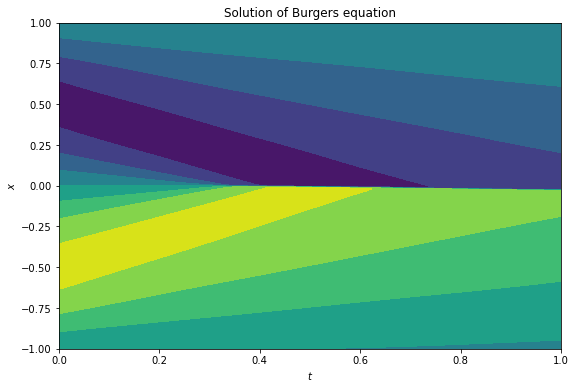

In [59]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T
Xgrid = torch.tensor(Xgrid,dtype=torch.float32)


# Determine predictions of u(t, x)

upred = NN_IB(Xgrid) + D_NN(Xgrid) * u_tilda(Xgrid)
#upred = NN_IB(Xgrid)*torch.exp(-15.*D_NN(Xgrid)) + D_NN(Xgrid) * u_tilda(Xgrid)
#upred = NN_IB(Xgrid)
#upred = D_NN(Xgrid)


# Reshape upred
U = upred.detach().numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)
#ax.plot_surface(T, X, U, cmap='viridis');
ax.contourf(T,X,U)
#ax.view_init(90,0)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
#ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Solution of Burgers equation');
#plt.savefig('Burgers_solution.pdf', bbox_inches='tight', dpi=300);

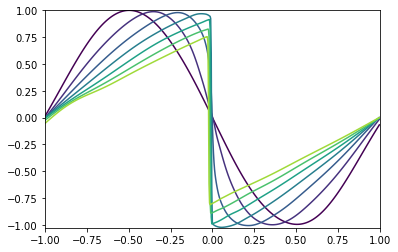

In [60]:
plt.figure()
plt.contour(X,U,T)
#plt.contour(X,U,T,levels=1)
plt.show()

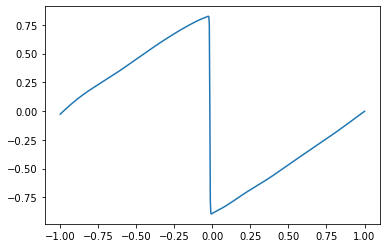

In [61]:
plt.plot(X[:, 450],U[:,450])

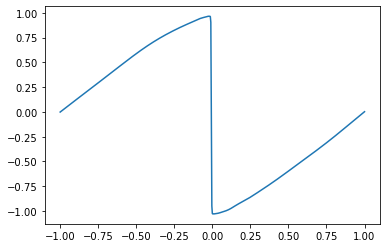

In [62]:
plt.plot(X[:, 300],U[:,300])

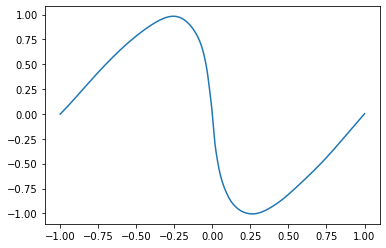

In [65]:
plt.plot(X[:, 150],U[:,150])

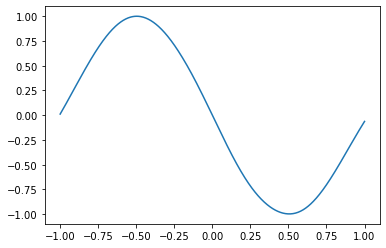

In [66]:
plt.plot(X[:, 0],U[:,0])

In [67]:
"""
PATH1='D_NN_8.pt'
torch.save(D_NN, PATH1)
PATH2='NN_IB_8.pt'
torch.save(NN_IB, PATH2)
PATH3='u_tilda_8.pt'
torch.save(u_tilda, PATH3)
"""

"\nPATH1='D_NN_8.pt'\ntorch.save(D_NN, PATH1)\nPATH2='NN_IB_8.pt'\ntorch.save(NN_IB, PATH2)\nPATH3='u_tilda_8.pt'\ntorch.save(u_tilda, PATH3)\n"